Must add `kaggle.json` before running first cell

In [ ]:
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os

# Check if dataset folder or zip file already exists
if not os.path.exists("preprocessed-data.zip"):
    print("Downloading dataset from Kaggle...")
    !kaggle datasets download quannguyend/preprocessed-data
    !unzip -q preprocessed-data.zip
else:
    print("✅ Dataset already exists — skipping download and unzip.")


Dataset URL: https://www.kaggle.com/datasets/quannguyend/preprocessed-data
License(s): MIT
100% 3.97G/3.99G [00:07<00:00, 370MB/s]
100% 3.99G/3.99G [00:07<00:00, 604MB/s]


In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 42.7 MB/s eta 0:00:00


# Create Dataloader

In [ ]:
import os
import random
import pickle
import logging
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import SimpleITK as sitk
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from tqdm import tqdm

logger = logging.getLogger(__name__)

# Dataset-specific organ label mappings (Unchanged)
CHAOS_ORGAN_LABELS = {0: "Background", 1: "Liver", 2: "Right Kidney", 3: "Left Kidney", 4: "Spleen"}
SABS_ORGAN_LABELS = {
    0: "Background", 1: "Spleen", 2: "Right Kidney", 3: "Left Kidney", 4: "Gallbladder",
    5: "Esophagus", 6: "Liver", 7: "Stomach", 8: "Aorta", 9: "Inferior Vena Cava",
    10: "Portal Vein and Splenic Vein", 11: "Pancreas", 12: "Right Adrenal Gland", 13: "Left Adrenal Gland"
}

class UnifiedAbdominalDataset(Dataset):
    def __init__(
        self,
        data_dir: str,
        dataset_name: str,  # "CHAOS" or "SABS"
        mode: str = "train",
        image_size: int = 256,
        min_mask_pixels: int = 200,
        min_fg_data: int = 200,
        max_cases: Optional[int] = None,
        seed: Optional[int] = None,
        cache_dir: Optional[str] = None,
        preload_volumes: bool = True,
        num_workers: int = 4,
        z_range: int = 3,
        use_fgmask: bool = True,
    ):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)

        self.data_dir = Path(data_dir)
        self.dataset_name = dataset_name.upper()
        self.image_size = image_size
        self.min_mask_pixels = min_mask_pixels
        self.min_fg_data = min_fg_data
        self.cache_dir = Path(cache_dir) if cache_dir else None
        self.preload_volumes = preload_volumes
        self.num_workers = num_workers
        self.z_range = z_range
        self.use_fgmask = use_fgmask

        # Set organ labels based on dataset
        if self.dataset_name == "CHAOS":
            self.organ_labels = CHAOS_ORGAN_LABELS
            if mode == "train":
                self.target_organs = [1, 2, 3, 4]
                default_max = 3000
            elif mode == "val":
                self.target_organs = [1, 4]
                default_max = 100
            elif mode == "distil":
                self.target_organs = [1, 2, 3, 4]
                default_max = 5000
            else:
                self.target_organs = [1, 2, 3, 4]
                default_max = None
        elif self.dataset_name == "SABS":
            self.organ_labels = SABS_ORGAN_LABELS
            if mode == "train":
                self.target_organs = [1, 2, 3, 6]
                default_max = 3000
            elif mode == "val":
                self.target_organs = [1, 6]
                default_max = 100
            if mode == "distil":
                self.target_organs = list(range(1, 14))
                default_max = 5000
            else:
                self.target_organs = list(range(1, 14))
                default_max = None
        else:
            raise ValueError(f"Unknown dataset: {dataset_name}")

        max_cases = max_cases or default_max

        if self.cache_dir:
            self.cache_dir.mkdir(exist_ok=True, parents=True)

        cache_file = self.cache_dir / f"{self.dataset_name}_{mode}_records.pkl" if self.cache_dir else None

        if cache_file and cache_file.exists():
            logger.info(f"Loading cached records from {cache_file}")
            with open(cache_file, "rb") as f:
                self.case_records = pickle.load(f)
        else:
            logger.info(f"Discovering {self.dataset_name} file sets...")
            case_records = self._find_file_sets()
            # Sort for determinism
            case_records.sort(key=lambda x: x[0])
            logger.info("Validating cases with parallel processing...")
            self.case_records = self._filter_valid_cases_parallel(case_records)
            if cache_file:
                with open(cache_file, "wb") as f:
                    pickle.dump(self.case_records, f)

        if max_cases and len(self.case_records) > max_cases:
            logger.info(f"Sampling {max_cases} cases from {len(self.case_records)} available")
            self.case_records = sorted(random.sample(self.case_records, max_cases), key=lambda x: x[0])

        if len(self.case_records) < 2:
            raise RuntimeError(f"Need at least 2 cases for Support/Query split, found {len(self.case_records)}")

        logger.info("Precomputing valid slice indices...")
        self._precompute_valid_indices()

        if preload_volumes:
            logger.info("Preloading volumes into memory...")
            self._preload_volumes()

    def _find_file_sets(self) -> List[Tuple[int, Dict[str, str]]]:
        from collections import defaultdict
        files_by_number = defaultdict(dict)
        for file in self.data_dir.glob("*.nii"):
            name = file.stem
            parts = name.rsplit('_', 1)
            if len(parts) == 2:
                prefix, number = parts
                try:
                    num = int(number)
                    files_by_number[num][prefix] = file.name
                except ValueError:
                    continue
        complete_sets = []
        for num, file_dict in sorted(files_by_number.items()):
            if 'image' in file_dict and 'label' in file_dict:
                complete_sets.append((num, file_dict))
        return complete_sets

    def _normalize_volume(self, array: np.ndarray) -> np.ndarray:
        """
        Normalize the volume using Mean/Std (Z-score normalization).
        Includes robust clipping to prevent outliers from distorting the std.
        """
        # 1. Clip outliers (0.5% to 99.5%) to stabilize Mean/Std calculation
        p_min = np.percentile(array, 0.5)
        p_max = np.percentile(array, 99.5)
        array = np.clip(array, p_min, p_max)

        # 2. Calculate Mean and Std on the clipped volume
        mean = array.mean()
        std = array.std()

        # 3. Normalize (Z-score)
        if std < 1e-8:
            return np.zeros_like(array, dtype=np.float32)

        return ((array - mean) / std).astype(np.float32)

    def _load_volume(self, filepath: Path, normalize: bool = False) -> np.ndarray:
        """Load volume using SimpleITK and return as numpy array in (x, y, z) format"""
        sitk_img = sitk.ReadImage(str(filepath))
        array = sitk.GetArrayFromImage(sitk_img)

        # SimpleITK returns (z, y, x). We transpose to (x, y, z).

        array = np.transpose(array, (1, 2, 0))

        if normalize:
            array = self._normalize_volume(array)

        return array

    def _is_valid_slice(self, mask_slice: np.ndarray) -> bool:
        return np.count_nonzero(mask_slice) >= self.min_mask_pixels

    def _has_min_fg_data(self, mask_slice: np.ndarray) -> bool:
        return np.count_nonzero(mask_slice) >= self.min_fg_data

    def _validate_case(self, record):
        set_num, file_dict = record
        try:
            label_path = self.data_dir / file_dict['label']
            label = self._load_volume(label_path, normalize=False).astype(np.int16)

            if self.use_fgmask and 'fgmask' in file_dict:
                fgmask_path = self.data_dir / file_dict['fgmask']
                fgmask = self._load_volume(fgmask_path, normalize=False).astype(bool)
                label = label * fgmask

            valid: Dict[int, List[int]] = {}
            for organ in self.target_organs:
                organ_mask = (label == organ)
                slice_counts = np.sum(organ_mask, axis=(0, 1))
                valid_slices = np.where(slice_counts >= self.min_mask_pixels)[0].tolist()
                if len(valid_slices) >= 1:
                    valid[organ] = valid_slices
            return (set_num, file_dict, valid) if valid else None
        except Exception as e:
            logger.warning(f"Error validating case {set_num}: {e}")
            return None

    def _filter_valid_cases_parallel(self, records):
        valids = []
        with ThreadPoolExecutor(max_workers=self.num_workers) as ex:
            futures = {ex.submit(self._validate_case, r): r for r in records}
            with tqdm(total=len(records), desc="Validating cases", unit="case") as pbar:
                for f in as_completed(futures):
                    res = f.result()
                    if res: valids.append(res)
                    pbar.update(1)
        return valids

    def _precompute_valid_indices(self):
        self.valid_indices = {i: r[2] for i, r in enumerate(self.case_records)}
        self.organ_to_cases: Dict[int, List[int]] = {}
        for i, organ_map in self.valid_indices.items():
            for organ in organ_map.keys():
                self.organ_to_cases.setdefault(organ, []).append(i)

    def _preload_volumes(self):
        self.volume_cache = {}
        for i, (set_num, file_dict, _) in enumerate(tqdm(self.case_records, desc="Preloading volumes", unit="vol")):
            try:
                # Normalize Image immediately upon loading (3D Normalization)
                img = self._load_volume(self.data_dir / file_dict['image'], normalize=True)

                label = self._load_volume(self.data_dir / file_dict['label'], normalize=False).astype(np.int16)
                fgmask = None
                if self.use_fgmask and 'fgmask' in file_dict:
                    fgmask = self._load_volume(self.data_dir / file_dict['fgmask'], normalize=False).astype(bool)
                self.volume_cache[i] = (img, label, fgmask)
            except Exception as e:
                logger.warning(f"Failed to preload case {i}: {e}")

    def _to_tensor(self, array: np.ndarray, is_mask=False):
        t = torch.from_numpy(array).unsqueeze(0)
        if array.shape == (self.image_size, self.image_size):
            return t
        mode = "nearest" if is_mask else "bilinear"
        t = F.interpolate(
            t.unsqueeze(0), size=(self.image_size, self.image_size),
            mode=mode, align_corners=False if mode == "bilinear" else None
        )
        return t.squeeze(0)

    def __len__(self):
        return len(self.case_records)

    def __getitem__(self, idx):
        max_attempts = 100
        attempt = 0

        # All available patient indices
        all_indices = list(range(len(self.case_records)))

        while attempt < max_attempts:
            attempt += 1

            # 1. Pick Two DIFFERENT Patients Randomly
            # We ignore 'idx' and sample randomly to ensure diversity in pairing
            if len(all_indices) < 2:
                 raise RuntimeError("Dataset needs at least 2 patients.")

            support_case_idx, query_case_idx = random.sample(all_indices, 2)

            # 2. Pick a common organ
            s_organs = set(self.valid_indices[support_case_idx].keys())
            q_organs = set(self.valid_indices[query_case_idx].keys())
            common_organs = list(s_organs.intersection(q_organs))

            if not common_organs:
                continue # Retry if patients don't share any target organ

            organ = random.choice(common_organs)

            # 3. Find Compatible Slices (Z-range constraint)
            # We need a support slice (s) and query slice (q) such that abs(s-q) <= z_range
            s_valid_slices = self.valid_indices[support_case_idx][organ]
            q_valid_slices = self.valid_indices[query_case_idx][organ]

            # Convert to sets for faster lookup
            q_slice_set = set(q_valid_slices)

            # Find all valid (s, q) pairs within range
            valid_pairs = []

            # Optimization: Shuffle support slices to avoid always picking the top one
            # and break early if we find enough candidates
            random.shuffle(s_valid_slices)

            for s_idx in s_valid_slices:
                # Check neighbors: s-3 to s+3
                min_z = s_idx - self.z_range
                max_z = s_idx + self.z_range

                # Intersection of Query slices and the range window
                # This finds q indices that are both valid for the organ AND near s_idx
                candidates = [q for q in range(min_z, max_z + 1) if q in q_slice_set]

                if candidates:
                    q_idx = random.choice(candidates)
                    valid_pairs.append((s_idx, q_idx))
                    break # Found a valid pair, we can stop searching this patient pair

            if not valid_pairs:
                # These two patients don't have this organ at the same height
                continue

            # 4. Select the Pair
            s_idx, q_idx = valid_pairs[0]

            # 5. Load Data
            s_set_num, s_files, _ = self.case_records[support_case_idx]
            q_set_num, q_files, _ = self.case_records[query_case_idx]

            try:
                if hasattr(self, "volume_cache"):
                    s_img, s_label, s_fgmask = self.volume_cache[support_case_idx]
                    q_img, q_label, q_fgmask = self.volume_cache[query_case_idx]
                else:
                    # Fallback disk load (Normalize Image ON LOAD)
                    s_img = self._load_volume(self.data_dir / s_files['image'], normalize=True)
                    s_label = self._load_volume(self.data_dir / s_files['label'], normalize=False).astype(np.int16)
                    q_img = self._load_volume(self.data_dir / q_files['image'], normalize=True)
                    q_label = self._load_volume(self.data_dir / q_files['label'], normalize=False).astype(np.int16)

                    s_fgmask = self._load_volume(self.data_dir / s_files['fgmask'], normalize=False).astype(bool) if self.use_fgmask and 'fgmask' in s_files else None
                    q_fgmask = self._load_volume(self.data_dir / q_files['fgmask'], normalize=False).astype(bool) if self.use_fgmask and 'fgmask' in q_files else None

                # Extract Slices
                s_img_slice = s_img[:, :, s_idx]
                q_img_slice = q_img[:, :, q_idx]

                s_label_slice_raw = s_label[:, :, s_idx]
                q_label_slice_raw = q_label[:, :, q_idx]

                if s_fgmask is not None: s_label_slice_raw *= s_fgmask[:, :, s_idx]
                if q_fgmask is not None: q_label_slice_raw *= q_fgmask[:, :, q_idx]

                s_mask_slice = (s_label_slice_raw == organ).astype(np.uint8)
                q_mask_slice = (q_label_slice_raw == organ).astype(np.uint8)

                # Validation checks (mask size)
                if not (self._is_valid_slice(s_mask_slice) and self._is_valid_slice(q_mask_slice)):
                    continue
                if not (self._has_min_fg_data(s_mask_slice) and self._has_min_fg_data(q_mask_slice)):
                    continue

                # Note: No more per-slice normalization here. Image is already volume-normalized.

                return {
                    "support_image": self._to_tensor(s_img_slice),
                    "support_mask": self._to_tensor(s_mask_slice, True),
                    "query_image": self._to_tensor(q_img_slice),
                    "query_mask": self._to_tensor(q_mask_slice, True),
                    "organ_label": torch.tensor(organ, dtype=torch.long),
                    "support_case_idx": torch.tensor(support_case_idx, dtype=torch.long),
                    "query_case_idx": torch.tensor(query_case_idx, dtype=torch.long),
                    "support_set_num": torch.tensor(s_set_num, dtype=torch.long),
                    "query_set_num": torch.tensor(q_set_num, dtype=torch.long),
                    "dataset": self.dataset_name,
                }

            except Exception as e:
                logger.warning(f"Error processing pair (s={support_case_idx}, q={query_case_idx}): {e}")
                continue

        raise IndexError(f"Failed to generate valid Support/Query pair (Different Patients, Z-range +/-{self.z_range}) "
                         f"after {max_attempts} attempts. Check data alignment or loosen constraints.")


def create_unified_dataloaders(
    chaos_dir: str,
    sabs_dir: str,
    batch_size: int = 1,
    num_workers: int = 2,
    use_both_train: bool = True,
    use_both_val: bool = True,
    **kwargs
):
    """
    Unchanged factory function.
    """
    # Create CHAOS datasets
    logger.info("=" * 60)
    logger.info("Creating CHAOS datasets...")
    logger.info("=" * 60)
    chaos_train_ds = UnifiedAbdominalDataset(chaos_dir, "CHAOS", mode="train", **kwargs)
    chaos_distill_ds = UnifiedAbdominalDataset(chaos_dir, "CHAOS", mode="distil", **kwargs)
    chaos_val_ds = UnifiedAbdominalDataset(chaos_dir, "CHAOS", mode="val", **kwargs)

    # Create SABS datasets
    logger.info("=" * 60)
    logger.info("Creating SABS datasets...")
    logger.info("=" * 60)
    sabs_train_ds = UnifiedAbdominalDataset(sabs_dir, "SABS", mode="train", **kwargs)
    sabs_distill_ds = UnifiedAbdominalDataset(sabs_dir, "SABS", mode="distil", **kwargs)
    sabs_val_ds = UnifiedAbdominalDataset(sabs_dir, "SABS", mode="val", **kwargs)

    # Combine datasets based on flags
    if use_both_train:
        logger.info("\n✓ Combining CHAOS + SABS for training")
        train_ds = ConcatDataset([chaos_train_ds, sabs_train_ds])
        distill_ds = ConcatDataset([chaos_distill_ds, sabs_distill_ds])
    else:
        logger.info("\n✓ Using CHAOS only for training")
        train_ds = chaos_train_ds
        distill_ds = chaos_distill_ds

    if use_both_val:
        logger.info("✓ Combining CHAOS + SABS for validation")
        val_ds = ConcatDataset([chaos_val_ds, sabs_val_ds])
    else:
        logger.info("✓ Using CHAOS only for validation")
        val_ds = chaos_val_ds

    common = {
        "num_workers": num_workers,
        "pin_memory": torch.cuda.is_available(),
        "persistent_workers": num_workers > 0,
        "prefetch_factor": 2 if num_workers > 0 else None,
    }

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, **common)
    distill_loader = DataLoader(distill_ds, batch_size=batch_size, shuffle=True, drop_last=True, **common)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False, **common)

    return train_loader, distill_loader, val_loader

Preloading volumes: 100%|██████████| 30/30 [02:21<00:00,  4.73s/vol]

Checking validation loader...


Validation loader has samples!
  Support image shape: torch.Size([4, 1, 256, 256])
  Query image shape: torch.Size([4, 1, 256, 256])
  Support mask shape: torch.Size([4, 1, 256, 256])
  Query mask shape: torch.Size([4, 1, 256, 256])
  Organ labels: tensor([4, 1, 4, 4])
  Dataset info: ['CHAOS', 'CHAOS', 'CHAOS', 'CHAOS']

Batch shapes:
  Support image: torch.Size([4, 1, 256, 256])
  Support mask: torch.Size([4, 1, 256, 256])
  Query image: torch.Size([4, 1, 256, 256])
  Query mask: torch.Size([4, 1, 256, 256])
  Organ labels: tensor([4, 2, 3, 5])
  Datasets: ['CHAOS', 'SABS', 'CHAOS', 'SABS']


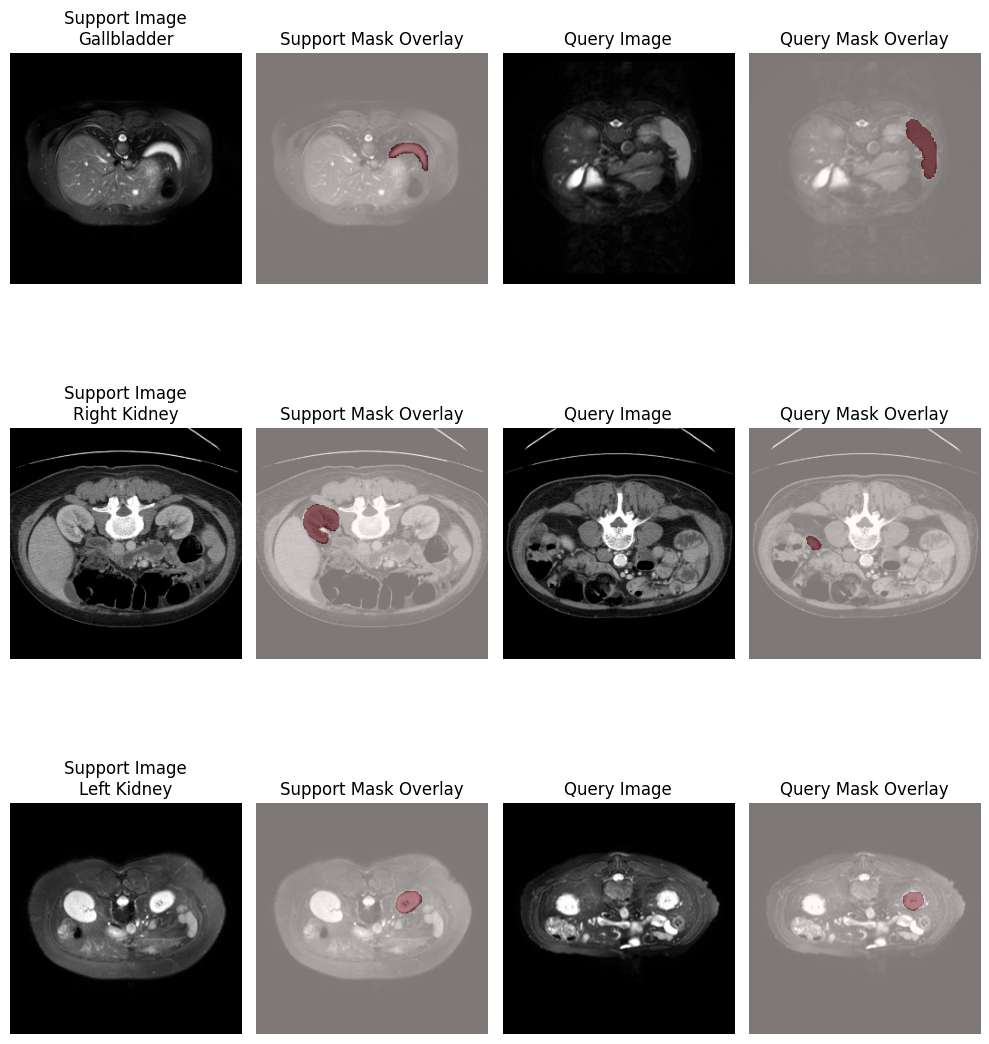

In [ ]:
# Demo/Testing code
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    logging.basicConfig(level=logging.INFO)

    # Paths
    chaos_dir = "/content/chaos_MR_T2_normalized/chaos_MR_T2_normalized"
    sabs_dir = "/content/sabs_CT_normalized/sabs_CT_normalized"

    # Create unified dataloaders
    train_loader, distill_loader, val_loader = create_unified_dataloaders(
        chaos_dir=chaos_dir,
        sabs_dir=sabs_dir,
        batch_size=4,
        num_workers=2,
        image_size=256,
        min_mask_pixels=100,
        cache_dir="/content/cache",
        z_range=4,
        use_fgmask=True,
        use_both_train=True,
        use_both_val=True,
    )

    # Fetch batch
    print("Checking validation loader...")

    try:
        # Try fetching one batch
        batch = next(iter(val_loader))
        print("Validation loader has samples!")
        print(f"  Support image shape: {batch['support_image'].shape}")
        print(f"  Query image shape: {batch['query_image'].shape}")
        print(f"  Support mask shape: {batch['support_mask'].shape}")
        print(f"  Query mask shape: {batch['query_mask'].shape}")
        print(f"  Organ labels: {batch['organ_label']}")
        print(f"  Dataset info: {batch.get('dataset', 'N/A')}")
    except RuntimeError as e:
        print("Error fetching batch from val_loader:", e)
        print("💡 Likely cause: val_loader is empty (fold_case_indices = 0).")

    batch = next(iter(train_loader))
    print(f"\nBatch shapes:")
    print(f"  Support image: {batch['support_image'].shape}")
    print(f"  Support mask: {batch['support_mask'].shape}")
    print(f"  Query image: {batch['query_image'].shape}")
    print(f"  Query mask: {batch['query_mask'].shape}")
    print(f"  Organ labels: {batch['organ_label']}")
    print(f"  Datasets: {batch.get('dataset', 'N/A')}")

    # Visualization
    def plot_samples(batch, n=3):
        """Plot n samples from batch."""
        support_imgs = batch["support_image"].cpu().numpy()
        support_masks = batch["support_mask"].cpu().numpy()
        query_imgs = batch["query_image"].cpu().numpy()
        query_masks = batch["query_mask"].cpu().numpy()
        organs = batch["organ_label"].cpu().numpy()

        # Combine both label mappings
        all_organ_labels = {**CHAOS_ORGAN_LABELS, **SABS_ORGAN_LABELS}

        plt.figure(figsize=(10, 4 * n))
        for i in range(min(n, len(support_imgs))):
            s_img = support_imgs[i, 0]
            s_mask = support_masks[i, 0]
            q_img = query_imgs[i, 0]
            q_mask = query_masks[i, 0]
            organ_name = all_organ_labels.get(int(organs[i]), f"Organ {int(organs[i])}")

            plt.subplot(n, 4, 4 * i + 1)
            plt.imshow(s_img, cmap="gray")
            plt.title(f"Support Image\n{organ_name}")
            plt.axis("off")

            plt.subplot(n, 4, 4 * i + 2)
            plt.imshow(s_img, cmap="gray")
            plt.imshow(s_mask, cmap="Reds", alpha=0.5)
            plt.title("Support Mask Overlay")
            plt.axis("off")

            plt.subplot(n, 4, 4 * i + 3)
            plt.imshow(q_img, cmap="gray")
            plt.title("Query Image")
            plt.axis("off")

            plt.subplot(n, 4, 4 * i + 4)
            plt.imshow(q_img, cmap="gray")
            plt.imshow(q_mask, cmap="Reds", alpha=0.5)
            plt.title("Query Mask Overlay")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

    plot_samples(batch, n=min(3, batch["support_image"].shape[0]))

In [ ]:
# ============================
# Print range of input tensors
# ============================

def print_range(name, tensor):
    arr = tensor.cpu().numpy()
    print(f"{name}: min={arr.min():.6f}, max={arr.max():.6f}, dtype={arr.dtype}")

print("\n=== RANGE CHECK FOR ONE TRAIN BATCH ===")
batch = next(iter(train_loader))

print_range("Support image", batch["support_image"])
print_range("Support mask", batch["support_mask"])
print_range("Query image", batch["query_image"])
print_range("Query mask", batch["query_mask"])
print(f"Organ labels: {batch['organ_label']}")
print("=========================================")



=== RANGE CHECK FOR ONE TRAIN BATCH ===
Support image: min=-0.898492, max=3.345809, dtype=float32
Support mask: min=0.000000, max=1.000000, dtype=uint8
Query image: min=-0.816606, max=3.980675, dtype=float32
Query mask: min=0.000000, max=1.000000, dtype=uint8
Organ labels: tensor([ 7, 12,  2,  9])


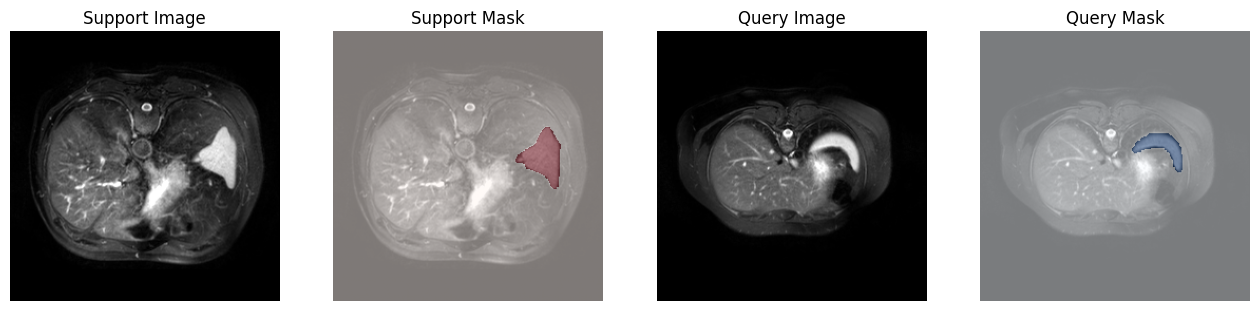

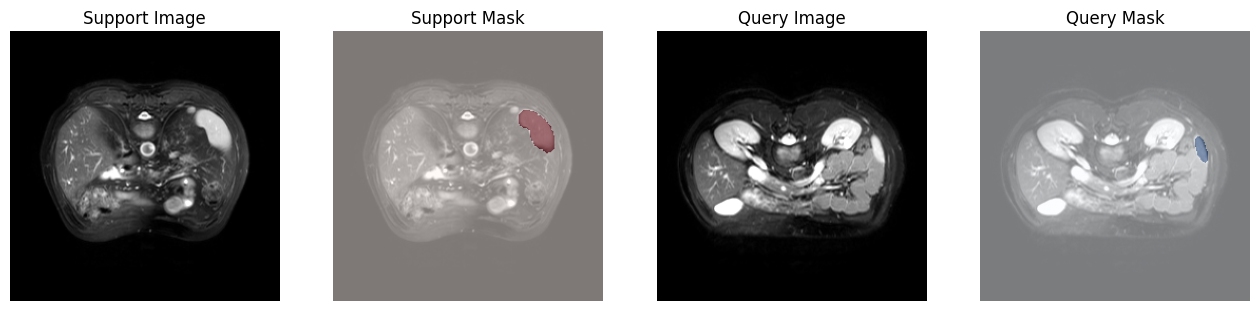

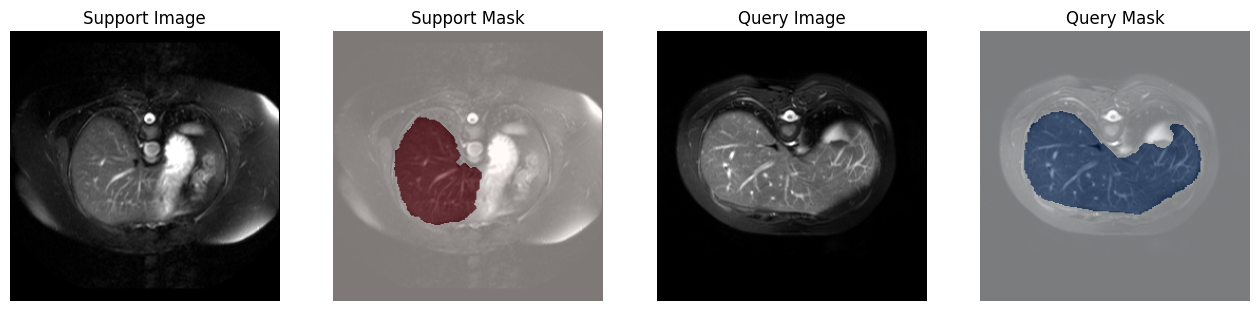

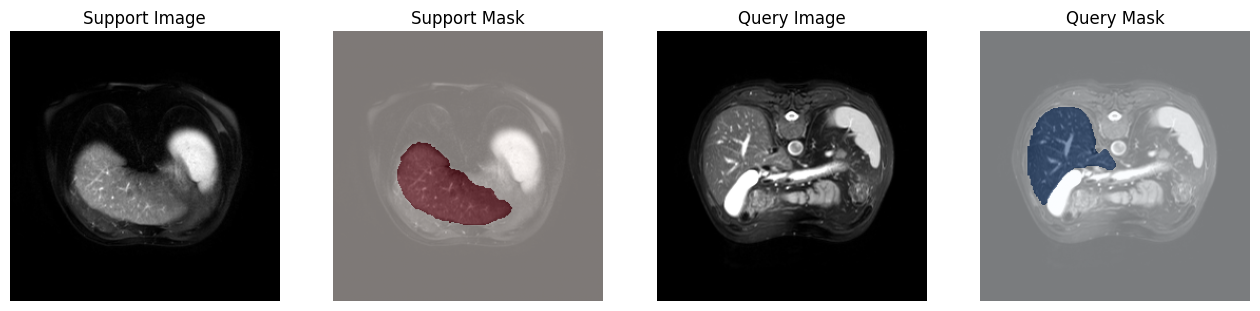

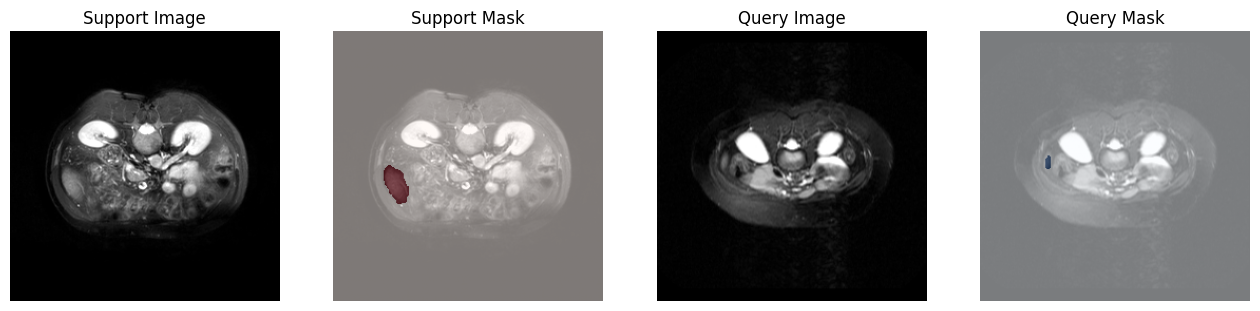

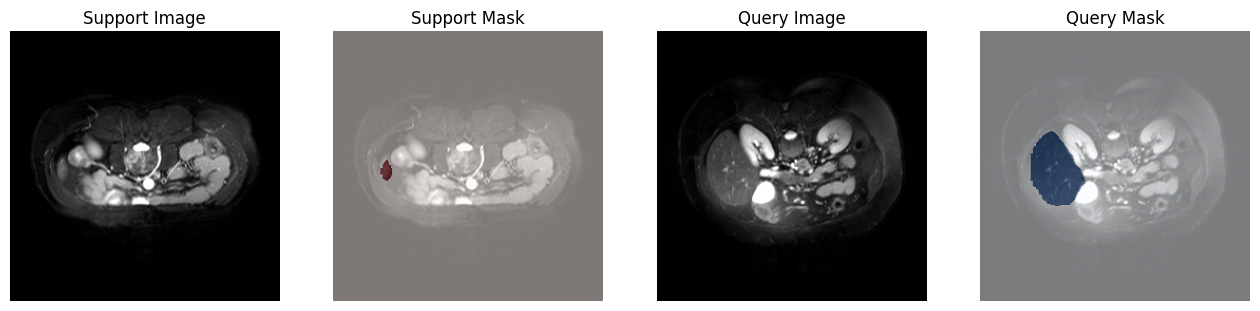

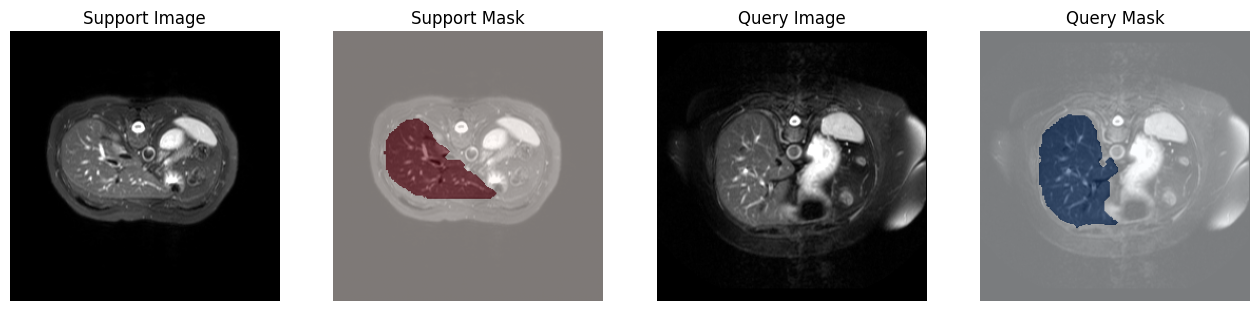

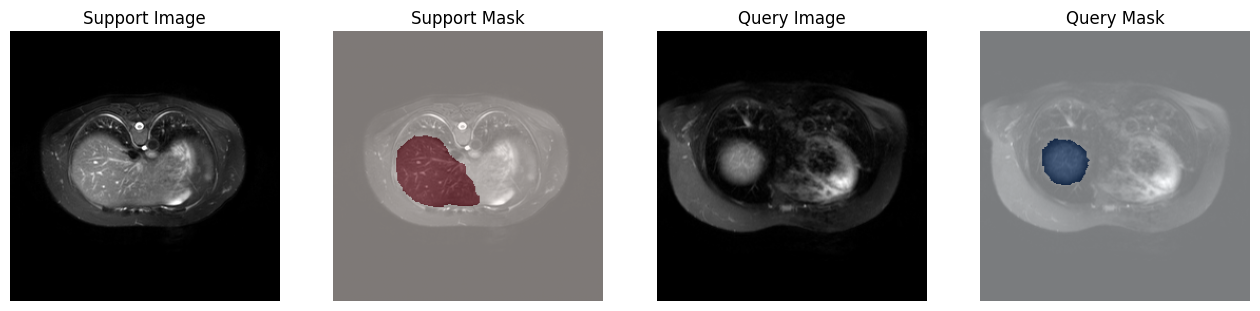

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_samples(dataloader, n=5):
    """
    Visualize support/query images and masks from a few-shot dataloader.

    Args:
        dataloader: PyTorch DataLoader returning dict with keys:
                    "support_image", "support_mask", "query_image", "query_mask"
        n: number of batches to visualize
    """
    for i, batch in enumerate(dataloader):
        if i >= n:
            break

        support_img = batch["support_image"]   # [B,1,H,W] or [B,3,H,W]
        support_mask = batch["support_mask"]   # [B,1,H,W]
        query_img = batch["query_image"]       # [B,1,H,W] or [B,3,H,W]
        query_mask = batch["query_mask"]       # [B,1,H,W]

        B = support_img.shape[0]

        for b in range(B):
            plt.figure(figsize=(16,4))

            # Ensure images are single-channel for imshow if needed
            def to_display(img):
                if img.shape[0] == 3:  # [3,H,W] -> grayscale mean for visualization
                    return img.cpu().mean(0)
                return img.cpu()[0]    # [1,H,W] -> [H,W]

            # 1. Support image
            plt.subplot(1,4,1)
            plt.imshow(to_display(support_img[b]), cmap="gray")
            plt.title("Support Image")
            plt.axis("off")

            # 2. Support mask overlay
            plt.subplot(1,4,2)
            plt.imshow(to_display(support_img[b]), cmap="gray")
            plt.imshow(support_mask[b,0].cpu(), cmap="Reds", alpha=0.5)
            plt.title("Support Mask")
            plt.axis("off")

            # 3. Query image
            plt.subplot(1,4,3)
            plt.imshow(to_display(query_img[b]), cmap="gray")
            plt.title("Query Image")
            plt.axis("off")

            # 4. Query mask overlay
            plt.subplot(1,4,4)
            plt.imshow(to_display(query_img[b]), cmap="gray")
            plt.imshow(query_mask[b,0].cpu(), cmap="Blues", alpha=0.5)
            plt.title("Query Mask")
            plt.axis("off")

            plt.show()


# Example usage
visualize_samples(val_loader, n=2)


In [ ]:
!pip install axial_attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from axial_attention import AxialAttention, AxialPositionalEmbedding
from torchvision.models.segmentation import deeplabv3_resnet101
import math
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def safe_norm(x, p=2, dim=1, eps=1e-4):
    device = x.device
    x_norm = torch.norm(x, p=p, dim=dim)
    x_norm = torch.max(x_norm, torch.ones_like(x_norm, device=device) * eps)
    x = x.div(x_norm.unsqueeze(1).expand_as(x))
    return x


# ==============================
# Pretrained Encoder
# ==============================
class PretrainedEncoder(nn.Module):
    def __init__(self, backbone="resnet18", feature_dim=256, pretrained=True):
        super().__init__()
        self.feature_dim = feature_dim

        if backbone == "resnet18":
            base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
            layers = list(base.children())[:-2]
            self.encoder = nn.Sequential(*layers)
            in_channels = 512

        elif backbone == "resnet50":
            base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            layers = list(base.children())[:-2]
            self.encoder = nn.Sequential(*layers)
            in_channels = 2048

        elif backbone == "vgg16":
            base = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT if pretrained else None)
            self.encoder = base.features
            in_channels = 512

        else:
            raise ValueError(f"Backbone {backbone} not supported.")

        # Patch first conv layer to 1 channel
        old_conv = self.encoder[0]
        self.encoder[0] = nn.Conv2d(
            1, old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None
        )
        with torch.no_grad():
            self.encoder[0].weight[:] = old_conv.weight.mean(dim=1, keepdim=True)

        self.proj = nn.Conv2d(in_channels, feature_dim, kernel_size=1, bias=False)
        nn.init.kaiming_normal_(self.proj.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        feat = self.encoder(x)
        feat = self.proj(feat)
        return feat

# ==============================
# LoGo Encoder
# ==============================
class ConvFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.fuse_conv = nn.Sequential(
            nn.Conv2d(2 * channels, channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.fuse_fc = nn.Sequential(
            nn.Linear(2 * channels, channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, x_loc, use_conv=True):
        """
        x: [B, C] or [B, C, H, W]
        x_loc: [B, C] or [B, C, H, W]
        """
        if x.dim() == 4 and x_loc.dim() == 4:
            # Both are [B, C, H, W]
            return self.fuse_conv(torch.cat([x, x_loc], dim=1))
        else:
            # Both are [B, C] - use FC layer
            return self.fuse_fc(torch.cat([x, x_loc], dim=1))


# RMSNorm implementation (faster alternative to LayerNorm)
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization - used in modern transformers"""
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim, 1, 1))

    def forward(self, x):
        # x: [B, C, H, W]
        norm = torch.rsqrt(x.pow(2).mean(dim=1, keepdim=True) + self.eps)
        return x * norm * self.weight


class LoGoEncoder(nn.Module):
    def __init__(self, device='cuda'):
        super(LoGoEncoder, self).__init__()

        self.device = device

        # Global pathway - processes full image
        # Using GroupNorm (more stable than BatchNorm) + GELU activation
        self.conv1 = nn.Sequential(
            # Layer 1: 256×256 → 128×128
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 128),  # 32 groups for 128 channels
            nn.GELU(),
            nn.Dropout(0.5),

            # Layer 2: 128×128 → 64×64
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 256),
            nn.GELU(),
            nn.Dropout(0.5),

            # Layer 3: 64×64 → 32×32
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 512),
            nn.GELU(),
            nn.Dropout(0.5),
        )

        # Local pathway - processes patches
        self.conv1_p = nn.Sequential(
            # Layer 1: 64×64 → 32×32
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 128),
            nn.GELU(),
            nn.Dropout(0.5),

            # Layer 2: 32×32 → 16×16
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 256),
            nn.GELU(),
            nn.Dropout(0.5),

            # Layer 3: 16×16 → 8×8
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 512),
            nn.GELU(),
            nn.Dropout(0.5),
        )

        # Global attention block with RMSNorm (faster than LayerNorm)
        self.global_block = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
            RMSNorm(512),
            AxialPositionalEmbedding(dim=512, shape=(32, 32)),
            AxialAttention(dim=512, heads=16, dim_index=1),
            AxialPositionalEmbedding(dim=512, shape=(32, 32)),
            AxialAttention(dim=512, heads=8, dim_index=1),
            nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
            RMSNorm(512),
        )

        # Cross-patch attention block with RMSNorm
        self.cross_patch_block = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
            RMSNorm(512),
            AxialPositionalEmbedding(dim=512, shape=(32, 32)),
            AxialAttention(dim=512, heads=8, dim_index=1),
            nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
            RMSNorm(512),
        )

        # Local attention block with RMSNorm
        self.local_block = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
            RMSNorm(512),
        )

        self.local_pos_embed = AxialPositionalEmbedding(dim=512, shape=(8, 8))
        self.local_attention = AxialAttention(dim=512, heads=16, dim_index=1)
        self.local_pos_embed2 = AxialPositionalEmbedding(dim=512, shape=(8, 8))
        self.local_attention2 = AxialAttention(dim=512, heads=8, dim_index=1)
        self.local_block_post = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
            RMSNorm(512),
        )

        # Gated fusion with Swish activation
        self.fuse_gate = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.SiLU()  # Swish/SiLU for smoother gating
        )

        # Fusion and projection layers with GroupNorm
        self.adjust_p = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=1, stride=1, padding=0),
            nn.GroupNorm(32, 1024),
            nn.GELU(),
            nn.Dropout(0.25)
        )

        self.weights = nn.Parameter(torch.tensor([0.5, 0.5]), requires_grad=True)

        # Load pretrained weights
        self.global_teacher = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14")
        self.global_teacher.to(self.device)

        # Local Teacher: DeepLabv3 with ResNet101 backbone
        self.local_teacher = deeplabv3_resnet101(pretrained=True)
        self.local_teacher.to(self.device)

        self.Tg = 4

        # Projection layers with proper initialization
        self.proj_teacher_local = nn.Conv2d(1024, 512, kernel_size=1, bias=False)
        nn.init.kaiming_normal_(self.proj_teacher_local.weight, mode="fan_out", nonlinearity="relu")

        weight_path = "./logoencoder_final.pt"
        if os.path.exists(weight_path):
            try:
                self.load_state_dict(torch.load(weight_path, map_location=self.device))
                print(f"✅ Loaded existing weights from {weight_path}")
            except Exception as e:
                print(f"⚠️ Failed to load weights from {weight_path}: {e}")
        else:
            print("ℹ️ No existing weights found, starting from scratch.")

    def forward(self, x):
        # Handle single-channel inputs (convert to 3-channel)
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        elif x.shape[1] != 3:
            raise ValueError(f"Unexpected channel size: {x.shape}")

        img_size = x.shape[-1]
        xin = x
        B = x.shape[0]

        # ==================== Global Pathway ====================
        x = self.conv1(x)  # [B, 512, 32, 32] for 256×256 input
        x_attn = self.global_block(x)
        x = x + x_attn  # [B, 512, 32, 32]

        H, W = x.shape[2], x.shape[3]  # Should be 32×32

        # ==================== Local Pathway with Reassembly ====================
        patch_size = 64  # Original image patch size
        grid_h = img_size // patch_size  # 256 // 64 = 4
        grid_w = img_size // patch_size  # 256 // 64 = 4

        feat_patch_size = 8

        # Initialize output tensor for reassembled patches
        x_loc = torch.zeros(B, 512, grid_h * feat_patch_size, grid_w * feat_patch_size,
                           device=x.device, dtype=x.dtype)

        # Process each patch in grid
        for i in range(grid_h):
            for j in range(grid_w):
                x_p_init = xin[:, :,
                         patch_size * i : patch_size * (i+1),
                         patch_size * j : patch_size * (j+1)]  # [B, 3, 64, 64]

                # Process patch through local pathway
                x_p_init = self.conv1_p(x_p_init)  # [B, 512, 8, 8]

                # Apply local attention blocks
                x_p = self.local_block(x_p_init)
                x_p = self.local_pos_embed(x_p)
                x_p = self.local_attention(x_p)
                x_p = self.local_pos_embed2(x_p)
                x_p = self.local_attention2(x_p)
                x_p = self.local_block_post(x_p)  # [B, 512, 8, 8]

                # Place processed patch back into correct position
                x_loc[:, :,
                     feat_patch_size * i : feat_patch_size * (i+1),
                     feat_patch_size * j : feat_patch_size * (j+1)] = x_p

        # ==================== Fusion with Adaptive Instance Normalization ====================
        # Using AdaIN for more flexible feature alignment
        x_loc = x + self.cross_patch_block(x_loc)

        x = self.adaptive_instance_norm(x)
        x_loc = self.adaptive_instance_norm(x_loc)

        gate = self.fuse_gate(torch.cat([x, x_loc], dim=1))   # [B, 512, 32, 32]

        # Weighted combination of global and local features
        x_combine = gate * x + (1 - gate) * x_loc

        # ==================== Residual connection with global features ====================
        x_combine = torch.cat([x_combine, x], dim=1)  # [B, 1024, 32, 32]

        # ==================== Final projection ====================
        x_combine = self.adjust_p(x_combine)  # [B, 1024, 32, 32]

        return x, x_loc, x_combine

    def adaptive_instance_norm(self, x):
        """Adaptive Instance Normalization for better feature alignment"""
        mean = x.mean(dim=[2, 3], keepdim=True)
        std = x.std(dim=[2, 3], keepdim=True) + 1e-6
        return (x - mean) / std

    def save_weights(self, path="./logoencoder_final.pt"):
        torch.save(self.state_dict(), path)
        print(f"✅ Weights saved to {path}")

    def load_weights(self, path="./logoencoder_final.pt", map_location=device):
        self.load_state_dict(torch.load(path, map_location=map_location))
        print(f"✅ Weights loaded from {path}")

    def global_distillation_loss(self, student, teacher):
        """
        student: [B, C, H, W] - student global features [5, , 32, 32]
        teacher: [B, N, D] - teacher patch tokens from DINOv2 [5, 256, 1024]
        """
        def student_to_patches(student, N=256):
            # [B, C, H, W] -> [B, N, C]
            student_feat = student.permute(0, 2, 3, 1)  # [B, H, W, C]
            B, H, W, D = student_feat.shape
            P = 8
            h_patch, w_patch = H // P, W // P
            student = student_feat.view(B, P, h_patch, P, w_patch, D)
            student = student.mean(dim=(2, 4))
            student = student.permute(0, 3, 1, 2)
            student = F.interpolate(student, size=(16, 16), mode='bilinear', align_corners=False)
            student = student.permute(0, 2, 3, 1).reshape(B, 256, D)
            return student

        def multi_pos_nce(student_patches, teacher_patches, tau=0.07):
            """
            student_patches: [B, N, D_s]
            teacher_patches: [B, N, D_t]
            """
            B, N, D_s = student_patches.shape
            _, _, D_t = teacher_patches.shape

            # Project teacher to student dimension if needed
            if D_t != D_s:
                # Simple projection: take first D_s dimensions or pad
                if D_t > D_s:
                    teacher_patches = teacher_patches[:, :, :D_s]
                else:
                    # Pad if teacher is smaller
                    pad_size = D_s - D_t
                    teacher_patches = torch.cat([
                        teacher_patches,
                        torch.zeros(B, N, pad_size, device=teacher_patches.device, dtype=teacher_patches.dtype)
                    ], dim=-1)

            s = F.normalize(student_patches, dim=-1).reshape(B * N, D_s)
            t = F.normalize(teacher_patches, dim=-1).reshape(B * N, D_s)
            logits = s @ t.T / tau
            labels = torch.arange(B * N, device=s.device)
            return F.cross_entropy(logits, labels) / math.log(B * N)

        def rkd_loss(g_s, g_t):
            B, D = g_s.shape
            if B < 2:
                return torch.tensor(0.0, device=g_s.device)
            dist_s = torch.cdist(g_s, g_s)
            dist_t = torch.cdist(g_t, g_t)
            mean_s, mean_t = dist_s[dist_s > 0].mean(), dist_t[dist_t > 0].mean()
            dist_s, dist_t = dist_s / mean_s, dist_t / mean_t
            return F.l1_loss(dist_s, dist_t)

        def cov_loss(g_s, g_t, normalize=True, use_mse=True, scale=1.0):
            if normalize:
                g_s = F.normalize(g_s, dim=-1)
                g_t = F.normalize(g_t, dim=-1)
            g_s = g_s - g_s.mean(dim=0, keepdim=True)
            g_t = g_t - g_t.mean(dim=0, keepdim=True)

            # Ensure same dimension
            min_dim = min(g_s.shape[-1], g_t.shape[-1])
            g_s = g_s[:, :min_dim]
            g_t = g_t[:, :min_dim]

            C_s = g_s.T @ g_s / (g_s.shape[0] - 1)
            C_t = g_t.T @ g_t / (g_t.shape[0] - 1)
            loss = torch.mean((C_s - C_t) ** 2) if use_mse else torch.norm(C_s - C_t, p='fro')
            return loss * scale

        def feature_decorrelation_loss(z_s, z_t, eps=1e-5):
            # Ensure same dimension
            min_dim = min(z_s.shape[-1], z_t.shape[-1])
            z_s = z_s[:, :min_dim]
            z_t = z_t[:, :min_dim]

            z_s = (z_s - z_s.mean(0)) / (z_s.std(0) + eps)
            z_t = (z_t - z_t.mean(0)) / (z_t.std(0) + eps)
            c_s = z_s.T @ z_s / z_s.shape[0]
            c_t = z_t.T @ z_t / z_t.shape[0]
            I = torch.eye(c_s.size(0), device=z_s.device)
            return (F.mse_loss(c_s, I) + F.mse_loss(c_t, I)) / 2

        def kl_divergence_loss(g_s, g_t):
            # Ensure same dimension
            min_dim = min(g_s.shape[-1], g_t.shape[-1])
            g_s = g_s[:, :min_dim]
            g_t = g_t[:, :min_dim]

            p_s = F.log_softmax(g_s, dim=-1)
            p_t = F.softmax(g_t, dim=-1)
            return F.kl_div(p_s, p_t, reduction='batchmean')

        # Adaptive weighting based on model's gradient norm
        total_grad_norm = sum(p.grad.norm().item() if p.grad is not None else 0.0
                            for p in self.parameters())
        alpha = 1.0 / (1.0 + math.exp(-0.01 * total_grad_norm))
        beta = 1.0 - alpha

        s_patches = student_to_patches(student)  # [B, 256, 512]
        g_s = s_patches.mean(dim=1)  # [B, 512]
        g_t = teacher.mean(dim=1)    # [B, 1024]

        loss_nce = multi_pos_nce(s_patches, teacher)
        loss_rkd = rkd_loss(g_s, g_t)
        loss_cov = cov_loss(g_s, g_t)
        loss_decor = feature_decorrelation_loss(g_s, g_t)
        loss_kl = kl_divergence_loss(g_s, g_t)

        total = alpha * (loss_nce + loss_rkd) + beta * (loss_cov + loss_decor + loss_kl)

        return total, {
            "NCE": loss_nce.item(),
            "RKD": loss_rkd.item(),
            "Cov": loss_cov.item(),
            "Decor": loss_decor.item(),
            "KL": loss_kl.item(),
            "Alpha": alpha,
            "Beta": beta
        }

    def local_distillation_loss(self, student, teacher,
                            w_cos=1.0, w_nce=0.5, w_edge=0.5,
                            w_perc=0.0, w_mi=0.0, w_chamfer=0.2,
                            use_pixel_nce=True, use_chamfer=True):
        def per_pixel_cosine_loss(student, teacher):
            s = F.normalize(student, dim=-1)
            t = F.normalize(teacher, dim=-1)
            return (1 - (s * t).sum(-1)).mean()

        def pixel_nce_loss(student, teacher, tau=0.07):
            B, H, W, D = student.shape
            s = F.normalize(student, dim=-1).reshape(B * H * W, D)
            t = F.normalize(teacher, dim=-1).reshape(B * H * W, D)
            logits = (s @ t.T) / tau
            labels = torch.arange(B * H * W, device=student.device)
            return F.cross_entropy(logits, labels) / math.log(max(2, B * H * W))

        def edge_aware_loss(student, teacher):
            def sobel(x):
                gx = x[:, 1:, :, :] - x[:, :-1, :, :]
                gy = x[:, :, 1:, :] - x[:, :, :-1, :]
                gx = F.pad(gx, (0, 0, 0, 0, 1, 0))
                gy = F.pad(gy, (0, 0, 1, 0, 0, 0))
                return gx, gy
            gx_s, gy_s = sobel(student)
            gx_t, gy_t = sobel(teacher)
            return F.l1_loss(gx_s, gx_t) + F.l1_loss(gy_s, gy_t)

        def local_mi_loss(student, teacher, eps=1e-8):
            B, H, W, D = student.shape
            s = F.normalize(student, dim=-1).reshape(B * H * W, D)
            t = F.normalize(teacher, dim=-1).reshape(B * H * W, D)
            logits = (s @ t.T) / 0.1
            labels = torch.arange(B * H * W, device=student.device)
            return F.cross_entropy(logits, labels) / math.log(max(2, B * H * W))

        def chamfer_loss(student, teacher, squared=True, normalize=True):
            B, H, W, D = student.shape
            s = student.reshape(B, H * W, D)
            t = teacher.reshape(B, H * W, D)
            if normalize:
                s = F.normalize(s, dim=-1)
                t = F.normalize(t, dim=-1)
            loss_total = 0.0
            for b in range(B):
                dists = torch.cdist(s[b], t[b])
                if squared:
                    dists = dists ** 2
                loss_st = dists.min(dim=1)[0].mean()
                loss_ts = dists.min(dim=0)[0].mean()
                loss_total += (loss_st + loss_ts)
            return loss_total / B

        def feature_decorrelation_loss(z_s, z_t, eps=1e-5):
            z_s = (z_s - z_s.mean(0)) / (z_s.std(0) + eps)
            z_t = (z_t - z_t.mean(0)) / (z_t.std(0) + eps)
            c_s = z_s.T @ z_s / z_s.shape[0]
            c_t = z_t.T @ z_t / z_t.shape[0]
            I = torch.eye(c_s.size(0), device=z_s.device)
            return (F.mse_loss(c_s, I) + F.mse_loss(c_t, I)) / 2

        def kl_divergence_loss(g_s, g_t):
            p_s = F.log_softmax(g_s, dim=-1)
            p_t = F.softmax(g_t, dim=-1)
            return F.kl_div(p_s, p_t, reduction='batchmean')

        with torch.no_grad():
            total_grad_norm = sum(p.grad.norm().item() for p in self.parameters() if p.grad is not None)
        alpha = 1.0 / (1.0 + math.exp(-0.01 * total_grad_norm))
        beta = 1.0 - alpha

        s = student.permute(0, 2, 3, 1)
        t = teacher.permute(0, 2, 3, 1)

        loss_cos = per_pixel_cosine_loss(s, t)
        loss_edge = edge_aware_loss(s, t)

        loss_nce = pixel_nce_loss(s, t) if use_pixel_nce else torch.tensor(0.0, device=s.device)
        loss_mi = local_mi_loss(s, t) if w_mi > 0 else torch.tensor(0.0, device=s.device)
        loss_cham = chamfer_loss(s, t) if use_chamfer else torch.tensor(0.0, device=s.device)
        loss_perc = torch.tensor(0.0, device=s.device)

        # local pooled globals
        gp_s = F.adaptive_avg_pool2d(student.permute(0, 3, 1, 2), 1).view(student.shape[0], -1)
        gp_t = F.adaptive_avg_pool2d(teacher.permute(0, 3, 1, 2), 1).view(teacher.shape[0], -1)

        loss_decor = feature_decorrelation_loss(gp_s, gp_t)
        loss_kl = kl_divergence_loss(gp_s, gp_t)

        lightweight = (w_cos * loss_cos + w_edge * loss_edge)
        heavier = (w_nce * loss_nce + w_mi * loss_mi + w_chamfer * loss_cham + w_perc * loss_perc)
        stats = {
            "cosine": loss_cos.item(),
            "edge": loss_edge.item(),
            "nce": (loss_nce.item() if isinstance(loss_nce, torch.Tensor) else float(loss_nce)),
            "mi": (loss_mi.item() if isinstance(loss_mi, torch.Tensor) else float(loss_mi)),
            "chamfer": (loss_cham.item() if isinstance(loss_cham, torch.Tensor) else float(loss_cham)),
            "decor": loss_decor.item(),
            "kl": loss_kl.item(),
            "alpha": alpha,
            "beta": beta
        }

        total = alpha * lightweight + beta * (heavier + 0.5 * loss_decor + 0.5 * loss_kl)

        return total, stats


    def distill(self, x, optimizer):
        print(f"x shape: {x.shape}")
        self.train()

        # Forward pass student
        print()
        print("STUDENT: ")
        print("=======================")
        student_global, student_local, student_combined = self.forward(x)

        print("Student global shape: ", student_global.shape)
        print("Student local shape: ", student_local.shape)
        print("Student combined shape: ", student_combined.shape)

        if x.shape[1] == 1:  # grayscale
            x_rgb = x.repeat(1, 3, 1, 1)
        elif x.shape[1] == 3:  # already RGB
            x_rgb = x
        else:
            raise ValueError(f"Unexpected channel size: {x.shape}")

        # Teacher: Global (DINOv2)
        print()
        print("GLOBAL TEACHER: ")
        print("=======================")
        t_in = F.interpolate(x_rgb, size=(224, 224), mode="bilinear", align_corners=False)
        print(f"Teacher input: {t_in.shape}")

        t_features = self.global_teacher.forward_features(t_in)
        teacher_global = t_features["x_norm_patchtokens"]

        print(f"Teacher output: {teacher_global.shape}")

        # Local Teacher (DeepLabv3)
        print()
        print("LOCAL TEACHER: ")
        print("=======================")
        features = {}
        def hook_layer3(module, input, output):
            features['layer3'] = output

        handle = self.local_teacher.backbone.layer3.register_forward_hook(hook_layer3)
        _ = self.local_teacher(x_rgb)

        teacher_local = features['layer3']  # [B, 1024, 32, 32]
        handle.remove()

        print(f"Teacher output (after projection): {teacher_local.shape}")

        # Distillation losses
        print()
        print("LOSS COMPUTATION: ")
        print("=======================")
        loss_global, loss_global_components = self.global_distillation_loss(student_combined, teacher_global)

        print(f"Global loss: {loss_global}")
        print(f"Global loss components: {loss_global_components}")

        loss_local, loss_local_components = self.local_distillation_loss(student_combined, teacher_local)

        print(f"Local loss: {loss_local}")
        print(f"Local loss components: {loss_local_components}")

        #weights = F.softmax(self.weights, dim=0)

        #loss = weights[0] * loss_global + weights[1] * loss_local
        loss = loss_global + loss_local
        print(f"Total loss: {loss}")

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss_global, loss_local

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ==============================================================
# Safe normalization helper
# ==============================================================
def safe_norm(x, p=2, dim=1, eps=1e-8):
    """Safely normalize x along dim to unit length."""
    return x / (x.norm(p=p, dim=dim, keepdim=True).clamp(min=eps))

# ============================================================
# SOTA: Spherical K-Means with K-means++ Initialization
# ============================================================
def kmeans_plus_plus_init(x_norm, n_clusters):
    """
    SOTA center initialization for spherical k-means.
    x_norm: [N, C] unit-normalized vectors
    """
    device = x_norm.device
    N = x_norm.shape[0]

    # 1. Randomly pick the first center
    first_idx = torch.randint(0, N, (1,), device=device)
    centers = x_norm[first_idx].clone()

    # 2. Select remaining centers with K-means++ probability
    for _ in range(1, n_clusters):
        # Squared L2 distance to closest center
        dist_sq = torch.cdist(x_norm, centers, p=2).pow(2)
        min_dist_sq = dist_sq.min(dim=1)[0]

        # Probability proportional to distance²
        probs = min_dist_sq / (min_dist_sq.sum() + 1e-12)

        # Sample next center
        next_idx = torch.multinomial(probs, 1)
        centers = torch.cat([centers, x_norm[next_idx]], dim=0)

    return centers


# ============================================================
# Core: Spherical K-Means
# ============================================================
def kmeans_torch(x, n_clusters=10, n_iters=25, device=None):
    """
    Performs spherical k-means using cosine similarity.
    x: [num_pixels, C] features
    Returns: [K, C] unit-norm cluster centers
    """
    if x.numel() == 0:
        return torch.zeros(0, x.shape[1], device=x.device)

    device = device or x.device
    x = x.to(device)

    # Normalize input (spherical k-means uses directions only)
    x_norm = safe_norm(x, dim=1)

    n_clusters = min(n_clusters, x_norm.shape[0])

    # ------------------------------
    # ✅ SOTA K-means++ initialization
    # ------------------------------
    centers = kmeans_plus_plus_init(x_norm, n_clusters)

    for _ in range(n_iters):
        # Cosine similarity -> cluster assignment
        sim = torch.matmul(x_norm, centers.T)  # [N, K]
        labels = sim.argmax(dim=1)

        # Update cluster centers
        for k in range(n_clusters):
            mask = labels == k
            if mask.any():
                cluster_feat = x_norm[mask]
                new_center = cluster_feat.mean(dim=0)
                centers[k] = safe_norm(new_center.unsqueeze(0), dim=1)[0]

    return centers

# -------------------------
# Prototype Refiner (Optimized)
# -------------------------
class PrototypeRefiner(nn.Module):
    def __init__(self, beta: float = 1.0, m: float = 0.3, lr_refine: float = 0.1,
                 n_refine: int = 10, n_samples: int = 12, use_infonce: bool = True,
                 device: str = "cuda"):
        super().__init__()
        self.beta = beta
        self.m = m
        self.lr_refine = lr_refine
        self.n_refine = n_refine
        self.n_samples = n_samples
        self.use_infonce = use_infonce
        self.device = device if torch.cuda.is_available() and "cuda" in device else ("cpu" if device == "cpu" else torch.device(device))

    def forward(self,
                fg_proto: torch.Tensor,      # [K_fg, C] (Assumed Normalized)
                bg_proto: torch.Tensor,      # [K_bg, C] (Assumed Normalized)
                F_map: torch.Tensor,         # [N, C, H, W]
                M_map: torch.Tensor          # [N, 1, H, W]
                ):
        """
        Returns: (loss_scalar, refined_fg_proto, refined_bg_proto)
        """
        if self.n_refine == 0:
            zero = torch.tensor(0.0, device=fg_proto.device, dtype=fg_proto.dtype)
            return zero, fg_proto, bg_proto

        if M_map.ndim == 3:
            M_map = M_map.unsqueeze(1)
        N, C, H, W = F_map.shape

        # Resize masks to feature resolution
        M_resized = F.interpolate(M_map.float(), size=(H, W), mode='nearest').clamp(0, 1)

        # Flatten
        F_flat = F_map.permute(0, 2, 3, 1).reshape(-1, C)    # [N*H*W, C]
        M_flat = M_resized.reshape(-1)                       # [N*H*W]

        # Normalize features ONLY (Prototypes are assumed pre-normalized by ProtoSegNet)
        F_flat = safe_norm(F_flat, dim=-1)
        # OPTIMIZATION: Removed redundant safe_norm on fg_proto/bg_proto here
        fg_proto_n = fg_proto.to(F_flat.device)
        bg_proto_n = bg_proto.to(F_flat.device)

        # Weights
        fg_weight = M_flat
        bg_weight = 1.0 - M_flat

        # Cosine distance: 1 - Sim
        dist_fg_all = 1.0 - (F_flat @ fg_proto_n.T)
        dist_bg_all = 1.0 - (F_flat @ bg_proto_n.T)

        dist_fg_min, _ = dist_fg_all.min(dim=1)
        dist_bg_min, _ = dist_bg_all.min(dim=1)

        # Select hard examples
        k_fg = min(self.n_samples, F_flat.shape[0])
        k_bg = min(self.n_samples, F_flat.shape[0])

        score_fg = (dist_fg_min * fg_weight).detach()
        score_bg = (dist_bg_min * bg_weight).detach()

        pos_idx = torch.topk(score_fg, k=k_fg, largest=True).indices
        neg_idx = torch.topk(score_bg, k=k_bg, largest=True).indices

        # Detached clones for iterative refinement
        p_fg = fg_proto_n.detach().clone().to(self.device)
        p_bg = bg_proto_n.detach().clone().to(self.device)

        pos_feats = F_flat[pos_idx].to(self.device)
        neg_feats = F_flat[neg_idx].to(self.device)

        # Refine Loop
        with torch.no_grad():
            for it in range(self.n_refine):
                step = float(self.lr_refine) / (1.0 + it * 0.5)

                if pos_feats.numel() > 0:
                    fg_sim = pos_feats @ p_fg.T
                    fg_assign = fg_sim.argmax(dim=1)
                    for k in range(p_fg.shape[0]):
                        mask_k = (fg_assign == k)
                        if mask_k.any():
                            cluster_mean = pos_feats[mask_k].mean(dim=0)
                            new_cent = (1.0 - step) * p_fg[k] + step * cluster_mean
                            p_fg[k] = safe_norm(new_cent.unsqueeze(0), dim=-1)[0]

                if neg_feats.numel() > 0:
                    bg_sim = neg_feats @ p_bg.T
                    bg_assign = bg_sim.argmax(dim=1)
                    for k in range(p_bg.shape[0]):
                        mask_k = (bg_assign == k)
                        if mask_k.any():
                            cluster_mean = neg_feats[mask_k].mean(dim=0)
                            new_cent = (1.0 - step) * p_bg[k] + step * cluster_mean
                            p_bg[k] = safe_norm(new_cent.unsqueeze(0), dim=-1)[0]

        # Compute losses (Contrastive)
        loss_triplet = self.triplet_loss(F_flat.to(self.device), pos_idx.to(self.device),
                                         neg_idx.to(self.device), p_fg, p_bg)
        loss = loss_triplet
        if self.use_infonce:
            loss = loss + 0.25 * self.infonce_loss(F_flat.to(self.device), pos_idx.to(self.device),
                                                   neg_idx.to(self.device), p_fg, p_bg)

        # Momentum update
        p_fg_back = p_fg.to(fg_proto.device).type_as(fg_proto)
        p_bg_back = p_bg.to(bg_proto.device).type_as(bg_proto)

        refined_fg = safe_norm((1.0 - self.m) * fg_proto + self.m * p_fg_back, dim=-1)
        refined_bg = safe_norm((1.0 - self.m) * bg_proto + self.m * p_bg_back, dim=-1)

        loss = loss.to(fg_proto.device)
        return loss, refined_fg, refined_bg

    def triplet_loss(self, F_flat, pos_idx, neg_idx, p_fg, p_bg, margin=0.2):
        if pos_idx.numel() == 0 or neg_idx.numel() == 0:
            return torch.tensor(0.0, device=p_fg.device, dtype=p_fg.dtype)
        pos_feats = safe_norm(F_flat[pos_idx], dim=-1)
        neg_feats = safe_norm(F_flat[neg_idx], dim=-1)
        sim_pos = (pos_feats @ p_fg.T).max(dim=1)[0].mean()
        sim_neg = (neg_feats @ p_fg.T).max(dim=1)[0].mean()
        return F.relu(margin + sim_neg - sim_pos)

    def infonce_loss(self, F_flat, pos_idx, neg_idx, p_fg, p_bg, tau=0.07):
        if pos_idx.numel() == 0 or neg_idx.numel() == 0:
            return torch.tensor(0.0, device=p_fg.device)

        pos_feats = safe_norm(F_flat[pos_idx], dim=-1)
        neg_feats = safe_norm(F_flat[neg_idx], dim=-1)

        # Calculate similarity to ALL fg prototypes
        # [N_pos, K_fg]
        pos_sim_matrix = (pos_feats @ p_fg.T) / tau

        # Standard InfoNCE logic: LogSumExp
        # We want to maximize similarity to the "closest" prototype,
        # or treat all prototypes as valid positive keys.

        # LogSumExp trick for numerical stability
        # Numerator: Sum of exp(sim) for all FG prototypes
        numerator = torch.logsumexp(pos_sim_matrix, dim=1)

        # For denominator, we need negative samples.
        # Usually InfoNCE contrasts a query against 1 positive key and K negative keys.
        # Here, you are treating bg_prototypes as negative keys.
        neg_sim_matrix = (pos_feats @ p_bg.T) / tau

        # Denominator: Sum of (exp(pos) + exp(neg))
        all_sims = torch.cat([pos_sim_matrix, neg_sim_matrix], dim=1)
        denominator = torch.logsumexp(all_sims, dim=1)

        return -(numerator - denominator).mean()

# -------------------------
# ProtoSegNet (Refined)
# -------------------------
class ProtoSegNet(nn.Module):
    def __init__(self, encoder, output_size=256, fusion='softmax', use_refiner=True):
        super().__init__()
        self.encoder = encoder
        self.output_size = output_size
        self.fusion = fusion
        self.temperature = 20.0
        self.use_refiner = use_refiner

        if self.use_refiner:
            self.refiner = PrototypeRefiner()
        else:
            self.refiner = None

    def get_prototype(self, feat, mask, mode='community', thresh=0.95, n_clusters=10):
        """
        Generates Normalized Prototypes.
        """
        N, C, Hf, Wf = feat.shape
        mask = F.interpolate(mask.float(), size=(Hf, Wf), mode='nearest')

        if mode == 'mask':
            proto_list = []
            for i in range(N):
                proto = (feat[i:i+1] * mask[i:i+1]).sum(dim=(2, 3)) / (mask[i:i+1].sum(dim=(2, 3)) + 1e-5)
                proto = safe_norm(proto, dim=1)
                proto_list.append((proto, proto))
            return proto_list

        elif mode == 'gridconv+':
            grid_size = int(round(16 ** 0.5))
            k_h, k_w = max(1, Hf // grid_size), max(1, Wf // grid_size)
            feat_grid = F.avg_pool2d(feat, (k_h, k_w), (k_h, k_w))
            mask_grid = F.avg_pool2d(mask, (k_h, k_w), (k_h, k_w))
            feat_flat = feat_grid.flatten(2).permute(0, 2, 1)
            mask_flat = mask_grid.flatten(2)

            proto_list = []
            for i in range(N):
                fg_mask = mask_flat[i, 0] > thresh
                bg_mask = mask_flat[i, 0] <= (1 - thresh)
                fg_feats = feat_flat[i][fg_mask] if fg_mask.any() else torch.zeros(0, C, device=feat.device)
                bg_feats = feat_flat[i][bg_mask] if bg_mask.any() else torch.zeros(0, C, device=feat.device)

                fg_global = (feat[i:i+1] * mask[i:i+1]).sum(dim=(2, 3)) / (mask[i:i+1].sum(dim=(2, 3)) + 1e-5)
                bg_global = (feat[i:i+1] * (1 - mask[i:i+1])).sum(dim=(2, 3)) / ((1 - mask[i:i+1]).sum(dim=(2, 3)) + 1e-5)

                all_fg = torch.cat([fg_global, fg_feats], dim=0) if fg_feats.numel() else fg_global
                all_bg = torch.cat([bg_global, bg_feats], dim=0) if bg_feats.numel() else bg_global

                proto_list.append((safe_norm(all_fg, dim=1), safe_norm(all_bg, dim=1)))
            return proto_list

        elif mode == 'community':
            proto_list = []
            for i in range(N):
                fg_mask = mask[i, 0] > thresh
                bg_mask = mask[i, 0] < (1 - thresh)

                fg_feats = feat[i, :, fg_mask].T if fg_mask.any() else torch.zeros(0, C, device=feat.device)
                bg_feats = feat[i, :, bg_mask].T if bg_mask.any() else torch.zeros(0, C, device=feat.device)

                fg_local = kmeans_torch(fg_feats, n_clusters=n_clusters, n_iters=20, device=feat.device)
                bg_local = kmeans_torch(bg_feats, n_clusters=n_clusters, n_iters=20, device=feat.device)

                def mean_proto(feats):
                    if feats.numel() == 0:
                        return torch.zeros(1, C, device=feats.device)

                    proto = feats.mean(dim=0, keepdim=True)  # simple mean
                    return safe_norm(proto, dim=1)           # normalize

                fg_global = mean_proto(fg_feats)
                bg_global = mean_proto(bg_feats)

                fg_sample = torch.cat([fg_global, fg_local], dim=0) if fg_local.numel() else fg_global
                bg_sample = torch.cat([bg_global, bg_local], dim=0) if bg_local.numel() else bg_global

                proto_list.append((fg_sample, bg_sample))
            return proto_list

        else:
            raise NotImplementedError(f"Mode '{mode}' not supported")

    def get_prediction(self, query_feat, proto_list, return_logits=True):
        """
        Computes similarity (logits).
        FIX: Defaults to return_logits=True for better fusion logic.
        """
        B, C, H, W = query_feat.shape
        query_feat = safe_norm(query_feat, dim=1)
        temp = self.temperature

        def conv_sim_single(query_single, protos):
            if protos is None or protos.numel() == 0:
                return torch.zeros(1, 1, H, W, device=query_feat.device)
            weight = protos.unsqueeze(-1).unsqueeze(-1)
            sim = F.conv2d(query_single, weight)
            return temp * sim

        def fuse(sim):
            if sim.shape[1] == 1: return sim
            if self.fusion == 'mean': return sim.mean(dim=1, keepdim=True)
            if self.fusion == 'max': return sim.max(dim=1, keepdim=True)[0]
            if self.fusion == 'softmax':
                att = F.softmax(sim, dim=1)
                return (att * sim).sum(dim=1, keepdim=True)
            raise ValueError(f"Unknown fusion: {self.fusion}")

        results = []
        for i in range(B):
            fg_proto, bg_proto = proto_list[i]
            fg_sim = conv_sim_single(query_feat[i:i+1], fg_proto)
            bg_sim = conv_sim_single(query_feat[i:i+1], bg_proto)

            logits_fg = fuse(fg_sim)
            logits_bg = fuse(bg_sim)

            logits = torch.cat([logits_bg, logits_fg], dim=1) # [1, 2, H, W]

            if return_logits:
                results.append(logits)
            else:
                results.append(F.softmax(logits, dim=1))

        return torch.cat(results, dim=0)

    def logo_fusion(self, S_prime, S_tilde_prime):
        """
        LoGo Fusion using LOGITS.
        S_prime: Global Logits
        S_tilde_prime: Local Logits
        """
        # Handle bg/fg channels
        if S_prime.shape[1] == 2 and S_tilde_prime.shape[1] == 2:
            bg_fused = self._fuse_single_channel(S_prime[:, 0:1], S_tilde_prime[:, 0:1])
            fg_fused = self._fuse_single_channel(S_prime[:, 1:2], S_tilde_prime[:, 1:2])
            return torch.cat([bg_fused, fg_fused], dim=1)
        else:
            return self._fuse_single_channel(S_prime, S_tilde_prime)

    def _fuse_single_channel(self, S_prime, S_tilde_prime):
        """
        Fusion logic on LOGITS.
        Calculates gates via Softmax on the stacked logits.
        """
        stacked = torch.cat([S_prime, S_tilde_prime], dim=1) # [B, 2, H, W]

        # Softmax here determines which branch (Global vs Local) is more confident
        gates = F.softmax(20*stacked, dim=1)
        G = gates[:, 0:1, :, :]
        one_minus_G = gates[:, 1:2, :, :]

        # Weighted sum of LOGITS
        S_hat = G * S_prime + one_minus_G * S_tilde_prime + S_prime
        return S_hat

    def forward(self, support_img, support_mask, query_img, mode='community', n_clusters=9):
        """
        Forward pass returning LOGITS (sim_map) for stability.
        """
        B = support_img.shape[0]

        # Feature Extraction
        support_feat = self.encoder(support_img)
        if isinstance(support_feat, tuple): support_feat = support_feat[2]

        query_feat = self.encoder(query_img)
        if isinstance(query_feat, tuple): query_feat = query_feat[2]

        # 1. Generate Initial Prototypes
        proto_list = self.get_prototype(support_feat, support_mask, mode=mode, n_clusters=n_clusters)

        # 2. Refine Prototypes
        if self.use_refiner:
            refined_proto_list = []
            triplet_losses = []
            for i in range(B):
                fg_proto, bg_proto = proto_list[i]
                # Optimization: proto_list is already normalized, so Refiner skips it
                triplet_loss, refined_fg, refined_bg = self.refiner(
                    fg_proto, bg_proto,
                    support_feat[i:i+1], support_mask[i:i+1]
                )
                refined_proto_list.append((refined_fg, refined_bg))
                triplet_losses.append(triplet_loss)
            triplet_loss = torch.stack(triplet_losses).mean()
        else:
            refined_proto_list = proto_list
            triplet_loss = torch.tensor(0.0, device=query_feat.device)

        # 3. Get Logits (Not Probabilities)

        # Pixel-level (Global/Refined)
        pixel_level_logits = self.get_prediction(query_feat, refined_proto_list, return_logits=False)

        # Local-level (Context)
        query_feat_context = F.avg_pool2d(query_feat, 3, 1, 1)
        sup_feat_context = F.avg_pool2d(support_feat, 3, 1, 1)

        local_proto_list = self.get_prototype(sup_feat_context, support_mask, mode='community', n_clusters=n_clusters)
        local_level_logits = self.get_prediction(query_feat_context, local_proto_list, return_logits=False)

        # 4. LoGo Fusion (on Logits)
        sim_map_logits = self.logo_fusion(pixel_level_logits, local_level_logits)

        # 5. Reversed Map (for consistency check, also Logits)
        reversed_map_logits = self.get_prediction(support_feat, refined_proto_list, return_logits=True)

        #add softmax here before interpolate
        sim_map_logits = F.softmax(sim_map_logits, dim=1)

        reversed_map_logits = F.softmax(reversed_map_logits, dim=1)
        # 6. Interpolate Logits

        sim_map = F.interpolate(sim_map_logits, size=(self.output_size, self.output_size),
                                mode='bilinear', align_corners=True)
        reversed_map = F.interpolate(reversed_map_logits, size=(self.output_size, self.output_size),
                                     mode='bilinear', align_corners=True)

        return {
            'sim_map': sim_map,               # [B, 2, H, W] LOGITS (Use CE Loss directly)
            'reversed_map': reversed_map,     # [B, 2, H, W] LOGITS
            'triplet_loss': triplet_loss,
            'query_feat': query_feat,
            'support_feat': support_feat,
            'proto_list': proto_list,
            'refined_proto_list': refined_proto_list
        }

In [ ]:
import torch
import numpy as np
from scipy.ndimage import distance_transform_edt
from tqdm import tqdm
import torch.nn.functional as F

# ==============================================================#
# Core Loss Functions
# ==============================================================#

def dice_loss(pred, target, eps=1e-5):
    """
    pred: logits or single-channel prediction (B,1,H,W) or (B,H,W)
    target: same shape, float {0,1}
    """
    #pred = torch.sigmoid(pred)
    # flatten over batch+spatial
    num = 2 * (pred * target).sum()
    den = pred.sum() + target.sum() + eps
    return 1 - num / den


def focal_tversky_loss(pred, target, alpha=0.3, beta=0.7, gamma=0.75, eps=1e-6):
    #pred = torch.sigmoid(pred)
    target = target.float()
    tp = (pred * target).sum()
    fp = ((1 - target) * pred).sum()
    fn = (target * (1 - pred)).sum()
    tversky = (tp + eps) / (tp + alpha * fp + beta * fn + eps)
    return (1 - tversky) ** gamma


def boundary_loss(pred, target):
    """
    Improved boundary loss: normalized signed distance weighting
    focusing on pixels near edges.
    pred: logits or single channel
    target: binary mask (B,1,H,W)
    """
    #pred = torch.sigmoid(pred)
    target = target.float()
    target_np = target.detach().cpu().numpy()

    sdf = np.zeros_like(target_np, dtype=np.float32)
    for b in range(target_np.shape[0]):
        # assume channel-first mask with channel=1
        mask = target_np[b, 0].astype(bool)
        inv_mask = ~mask

        # Edge cases: all zeros or all ones
        if not mask.any():
            sdf[b, 0] = distance_transform_edt(inv_mask)
        elif not inv_mask.any():
            sdf[b, 0] = -distance_transform_edt(mask)
        else:
            sdf[b, 0] = distance_transform_edt(inv_mask) - distance_transform_edt(mask)

    sdf = torch.from_numpy(sdf).to(pred.device).float()
    max_abs_sdf = torch.max(torch.abs(sdf))
    if max_abs_sdf > 1e-6:
        sdf = sdf / max_abs_sdf  # Normalize for stability

    return (torch.abs(pred - target) * torch.abs(sdf)).mean()


def focal_loss(pred, target, alpha=0.25, gamma=2.0):
    """
    Standard focal BCE on probabilities.
    pred: logits or single-channel; we apply sigmoid inside.
    """
    #pred = torch.sigmoid(pred)
    bce = F.binary_cross_entropy(pred, target, reduction='none')
    pt = torch.where(target == 1, pred, 1 - pred)
    focal_weight = alpha * (1 - pt) ** gamma
    return (focal_weight * bce).mean()


def diversity_loss(proto_list, temperature=1.0):
    """
    Encourages prototype diversity for list-based prototypes.

    Accepts:
      - proto_list: List of tuples [(fg_proto, bg_proto), ...] where each is [K, D]
                    OR a single tensor (K, D) or (B, K, D) for backward compatibility
    Returns scalar tensor (averaged across batch).
    """
    # Handle list of tuples format
    if isinstance(proto_list, list):
        if len(proto_list) == 0:
            return torch.tensor(0.0, device='cpu', requires_grad=True)

        losses = []
        for fg_proto, bg_proto in proto_list:
            # Compute diversity for FG prototypes
            if fg_proto is not None and fg_proto.numel() > 0:
                fg_loss = _diversity_single(fg_proto, temperature)
                losses.append(fg_loss)
            # Compute diversity for BG prototypes
            if bg_proto is not None and bg_proto.numel() > 0:
                bg_loss = _diversity_single(bg_proto, temperature)
                losses.append(bg_loss)

        if len(losses) == 0:
            return torch.tensor(0.0, device='cpu', requires_grad=True)
        return torch.stack(losses).mean()

    # Backward compatibility: handle tensor formats
    return _diversity_single(proto_list, temperature)


def _diversity_single(prototypes, temperature=1.0):
    """Helper function for single prototype tensor."""
    if prototypes is None:
        return torch.tensor(0.0, device='cpu', requires_grad=True)

    prototypes = torch.as_tensor(prototypes)

    # Single set (K, D)
    if prototypes.dim() == 2:
        K, D = prototypes.shape
        if K <= 1:
            return torch.tensor(0.0, device=prototypes.device, requires_grad=True)
        pnorm = F.normalize(prototypes, p=2, dim=1)
        sim = torch.matmul(pnorm, pnorm.t()) / float(temperature)
        mask = ~torch.eye(K, dtype=torch.bool, device=prototypes.device)
        off_diag = sim[mask]
        return (off_diag ** 2).mean()

    # Batched (B, K, D)
    elif prototypes.dim() == 3:
        B, K, D = prototypes.shape
        if K <= 1:
            return torch.tensor(0.0, device=prototypes.device, requires_grad=True)
        pnorm = F.normalize(prototypes, p=2, dim=2)
        sim = torch.matmul(pnorm, pnorm.transpose(1, 2)) / float(temperature)
        mask = ~torch.eye(K, dtype=torch.bool, device=prototypes.device).unsqueeze(0)
        off_diag = sim[mask.expand_as(sim)].view(B, -1)
        per_batch = (off_diag ** 2).mean(dim=1)
        return per_batch.mean()
    else:
        raise ValueError("prototypes must be 2D (K,D) or 3D (B,K,D)")


def proto_orthogonal_loss(fg_proto, bg_proto):
    """
    Regularizes foreground and background prototypes to be orthogonal.

    Accepts:
      - fg_proto: List of tuples format OR (K_fg, D) or (B, K_fg, D)
      - bg_proto: List of tuples format OR (K_bg, D) or (B, K_bg, D)

    Returns scalar tensor.
    """
    # Handle list of tuples format (new format)
    if isinstance(fg_proto, list) and isinstance(bg_proto, list):
        if len(fg_proto) == 0 or len(bg_proto) == 0:
            return torch.tensor(0.0, device='cpu', requires_grad=True)

        # fg_proto and bg_proto should be the same list
        losses = []
        for (fg, bg) in zip(fg_proto, bg_proto):
            if fg is None or bg is None:
                continue
            fg_t, bg_t = (fg[0], fg[1]) if isinstance(fg, tuple) else (fg, bg)
            loss = _proto_orthogonal_single(fg_t, bg_t)
            losses.append(loss)

        if len(losses) == 0:
            return torch.tensor(0.0, device='cpu', requires_grad=True)
        return torch.stack(losses).mean()

    # For refined_proto_list format: list of tuples
    if isinstance(fg_proto, list) and not isinstance(bg_proto, list):
        # fg_proto is list of tuples, extract fg and bg from it
        losses = []
        for fg_t, bg_t in fg_proto:
            loss = _proto_orthogonal_single(fg_t, bg_t)
            losses.append(loss)
        if len(losses) == 0:
            return torch.tensor(0.0, device='cpu', requires_grad=True)
        return torch.stack(losses).mean()

    # Backward compatibility: handle tensor formats
    return _proto_orthogonal_single(fg_proto, bg_proto)


def _proto_orthogonal_single(fg_proto, bg_proto):
    """Helper function for single prototype pair."""
    if fg_proto is None or bg_proto is None:
        return torch.tensor(0.0, device='cpu', requires_grad=True)

    fg = torch.as_tensor(fg_proto)
    bg = torch.as_tensor(bg_proto)

    # If both are 2D
    if fg.dim() == 2 and bg.dim() == 2:
        if fg.shape[0] == 0 or bg.shape[0] == 0:
            return torch.tensor(0.0, device=fg.device, requires_grad=True)
        fg_n = F.normalize(fg, p=2, dim=1)
        bg_n = F.normalize(bg, p=2, dim=1)
        sim = torch.matmul(fg_n, bg_n.t())
        return sim.abs().mean()

    # If batched
    elif fg.dim() == 3 and bg.dim() == 3:
        if fg.shape[1] == 0 or bg.shape[1] == 0:
            return torch.tensor(0.0, device=fg.device, requires_grad=True)
        fg_n = F.normalize(fg, p=2, dim=2)
        bg_n = F.normalize(bg, p=2, dim=2)
        sim = torch.matmul(fg_n, bg_n.transpose(1, 2))
        return sim.abs().mean()

    # Mixed shapes
    elif fg.dim() == 3 and bg.dim() == 2:
        bg = bg.unsqueeze(0).expand(fg.shape[0], -1, -1)
        return _proto_orthogonal_single(fg, bg)
    elif fg.dim() == 2 and bg.dim() == 3:
        fg = fg.unsqueeze(0).expand(bg.shape[0], -1, -1)
        return _proto_orthogonal_single(fg, bg)
    else:
        raise ValueError("Unsupported prototype tensor shapes")


def small_organ_loss(pred, target, lambda_ftl=1.0, lambda_boundary=0.5):
    loss_ftl = focal_tversky_loss(pred, target)
    loss_bnd = boundary_loss(pred, target)
    return lambda_ftl * loss_ftl + lambda_boundary * loss_bnd


def weighted_cross_entropy_loss(pred, target, class_weights=None, ignore_index=-100):
    """
    Weighted Cross-Entropy Loss for segmentation with class imbalance.

    Args:
        pred: logits with shape (B, C, H, W) where C is number of classes
        target: ground truth with shape (B, H, W) or (B, 1, H, W) containing class indices
        class_weights: tensor of shape (C,) with weights for each class
                      e.g., torch.FloatTensor([0.05, 1.0]) gives background weight=0.05, foreground=1.0
        ignore_index: label index to ignore in loss calculation

    Returns:
        scalar loss tensor
    """
    # Handle target shape - ensure it's (B, H, W)
    if target.dim() == 4:
        target = target.squeeze(1)  # (B, 1, H, W) -> (B, H, W)

    # Convert float target to long for CrossEntropyLoss
    target = target.long()

    # Default weights if not provided
    if class_weights is None:
        class_weights = torch.FloatTensor([0.05, 1.0]).to(pred.device)
    elif not isinstance(class_weights, torch.Tensor):
        class_weights = torch.FloatTensor(class_weights).to(pred.device)
    else:
        class_weights = class_weights.to(pred.device)

    # Create criterion
    criterion = torch.nn.CrossEntropyLoss(
        weight=class_weights,
        ignore_index=ignore_index,
        reduction='mean'
    )

    return criterion(pred, target)


# ==============================================================#
# Combined SOTA Segmentation Loss
# ==============================================================#

def sota_segmentation_loss(pred, s_pred, target, s_target,
                           fg_proto, bg_proto, triplet_loss,
                           lambda_dice=1.0, lambda_focal=2.0,
                           lambda_proto=0.2, lambda_div=0.2,
                           lambda_ce=0.5, class_weights=None):
    """
    Balanced loss combining Dice, Focal, Boundary, Prototype, Triplet, and Cross-Entropy components.

    pred, s_pred: model outputs (logits) with either shape (B,2,H,W) or (B,1,H,W)
    target, s_target: masks (B,1,H,W)
    fg_proto, bg_proto: prototypes - can be:
                        - List of tuples [(fg, bg), ...] (new format)
                        - Single proto_list (for refined_proto_list)
                        - Tensors (K, D) or (B, K, D) (backward compatibility)
    triplet_loss: scalar tensor
    lambda_ce: weight for cross-entropy loss component
    class_weights: weights for cross-entropy loss classes
    """
    # Handle binary or 2-channel predictions
    pred_fg = pred[:, 1:2, :, :] if pred.dim() == 4 and pred.shape[1] == 2 else pred
    s_pred_fg = s_pred[:, 1:2, :, :] if s_pred.dim() == 4 and s_pred.shape[1] == 2 else s_pred

    # Ensure masks have channel dim
    if target.dim() == 3:
        target = target.unsqueeze(1)
    if s_target.dim() == 3:
        s_target = s_target.unsqueeze(1)

    # Segmentation components
    loss_dice = dice_loss(pred_fg, target) + dice_loss(s_pred_fg, s_target)
    loss_focal = focal_loss(pred_fg, target) + focal_loss(s_pred_fg, s_target)
    loss_smallorgan = small_organ_loss(pred_fg, target) + small_organ_loss(s_pred_fg, s_target)

    # Cross-entropy loss (only if pred has 2 channels for class logits)
    loss_ce = torch.tensor(0.0, device=pred.device)
    if pred.dim() == 4 and pred.shape[1] == 2:
        loss_ce = weighted_cross_entropy_loss(pred, target, class_weights) + \
                  weighted_cross_entropy_loss(s_pred, s_target, class_weights)

    seg_loss = lambda_dice * loss_dice + lambda_focal * loss_focal + 0.1 * loss_smallorgan + lambda_ce * loss_ce

    # Prototype diversity & orthogonality (handles list or tensor formats)
    # If fg_proto is a list of tuples, compute diversity for all prototypes
    if isinstance(fg_proto, list):
        loss_div = diversity_loss(fg_proto)
        loss_ortho = proto_orthogonal_loss(fg_proto, bg_proto)
    else:
        loss_fg_div = diversity_loss(fg_proto)
        loss_bg_div = diversity_loss(bg_proto)
        loss_div = (loss_fg_div + loss_bg_div) / 2.0
        loss_ortho = proto_orthogonal_loss(fg_proto, bg_proto)

    # Total weighted loss
    total_loss = (
        seg_loss
        + loss_div
        + triplet_loss
        + 0.1 * loss_ortho
    )

    # Build stats
    stats = {
        'seg_loss': float(seg_loss.detach().cpu().item()) if isinstance(seg_loss, torch.Tensor) else float(seg_loss),
        'dice': float(loss_dice.detach().cpu().item()) if isinstance(loss_dice, torch.Tensor) else float(loss_dice),
        'focal': float(loss_focal.detach().cpu().item()) if isinstance(loss_focal, torch.Tensor) else float(loss_focal),
        'ce': float(loss_ce.detach().cpu().item()) if isinstance(loss_ce, torch.Tensor) else float(loss_ce),
        'diversity': float(loss_div.detach().cpu().item()) if isinstance(loss_div, torch.Tensor) else float(loss_div),
        'triplet_loss': float(triplet_loss.detach().cpu().item()) if isinstance(triplet_loss, torch.Tensor) else float(triplet_loss),
        'ortho': float(loss_ortho.detach().cpu().item()) if isinstance(loss_ortho, torch.Tensor) else float(loss_ortho),
    }

    return total_loss, stats


# ==============================================================#
# Training, Evaluation, and Distillation
# ==============================================================#

def train_one_epoch(model, loader, optimizer, device, use_sota_loss=True):
    model.train()
    total_loss = 0.0
    loss_keys = ['seg_loss', 'dice', 'focal', 'ce', 'diversity', 'triplet_loss', 'ortho']
    loss_stats = {k: 0.0 for k in loss_keys}

    for batch in tqdm(loader, desc="Training"):
        supp_img = batch["support_image"].to(device)
        supp_mask = batch["support_mask"].float().to(device)
        qry_img = batch["query_image"].to(device)
        qry_mask = batch["query_mask"].float().to(device)

        optimizer.zero_grad()

        outputs = model(supp_img, supp_mask, qry_img)

        pred = outputs['sim_map']
        s_pred = outputs['reversed_map']
        # Use refined_proto_list which is List[(fg, bg), ...]
        refined_proto_list = outputs.get('refined_proto_list', None)
        triplet_loss = outputs.get('triplet_loss', torch.tensor(0.0, device=device))

        if use_sota_loss:
            loss, batch_stats = sota_segmentation_loss(
                pred, s_pred, qry_mask, supp_mask,
                refined_proto_list, None,  # Pass proto_list as fg_proto, None as bg_proto
                triplet_loss,
                lambda_dice=0.5,
                lambda_focal=1.0,
                lambda_proto=0.1,
                lambda_div=0.15
            )
            for k, v in batch_stats.items():
                if k in loss_stats:
                    loss_stats[k] += v
        else:
            loss = dice_loss(pred, qry_mask)

        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += float(loss.detach().cpu().item())

    avg_loss = total_loss / len(loader)
    if use_sota_loss:
        for k in loss_stats:
            loss_stats[k] /= len(loader)
        print(f"Loss breakdown: {loss_stats}")

    return avg_loss


def distill_one_epoch(encoder, loader, optimizer, device):
    encoder.train()
    for batch in tqdm(loader, desc="Distilling"):
        qry_img = batch["query_image"].to(device)
        if qry_img.shape[1] == 1:
            qry_img = qry_img.repeat(1, 3, 1, 1)
        elif qry_img.shape[1] != 3:
            raise ValueError(f"Unexpected channel size: {qry_img.shape}")
        loss_global, loss_local = encoder.distill(qry_img, optimizer)
    return loss_global, loss_local

def evaluate(model, loader, device, use_sota_loss=True):
    model.eval()
    total_loss = 0.0

    # Track all losses
    loss_keys = ['seg_loss', 'dice', 'focal', 'ce', 'diversity', 'triplet_loss', 'ortho']
    loss_stats = {k: 0.0 for k in loss_keys}

    total_dice = 0.0
    num_batches = len(loader)

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            supp_img = batch["support_image"].to(device)
            supp_mask = batch["support_mask"].float().to(device)
            qry_img = batch["query_image"].to(device)
            qry_mask = batch["query_mask"].float().to(device)

            outputs = model(supp_img, supp_mask, qry_img)
            pred = outputs['sim_map']               # [B,1,H,W]
            s_pred = outputs['reversed_map']
            refined_proto_list = outputs.get('refined_proto_list', None)
            triplet_loss = outputs.get('triplet_loss', torch.tensor(0.0, device=device))

            # --- threshold predictions for Dice ---
            pred_prob = pred
            pred_bin = (pred_prob > 0.5).float()

            # --- compute Dice per batch ---
            intersection = (pred_bin * qry_mask).sum(dim=(1,2,3))
            union = pred_bin.sum(dim=(1,2,3)) + qry_mask.sum(dim=(1,2,3))
            dice = (2 * intersection + 1e-6) / (union + 1e-6)
            batch_dice = dice.mean().item()
            total_dice += batch_dice
            loss_stats['dice'] += batch_dice

            # --- compute loss ---
            if use_sota_loss:
                loss, batch_stats = sota_segmentation_loss(
                    pred, s_pred, qry_mask, supp_mask,
                    refined_proto_list, None,
                    triplet_loss,
                    lambda_dice=0.5,
                    lambda_focal=1.0,
                    lambda_proto=0.1,
                    lambda_div=0.15
                )
                # Accumulate available stats
                for k, v in batch_stats.items():
                    if k in loss_stats:
                        loss_stats[k] += v
            else:
                loss = dice_loss(pred_prob, qry_mask)

            total_loss += float(loss.detach().cpu().item())

    # --- averages ---
    avg_loss = total_loss / num_batches
    avg_dice = total_dice / num_batches

    if use_sota_loss:
        for k in loss_stats:
            loss_stats[k] /= num_batches
        print("\n===== Evaluation Breakdown =====")
        print(f"Loss components: {loss_stats}")
        print(f"Average Dice: {avg_dice:.4f}")

    return avg_dice


def collect_for_visualization(model, loader, device, num_samples=5):
    """
    Collect model outputs for visualization (e.g., PCA, t-SNE, etc.)
    """
    model.eval()
    collected_outputs = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader, desc="Collecting for visualization")):
            if i >= num_samples:
                break

            supp_img = batch["support_image"].to(device)
            supp_mask = batch["support_mask"].float().to(device)
            qry_img = batch["query_image"].to(device)

            outputs = model(supp_img, supp_mask, qry_img)
            collected_outputs.append({'outputs': outputs, 'support_mask': supp_mask})

    return collected_outputs

In [ ]:

import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Encoder = LoGoEncoder().to(device)

# ==== Hyperparams ====
lr = 1e-4
momentum = 0.9
weight_decay = 0.0005

optim_cfg = {
    "lr": lr,
    "momentum": momentum,
    "weight_decay": weight_decay
}

# ==== Optimizer ====
distill_optimizer = torch.optim.AdamW(Encoder.parameters())

# ==== Scheduler ====
lr_step_gamma = 0.95
n_steps = 100100
lr_milestones = [(ii + 1) * 1000 for ii in range(n_steps // 1000 - 1)]

distill_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    distill_optimizer,
    milestones=lr_milestones,
    gamma=lr_step_gamma
)

num_epochs = 60
global_losses = []
local_losses = []

for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}")
    loss_global, loss_local = distill_one_epoch(Encoder, distill_loader, distill_optimizer, device)
    global_losses.append(loss_global)
    local_losses.append(loss_local)
    distill_scheduler.step()

Encoder.save_weights()

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth


100%|██████████| 1.13G/1.13G [00:19<00:00, 62.8MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 194MB/s]


ℹ️ No existing weights found, starting from scratch.
Epoch 1


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.9261571168899536
Global loss components: {'NCE': 1.0014837980270386, 'RKD': 0.08879777789115906, 'Cov': 2.510385854748165e-08, 'Decor': 0.2079763263463974, 'KL': 0.5540562868118286, 'Alpha': 0.5, 'Beta': 0.5}
Local loss: 1.293311595916748
Local loss components: {'cosine': 0.8448613882064819, 'edge': 1.0256505012512207, 'nce': 1.0075024366378784, 'mi': 0.0, 'chamfer': 3.0151548385620117, 'decor': 0.24335575103759766, 'kl': 0.0009532030671834946, 'alpha': 0.5, 'beta': 0.5}
Total loss: 2.219468593597412


Distilling:   8%|▊         | 1/12 [00:04<00:44,  4.09s/it]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 1.1455715894699097
Global loss components: {'NCE': 0.9987078309059143, 'RKD': 0.19692811369895935, 'Cov': 2.373197124927451e-12, 'Decor': 0.2361651360988617, 'KL': 0.602946937084198, 'Alpha': 0.8595765831569709, 'Beta': 0.14042341684302906}
Local loss: 1.3096166849136353
Local loss components: {'cosine': 0.8144821524620056, 'edge': 1.014519214630127, 'nce': 0.9955955147743225, 'mi': 0.0, 'chamfer': 2.8483171463012695, 'decor': 0.3356506824493408, 'kl': 0.00021590478718280792, 'alpha': 0.8595765831569709, 'beta': 0.14042341684302906}
Total loss: 2.455188274383545


Distilling:  17%|█▋        | 2/12 [00:04<00:19,  1.97s/it]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 1.2030298709869385
Global loss components: {'NCE': 0.9817455410957336, 'RKD': 0.4287475049495697, 'Cov': 9.689168217752453e-11, 'Decor': 0.3096211552619934, 'KL': 0.5353341102600098, 'Alpha': 0.6331576897372859, 'Beta': 0.3668423102627141}
Local loss: 1.230573296546936
Local loss components: {'cosine': 0.7758136987686157, 'edge': 0.9552851915359497, 'nce': 0.9535238742828369, 'mi': 0.0, 'chamfer': 2.7318437099456787, 'decor': 0.33560842275619507, 'kl': 0.0002863537520170212, 'alpha': 0.6331576897372859, 'beta': 0.3668423102627141}
Total loss: 2.433603286743164


Distilling:  25%|██▌       | 3/12 [00:05<00:11,  1.27s/it]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.9171305894851685
Global loss components: {'NCE': 0.9585603475570679, 'RKD': 0.26560765504837036, 'Cov': 5.7004175685326786e-12, 'Decor': 0.239679217338562, 'KL': 0.3073921799659729, 'Alpha': 0.546538260228327, 'Beta': 0.45346173977167303}
Local loss: 1.1115975379943848
Local loss components: {'cosine': 0.7189841270446777, 'edge': 0.8764421939849854, 'nce': 0.8890818357467651, 'mi': 0.0, 'chamfer': 2.519038200378418, 'decor': 0.21627643704414368, 'kl': 0.0002837367355823517, 'alpha': 0.546538260228327, 'beta': 0.45346173977167303}
Total loss: 2.0287280082702637


Distilling:  33%|███▎      | 4/12 [00:05<00:07,  1.06it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.8883798718452454
Global loss components: {'NCE': 0.9416606426239014, 'RKD': 0.26397812366485596, 'Cov': 3.019609839949311e-10, 'Decor': 0.32499194145202637, 'KL': 0.20003750920295715, 'Alpha': 0.5338604845763981, 'Beta': 0.4661395154236019}
Local loss: 1.0267938375473022
Local loss components: {'cosine': 0.6501890420913696, 'edge': 0.8063790798187256, 'nce': 0.8412697911262512, 'mi': 0.0, 'chamfer': 2.2540712356567383, 'decor': 0.24952059984207153, 'kl': 0.0002748146653175354, 'alpha': 0.5338604845763981, 'beta': 0.4661395154236019}
Total loss: 1.9151737689971924


Distilling:  42%|████▏     | 5/12 [00:05<00:05,  1.32it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.8171421885490417
Global loss components: {'NCE': 0.9429407715797424, 'RKD': 0.1651383936405182, 'Cov': 4.1817425078249926e-09, 'Decor': 0.27957600355148315, 'KL': 0.19118773937225342, 'Alpha': 0.5434961612630786, 'Beta': 0.45650383873692135}
Local loss: 0.9471645355224609
Local loss components: {'cosine': 0.5873880982398987, 'edge': 0.7334738373756409, 'nce': 0.8102824091911316, 'mi': 0.0, 'chamfer': 2.026937484741211, 'decor': 0.25615447759628296, 'kl': 0.0005436819046735764, 'alpha': 0.5434961612630786, 'beta': 0.45650383873692135}
Total loss: 1.7643067836761475


Distilling:  50%|█████     | 6/12 [00:06<00:03,  1.54it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.9236703515052795
Global loss components: {'NCE': 0.9447786808013916, 'RKD': 0.21551115810871124, 'Cov': 5.2624259117006744e-11, 'Decor': 0.22540031373500824, 'KL': 0.3228546380996704, 'Alpha': 0.6133888993928425, 'Beta': 0.38661110060715753}
Local loss: 0.824020266532898
Local loss components: {'cosine': 0.4914776384830475, 'edge': 0.6513997316360474, 'nce': 0.7597851753234863, 'mi': 0.0, 'chamfer': 1.6841543912887573, 'decor': 0.2359130084514618, 'kl': 0.00039367005228996277, 'alpha': 0.6133888993928425, 'beta': 0.38661110060715753}
Total loss: 1.7476906776428223


Distilling:  58%|█████▊    | 7/12 [00:06<00:02,  1.72it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7904466986656189
Global loss components: {'NCE': 0.9356972575187683, 'RKD': 0.16668003797531128, 'Cov': 7.251879652336868e-11, 'Decor': 0.24329707026481628, 'KL': 0.17391249537467957, 'Alpha': 0.5447383555592102, 'Beta': 0.45526164444078976}
Local loss: 0.748045802116394
Local loss components: {'cosine': 0.42827415466308594, 'edge': 0.5824766755104065, 'nce': 0.7654579877853394, 'mi': 0.0, 'chamfer': 1.460608959197998, 'decor': 0.2143031507730484, 'kl': 0.000369461253285408, 'alpha': 0.5447383555592102, 'beta': 0.45526164444078976}
Total loss: 1.5384924411773682


Distilling:  67%|██████▋   | 8/12 [00:07<00:02,  1.87it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.8401604294776917
Global loss components: {'NCE': 0.9379356503486633, 'RKD': 0.24668318033218384, 'Cov': 6.622825621249717e-10, 'Decor': 0.28233790397644043, 'KL': 0.16773244738578796, 'Alpha': 0.5310610654645795, 'Beta': 0.46893893453542046}
Local loss: 0.7058498859405518
Local loss components: {'cosine': 0.38345304131507874, 'edge': 0.5454219579696655, 'nce': 0.7846076488494873, 'mi': 0.0, 'chamfer': 1.2499269247055054, 'decor': 0.23933139443397522, 'kl': 0.00032590143382549286, 'alpha': 0.5310610654645795, 'beta': 0.46893893453542046}
Total loss: 1.54601025581359

Distilling:  75%|███████▌  | 9/12 [00:07<00:01,  1.99it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.8952072858810425
Global loss components: {'NCE': 0.9264779686927795, 'RKD': 0.24533748626708984, 'Cov': 9.384693716585346e-11, 'Decor': 0.26278451085090637, 'KL': 0.3168046772480011, 'Alpha': 0.5329350956529788, 'Beta': 0.4670649043470212}
Local loss: 0.6610074043273926
Local loss components: {'cosine': 0.3490101993083954, 'edge': 0.5238776206970215, 'nce': 0.7821682691574097, 'mi': 0.0, 'chamfer': 1.1263632774353027, 'decor': 0.2031606137752533, 'kl': 0.000376896932721138, 'alpha': 0.5329350956529788, 'beta': 0.4670649043470212}
Total loss: 1.556214690208435


Distilling:  83%|████████▎ | 10/12 [00:08<00:00,  2.07it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.8264182806015015
Global loss components: {'NCE': 0.9370063543319702, 'RKD': 0.2166515737771988, 'Cov': 2.606838078733631e-10, 'Decor': 0.29240548610687256, 'KL': 0.12040378153324127, 'Alpha': 0.5582908685955718, 'Beta': 0.44170913140442825}
Local loss: 0.6349985599517822
Local loss components: {'cosine': 0.3212198317050934, 'edge': 0.5102765560150146, 'nce': 0.753332257270813, 'mi': 0.0, 'chamfer': 1.035559892654419, 'decor': 0.2495933324098587, 'kl': 0.0010830312967300415, 'alpha': 0.5582908685955718, 'beta': 0.44170913140442825}
Total loss: 1.4614168405532837


Distilling:  92%|█████████▏| 11/12 [00:08<00:00,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7879973649978638
Global loss components: {'NCE': 0.9343267679214478, 'RKD': 0.2025255560874939, 'Cov': 7.435606297345743e-11, 'Decor': 0.2334737777709961, 'KL': 0.15577596426010132, 'Alpha': 0.5333685144702203, 'Beta': 0.46663148552977973}
Local loss: 0.6302348375320435
Local loss components: {'cosine': 0.32358402013778687, 'edge': 0.5179086923599243, 'nce': 0.7525474429130554, 'mi': 0.0, 'chamfer': 0.9723806381225586, 'decor': 0.22745302319526672, 'kl': 0.0005528964102268219, 'alpha': 0.5333685144702203, 'beta': 0.46663148552977973}
Total loss: 1.4182322025299072


Distilling: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch 2


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7618169188499451
Global loss components: {'NCE': 0.9356467723846436, 'RKD': 0.11230610311031342, 'Cov': 1.477754169032508e-10, 'Decor': 0.2874774932861328, 'KL': 0.15515267848968506, 'Alpha': 0.5273001877386423, 'Beta': 0.4726998122613577}
Local loss: 0.6395002007484436
Local loss components: {'cosine': 0.33900362253189087, 'edge': 0.532187283039093, 'nce': 0.7713064551353455, 'mi': 0.0, 'chamfer': 0.9637487530708313, 'decor': 0.1986226886510849, 'kl': 0.000325104221701622, 'alpha': 0.5273001877386423, 'beta': 0.4726998122613577}
Total loss: 1.4013171195983887


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7293046116828918
Global loss components: {'NCE': 0.9507512450218201, 'RKD': 0.08576623350381851, 'Cov': 1.2411082161989384e-09, 'Decor': 0.265853613615036, 'KL': 0.10869322717189789, 'Alpha': 0.5359115433651697, 'Beta': 0.46408845663483034}
Local loss: 0.644686222076416
Local loss components: {'cosine': 0.32703113555908203, 'edge': 0.4998079836368561, 'nce': 0.8187698721885681, 'mi': 0.0, 'chamfer': 0.8876781463623047, 'decor': 0.27173301577568054, 'kl': 0.00027091987431049347, 'alpha': 0.5359115433651697, 'beta': 0.46408845663483034}
Total loss: 1.373990774154663


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7141579389572144
Global loss components: {'NCE': 0.9271247982978821, 'RKD': 0.07844163477420807, 'Cov': 3.809095261431139e-10, 'Decor': 0.3005964756011963, 'KL': 0.08671613782644272, 'Alpha': 0.5286587964139614, 'Beta': 0.4713412035860386}
Local loss: 0.5630662441253662
Local loss components: {'cosine': 0.25636357069015503, 'edge': 0.4600960314273834, 'nce': 0.7345724105834961, 'mi': 0.0, 'chamfer': 0.7949995994567871, 'decor': 0.24527600407600403, 'kl': 0.0002367272973060608, 'alpha': 0.5286587964139614, 'beta': 0.4713412035860386}
Total loss: 1.2772241830825806


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.722390353679657
Global loss components: {'NCE': 0.9286814332008362, 'RKD': 0.08572174608707428, 'Cov': 1.36343852874532e-10, 'Decor': 0.31527718901634216, 'KL': 0.08618338406085968, 'Alpha': 0.5235886204177176, 'Beta': 0.4764113795822824}
Local loss: 0.5872331857681274
Local loss components: {'cosine': 0.27337509393692017, 'edge': 0.4685194790363312, 'nce': 0.7773523330688477, 'mi': 0.0, 'chamfer': 0.7979505658149719, 'decor': 0.25273579359054565, 'kl': 0.0001594536006450653, 'alpha': 0.5235886204177176, 'beta': 0.4764113795822824}
Total loss: 1.3096234798431396


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7938283681869507
Global loss components: {'NCE': 0.950863242149353, 'RKD': 0.21884648501873016, 'Cov': 1.563575102725423e-10, 'Decor': 0.2968074381351471, 'KL': 0.0895911231637001, 'Alpha': 0.5201379287646061, 'Beta': 0.4798620712353939}
Local loss: 0.5823789834976196
Local loss components: {'cosine': 0.28030556440353394, 'edge': 0.44601964950561523, 'nce': 0.7681393623352051, 'mi': 0.0, 'chamfer': 0.7917821407318115, 'decor': 0.25071823596954346, 'kl': 0.0005868319422006607, 'alpha': 0.5201379287646061, 'beta': 0.4798620712353939}
Total loss: 1.3762073516845703


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6850595474243164
Global loss components: {'NCE': 0.9361211657524109, 'RKD': 0.07656413316726685, 'Cov': 7.014825526008295e-11, 'Decor': 0.2503078281879425, 'KL': 0.0807638019323349, 'Alpha': 0.5193380787695154, 'Beta': 0.48066192123048457}
Local loss: 0.5748775005340576
Local loss components: {'cosine': 0.25994226336479187, 'edge': 0.44602707028388977, 'nce': 0.7654569745063782, 'mi': 0.0, 'chamfer': 0.7555532455444336, 'decor': 0.2805156707763672, 'kl': 0.00019736215472221375, 'alpha': 0.5193380787695154, 'beta': 0.48066192123048457}
Total loss: 1.259937047958374


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7377148866653442
Global loss components: {'NCE': 0.9375553727149963, 'RKD': 0.18060165643692017, 'Cov': 1.488852097164539e-11, 'Decor': 0.2465340942144394, 'KL': 0.08000607788562775, 'Alpha': 0.5194112891054933, 'Beta': 0.4805887108945067}
Local loss: 0.5500771999359131
Local loss components: {'cosine': 0.2488093376159668, 'edge': 0.41879016160964966, 'nce': 0.7555801272392273, 'mi': 0.0, 'chamfer': 0.7155599594116211, 'decor': 0.2566412687301636, 'kl': 0.00029784999787807465, 'alpha': 0.5194112891054933, 'beta': 0.4805887108945067}
Total loss: 1.2877920866012573


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7569674849510193
Global loss components: {'NCE': 0.95372074842453, 'RKD': 0.2204335778951645, 'Cov': 2.284337649594015e-11, 'Decor': 0.2321045994758606, 'KL': 0.07303925603628159, 'Alpha': 0.5199288658424029, 'Beta': 0.48007113415759706}
Local loss: 0.5743901133537292
Local loss components: {'cosine': 0.2725446820259094, 'edge': 0.4323514699935913, 'nce': 0.7684135437011719, 'mi': 0.0, 'chamfer': 0.7436916828155518, 'decor': 0.26802101731300354, 'kl': 0.00043389201164245605, 'alpha': 0.5199288658424029, 'beta': 0.48007113415759706}
Total loss: 1.3313575983047485


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.27it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7039897441864014
Global loss components: {'NCE': 0.9370613694190979, 'RKD': 0.13445046544075012, 'Cov': 7.618654318530815e-11, 'Decor': 0.24336662888526917, 'KL': 0.06599707901477814, 'Alpha': 0.5177812636810795, 'Beta': 0.48221873631892054}
Local loss: 0.5423375368118286
Local loss components: {'cosine': 0.2528564929962158, 'edge': 0.4261794686317444, 'nce': 0.742622971534729, 'mi': 0.0, 'chamfer': 0.7087885737419128, 'decor': 0.22209273278713226, 'kl': 0.0004940368235111237, 'alpha': 0.5177812636810795, 'beta': 0.48221873631892054}
Total loss: 1.24632728099823


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.27it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7536087036132812
Global loss components: {'NCE': 0.9366884231567383, 'RKD': 0.2166326344013214, 'Cov': 3.2199387600684304e-10, 'Decor': 0.26345622539520264, 'KL': 0.06360721588134766, 'Alpha': 0.5162375913947063, 'Beta': 0.48376240860529374}
Local loss: 0.558046281337738
Local loss components: {'cosine': 0.25648003816604614, 'edge': 0.4664248824119568, 'nce': 0.7370960712432861, 'mi': 0.0, 'chamfer': 0.7223824262619019, 'decor': 0.23557376861572266, 'kl': 0.0003544837236404419, 'alpha': 0.5162375913947063, 'beta': 0.48376240860529374}
Total loss: 1.311655044555664


Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.28it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.772117018699646
Global loss components: {'NCE': 0.9548843502998352, 'RKD': 0.22705797851085663, 'Cov': 3.6846717343941293e-10, 'Decor': 0.27294260263442993, 'KL': 0.06163008138537407, 'Alpha': 0.5163559945478368, 'Beta': 0.48364400545216324}
Local loss: 0.5865309238433838
Local loss components: {'cosine': 0.29905128479003906, 'edge': 0.4468621015548706, 'nce': 0.7874577641487122, 'mi': 0.0, 'chamfer': 0.7672064304351807, 'decor': 0.21486330032348633, 'kl': 0.0006193164736032486, 'alpha': 0.5163559945478368, 'beta': 0.48364400545216324}
Total loss: 1.358647942543029

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.28it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7495841383934021
Global loss components: {'NCE': 0.9631598591804504, 'RKD': 0.22164517641067505, 'Cov': 7.101509658102856e-11, 'Decor': 0.22490406036376953, 'KL': 0.05498933047056198, 'Alpha': 0.5190459997092568, 'Beta': 0.4809540002907432}
Local loss: 0.5798540115356445
Local loss components: {'cosine': 0.2937575578689575, 'edge': 0.420961856842041, 'nce': 0.8128626346588135, 'mi': 0.0, 'chamfer': 0.748279869556427, 'decor': 0.21031352877616882, 'kl': 0.0004283357411623001, 'alpha': 0.5190459997092568, 'beta': 0.4809540002907432}
Total loss: 1.3294382095336914


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch 3


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6825969219207764
Global loss components: {'NCE': 0.9436601400375366, 'RKD': 0.11835425347089767, 'Cov': 4.643167794693426e-11, 'Decor': 0.22391849756240845, 'KL': 0.052792713046073914, 'Alpha': 0.5168522337384809, 'Beta': 0.4831477662615191}
Local loss: 0.5665066838264465
Local loss components: {'cosine': 0.26596224308013916, 'edge': 0.41714322566986084, 'nce': 0.7948956489562988, 'mi': 0.0, 'chamfer': 0.7155029773712158, 'decor': 0.24848398566246033, 'kl': 0.0002101156860589981, 'alpha': 0.5168522337384809, 'beta': 0.4831477662615191}
Total loss: 1.249103546142578

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7486260533332825
Global loss components: {'NCE': 0.9341611862182617, 'RKD': 0.2057487964630127, 'Cov': 5.164773053678573e-10, 'Decor': 0.2789447009563446, 'KL': 0.0489872470498085, 'Alpha': 0.5181101976283667, 'Beta': 0.48188980237163326}
Local loss: 0.5527870059013367
Local loss components: {'cosine': 0.2517538368701935, 'edge': 0.4152929484844208, 'nce': 0.7806388735771179, 'mi': 0.0, 'chamfer': 0.6887391209602356, 'decor': 0.25000083446502686, 'kl': 0.0002504158765077591, 'alpha': 0.5181101976283667, 'beta': 0.48188980237163326}
Total loss: 1.3014130592346191


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6685112714767456
Global loss components: {'NCE': 0.9401336908340454, 'RKD': 0.06798697263002396, 'Cov': 1.3022699585363284e-10, 'Decor': 0.2675548791885376, 'KL': 0.045147866010665894, 'Alpha': 0.5116470391677387, 'Beta': 0.4883529608322613}
Local loss: 0.5475456118583679
Local loss components: {'cosine': 0.2550143003463745, 'edge': 0.4122633934020996, 'nce': 0.7881622314453125, 'mi': 0.0, 'chamfer': 0.6697251796722412, 'decor': 0.2198324352502823, 'kl': 0.00024805590510368347, 'alpha': 0.5116470391677387, 'beta': 0.4883529608322613}
Total loss: 1.2160568237304688


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7046878933906555
Global loss components: {'NCE': 0.9374818205833435, 'RKD': 0.14780768752098083, 'Cov': 6.303955135678052e-10, 'Decor': 0.2588638365268707, 'KL': 0.04158835858106613, 'Alpha': 0.5150566732711335, 'Beta': 0.48494332672886653}
Local loss: 0.5225367546081543
Local loss components: {'cosine': 0.2327253222465515, 'edge': 0.4013831317424774, 'nce': 0.7497773766517639, 'mi': 0.0, 'chamfer': 0.6440153121948242, 'decor': 0.22659514844417572, 'kl': 0.00040274858474731445, 'alpha': 0.5150566732711335, 'beta': 0.48494332672886653}
Total loss: 1.227224588394165


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.8067729473114014
Global loss components: {'NCE': 0.9244357943534851, 'RKD': 0.3268258571624756, 'Cov': 1.779236757926128e-10, 'Decor': 0.2885581851005554, 'KL': 0.039080649614334106, 'Alpha': 0.5187550641279908, 'Beta': 0.4812449358720092}
Local loss: 0.5263969898223877
Local loss components: {'cosine': 0.23383615911006927, 'edge': 0.42146673798561096, 'nce': 0.7725980281829834, 'mi': 0.0, 'chamfer': 0.6326429843902588, 'decor': 0.2031627595424652, 'kl': 0.00038671866059303284, 'alpha': 0.5187550641279908, 'beta': 0.4812449358720092}
Total loss: 1.333169937133789


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6992892026901245
Global loss components: {'NCE': 0.9371076226234436, 'RKD': 0.17007595300674438, 'Cov': 2.8723979791922538e-11, 'Decor': 0.21492613852024078, 'KL': 0.03553077206015587, 'Alpha': 0.5238919699721116, 'Beta': 0.4761080300278884}
Local loss: 0.5199962258338928
Local loss components: {'cosine': 0.22808854281902313, 'edge': 0.4210474193096161, 'nce': 0.7598358988761902, 'mi': 0.0, 'chamfer': 0.6253851652145386, 'decor': 0.20883309841156006, 'kl': 0.00027327053248882294, 'alpha': 0.5238919699721116, 'beta': 0.4761080300278884}
Total loss: 1.219285488128662

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6803885102272034
Global loss components: {'NCE': 0.9296659827232361, 'RKD': 0.11569122970104218, 'Cov': 1.726067622165317e-10, 'Decor': 0.2284238338470459, 'KL': 0.03470586612820625, 'Alpha': 0.5334238423957326, 'Beta': 0.4665761576042674}
Local loss: 0.49703001976013184
Local loss components: {'cosine': 0.20633113384246826, 'edge': 0.3915860950946808, 'nce': 0.7267208099365234, 'mi': 0.0, 'chamfer': 0.6006999015808105, 'decor': 0.24388103187084198, 'kl': 0.0001846030354499817, 'alpha': 0.5334238423957326, 'beta': 0.4665761576042674}
Total loss: 1.1774184703826904


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.27it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7858787178993225
Global loss components: {'NCE': 0.9323166608810425, 'RKD': 0.32392147183418274, 'Cov': 1.2871592680596677e-10, 'Decor': 0.25062263011932373, 'KL': 0.035299502313137054, 'Alpha': 0.5152513613327259, 'Beta': 0.48474863866727413}
Local loss: 0.5128999948501587
Local loss components: {'cosine': 0.21794559061527252, 'edge': 0.4170823395252228, 'nce': 0.7386068105697632, 'mi': 0.0, 'chamfer': 0.6114724278450012, 'decor': 0.2259221374988556, 'kl': 0.0003836546093225479, 'alpha': 0.5152513613327259, 'beta': 0.48474863866727413}
Total loss: 1.29877877235412

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.27it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6916807293891907
Global loss components: {'NCE': 0.9354071617126465, 'RKD': 0.13641683757305145, 'Cov': 1.048106046397379e-10, 'Decor': 0.25220322608947754, 'KL': 0.03610213100910187, 'Alpha': 0.514825515786013, 'Beta': 0.485174484213987}
Local loss: 0.49996429681777954
Local loss components: {'cosine': 0.20926882326602936, 'edge': 0.41162145137786865, 'nce': 0.7271325588226318, 'mi': 0.0, 'chamfer': 0.594488263130188, 'decor': 0.2148813009262085, 'kl': 0.0002643987536430359, 'alpha': 0.514825515786013, 'beta': 0.485174484213987}
Total loss: 1.1916450262069702


Distilling:  75%|███████▌  | 9/12 [00:03<00:01,  2.28it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.730600893497467
Global loss components: {'NCE': 0.926730215549469, 'RKD': 0.21440637111663818, 'Cov': 2.1448225140385802e-10, 'Decor': 0.26080819964408875, 'KL': 0.03680635243654251, 'Alpha': 0.5133076525800104, 'Beta': 0.48669234741998957}
Local loss: 0.5014417767524719
Local loss components: {'cosine': 0.20033180713653564, 'edge': 0.3992460370063782, 'nce': 0.7144885063171387, 'mi': 0.0, 'chamfer': 0.5858457684516907, 'decor': 0.2678161859512329, 'kl': 0.00031450577080249786, 'alpha': 0.5133076525800104, 'beta': 0.48669234741998957}
Total loss: 1.232042670249939


Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.28it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7135902643203735
Global loss components: {'NCE': 0.9389774799346924, 'RKD': 0.1553719937801361, 'Cov': 6.617805192732362e-10, 'Decor': 0.27525052428245544, 'KL': 0.035979047417640686, 'Alpha': 0.5137919463548908, 'Beta': 0.4862080536451092}
Local loss: 0.5055026412010193
Local loss components: {'cosine': 0.20522841811180115, 'edge': 0.4049619436264038, 'nce': 0.7199544906616211, 'mi': 0.0, 'chamfer': 0.5932810306549072, 'decor': 0.2601332664489746, 'kl': 0.00028779730200767517, 'alpha': 0.5137919463548908, 'beta': 0.4862080536451092}
Total loss: 1.219092845916748


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.29it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7686417102813721
Global loss components: {'NCE': 0.9329553842544556, 'RKD': 0.25561851263046265, 'Cov': 6.554150278059723e-11, 'Decor': 0.2939464747905731, 'KL': 0.03389722481369972, 'Alpha': 0.5121210722634926, 'Beta': 0.48787892773650743}
Local loss: 0.4948273301124573
Local loss components: {'cosine': 0.20815497636795044, 'edge': 0.4028778672218323, 'nce': 0.728755533695221, 'mi': 0.0, 'chamfer': 0.5867711901664734, 'decor': 0.20475292205810547, 'kl': 0.0003747977316379547, 'alpha': 0.5121210722634926, 'beta': 0.48787892773650743}
Total loss: 1.2634689807891846


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch 4


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7433075308799744
Global loss components: {'NCE': 0.9303067326545715, 'RKD': 0.21523362398147583, 'Cov': 2.3317439992731614e-11, 'Decor': 0.2884298861026764, 'KL': 0.030537649989128113, 'Alpha': 0.5133728404089477, 'Beta': 0.4866271595910523}
Local loss: 0.48707765340805054
Local loss components: {'cosine': 0.20377372205257416, 'edge': 0.397461473941803, 'nce': 0.7260043621063232, 'mi': 0.0, 'chamfer': 0.5841732621192932, 'decor': 0.1926480233669281, 'kl': 0.00027650967240333557, 'alpha': 0.5133728404089477, 'beta': 0.4866271595910523}
Total loss: 1.230385184288025


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6815606355667114
Global loss components: {'NCE': 0.9293177723884583, 'RKD': 0.1167905181646347, 'Cov': 5.38193656307584e-11, 'Decor': 0.2591855227947235, 'KL': 0.02787584625184536, 'Alpha': 0.5197298386693348, 'Beta': 0.48027016133066525}
Local loss: 0.4882758855819702
Local loss components: {'cosine': 0.2028699368238449, 'edge': 0.3868970274925232, 'nce': 0.7162600755691528, 'mi': 0.0, 'chamfer': 0.5853561162948608, 'decor': 0.22489407658576965, 'kl': 0.00028088875114917755, 'alpha': 0.5197298386693348, 'beta': 0.48027016133066525}
Total loss: 1.1698365211486816


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7342548966407776
Global loss components: {'NCE': 0.9371880888938904, 'RKD': 0.24466565251350403, 'Cov': 3.347583321655634e-10, 'Decor': 0.24036246538162231, 'KL': 0.024794772267341614, 'Alpha': 0.5117262028836354, 'Beta': 0.48827379711636465}
Local loss: 0.4878866672515869
Local loss components: {'cosine': 0.2068692147731781, 'edge': 0.3873733878135681, 'nce': 0.7178372740745544, 'mi': 0.0, 'chamfer': 0.6003254652023315, 'decor': 0.2005496323108673, 'kl': 0.00030697137117385864, 'alpha': 0.5117262028836354, 'beta': 0.48827379711636465}
Total loss: 1.222141504287719

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6585350036621094
Global loss components: {'NCE': 0.9171764850616455, 'RKD': 0.10590246319770813, 'Cov': 3.523496772128709e-11, 'Decor': 0.2558790445327759, 'KL': 0.022496528923511505, 'Alpha': 0.5104844069525283, 'Beta': 0.4895155930474717}
Local loss: 0.4752989411354065
Local loss components: {'cosine': 0.1936253309249878, 'edge': 0.3772752583026886, 'nce': 0.7121384739875793, 'mi': 0.0, 'chamfer': 0.5750986337661743, 'decor': 0.20216989517211914, 'kl': 0.00029247626662254333, 'alpha': 0.5104844069525283, 'beta': 0.4895155930474717}
Total loss: 1.133833885192871


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6928957104682922
Global loss components: {'NCE': 0.9280773401260376, 'RKD': 0.15338651835918427, 'Cov': 4.327942448867361e-10, 'Decor': 0.26474303007125854, 'KL': 0.022013701498508453, 'Alpha': 0.5110549072493578, 'Beta': 0.48894509275064224}
Local loss: 0.4931071400642395
Local loss components: {'cosine': 0.20504352450370789, 'edge': 0.37782809138298035, 'nce': 0.7277800440788269, 'mi': 0.0, 'chamfer': 0.5824320316314697, 'decor': 0.23237058520317078, 'kl': 0.0003567840903997421, 'alpha': 0.5110549072493578, 'beta': 0.48894509275064224}
Total loss: 1.1860028505325

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6793294548988342
Global loss components: {'NCE': 0.9285448789596558, 'RKD': 0.16095077991485596, 'Cov': 3.651651897529362e-11, 'Decor': 0.23237837851047516, 'KL': 0.02150590904057026, 'Alpha': 0.5091423700626724, 'Beta': 0.4908576299373276}
Local loss: 0.47945982217788696
Local loss components: {'cosine': 0.19854332506656647, 'edge': 0.38138434290885925, 'nce': 0.7206794023513794, 'mi': 0.0, 'chamfer': 0.5706729888916016, 'decor': 0.19690418243408203, 'kl': 0.00023725815117359161, 'alpha': 0.5091423700626724, 'beta': 0.4908576299373276}
Total loss: 1.15878927707672

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6536248326301575
Global loss components: {'NCE': 0.9218016862869263, 'RKD': 0.08132573217153549, 'Cov': 2.1740569067230098e-10, 'Decor': 0.2658485472202301, 'KL': 0.023203978314995766, 'Alpha': 0.5105518851835856, 'Beta': 0.48944811481641437}
Local loss: 0.4745640754699707
Local loss components: {'cosine': 0.18565957248210907, 'edge': 0.36327874660491943, 'nce': 0.6982242465019226, 'mi': 0.0, 'chamfer': 0.5541653633117676, 'decor': 0.2527940571308136, 'kl': 0.00022397376596927643, 'alpha': 0.5105518851835856, 'beta': 0.48944811481641437}
Total loss: 1.1281888484954

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6702253222465515
Global loss components: {'NCE': 0.9450957775115967, 'RKD': 0.10937480628490448, 'Cov': 6.215705727896648e-10, 'Decor': 0.25064098834991455, 'KL': 0.020499709993600845, 'Alpha': 0.5094720322108536, 'Beta': 0.4905279677891464}
Local loss: 0.5002716779708862
Local loss components: {'cosine': 0.20567218959331512, 'edge': 0.3832581639289856, 'nce': 0.7198811769485474, 'mi': 0.0, 'chamfer': 0.5819859504699707, 'decor': 0.2613738477230072, 'kl': 0.000388292595744133, 'alpha': 0.5094720322108536, 'beta': 0.4905279677891464}
Total loss: 1.170496940612793


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.791862428188324
Global loss components: {'NCE': 0.9482771754264832, 'RKD': 0.30710113048553467, 'Cov': 4.202601600056255e-10, 'Decor': 0.29472291469573975, 'KL': 0.01575576514005661, 'Alpha': 0.5094549005948114, 'Beta': 0.49054509940518864}
Local loss: 0.47978389263153076
Local loss components: {'cosine': 0.19746361672878265, 'edge': 0.3894791007041931, 'nce': 0.7118232846260071, 'mi': 0.0, 'chamfer': 0.5627626180648804, 'decor': 0.20413102209568024, 'kl': 0.00042214058339595795, 'alpha': 0.5094549005948114, 'beta': 0.49054509940518864}
Total loss: 1.27164626121521

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.724504828453064
Global loss components: {'NCE': 0.9218817949295044, 'RKD': 0.21430464088916779, 'Cov': 1.4201856357587417e-09, 'Decor': 0.275936484336853, 'KL': 0.015713153406977654, 'Alpha': 0.5125354905295939, 'Beta': 0.4874645094704061}
Local loss: 0.4588845670223236
Local loss components: {'cosine': 0.1793304681777954, 'edge': 0.3806532919406891, 'nce': 0.6937698721885681, 'mi': 0.0, 'chamfer': 0.5442628264427185, 'decor': 0.19366420805454254, 'kl': 0.00026295147836208344, 'alpha': 0.5125354905295939, 'beta': 0.4874645094704061}
Total loss: 1.18338942527771


Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.28it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7251248955726624
Global loss components: {'NCE': 0.9216673374176025, 'RKD': 0.19766855239868164, 'Cov': 5.940638536650056e-10, 'Decor': 0.297334760427475, 'KL': 0.013916898518800735, 'Alpha': 0.512165898998927, 'Beta': 0.48783410100107305}
Local loss: 0.4549904465675354
Local loss components: {'cosine': 0.17730534076690674, 'edge': 0.37098658084869385, 'nce': 0.6926741600036621, 'mi': 0.0, 'chamfer': 0.5269870162010193, 'decor': 0.1998884081840515, 'kl': 0.00020374730229377747, 'alpha': 0.512165898998927, 'beta': 0.48783410100107305}
Total loss: 1.1801153421401978


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.28it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6688413619995117
Global loss components: {'NCE': 0.922616720199585, 'RKD': 0.08662787824869156, 'Cov': 3.171372053856203e-09, 'Decor': 0.2987081706523895, 'KL': 0.015505779534578323, 'Alpha': 0.5102327468525163, 'Beta': 0.4897672531474837}
Local loss: 0.4664152264595032
Local loss components: {'cosine': 0.17818047106266022, 'edge': 0.363982617855072, 'nce': 0.6887363195419312, 'mi': 0.0, 'chamfer': 0.5385636687278748, 'decor': 0.2498706430196762, 'kl': 0.00016386061906814575, 'alpha': 0.5102327468525163, 'beta': 0.4897672531474837}
Total loss: 1.1352565288543701


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 5


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6794002056121826
Global loss components: {'NCE': 0.931178629398346, 'RKD': 0.12558315694332123, 'Cov': 2.849434854734767e-10, 'Decor': 0.27243131399154663, 'KL': 0.015092317014932632, 'Alpha': 0.5094346385723562, 'Beta': 0.49056536142764384}
Local loss: 0.4664655923843384
Local loss components: {'cosine': 0.1992565095424652, 'edge': 0.35736215114593506, 'nce': 0.714641809463501, 'mi': 0.0, 'chamfer': 0.5410098433494568, 'decor': 0.18538135290145874, 'kl': 0.00037055276334285736, 'alpha': 0.5094346385723562, 'beta': 0.49056536142764384}
Total loss: 1.145865797996521

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.08it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.69327312707901
Global loss components: {'NCE': 0.9282243251800537, 'RKD': 0.1380227953195572, 'Cov': 9.028808811706313e-10, 'Decor': 0.2892054617404938, 'KL': 0.013022784143686295, 'Alpha': 0.51182618904068, 'Beta': 0.48817381095932}
Local loss: 0.471113383769989
Local loss components: {'cosine': 0.1925620436668396, 'edge': 0.37106621265411377, 'nce': 0.7097605466842651, 'mi': 0.0, 'chamfer': 0.5432091951370239, 'decor': 0.20991386473178864, 'kl': 0.00031876005232334137, 'alpha': 0.51182618904068, 'beta': 0.48817381095932}
Total loss: 1.164386510848999


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.690750241279602
Global loss components: {'NCE': 0.9300721883773804, 'RKD': 0.16164979338645935, 'Cov': 4.3440595565158446e-10, 'Decor': 0.26092728972435, 'KL': 0.014004440978169441, 'Alpha': 0.509088443613942, 'Beta': 0.490911556386058}
Local loss: 0.46027660369873047
Local loss components: {'cosine': 0.19184213876724243, 'edge': 0.3497222661972046, 'nce': 0.7012307047843933, 'mi': 0.0, 'chamfer': 0.5368884205818176, 'decor': 0.19827428460121155, 'kl': 0.00036904215812683105, 'alpha': 0.509088443613942, 'beta': 0.490911556386058}
Total loss: 1.1510268449783325


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6919255256652832
Global loss components: {'NCE': 0.932012677192688, 'RKD': 0.13936325907707214, 'Cov': 1.8901105680591002e-10, 'Decor': 0.28393158316612244, 'KL': 0.0133279450237751, 'Alpha': 0.5098276890376587, 'Beta': 0.49017231096234126}
Local loss: 0.47448670864105225
Local loss components: {'cosine': 0.19635237753391266, 'edge': 0.37279075384140015, 'nce': 0.7213061451911926, 'mi': 0.0, 'chamfer': 0.5449616312980652, 'decor': 0.20028746128082275, 'kl': 0.00023031234741210938, 'alpha': 0.5098276890376587, 'beta': 0.49017231096234126}
Total loss: 1.1664122343063

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7152628898620605
Global loss components: {'NCE': 0.9125340580940247, 'RKD': 0.24716641008853912, 'Cov': 1.7980553157492807e-10, 'Decor': 0.23288491368293762, 'KL': 0.01312277466058731, 'Alpha': 0.5135809176527608, 'Beta': 0.4864190823472392}
Local loss: 0.44514185190200806
Local loss components: {'cosine': 0.17292189598083496, 'edge': 0.3446463346481323, 'nce': 0.6797462701797485, 'mi': 0.0, 'chamfer': 0.5193746089935303, 'decor': 0.21355485916137695, 'kl': 0.00018291734158992767, 'alpha': 0.5135809176527608, 'beta': 0.4864190823472392}
Total loss: 1.16040468215942

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.710282027721405
Global loss components: {'NCE': 0.920353353023529, 'RKD': 0.22554346919059753, 'Cov': 9.108459819717751e-11, 'Decor': 0.23936225473880768, 'KL': 0.01485428772866726, 'Alpha': 0.5114675325638947, 'Beta': 0.48853246743610534}
Local loss: 0.4609827697277069
Local loss components: {'cosine': 0.18757015466690063, 'edge': 0.3632088601589203, 'nce': 0.7060956358909607, 'mi': 0.0, 'chamfer': 0.5323678255081177, 'decor': 0.19479584693908691, 'kl': 0.0003634262830018997, 'alpha': 0.5114675325638947, 'beta': 0.48853246743610534}
Total loss: 1.1712647676467896


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7114545106887817
Global loss components: {'NCE': 0.9326158761978149, 'RKD': 0.1684197038412094, 'Cov': 4.6021669808382626e-10, 'Decor': 0.26576095819473267, 'KL': 0.03404349088668823, 'Alpha': 0.5137719202372287, 'Beta': 0.48622807976277127}
Local loss: 0.4568980932235718
Local loss components: {'cosine': 0.19071027636528015, 'edge': 0.35404738783836365, 'nce': 0.7019255757331848, 'mi': 0.0, 'chamfer': 0.5444782972335815, 'decor': 0.18220748007297516, 'kl': 0.0003019385039806366, 'alpha': 0.5137719202372287, 'beta': 0.48622807976277127}
Total loss: 1.16835260391235

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7438437342643738
Global loss components: {'NCE': 0.9387600421905518, 'RKD': 0.2396111935377121, 'Cov': 2.185314984526343e-10, 'Decor': 0.2508840560913086, 'KL': 0.035255298018455505, 'Alpha': 0.5129881262875203, 'Beta': 0.48701187371247967}
Local loss: 0.47926729917526245
Local loss components: {'cosine': 0.20421800017356873, 'edge': 0.3872857689857483, 'nce': 0.7104790210723877, 'mi': 0.0, 'chamfer': 0.576435923576355, 'decor': 0.18842577934265137, 'kl': 0.000552300363779068, 'alpha': 0.5129881262875203, 'beta': 0.48701187371247967}
Total loss: 1.2231110334396362


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6722824573516846
Global loss components: {'NCE': 0.9183076024055481, 'RKD': 0.127154141664505, 'Cov': 5.002345204729863e-10, 'Decor': 0.2585892379283905, 'KL': 0.019721638411283493, 'Alpha': 0.5135515689633634, 'Beta': 0.4864484310366366}
Local loss: 0.4739251136779785
Local loss components: {'cosine': 0.19241119921207428, 'edge': 0.36824434995651245, 'nce': 0.697770893573761, 'mi': 0.0, 'chamfer': 0.5574245452880859, 'decor': 0.23221108317375183, 'kl': 0.0005343630909919739, 'alpha': 0.5135515689633634, 'beta': 0.4864484310366366}
Total loss: 1.146207571029663


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6752874851226807
Global loss components: {'NCE': 0.9311673641204834, 'RKD': 0.09260623902082443, 'Cov': 2.5550728199874584e-10, 'Decor': 0.2898505926132202, 'KL': 0.021147482097148895, 'Alpha': 0.5110856820888616, 'Beta': 0.4889143179111384}
Local loss: 0.46013516187667847
Local loss components: {'cosine': 0.1848968118429184, 'edge': 0.36561912298202515, 'nce': 0.6902422308921814, 'mi': 0.0, 'chamfer': 0.5399274826049805, 'decor': 0.20696234703063965, 'kl': 0.0003353189677000046, 'alpha': 0.5110856820888616, 'beta': 0.4889143179111384}
Total loss: 1.135422706604004

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7439359426498413
Global loss components: {'NCE': 0.9810958504676819, 'RKD': 0.20716767013072968, 'Cov': 1.9194920652942926e-10, 'Decor': 0.252821147441864, 'KL': 0.028406042605638504, 'Alpha': 0.5101325022794919, 'Beta': 0.4898674977205081}
Local loss: 0.4702809751033783
Local loss components: {'cosine': 0.19443412125110626, 'edge': 0.37972432374954224, 'nce': 0.6984671950340271, 'mi': 0.0, 'chamfer': 0.5527954697608948, 'decor': 0.1996026188135147, 'kl': 0.00045734457671642303, 'alpha': 0.5101325022794919, 'beta': 0.4898674977205081}
Total loss: 1.214216947555542


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.732802152633667
Global loss components: {'NCE': 0.9474900364875793, 'RKD': 0.23421239852905273, 'Cov': 6.587472234365066e-11, 'Decor': 0.2369118481874466, 'KL': 0.024243731051683426, 'Alpha': 0.5123548561793746, 'Beta': 0.4876451438206254}
Local loss: 0.46329760551452637
Local loss components: {'cosine': 0.18627864122390747, 'edge': 0.3853721022605896, 'nce': 0.6912634968757629, 'mi': 0.0, 'chamfer': 0.5402171611785889, 'decor': 0.19611844420433044, 'kl': 0.0003388039767742157, 'alpha': 0.5123548561793746, 'beta': 0.4876451438206254}
Total loss: 1.1960997581481934


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 6


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7376590371131897
Global loss components: {'NCE': 0.9556550979614258, 'RKD': 0.19290044903755188, 'Cov': 5.003987779694796e-10, 'Decor': 0.2867985665798187, 'KL': 0.01873019151389599, 'Alpha': 0.5125938321356138, 'Beta': 0.4874061678643862}
Local loss: 0.46798843145370483
Local loss components: {'cosine': 0.18615132570266724, 'edge': 0.3809513747692108, 'nce': 0.6891056895256042, 'mi': 0.0, 'chamfer': 0.5388365983963013, 'decor': 0.2231397032737732, 'kl': 0.00036224909126758575, 'alpha': 0.5125938321356138, 'beta': 0.4874061678643862}
Total loss: 1.2056474685668945


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6822423934936523
Global loss components: {'NCE': 0.9393044710159302, 'RKD': 0.14594614505767822, 'Cov': 3.86423143483583e-10, 'Decor': 0.24687734246253967, 'KL': 0.014286868274211884, 'Alpha': 0.5109636255847532, 'Beta': 0.48903637441524683}
Local loss: 0.4531251788139343
Local loss components: {'cosine': 0.18544723093509674, 'edge': 0.3705712556838989, 'nce': 0.6817120313644409, 'mi': 0.0, 'chamfer': 0.5359247922897339, 'decor': 0.18188361823558807, 'kl': 0.00045815110206604004, 'alpha': 0.5109636255847532, 'beta': 0.48903637441524683}
Total loss: 1.13536763191223

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6651291847229004
Global loss components: {'NCE': 0.9310144782066345, 'RKD': 0.13503041863441467, 'Cov': 5.3791034126948745e-11, 'Decor': 0.23897996544837952, 'KL': 0.013587219640612602, 'Alpha': 0.5071582593428574, 'Beta': 0.4928417406571426}
Local loss: 0.4533555507659912
Local loss components: {'cosine': 0.18298093974590302, 'edge': 0.3686295747756958, 'nce': 0.682919442653656, 'mi': 0.0, 'chamfer': 0.528443455696106, 'decor': 0.18897131085395813, 'kl': 0.0005623213946819305, 'alpha': 0.5071582593428574, 'beta': 0.4928417406571426}
Total loss: 1.1184847354888916


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7383918166160583
Global loss components: {'NCE': 0.9348297715187073, 'RKD': 0.24549590051174164, 'Cov': 1.5189117325009605e-12, 'Decor': 0.2640891671180725, 'KL': 0.01686648465692997, 'Alpha': 0.5086183900891226, 'Beta': 0.4913816099108774}
Local loss: 0.45177018642425537
Local loss components: {'cosine': 0.17798027396202087, 'edge': 0.3446443974971771, 'nce': 0.6723043918609619, 'mi': 0.0, 'chamfer': 0.5265437960624695, 'decor': 0.23013189435005188, 'kl': 0.0005406122654676437, 'alpha': 0.5086183900891226, 'beta': 0.4913816099108774}
Total loss: 1.190161943435669


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6628650426864624
Global loss components: {'NCE': 0.9374738931655884, 'RKD': 0.08965815603733063, 'Cov': 8.799592998709471e-11, 'Decor': 0.2619825303554535, 'KL': 0.01627163216471672, 'Alpha': 0.5135829451536191, 'Beta': 0.48641705484638087}
Local loss: 0.4399683475494385
Local loss components: {'cosine': 0.17837320268154144, 'edge': 0.35472792387008667, 'nce': 0.6726059913635254, 'mi': 0.0, 'chamfer': 0.5214788317680359, 'decor': 0.17620092630386353, 'kl': 0.00040915049612522125, 'alpha': 0.5135829451536191, 'beta': 0.48641705484638087}
Total loss: 1.10283339023590

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7064982056617737
Global loss components: {'NCE': 0.9450551271438599, 'RKD': 0.205867201089859, 'Cov': 1.7918710959463624e-10, 'Decor': 0.23548123240470886, 'KL': 0.014104791916906834, 'Alpha': 0.5069274669282254, 'Beta': 0.49307253307177457}
Local loss: 0.45555078983306885
Local loss components: {'cosine': 0.18195858597755432, 'edge': 0.3501470983028412, 'nce': 0.6754883527755737, 'mi': 0.0, 'chamfer': 0.5245060920715332, 'decor': 0.22798098623752594, 'kl': 0.00040370039641857147, 'alpha': 0.5069274669282254, 'beta': 0.49307253307177457}
Total loss: 1.1620490550994

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7438190579414368
Global loss components: {'NCE': 0.9332918524742126, 'RKD': 0.26769304275512695, 'Cov': 2.378485949861009e-11, 'Decor': 0.2542386054992676, 'KL': 0.013150451704859734, 'Alpha': 0.5103171603532652, 'Beta': 0.48968283964673476}
Local loss: 0.43996724486351013
Local loss components: {'cosine': 0.17189088463783264, 'edge': 0.3433859646320343, 'nce': 0.6664445400238037, 'mi': 0.0, 'chamfer': 0.5133816599845886, 'decor': 0.208633691072464, 'kl': 0.00039315223693847656, 'alpha': 0.5103171603532652, 'beta': 0.48968283964673476}
Total loss: 1.183786273002624

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7358878254890442
Global loss components: {'NCE': 0.9377310276031494, 'RKD': 0.27327415347099304, 'Cov': 1.9910180448778902e-10, 'Decor': 0.2278350591659546, 'KL': 0.012710104696452618, 'Alpha': 0.510420437017313, 'Beta': 0.489579562982687}
Local loss: 0.44978851079940796
Local loss components: {'cosine': 0.18357419967651367, 'edge': 0.3458707928657532, 'nce': 0.6825364232063293, 'mi': 0.0, 'chamfer': 0.5273467302322388, 'decor': 0.2002318799495697, 'kl': 0.00036944448947906494, 'alpha': 0.510420437017313, 'beta': 0.489579562982687}
Total loss: 1.1856763362884521


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7265722155570984
Global loss components: {'NCE': 0.9347494840621948, 'RKD': 0.2690023183822632, 'Cov': 1.212328293309639e-10, 'Decor': 0.22325749695301056, 'KL': 0.012773070484399796, 'Alpha': 0.506903859596472, 'Beta': 0.493096140403528}
Local loss: 0.4476221203804016
Local loss components: {'cosine': 0.18547478318214417, 'edge': 0.3439054489135742, 'nce': 0.6893935799598694, 'mi': 0.0, 'chamfer': 0.5179750919342041, 'decor': 0.18375326693058014, 'kl': 0.0003476906567811966, 'alpha': 0.506903859596472, 'beta': 0.493096140403528}
Total loss: 1.1741943359375


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.695425271987915
Global loss components: {'NCE': 0.9381895065307617, 'RKD': 0.17467325925827026, 'Cov': 1.1692878609803614e-10, 'Decor': 0.2454182207584381, 'KL': 0.01413792371749878, 'Alpha': 0.5108000662108272, 'Beta': 0.4891999337891728}
Local loss: 0.436254620552063
Local loss components: {'cosine': 0.17295308411121368, 'edge': 0.3317776322364807, 'nce': 0.6701930165290833, 'mi': 0.0, 'chamfer': 0.507824182510376, 'decor': 0.20224635303020477, 'kl': 0.0003678835928440094, 'alpha': 0.5108000662108272, 'beta': 0.4891999337891728}
Total loss: 1.131679892539978


Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6828719973564148
Global loss components: {'NCE': 0.9133264422416687, 'RKD': 0.1621456891298294, 'Cov': 1.8494239126254364e-11, 'Decor': 0.2650291919708252, 'KL': 0.010036420077085495, 'Alpha': 0.5094990689566588, 'Beta': 0.49050093104334125}
Local loss: 0.4399417042732239
Local loss components: {'cosine': 0.16769546270370483, 'edge': 0.3265575170516968, 'nce': 0.6648365259170532, 'mi': 0.0, 'chamfer': 0.5039432048797607, 'decor': 0.2395920604467392, 'kl': 0.0002536065876483917, 'alpha': 0.5094990689566588, 'beta': 0.49050093104334125}
Total loss: 1.1228137016296387

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.28it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6439806222915649
Global loss components: {'NCE': 0.9191040396690369, 'RKD': 0.04225790873169899, 'Cov': 2.129240117554332e-09, 'Decor': 0.3027019798755646, 'KL': 0.011009802110493183, 'Alpha': 0.5099494660539153, 'Beta': 0.49005053394608467}
Local loss: 0.44354447722435
Local loss components: {'cosine': 0.17242169380187988, 'edge': 0.33283761143684387, 'nce': 0.6715565919876099, 'mi': 0.0, 'chamfer': 0.5101577043533325, 'decor': 0.2291167676448822, 'kl': 0.000263754278421402, 'alpha': 0.5099494660539153, 'beta': 0.49005053394608467}
Total loss: 1.0875251293182373


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 7


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6344132423400879
Global loss components: {'NCE': 0.9231587648391724, 'RKD': 0.10954675823450089, 'Cov': 8.73622563180021e-11, 'Decor': 0.2144910991191864, 'KL': 0.01087679248303175, 'Alpha': 0.5066596551362053, 'Beta': 0.49334034486379474}
Local loss: 0.449062705039978
Local loss components: {'cosine': 0.1762624830007553, 'edge': 0.3413066864013672, 'nce': 0.6767308712005615, 'mi': 0.0, 'chamfer': 0.5133500099182129, 'decor': 0.22565147280693054, 'kl': 0.00021233968436717987, 'alpha': 0.5066596551362053, 'beta': 0.49334034486379474}
Total loss: 1.083475947380066


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.666502058506012
Global loss components: {'NCE': 0.9182143211364746, 'RKD': 0.155412495136261, 'Cov': 3.5471522941143974e-10, 'Decor': 0.23665323853492737, 'KL': 0.0106644993647933, 'Alpha': 0.5072972729385888, 'Beta': 0.49270272706141116}
Local loss: 0.4461032748222351
Local loss components: {'cosine': 0.1742020845413208, 'edge': 0.3372716009616852, 'nce': 0.6720536351203918, 'mi': 0.0, 'chamfer': 0.5096938014030457, 'decor': 0.2287089228630066, 'kl': 0.00021510198712348938, 'alpha': 0.5072972729385888, 'beta': 0.49270272706141116}
Total loss: 1.112605333328247


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7575148940086365
Global loss components: {'NCE': 0.912858247756958, 'RKD': 0.28983786702156067, 'Cov': 7.092532117169981e-11, 'Decor': 0.287175714969635, 'KL': 0.010916664265096188, 'Alpha': 0.507871549218071, 'Beta': 0.492128450781929}
Local loss: 0.4434414207935333
Local loss components: {'cosine': 0.17317724227905273, 'edge': 0.33542364835739136, 'nce': 0.6749987602233887, 'mi': 0.0, 'chamfer': 0.5032856464385986, 'decor': 0.22195225954055786, 'kl': 0.0002834796905517578, 'alpha': 0.507871549218071, 'beta': 0.492128450781929}
Total loss: 1.2009563446044922


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6947386264801025
Global loss components: {'NCE': 0.9142811894416809, 'RKD': 0.21589405834674835, 'Cov': 5.979514799969721e-11, 'Decor': 0.2257891297340393, 'KL': 0.010841302573680878, 'Alpha': 0.5126863246328078, 'Beta': 0.48731367536719217}
Local loss: 0.44621407985687256
Local loss components: {'cosine': 0.18040984869003296, 'edge': 0.34335076808929443, 'nce': 0.6859797239303589, 'mi': 0.0, 'chamfer': 0.5091514587402344, 'decor': 0.20057246088981628, 'kl': 0.00027490220963954926, 'alpha': 0.5126863246328078, 'beta': 0.48731367536719217}
Total loss: 1.140952706336

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6130752563476562
Global loss components: {'NCE': 0.9101957678794861, 'RKD': 0.046728141605854034, 'Cov': 2.6965352173391466e-10, 'Decor': 0.24619194865226746, 'KL': 0.010232529602944851, 'Alpha': 0.5091378800273727, 'Beta': 0.4908621199726273}
Local loss: 0.4345046281814575
Local loss components: {'cosine': 0.1711142510175705, 'edge': 0.33122798800468445, 'nce': 0.6750431060791016, 'mi': 0.0, 'chamfer': 0.49101054668426514, 'decor': 0.20007476210594177, 'kl': 0.0003206506371498108, 'alpha': 0.5091378800273727, 'beta': 0.4908621199726273}
Total loss: 1.0475798845291

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6671419143676758
Global loss components: {'NCE': 0.9567133784294128, 'RKD': 0.1266331672668457, 'Cov': 2.7790331147414804e-10, 'Decor': 0.22962921857833862, 'KL': 0.009396469220519066, 'Alpha': 0.507053864954518, 'Beta': 0.492946135045482}
Local loss: 0.4641324281692505
Local loss components: {'cosine': 0.19110219180583954, 'edge': 0.34656399488449097, 'nce': 0.6886436343193054, 'mi': 0.0, 'chamfer': 0.5297141075134277, 'decor': 0.23263627290725708, 'kl': 0.00030515529215335846, 'alpha': 0.507053864954518, 'beta': 0.492946135045482}
Total loss: 1.1312743425369263


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.27it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6709986329078674
Global loss components: {'NCE': 0.9131929874420166, 'RKD': 0.15985321998596191, 'Cov': 5.009752335194406e-11, 'Decor': 0.24162164330482483, 'KL': 0.008127712644636631, 'Alpha': 0.5116614761965119, 'Beta': 0.4883385238034881}
Local loss: 0.44271737337112427
Local loss components: {'cosine': 0.17009396851062775, 'edge': 0.3382384479045868, 'nce': 0.6727424263954163, 'mi': 0.0, 'chamfer': 0.495857834815979, 'decor': 0.23101460933685303, 'kl': 0.00022977031767368317, 'alpha': 0.5116614761965119, 'beta': 0.4883385238034881}
Total loss: 1.113716006278991

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6519758105278015
Global loss components: {'NCE': 0.9269835948944092, 'RKD': 0.12946943938732147, 'Cov': 2.598729564873281e-10, 'Decor': 0.2257973998785019, 'KL': 0.008412706665694714, 'Alpha': 0.5080806377871901, 'Beta': 0.49191936221280985}
Local loss: 0.4407133460044861
Local loss components: {'cosine': 0.17947375774383545, 'edge': 0.3352077603340149, 'nce': 0.6831910610198975, 'mi': 0.0, 'chamfer': 0.5079756379127502, 'decor': 0.1881931722164154, 'kl': 0.0002760346978902817, 'alpha': 0.5080806377871901, 'beta': 0.49191936221280985}
Total loss: 1.0926891565322876

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.611204206943512
Global loss components: {'NCE': 0.9170650839805603, 'RKD': 0.073456309735775, 'Cov': 3.657193992090413e-11, 'Decor': 0.21401351690292358, 'KL': 0.007449424359947443, 'Alpha': 0.5067771887045421, 'Beta': 0.49322281129545786}
Local loss: 0.43998217582702637
Local loss components: {'cosine': 0.1734411120414734, 'edge': 0.3377438485622406, 'nce': 0.6795095205307007, 'mi': 0.0, 'chamfer': 0.5039564371109009, 'decor': 0.19932769238948822, 'kl': 0.0002510230988264084, 'alpha': 0.5067771887045421, 'beta': 0.49322281129545786}
Total loss: 1.0511863231658936


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6569342613220215
Global loss components: {'NCE': 0.911778450012207, 'RKD': 0.10799763351678848, 'Cov': 2.496744477831214e-10, 'Decor': 0.2754935026168823, 'KL': 0.00730922631919384, 'Alpha': 0.5076595002047612, 'Beta': 0.49234049979523875}
Local loss: 0.4344794452190399
Local loss components: {'cosine': 0.17083697021007538, 'edge': 0.3249467611312866, 'nce': 0.6756075024604797, 'mi': 0.0, 'chamfer': 0.49624261260032654, 'decor': 0.20320582389831543, 'kl': 0.0002823825925588608, 'alpha': 0.5076595002047612, 'beta': 0.49234049979523875}
Total loss: 1.0914137363433838

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7099144458770752
Global loss components: {'NCE': 0.9448047876358032, 'RKD': 0.21370691061019897, 'Cov': 3.533537629163419e-10, 'Decor': 0.23709389567375183, 'KL': 0.00811747182160616, 'Alpha': 0.50881737153275, 'Beta': 0.49118262846725}
Local loss: 0.4470469355583191
Local loss components: {'cosine': 0.18566253781318665, 'edge': 0.33415284752845764, 'nce': 0.6863815784454346, 'mi': 0.0, 'chamfer': 0.5133707523345947, 'decor': 0.19740121066570282, 'kl': 0.0003504883497953415, 'alpha': 0.50881737153275, 'beta': 0.49118262846725}
Total loss: 1.156961441040039


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6326539516448975
Global loss components: {'NCE': 0.9229669570922852, 'RKD': 0.07761171460151672, 'Cov': 1.8350521102661332e-10, 'Decor': 0.24663932621479034, 'KL': 0.007474375423043966, 'Alpha': 0.5071106204755222, 'Beta': 0.49288937952447776}
Local loss: 0.43333128094673157
Local loss components: {'cosine': 0.16901475191116333, 'edge': 0.32168644666671753, 'nce': 0.668962299823761, 'mi': 0.0, 'chamfer': 0.49289023876190186, 'decor': 0.21315652132034302, 'kl': 0.0003052707761526108, 'alpha': 0.5071106204755222, 'beta': 0.49288937952447776}
Total loss: 1.06598520278

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 8


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6226171851158142
Global loss components: {'NCE': 0.9111037254333496, 'RKD': 0.07425250113010406, 'Cov': 4.913885964796805e-10, 'Decor': 0.2384980171918869, 'KL': 0.008971737697720528, 'Alpha': 0.5084081384024934, 'Beta': 0.49159186159750656}
Local loss: 0.4261793792247772
Local loss components: {'cosine': 0.1655043065547943, 'edge': 0.3078968822956085, 'nce': 0.6664848327636719, 'mi': 0.0, 'chamfer': 0.4822372794151306, 'decor': 0.21344667673110962, 'kl': 0.00028739310801029205, 'alpha': 0.5084081384024934, 'beta': 0.49159186159750656}
Total loss: 1.048796534538269

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.621662437915802
Global loss components: {'NCE': 0.9302828311920166, 'RKD': 0.07116802036762238, 'Cov': 7.133684754023761e-10, 'Decor': 0.21971330046653748, 'KL': 0.010501650162041187, 'Alpha': 0.5075586326320721, 'Beta': 0.4924413673679279}
Local loss: 0.43162983655929565
Local loss components: {'cosine': 0.1727617084980011, 'edge': 0.3137281537055969, 'nce': 0.6703271865844727, 'mi': 0.0, 'chamfer': 0.49339666962623596, 'decor': 0.20561105012893677, 'kl': 0.00023359805345535278, 'alpha': 0.5075586326320721, 'beta': 0.4924413673679279}
Total loss: 1.053292274475097

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6886776089668274
Global loss components: {'NCE': 0.9137122631072998, 'RKD': 0.2023768275976181, 'Cov': 2.4376797802538874e-10, 'Decor': 0.2396041303873062, 'KL': 0.00783783569931984, 'Alpha': 0.5079573077278441, 'Beta': 0.4920426922721559}
Local loss: 0.4339509904384613
Local loss components: {'cosine': 0.17132048308849335, 'edge': 0.32410547137260437, 'nce': 0.6759620904922485, 'mi': 0.0, 'chamfer': 0.49472883343696594, 'decor': 0.20144690573215485, 'kl': 0.0002631228417158127, 'alpha': 0.5079573077278441, 'beta': 0.4920426922721559}
Total loss: 1.1226285696029663

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6433979272842407
Global loss components: {'NCE': 0.9091198444366455, 'RKD': 0.13381949067115784, 'Cov': 9.149077329073663e-11, 'Decor': 0.22444821894168854, 'KL': 0.007436881307512522, 'Alpha': 0.5073801180708488, 'Beta': 0.4926198819291512}
Local loss: 0.4236583411693573
Local loss components: {'cosine': 0.16373871266841888, 'edge': 0.31369009613990784, 'nce': 0.6650561094284058, 'mi': 0.0, 'chamfer': 0.4814910292625427, 'decor': 0.2017594575881958, 'kl': 0.00023066066205501556, 'alpha': 0.5073801180708488, 'beta': 0.4926198819291512}
Total loss: 1.067056298255920

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6312916278839111
Global loss components: {'NCE': 0.9143873453140259, 'RKD': 0.06258343160152435, 'Cov': 5.703603145335023e-10, 'Decor': 0.2657186985015869, 'KL': 0.008257023990154266, 'Alpha': 0.5082765189780584, 'Beta': 0.49172348102194163}
Local loss: 0.4233356714248657
Local loss components: {'cosine': 0.16572889685630798, 'edge': 0.3115668296813965, 'nce': 0.6681025624275208, 'mi': 0.0, 'chamfer': 0.4804961681365967, 'decor': 0.19669242203235626, 'kl': 0.00017999857664108276, 'alpha': 0.5082765189780584, 'beta': 0.49172348102194163}
Total loss: 1.05462729930877

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6557949781417847
Global loss components: {'NCE': 0.9285755157470703, 'RKD': 0.13411247730255127, 'Cov': 4.0139649937209754e-10, 'Decor': 0.23024797439575195, 'KL': 0.007594157941639423, 'Alpha': 0.5067041707227584, 'Beta': 0.4932958292772416}
Local loss: 0.42688581347465515
Local loss components: {'cosine': 0.16975384950637817, 'edge': 0.3142775595188141, 'nce': 0.672530472278595, 'mi': 0.0, 'chamfer': 0.48548567295074463, 'decor': 0.19224175810813904, 'kl': 0.000227341428399086, 'alpha': 0.5067041707227584, 'beta': 0.4932958292772416}
Total loss: 1.082680821418762

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6411074995994568
Global loss components: {'NCE': 0.9369334578514099, 'RKD': 0.09110400825738907, 'Cov': 6.729528045923416e-10, 'Decor': 0.2318723499774933, 'KL': 0.007193394936621189, 'Alpha': 0.5095768996536696, 'Beta': 0.4904231003463304}
Local loss: 0.4332646131515503
Local loss components: {'cosine': 0.171938955783844, 'edge': 0.31739428639411926, 'nce': 0.6778228282928467, 'mi': 0.0, 'chamfer': 0.486290842294693, 'decor': 0.20724275708198547, 'kl': 0.0002207290381193161, 'alpha': 0.5095768996536696, 'beta': 0.4904231003463304}
Total loss: 1.0743720531463623


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6582308411598206
Global loss components: {'NCE': 0.9216175079345703, 'RKD': 0.10668359696865082, 'Cov': 1.3604640747288954e-09, 'Decor': 0.2704840302467346, 'KL': 0.00714718084782362, 'Alpha': 0.5070133202521913, 'Beta': 0.49298667974780874}
Local loss: 0.4274253845214844
Local loss components: {'cosine': 0.1666105091571808, 'edge': 0.31064242124557495, 'nce': 0.6739177703857422, 'mi': 0.0, 'chamfer': 0.47909706830978394, 'decor': 0.20593561232089996, 'kl': 0.00034894607961177826, 'alpha': 0.5070133202521913, 'beta': 0.49298667974780874}
Total loss: 1.0856561660766

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6873836517333984
Global loss components: {'NCE': 0.9181573390960693, 'RKD': 0.1894727647304535, 'Cov': 8.569291387594546e-10, 'Decor': 0.24434852600097656, 'KL': 0.0070314062759280205, 'Alpha': 0.5092013535001284, 'Beta': 0.4907986464998716}
Local loss: 0.42644989490509033
Local loss components: {'cosine': 0.1688208431005478, 'edge': 0.3114246428012848, 'nce': 0.6760534644126892, 'mi': 0.0, 'chamfer': 0.47610825300216675, 'decor': 0.19767031073570251, 'kl': 0.00020893476903438568, 'alpha': 0.5092013535001284, 'beta': 0.4907986464998716}
Total loss: 1.11383354663848

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6695390939712524
Global loss components: {'NCE': 0.9160436391830444, 'RKD': 0.14831306040287018, 'Cov': 2.2891881445996631e-10, 'Decor': 0.25504299998283386, 'KL': 0.004933256655931473, 'Alpha': 0.5091656333585898, 'Beta': 0.4908343666414102}
Local loss: 0.42186036705970764
Local loss components: {'cosine': 0.16653454303741455, 'edge': 0.3076736330986023, 'nce': 0.6690298318862915, 'mi': 0.0, 'chamfer': 0.4858860373497009, 'decor': 0.190556138753891, 'kl': 0.0003390014171600342, 'alpha': 0.5091656333585898, 'beta': 0.4908343666414102}
Total loss: 1.0913994312286377

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7028053402900696
Global loss components: {'NCE': 0.9393122792243958, 'RKD': 0.20627281069755554, 'Cov': 2.0646495624276895e-10, 'Decor': 0.23740503191947937, 'KL': 0.004605309572070837, 'Alpha': 0.5099688795479795, 'Beta': 0.49003112045202046}
Local loss: 0.42651504278182983
Local loss components: {'cosine': 0.16983598470687866, 'edge': 0.31872206926345825, 'nce': 0.674668550491333, 'mi': 0.0, 'chamfer': 0.4792942404747009, 'decor': 0.18873047828674316, 'kl': 0.000468643382191658, 'alpha': 0.5099688795479795, 'beta': 0.49003112045202046}
Total loss: 1.1293203830718

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.27it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6659939885139465
Global loss components: {'NCE': 0.9215354919433594, 'RKD': 0.15016457438468933, 'Cov': 7.957859926577271e-10, 'Decor': 0.24353337287902832, 'KL': 0.0051552774384617805, 'Alpha': 0.5070468463411796, 'Beta': 0.4929531536588204}
Local loss: 0.4261695146560669
Local loss components: {'cosine': 0.17135901749134064, 'edge': 0.3101731836795807, 'nce': 0.6728361248970032, 'mi': 0.0, 'chamfer': 0.48708152770996094, 'decor': 0.1893848180770874, 'kl': 0.0004355739802122116, 'alpha': 0.5070468463411796, 'beta': 0.4929531536588204}
Total loss: 1.092163562774658

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 9


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6546058654785156
Global loss components: {'NCE': 0.9419883489608765, 'RKD': 0.10692882537841797, 'Cov': 1.5548005938281761e-10, 'Decor': 0.24093762040138245, 'KL': 0.005598445422947407, 'Alpha': 0.5085735305213667, 'Beta': 0.49142646947863333}
Local loss: 0.4321763515472412
Local loss components: {'cosine': 0.17613369226455688, 'edge': 0.30361610651016235, 'nce': 0.6721410155296326, 'mi': 0.0, 'chamfer': 0.495851993560791, 'decor': 0.20904850959777832, 'kl': 0.0005655381828546524, 'alpha': 0.5085735305213667, 'beta': 0.49142646947863333}
Total loss: 1.0867822170257

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6293168663978577
Global loss components: {'NCE': 0.90379798412323, 'RKD': 0.11554548144340515, 'Cov': 4.557367070529006e-12, 'Decor': 0.22061291337013245, 'KL': 0.004551121033728123, 'Alpha': 0.5088936227790205, 'Beta': 0.4911063772209795}
Local loss: 0.42944997549057007
Local loss components: {'cosine': 0.16853192448616028, 'edge': 0.2955828905105591, 'nce': 0.6673768758773804, 'mi': 0.0, 'chamfer': 0.48566633462905884, 'decor': 0.23132163286209106, 'kl': 0.0003826562315225601, 'alpha': 0.5088936227790205, 'beta': 0.4911063772209795}
Total loss: 1.0587668418884277

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.681404709815979
Global loss components: {'NCE': 0.9387359619140625, 'RKD': 0.15941205620765686, 'Cov': 1.884701505971975e-09, 'Decor': 0.24295927584171295, 'KL': 0.006164774298667908, 'Alpha': 0.5091501603211414, 'Beta': 0.49084983967885865}
Local loss: 0.43004292249679565
Local loss components: {'cosine': 0.170993834733963, 'edge': 0.31346815824508667, 'nce': 0.666382372379303, 'mi': 0.0, 'chamfer': 0.4873325824737549, 'decor': 0.21065786480903625, 'kl': 0.00037182122468948364, 'alpha': 0.5091501603211414, 'beta': 0.49084983967885865}
Total loss: 1.111447572708129

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6539518237113953
Global loss components: {'NCE': 0.9090542197227478, 'RKD': 0.14821383357048035, 'Cov': 1.1099009211701372e-10, 'Decor': 0.23228678107261658, 'KL': 0.005347409285604954, 'Alpha': 0.5079312991877035, 'Beta': 0.4920687008122965}
Local loss: 0.41977205872535706
Local loss components: {'cosine': 0.16781868040561676, 'edge': 0.29870104789733887, 'nce': 0.6651283502578735, 'mi': 0.0, 'chamfer': 0.4827727675437927, 'decor': 0.19268420338630676, 'kl': 0.00044331327080726624, 'alpha': 0.5079312991877035, 'beta': 0.4920687008122965}
Total loss: 1.073723912239

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6347622871398926
Global loss components: {'NCE': 0.9070560932159424, 'RKD': 0.10612741857767105, 'Cov': 4.181963456084681e-11, 'Decor': 0.2377246916294098, 'KL': 0.004902453627437353, 'Alpha': 0.5088987206219352, 'Beta': 0.4911012793780648}
Local loss: 0.42698121070861816
Local loss components: {'cosine': 0.16830499470233917, 'edge': 0.2976725995540619, 'nce': 0.6681789755821228, 'mi': 0.0, 'chamfer': 0.4765852093696594, 'decor': 0.22256998717784882, 'kl': 0.00022037141025066376, 'alpha': 0.5088987206219352, 'beta': 0.4911012793780648}
Total loss: 1.061743497848510

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6517482995986938
Global loss components: {'NCE': 0.9085609316825867, 'RKD': 0.12815475463867188, 'Cov': 1.401151972224568e-10, 'Decor': 0.24679814279079437, 'KL': 0.005442215595394373, 'Alpha': 0.5092676394404663, 'Beta': 0.49073236055953373}
Local loss: 0.43378904461860657
Local loss components: {'cosine': 0.17940273880958557, 'edge': 0.3111749291419983, 'nce': 0.6911252737045288, 'mi': 0.0, 'chamfer': 0.48608076572418213, 'decor': 0.18685585260391235, 'kl': 0.0002256575971841812, 'alpha': 0.5092676394404663, 'beta': 0.49073236055953373}
Total loss: 1.085537314414

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6393447518348694
Global loss components: {'NCE': 0.9176542162895203, 'RKD': 0.13580822944641113, 'Cov': 1.7904663862644554e-10, 'Decor': 0.200007826089859, 'KL': 0.005127711687237024, 'Alpha': 0.5118417769648683, 'Beta': 0.4881582230351317}
Local loss: 0.4320404529571533
Local loss components: {'cosine': 0.17655861377716064, 'edge': 0.31724071502685547, 'nce': 0.6824002265930176, 'mi': 0.0, 'chamfer': 0.4854283332824707, 'decor': 0.19046814739704132, 'kl': 0.00016284361481666565, 'alpha': 0.5118417769648683, 'beta': 0.4881582230351317}
Total loss: 1.071385145187378

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.59882652759552
Global loss components: {'NCE': 0.9036664962768555, 'RKD': 0.07023671269416809, 'Cov': 2.0749479912041124e-10, 'Decor': 0.20504839718341827, 'KL': 0.004788930993527174, 'Alpha': 0.509104330189141, 'Beta': 0.49089566981085897}
Local loss: 0.42317888140678406
Local loss components: {'cosine': 0.17034606635570526, 'edge': 0.30197471380233765, 'nce': 0.6721364259719849, 'mi': 0.0, 'chamfer': 0.47929850220680237, 'decor': 0.19355544447898865, 'kl': 0.0001928284764289856, 'alpha': 0.509104330189141, 'beta': 0.49089566981085897}
Total loss: 1.02200543880462

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6442616581916809
Global loss components: {'NCE': 0.905305027961731, 'RKD': 0.12978392839431763, 'Cov': 4.0715156940374087e-11, 'Decor': 0.23681986331939697, 'KL': 0.005747916176915169, 'Alpha': 0.5068556383879164, 'Beta': 0.49314436161208364}
Local loss: 0.42424100637435913
Local loss components: {'cosine': 0.1647912561893463, 'edge': 0.300326943397522, 'nce': 0.6635807752609253, 'mi': 0.0, 'chamfer': 0.47496506571769714, 'decor': 0.21938517689704895, 'kl': 0.0001797061413526535, 'alpha': 0.5068556383879164, 'beta': 0.49314436161208364}
Total loss: 1.06850266456604

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6172640323638916
Global loss components: {'NCE': 0.9077617526054382, 'RKD': 0.07279149442911148, 'Cov': 1.2010470396006667e-09, 'Decor': 0.23294943571090698, 'KL': 0.00883103720843792, 'Alpha': 0.5082530812418553, 'Beta': 0.4917469187581447}
Local loss: 0.4302872121334076
Local loss components: {'cosine': 0.1658516526222229, 'edge': 0.29242971539497375, 'nce': 0.6626845598220825, 'mi': 0.0, 'chamfer': 0.4801757037639618, 'decor': 0.24996300041675568, 'kl': 0.00023443996906280518, 'alpha': 0.5082530812418553, 'beta': 0.4917469187581447}
Total loss: 1.047551274299621

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7795802354812622
Global loss components: {'NCE': 0.9145069122314453, 'RKD': 0.37030768394470215, 'Cov': 1.4917725388308156e-10, 'Decor': 0.2469043880701065, 'KL': 0.007642347365617752, 'Alpha': 0.509608721777685, 'Beta': 0.490391278222315}
Local loss: 0.4273098111152649
Local loss components: {'cosine': 0.17077699303627014, 'edge': 0.30688974261283875, 'nce': 0.6711952090263367, 'mi': 0.0, 'chamfer': 0.48658204078674316, 'decor': 0.20275495946407318, 'kl': 0.0002920888364315033, 'alpha': 0.509608721777685, 'beta': 0.490391278222315}
Total loss: 1.2068901062011719


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6111061573028564
Global loss components: {'NCE': 0.9080201983451843, 'RKD': 0.06732214987277985, 'Cov': 2.193455639343256e-09, 'Decor': 0.22636449337005615, 'KL': 0.007068543694913387, 'Alpha': 0.5090555929029551, 'Beta': 0.4909444070970449}
Local loss: 0.4264485538005829
Local loss components: {'cosine': 0.1710922122001648, 'edge': 0.3078678846359253, 'nce': 0.6658642292022705, 'mi': 0.0, 'chamfer': 0.49080437421798706, 'decor': 0.20079851150512695, 'kl': 0.00024039298295974731, 'alpha': 0.5090555929029551, 'beta': 0.4909444070970449}
Total loss: 1.037554740905761

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 10


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6121640205383301
Global loss components: {'NCE': 0.917129397392273, 'RKD': 0.06306850165128708, 'Cov': 1.2158904993953001e-09, 'Decor': 0.22806492447853088, 'KL': 0.006597022991627455, 'Alpha': 0.5063499313623755, 'Beta': 0.4936500686376245}
Local loss: 0.4377560317516327
Local loss components: {'cosine': 0.17050787806510925, 'edge': 0.30465418100357056, 'nce': 0.6667295098304749, 'mi': 0.0, 'chamfer': 0.48945125937461853, 'decor': 0.24842005968093872, 'kl': 0.0003371555358171463, 'alpha': 0.5063499313623755, 'beta': 0.4936500686376245}
Total loss: 1.04992008209228

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.07it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.629813015460968
Global loss components: {'NCE': 0.9063162803649902, 'RKD': 0.10929352045059204, 'Cov': 1.964691964673193e-09, 'Decor': 0.22020357847213745, 'KL': 0.006874386221170425, 'Alpha': 0.5107403931639647, 'Beta': 0.4892596068360353}
Local loss: 0.41639551520347595
Local loss components: {'cosine': 0.16698428988456726, 'edge': 0.30556389689445496, 'nce': 0.6628428101539612, 'mi': 0.0, 'chamfer': 0.4815068244934082, 'decor': 0.17877304553985596, 'kl': 0.00031599216163158417, 'alpha': 0.5107403931639647, 'beta': 0.4892596068360353}
Total loss: 1.04620850086212

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6247856616973877
Global loss components: {'NCE': 0.9245993494987488, 'RKD': 0.07635215669870377, 'Cov': 9.188526606251912e-10, 'Decor': 0.2313823699951172, 'KL': 0.006003120448440313, 'Alpha': 0.5073564621656703, 'Beta': 0.4926435378343297}
Local loss: 0.4207056760787964
Local loss components: {'cosine': 0.1678372621536255, 'edge': 0.3053475618362427, 'nce': 0.6649009585380554, 'mi': 0.0, 'chamfer': 0.481803834438324, 'decor': 0.18975508213043213, 'kl': 0.0004077106714248657, 'alpha': 0.5073564621656703, 'beta': 0.4926435378343297}
Total loss: 1.045491337776184


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6367085576057434
Global loss components: {'NCE': 0.9062341451644897, 'RKD': 0.10928857326507568, 'Cov': 8.837787168758382e-10, 'Decor': 0.23896393179893494, 'KL': 0.005467378534376621, 'Alpha': 0.5087299020631555, 'Beta': 0.4912700979368445}
Local loss: 0.41982996463775635
Local loss components: {'cosine': 0.16934418678283691, 'edge': 0.30025672912597656, 'nce': 0.662441074848175, 'mi': 0.0, 'chamfer': 0.4868299961090088, 'decor': 0.18996278941631317, 'kl': 0.0003723837435245514, 'alpha': 0.5087299020631555, 'beta': 0.4912700979368445}
Total loss: 1.056538581848144

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6505857706069946
Global loss components: {'NCE': 0.9254560470581055, 'RKD': 0.11915060877799988, 'Cov': 7.261254930668315e-10, 'Decor': 0.24235789477825165, 'KL': 0.00435156375169754, 'Alpha': 0.5061759027204744, 'Beta': 0.4938240972795256}
Local loss: 0.4438362717628479
Local loss components: {'cosine': 0.17979083955287933, 'edge': 0.3161117434501648, 'nce': 0.6756190657615662, 'mi': 0.0, 'chamfer': 0.4878338575363159, 'decor': 0.23373816907405853, 'kl': 0.0004630517214536667, 'alpha': 0.5061759027204744, 'beta': 0.4938240972795256}
Total loss: 1.0944221019744873


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.614667534828186
Global loss components: {'NCE': 0.9087879061698914, 'RKD': 0.09296580404043198, 'Cov': 1.5833859223768343e-10, 'Decor': 0.20758311450481415, 'KL': 0.008229856379330158, 'Alpha': 0.5074868607435477, 'Beta': 0.49251313925645235}
Local loss: 0.41897428035736084
Local loss components: {'cosine': 0.16523312032222748, 'edge': 0.29072898626327515, 'nce': 0.6554936766624451, 'mi': 0.0, 'chamfer': 0.47307324409484863, 'decor': 0.21625488996505737, 'kl': 0.0003138892352581024, 'alpha': 0.5074868607435477, 'beta': 0.49251313925645235}
Total loss: 1.03364181518

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6467205286026001
Global loss components: {'NCE': 0.9144424200057983, 'RKD': 0.1518259197473526, 'Cov': 2.784383001941393e-10, 'Decor': 0.20680853724479675, 'KL': 0.00574015686288476, 'Alpha': 0.5085649408124261, 'Beta': 0.4914350591875739}
Local loss: 0.4194941520690918
Local loss components: {'cosine': 0.16668498516082764, 'edge': 0.3104533553123474, 'nce': 0.655022919178009, 'mi': 0.0, 'chamfer': 0.47903770208358765, 'decor': 0.19395661354064941, 'kl': 0.00036161020398139954, 'alpha': 0.5085649408124261, 'beta': 0.4914350591875739}
Total loss: 1.066214680671692


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.648288369178772
Global loss components: {'NCE': 0.9285642504692078, 'RKD': 0.10483211278915405, 'Cov': 5.057685867337902e-11, 'Decor': 0.24512618780136108, 'KL': 0.00520477257668972, 'Alpha': 0.508204585834173, 'Beta': 0.49179541416582695}
Local loss: 0.43814200162887573
Local loss components: {'cosine': 0.17169427871704102, 'edge': 0.3114355802536011, 'nce': 0.6597525477409363, 'mi': 0.0, 'chamfer': 0.48687225580215454, 'decor': 0.2502322196960449, 'kl': 0.0003994833678007126, 'alpha': 0.508204585834173, 'beta': 0.49179541416582695}
Total loss: 1.086430311203003


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6656962037086487
Global loss components: {'NCE': 0.8992758393287659, 'RKD': 0.17303693294525146, 'Cov': 9.77798064738522e-10, 'Decor': 0.2407834827899933, 'KL': 0.007911229506134987, 'Alpha': 0.5063044092113167, 'Beta': 0.4936955907886833}
Local loss: 0.41792720556259155
Local loss components: {'cosine': 0.1618642956018448, 'edge': 0.300727903842926, 'nce': 0.6474162936210632, 'mi': 0.0, 'chamfer': 0.47078537940979004, 'decor': 0.216536745429039, 'kl': 0.0003841221332550049, 'alpha': 0.5063044092113167, 'beta': 0.4936955907886833}
Total loss: 1.0836234092712402


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6359873414039612
Global loss components: {'NCE': 0.9174804091453552, 'RKD': 0.13374215364456177, 'Cov': 1.0082838730607335e-10, 'Decor': 0.20286794006824493, 'KL': 0.006585991010069847, 'Alpha': 0.506711006773391, 'Beta': 0.493288993226609}
Local loss: 0.42321744561195374
Local loss components: {'cosine': 0.16649003326892853, 'edge': 0.3013291358947754, 'nce': 0.6524344682693481, 'mi': 0.0, 'chamfer': 0.4805032014846802, 'decor': 0.21936491131782532, 'kl': 0.0003317929804325104, 'alpha': 0.506711006773391, 'beta': 0.493288993226609}
Total loss: 1.0592048168182373


Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6055536270141602
Global loss components: {'NCE': 0.8995631337165833, 'RKD': 0.07928547263145447, 'Cov': 3.8591484174954616e-11, 'Decor': 0.2127777338027954, 'KL': 0.005279697477817535, 'Alpha': 0.5093331648385085, 'Beta': 0.49066683516149145}
Local loss: 0.4188818335533142
Local loss components: {'cosine': 0.16433298587799072, 'edge': 0.28581172227859497, 'nce': 0.6508013606071472, 'mi': 0.0, 'chamfer': 0.47984203696250916, 'decor': 0.22653645277023315, 'kl': 0.0002692434936761856, 'alpha': 0.5093331648385085, 'beta': 0.49066683516149145}
Total loss: 1.024435520172

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6700226664543152
Global loss components: {'NCE': 0.921419620513916, 'RKD': 0.15725621581077576, 'Cov': 1.7333992574641854e-10, 'Decor': 0.24640531837940216, 'KL': 0.005123092792928219, 'Alpha': 0.5059487777748438, 'Beta': 0.4940512222251562}
Local loss: 0.4227197468280792
Local loss components: {'cosine': 0.17045187950134277, 'edge': 0.2829294204711914, 'nce': 0.6546993255615234, 'mi': 0.0, 'chamfer': 0.4843446612358093, 'decor': 0.22362808883190155, 'kl': 0.00031720101833343506, 'alpha': 0.5059487777748438, 'beta': 0.4940512222251562}
Total loss: 1.092742443084716

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 11


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6311361789703369
Global loss components: {'NCE': 0.9407346844673157, 'RKD': 0.07825034111738205, 'Cov': 1.7758183812333073e-09, 'Decor': 0.2262830138206482, 'KL': 0.005779849831014872, 'Alpha': 0.5071318702396441, 'Beta': 0.4928681297603559}
Local loss: 0.4238218665122986
Local loss components: {'cosine': 0.1709694266319275, 'edge': 0.2968111038208008, 'nce': 0.6523904800415039, 'mi': 0.0, 'chamfer': 0.48668280243873596, 'decor': 0.21518775820732117, 'kl': 0.0003316570073366165, 'alpha': 0.5071318702396441, 'beta': 0.4928681297603559}
Total loss: 1.0549581050872803

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6389676332473755
Global loss components: {'NCE': 0.9216405153274536, 'RKD': 0.11838342249393463, 'Cov': 4.903186745508492e-10, 'Decor': 0.2227218747138977, 'KL': 0.005971455480903387, 'Alpha': 0.5056807795483019, 'Beta': 0.49431922045169807}
Local loss: 0.41342395544052124
Local loss components: {'cosine': 0.16602779924869537, 'edge': 0.29572421312332153, 'nce': 0.6519770622253418, 'mi': 0.0, 'chamfer': 0.4748644232749939, 'decor': 0.18829523026943207, 'kl': 0.0002734009176492691, 'alpha': 0.5056807795483019, 'beta': 0.49431922045169807}
Total loss: 1.0523915290832

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6266515254974365
Global loss components: {'NCE': 0.9287165999412537, 'RKD': 0.09121856838464737, 'Cov': 9.117358951149512e-11, 'Decor': 0.2176254242658615, 'KL': 0.005871090106666088, 'Alpha': 0.506197155765444, 'Beta': 0.493802844234556}
Local loss: 0.4258367121219635
Local loss components: {'cosine': 0.16203105449676514, 'edge': 0.27715155482292175, 'nce': 0.6472004055976868, 'mi': 0.0, 'chamfer': 0.46187564730644226, 'decor': 0.2761779725551605, 'kl': 0.00029093027114868164, 'alpha': 0.506197155765444, 'beta': 0.493802844234556}
Total loss: 1.0524882078170776


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6849743127822876
Global loss components: {'NCE': 0.912256121635437, 'RKD': 0.22722318768501282, 'Cov': 4.070419001855896e-10, 'Decor': 0.21012765169143677, 'KL': 0.005388281308114529, 'Alpha': 0.5080919636007348, 'Beta': 0.49190803639926517}
Local loss: 0.408790647983551
Local loss components: {'cosine': 0.16095934808254242, 'edge': 0.2804183065891266, 'nce': 0.6481793522834778, 'mi': 0.0, 'chamfer': 0.46242737770080566, 'decor': 0.20632654428482056, 'kl': 0.0004302002489566803, 'alpha': 0.5080919636007348, 'beta': 0.49190803639926517}
Total loss: 1.093765020370483

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.654522716999054
Global loss components: {'NCE': 0.8994961380958557, 'RKD': 0.16102592647075653, 'Cov': 9.923357274788103e-11, 'Decor': 0.23349255323410034, 'KL': 0.0036810243036597967, 'Alpha': 0.5068924369769717, 'Beta': 0.4931075630230283}
Local loss: 0.4142245054244995
Local loss components: {'cosine': 0.16268092393875122, 'edge': 0.2807793915271759, 'nce': 0.6472135782241821, 'mi': 0.0, 'chamfer': 0.46543630957603455, 'decor': 0.22306936979293823, 'kl': 0.0005140192806720734, 'alpha': 0.5068924369769717, 'beta': 0.4931075630230283}
Total loss: 1.068747282028198

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6517935395240784
Global loss components: {'NCE': 0.898323118686676, 'RKD': 0.13990381360054016, 'Cov': 1.5571670342051647e-10, 'Decor': 0.24818331003189087, 'KL': 0.0037470650859177113, 'Alpha': 0.508539860690424, 'Beta': 0.491460139309576}
Local loss: 0.40537551045417786
Local loss components: {'cosine': 0.15847966074943542, 'edge': 0.2686426341533661, 'nce': 0.6426584124565125, 'mi': 0.0, 'chamfer': 0.4579313099384308, 'decor': 0.21735450625419617, 'kl': 0.0005392711609601974, 'alpha': 0.508539860690424, 'beta': 0.491460139309576}
Total loss: 1.0571690797805786


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6432584524154663
Global loss components: {'NCE': 0.920108437538147, 'RKD': 0.10438819974660873, 'Cov': 1.139179639508825e-09, 'Decor': 0.24118441343307495, 'KL': 0.005354744382202625, 'Alpha': 0.5099498801849488, 'Beta': 0.4900501198150512}
Local loss: 0.41602492332458496
Local loss components: {'cosine': 0.1698588877916336, 'edge': 0.29120978713035583, 'nce': 0.6531897783279419, 'mi': 0.0, 'chamfer': 0.4727700352668762, 'decor': 0.19841599464416504, 'kl': 0.000625360757112503, 'alpha': 0.5099498801849488, 'beta': 0.4900501198150512}
Total loss: 1.0592833757400513


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6351019144058228
Global loss components: {'NCE': 0.9182263016700745, 'RKD': 0.10388300567865372, 'Cov': 5.943271430552954e-10, 'Decor': 0.2320307195186615, 'KL': 0.004851195495575666, 'Alpha': 0.5071397342995323, 'Beta': 0.4928602657004677}
Local loss: 0.4111912250518799
Local loss components: {'cosine': 0.16873657703399658, 'edge': 0.2833784222602844, 'nce': 0.6487167477607727, 'mi': 0.0, 'chamfer': 0.4721118211746216, 'decor': 0.19156311452388763, 'kl': 0.0006276220083236694, 'alpha': 0.5071397342995323, 'beta': 0.4928602657004677}
Total loss: 1.0462931394577026


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6596003174781799
Global loss components: {'NCE': 0.9110680818557739, 'RKD': 0.13319531083106995, 'Cov': 2.8887874314875717e-09, 'Decor': 0.2530209422111511, 'KL': 0.00942184403538704, 'Alpha': 0.5079905854902101, 'Beta': 0.49200941450978986}
Local loss: 0.4048858880996704
Local loss components: {'cosine': 0.1648375540971756, 'edge': 0.2728428542613983, 'nce': 0.6508570909500122, 'mi': 0.0, 'chamfer': 0.46149447560310364, 'decor': 0.18773415684700012, 'kl': 0.0005684401839971542, 'alpha': 0.5079905854902101, 'beta': 0.49200941450978986}
Total loss: 1.064486265182495

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6331551671028137
Global loss components: {'NCE': 0.9062279462814331, 'RKD': 0.12984848022460938, 'Cov': 3.400137671416559e-10, 'Decor': 0.20786920189857483, 'KL': 0.011403660289943218, 'Alpha': 0.506709680765121, 'Beta': 0.493290319234879}
Local loss: 0.40263059735298157
Local loss components: {'cosine': 0.16111646592617035, 'edge': 0.2718760073184967, 'nce': 0.6455957293510437, 'mi': 0.0, 'chamfer': 0.45380064845085144, 'decor': 0.1946338415145874, 'kl': 0.0004076845943927765, 'alpha': 0.506709680765121, 'beta': 0.493290319234879}
Total loss: 1.0357857942581177


Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6233682036399841
Global loss components: {'NCE': 0.9122104644775391, 'RKD': 0.08662135154008865, 'Cov': 2.0539639433714285e-10, 'Decor': 0.22526879608631134, 'KL': 0.011128246784210205, 'Alpha': 0.5075465574335137, 'Beta': 0.49245344256648627}
Local loss: 0.4156755805015564
Local loss components: {'cosine': 0.16791006922721863, 'edge': 0.2917030453681946, 'nce': 0.6540197730064392, 'mi': 0.0, 'chamfer': 0.46498557925224304, 'decor': 0.20102323591709137, 'kl': 0.0003890916705131531, 'alpha': 0.5075465574335137, 'beta': 0.49245344256648627}
Total loss: 1.039043784141

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6403601169586182
Global loss components: {'NCE': 0.9089441895484924, 'RKD': 0.09663347154855728, 'Cov': 5.551095139111339e-10, 'Decor': 0.2540528178215027, 'KL': 0.010431382805109024, 'Alpha': 0.5071910108577012, 'Beta': 0.49280898914229876}
Local loss: 0.4012879431247711
Local loss components: {'cosine': 0.15581078827381134, 'edge': 0.26715928316116333, 'nce': 0.639881432056427, 'mi': 0.0, 'chamfer': 0.449918657541275, 'decor': 0.2126317322254181, 'kl': 0.0004213973879814148, 'alpha': 0.5071910108577012, 'beta': 0.49280898914229876}
Total loss: 1.041648030281067


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 12


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6166309118270874
Global loss components: {'NCE': 0.8961555361747742, 'RKD': 0.10825394839048386, 'Cov': 7.779901722848592e-11, 'Decor': 0.21272148191928864, 'KL': 0.005846187472343445, 'Alpha': 0.5065437791699176, 'Beta': 0.49345622083008245}
Local loss: 0.40289998054504395
Local loss components: {'cosine': 0.15623906254768372, 'edge': 0.28086116909980774, 'nce': 0.6456656455993652, 'mi': 0.0, 'chamfer': 0.45335853099823, 'decor': 0.19647006690502167, 'kl': 0.00041656941175460815, 'alpha': 0.5065437791699176, 'beta': 0.49345622083008245}
Total loss: 1.0195308923721

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.05it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6402028799057007
Global loss components: {'NCE': 0.8999119400978088, 'RKD': 0.14705127477645874, 'Cov': 6.777527150614304e-11, 'Decor': 0.2196946144104004, 'KL': 0.004944173619151115, 'Alpha': 0.5053529628056496, 'Beta': 0.49464703719435044}
Local loss: 0.40551817417144775
Local loss components: {'cosine': 0.1576334834098816, 'edge': 0.27862802147865295, 'nce': 0.6433732509613037, 'mi': 0.0, 'chamfer': 0.45479056239128113, 'decor': 0.20718452334403992, 'kl': 0.0004034377634525299, 'alpha': 0.5053529628056496, 'beta': 0.49464703719435044}
Total loss: 1.0457210540771

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6521613597869873
Global loss components: {'NCE': 0.9006105661392212, 'RKD': 0.1470033973455429, 'Cov': 1.4334938791549234e-09, 'Decor': 0.24341723322868347, 'KL': 0.004919372033327818, 'Alpha': 0.5052372728034403, 'Beta': 0.49476272719655967}
Local loss: 0.40281468629837036
Local loss components: {'cosine': 0.15925344824790955, 'edge': 0.26421308517456055, 'nce': 0.6470439434051514, 'mi': 0.0, 'chamfer': 0.4486238658428192, 'decor': 0.20648202300071716, 'kl': 0.0002823416143655777, 'alpha': 0.5052372728034403, 'beta': 0.49476272719655967}
Total loss: 1.054975986480

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6522274017333984
Global loss components: {'NCE': 0.9100580811500549, 'RKD': 0.09795793890953064, 'Cov': 2.012276922869205e-08, 'Decor': 0.27565687894821167, 'KL': 0.013024138286709785, 'Alpha': 0.505392303183636, 'Beta': 0.49460769681636396}
Local loss: 0.43033748865127563
Local loss components: {'cosine': 0.17202970385551453, 'edge': 0.2767019271850586, 'nce': 0.6605392098426819, 'mi': 0.0, 'chamfer': 0.4630421996116638, 'decor': 0.2596403658390045, 'kl': 0.0004233401268720627, 'alpha': 0.505392303183636, 'beta': 0.49460769681636396}
Total loss: 1.0825648307800293

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6728670597076416
Global loss components: {'NCE': 0.9028208255767822, 'RKD': 0.14281560480594635, 'Cov': 4.599316927311747e-09, 'Decor': 0.2807280719280243, 'KL': 0.007295289542526007, 'Alpha': 0.5079687290579155, 'Beta': 0.49203127094208454}
Local loss: 0.41104692220687866
Local loss components: {'cosine': 0.15858489274978638, 'edge': 0.2813638150691986, 'nce': 0.6438172459602356, 'mi': 0.0, 'chamfer': 0.45461347699165344, 'decor': 0.22682589292526245, 'kl': 0.0004068668931722641, 'alpha': 0.5079687290579155, 'beta': 0.49203127094208454}
Total loss: 1.0839140415191

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6591683030128479
Global loss components: {'NCE': 0.9047817587852478, 'RKD': 0.16957290470600128, 'Cov': 1.1328713522829048e-09, 'Decor': 0.22612223029136658, 'KL': 0.007196607068181038, 'Alpha': 0.5063393075427607, 'Beta': 0.4936606924572393}
Local loss: 0.407795250415802
Local loss components: {'cosine': 0.16311940550804138, 'edge': 0.2901966869831085, 'nce': 0.6444937586784363, 'mi': 0.0, 'chamfer': 0.45965471863746643, 'decor': 0.19109101593494415, 'kl': 0.0004135388880968094, 'alpha': 0.5063393075427607, 'beta': 0.4936606924572393}
Total loss: 1.06696355342865


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6642301082611084
Global loss components: {'NCE': 0.9161908626556396, 'RKD': 0.16559351980686188, 'Cov': 2.15861195584921e-09, 'Decor': 0.2294728308916092, 'KL': 0.007050356362015009, 'Alpha': 0.5060056638584939, 'Beta': 0.4939943361415061}
Local loss: 0.40495437383651733
Local loss components: {'cosine': 0.16438983380794525, 'edge': 0.28654003143310547, 'nce': 0.6412763595581055, 'mi': 0.0, 'chamfer': 0.4654267132282257, 'decor': 0.18115094304084778, 'kl': 0.0006311703473329544, 'alpha': 0.5060056638584939, 'beta': 0.4939943361415061}
Total loss: 1.0691845417022705

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6389851570129395
Global loss components: {'NCE': 0.9102323055267334, 'RKD': 0.10974299907684326, 'Cov': 2.4252075347952484e-10, 'Decor': 0.24049212038516998, 'KL': 0.008871501311659813, 'Alpha': 0.5056004217023076, 'Beta': 0.49439957829769243}
Local loss: 0.415056437253952
Local loss components: {'cosine': 0.161810964345932, 'edge': 0.2533850073814392, 'nce': 0.6365677118301392, 'mi': 0.0, 'chamfer': 0.46346643567085266, 'decor': 0.2664719223976135, 'kl': 0.0005267709493637085, 'alpha': 0.5056004217023076, 'beta': 0.49439957829769243}
Total loss: 1.0540416240692139

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6090244054794312
Global loss components: {'NCE': 0.9216183423995972, 'RKD': 0.05907189100980759, 'Cov': 5.602044383934413e-10, 'Decor': 0.21746060252189636, 'KL': 0.009322445839643478, 'Alpha': 0.5070137895477873, 'Beta': 0.4929862104522127}
Local loss: 0.4006578028202057
Local loss components: {'cosine': 0.16402126848697662, 'edge': 0.25719398260116577, 'nce': 0.6388009786605835, 'mi': 0.0, 'chamfer': 0.4659115672111511, 'decor': 0.19784656167030334, 'kl': 0.0005308091640472412, 'alpha': 0.5070137895477873, 'beta': 0.4929862104522127}
Total loss: 1.009682178497314

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6016154289245605
Global loss components: {'NCE': 0.8978495001792908, 'RKD': 0.036200061440467834, 'Cov': 1.920667624943917e-09, 'Decor': 0.25199460983276367, 'KL': 0.007444443181157112, 'Alpha': 0.5072206566031958, 'Beta': 0.4927793433968042}
Local loss: 0.39812421798706055
Local loss components: {'cosine': 0.16165874898433685, 'edge': 0.26253584027290344, 'nce': 0.6371963024139404, 'mi': 0.0, 'chamfer': 0.47023484110832214, 'decor': 0.18714073300361633, 'kl': 0.00037819333374500275, 'alpha': 0.5072206566031958, 'beta': 0.4927793433968042}
Total loss: 0.99973964691

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6880201101303101
Global loss components: {'NCE': 0.91200190782547, 'RKD': 0.20768071711063385, 'Cov': 1.4023719963063286e-09, 'Decor': 0.24240902066230774, 'KL': 0.006236532237380743, 'Alpha': 0.5044268758865684, 'Beta': 0.4955731241134316}
Local loss: 0.4133892059326172
Local loss components: {'cosine': 0.17161498963832855, 'edge': 0.2818170487880707, 'nce': 0.6436986327171326, 'mi': 0.0, 'chamfer': 0.4864189028739929, 'decor': 0.19348366558551788, 'kl': 0.0003639794886112213, 'alpha': 0.5044268758865684, 'beta': 0.4955731241134316}
Total loss: 1.1014093160629272


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6773211359977722
Global loss components: {'NCE': 0.9156148433685303, 'RKD': 0.1413734257221222, 'Cov': 5.555501614296077e-10, 'Decor': 0.2792719602584839, 'KL': 0.008476044982671738, 'Alpha': 0.5064388216865062, 'Beta': 0.4935611783134938}
Local loss: 0.39839911460876465
Local loss components: {'cosine': 0.16120685636997223, 'edge': 0.2437954694032669, 'nce': 0.6371872425079346, 'mi': 0.0, 'chamfer': 0.463989794254303, 'decor': 0.21019530296325684, 'kl': 0.00042495690286159515, 'alpha': 0.5064388216865062, 'beta': 0.4935611783134938}
Total loss: 1.0757203102111816


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 13


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5878117680549622
Global loss components: {'NCE': 0.889379620552063, 'RKD': 0.045781563967466354, 'Cov': 1.4344694321266616e-09, 'Decor': 0.225380539894104, 'KL': 0.004905358888208866, 'Alpha': 0.5072185844076572, 'Beta': 0.4927814155923428}
Local loss: 0.40107226371765137
Local loss components: {'cosine': 0.16322731971740723, 'edge': 0.258274108171463, 'nce': 0.6421224474906921, 'mi': 0.0, 'chamfer': 0.4628809690475464, 'decor': 0.19822350144386292, 'kl': 0.0004317052662372589, 'alpha': 0.5072185844076572, 'beta': 0.4927814155923428}
Total loss: 0.9888840317726135


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.07it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6139767169952393
Global loss components: {'NCE': 0.8979367613792419, 'RKD': 0.10110066831111908, 'Cov': 8.904801895859293e-11, 'Decor': 0.2148476392030716, 'KL': 0.004784198943525553, 'Alpha': 0.5059559606402082, 'Beta': 0.4940440393597918}
Local loss: 0.39677855372428894
Local loss components: {'cosine': 0.1580391228199005, 'edge': 0.23233073949813843, 'nce': 0.6353653073310852, 'mi': 0.0, 'chamfer': 0.4551629424095154, 'decor': 0.22690942883491516, 'kl': 0.00027616508305072784, 'alpha': 0.5059559606402082, 'beta': 0.4940440393597918}
Total loss: 1.010755300521850

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6321209073066711
Global loss components: {'NCE': 0.9306344985961914, 'RKD': 0.07836639881134033, 'Cov': 3.0344713408680946e-09, 'Decor': 0.24045677483081818, 'KL': 0.0056165363639593124, 'Alpha': 0.5060081824552743, 'Beta': 0.49399181754472565}
Local loss: 0.41009312868118286
Local loss components: {'cosine': 0.1685815155506134, 'edge': 0.2663223147392273, 'nce': 0.6458081603050232, 'mi': 0.0, 'chamfer': 0.4706762135028839, 'decor': 0.20775586366653442, 'kl': 0.0003238208591938019, 'alpha': 0.5060081824552743, 'beta': 0.49399181754472565}
Total loss: 1.042214035987

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5867282152175903
Global loss components: {'NCE': 0.8971930742263794, 'RKD': 0.029783155769109726, 'Cov': 8.865715939165852e-10, 'Decor': 0.23307642340660095, 'KL': 0.004952862858772278, 'Alpha': 0.5061332159261372, 'Beta': 0.49386678407386275}
Local loss: 0.4040386378765106
Local loss components: {'cosine': 0.1604246348142624, 'edge': 0.2562420070171356, 'nce': 0.6395035982131958, 'mi': 0.0, 'chamfer': 0.45747143030166626, 'decor': 0.22196902334690094, 'kl': 0.00033919885754585266, 'alpha': 0.5061332159261372, 'beta': 0.49386678407386275}
Total loss: 0.990766882896

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6493351459503174
Global loss components: {'NCE': 0.9059169888496399, 'RKD': 0.12744829058647156, 'Cov': 3.0741451606530745e-09, 'Decor': 0.25306951999664307, 'KL': 0.004660130478441715, 'Alpha': 0.5048833214033701, 'Beta': 0.4951166785966299}
Local loss: 0.40184807777404785
Local loss components: {'cosine': 0.1649446040391922, 'edge': 0.2543379068374634, 'nce': 0.6427484750747681, 'mi': 0.0, 'chamfer': 0.4661048352718353, 'decor': 0.19797596335411072, 'kl': 0.0003280341625213623, 'alpha': 0.5048833214033701, 'beta': 0.4951166785966299}
Total loss: 1.051183223724365

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7106010317802429
Global loss components: {'NCE': 0.9178722500801086, 'RKD': 0.2006990909576416, 'Cov': 8.213102420384644e-10, 'Decor': 0.28977012634277344, 'KL': 0.005161074921488762, 'Alpha': 0.5046741160927715, 'Beta': 0.49532588390722854}
Local loss: 0.41703641414642334
Local loss components: {'cosine': 0.17131489515304565, 'edge': 0.26366281509399414, 'nce': 0.6539516448974609, 'mi': 0.0, 'chamfer': 0.4715457856655121, 'decor': 0.223271906375885, 'kl': 0.00030992552638053894, 'alpha': 0.5046741160927715, 'beta': 0.49532588390722854}
Total loss: 1.12763738632202

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7159196734428406
Global loss components: {'NCE': 0.8957100510597229, 'RKD': 0.23691688477993011, 'Cov': 2.5535798475750937e-10, 'Decor': 0.2813379168510437, 'KL': 0.006959081627428532, 'Alpha': 0.5064639984387087, 'Beta': 0.4935360015612913}
Local loss: 0.39679938554763794
Local loss components: {'cosine': 0.1630237102508545, 'edge': 0.2397225946187973, 'nce': 0.6362048983573914, 'mi': 0.0, 'chamfer': 0.46063297986984253, 'decor': 0.20660942792892456, 'kl': 0.0003279019147157669, 'alpha': 0.5064639984387087, 'beta': 0.4935360015612913}
Total loss: 1.112719058990478

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6560695171356201
Global loss components: {'NCE': 0.9209668636322021, 'RKD': 0.13994087278842926, 'Cov': 2.35893504729745e-09, 'Decor': 0.23133055865764618, 'KL': 0.00865109171718359, 'Alpha': 0.5068517697453484, 'Beta': 0.4931482302546516}
Local loss: 0.40489768981933594
Local loss components: {'cosine': 0.16737937927246094, 'edge': 0.25431644916534424, 'nce': 0.6352959275245667, 'mi': 0.0, 'chamfer': 0.4721482992172241, 'decor': 0.21209587156772614, 'kl': 0.0003977380692958832, 'alpha': 0.5068517697453484, 'beta': 0.4931482302546516}
Total loss: 1.060967206954956


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6524654030799866
Global loss components: {'NCE': 0.9172184467315674, 'RKD': 0.14118508994579315, 'Cov': 2.7146316305959317e-09, 'Decor': 0.2279510647058487, 'KL': 0.01021298673003912, 'Alpha': 0.5050980975558677, 'Beta': 0.49490190244413235}
Local loss: 0.40147656202316284
Local loss components: {'cosine': 0.1649349480867386, 'edge': 0.2691444754600525, 'nce': 0.6388393044471741, 'mi': 0.0, 'chamfer': 0.46600350737571716, 'decor': 0.18537192046642303, 'kl': 0.0004808399826288223, 'alpha': 0.5050980975558677, 'beta': 0.49490190244413235}
Total loss: 1.05394196510314

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6517696380615234
Global loss components: {'NCE': 0.9034887552261353, 'RKD': 0.15782877802848816, 'Cov': 4.4503796481354385e-11, 'Decor': 0.22536316514015198, 'KL': 0.007823348045349121, 'Alpha': 0.5054551111847375, 'Beta': 0.4945448888152625}
Local loss: 0.3999571204185486
Local loss components: {'cosine': 0.1621505618095398, 'edge': 0.24526113271713257, 'nce': 0.6371195316314697, 'mi': 0.0, 'chamfer': 0.45957523584365845, 'decor': 0.2136145532131195, 'kl': 0.000783899798989296, 'alpha': 0.5054551111847375, 'beta': 0.4945448888152625}
Total loss: 1.0517268180847168

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6288701295852661
Global loss components: {'NCE': 0.8936288952827454, 'RKD': 0.12002837657928467, 'Cov': 1.0432950059424684e-09, 'Decor': 0.22299429774284363, 'KL': 0.007132199592888355, 'Alpha': 0.5089061213999223, 'Beta': 0.4910938786000777}
Local loss: 0.39705216884613037
Local loss components: {'cosine': 0.16427920758724213, 'edge': 0.25166070461273193, 'nce': 0.6405819654464722, 'mi': 0.0, 'chamfer': 0.46036624908447266, 'decor': 0.1901158094406128, 'kl': 0.0009029470384120941, 'alpha': 0.5089061213999223, 'beta': 0.4910938786000777}
Total loss: 1.0259222984313

Distilling:  92%|█████████▏| 11/12 [00:05<00:00,  1.93it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6729047298431396
Global loss components: {'NCE': 0.8968781232833862, 'RKD': 0.1323457807302475, 'Cov': 5.31567775907682e-11, 'Decor': 0.3014202415943146, 'KL': 0.006085437722504139, 'Alpha': 0.506290486703174, 'Beta': 0.493709513296826}
Local loss: 0.40424370765686035
Local loss components: {'cosine': 0.16788074374198914, 'edge': 0.2598544657230377, 'nce': 0.6413261890411377, 'mi': 0.0, 'chamfer': 0.4648206830024719, 'decor': 0.19874629378318787, 'kl': 0.0007827039808034897, 'alpha': 0.506290486703174, 'beta': 0.493709513296826}
Total loss: 1.0771484375


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch 14


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6724036931991577
Global loss components: {'NCE': 0.9071030020713806, 'RKD': 0.16878840327262878, 'Cov': 3.424087680059529e-10, 'Decor': 0.25127243995666504, 'KL': 0.004748746287077665, 'Alpha': 0.5078639566547817, 'Beta': 0.4921360433452183}
Local loss: 0.397783488035202
Local loss components: {'cosine': 0.1609429270029068, 'edge': 0.25844717025756836, 'nce': 0.6332334876060486, 'mi': 0.0, 'chamfer': 0.4587799906730652, 'decor': 0.20019176602363586, 'kl': 0.0007422901690006256, 'alpha': 0.5078639566547817, 'beta': 0.4921360433452183}
Total loss: 1.0701872110366821


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.08it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6539173126220703
Global loss components: {'NCE': 0.9195963740348816, 'RKD': 0.1428457796573639, 'Cov': 7.945962221533875e-10, 'Decor': 0.2323853075504303, 'KL': 0.004425274208188057, 'Alpha': 0.5051971361760901, 'Beta': 0.4948028638239099}
Local loss: 0.4036616086959839
Local loss components: {'cosine': 0.16312560439109802, 'edge': 0.26591891050338745, 'nce': 0.6359010338783264, 'mi': 0.0, 'chamfer': 0.45568010210990906, 'decor': 0.2082158923149109, 'kl': 0.000607077032327652, 'alpha': 0.5051971361760901, 'beta': 0.4948028638239099}
Total loss: 1.0575789213180542


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6295903921127319
Global loss components: {'NCE': 0.8982935547828674, 'RKD': 0.07650160789489746, 'Cov': 1.0384792581419333e-08, 'Decor': 0.26614320278167725, 'KL': 0.008792638778686523, 'Alpha': 0.5067512603769142, 'Beta': 0.4932487396230858}
Local loss: 0.41167929768562317
Local loss components: {'cosine': 0.16481952369213104, 'edge': 0.262011855840683, 'nce': 0.6371074318885803, 'mi': 0.0, 'chamfer': 0.46069860458374023, 'decor': 0.23958821594715118, 'kl': 0.0004341825842857361, 'alpha': 0.5067512603769142, 'beta': 0.4932487396230858}
Total loss: 1.04126965999603

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6254763007164001
Global loss components: {'NCE': 0.8934530019760132, 'RKD': 0.11872754991054535, 'Cov': 1.0086413926302384e-09, 'Decor': 0.22411274909973145, 'KL': 0.004932182375341654, 'Alpha': 0.506210388212809, 'Beta': 0.49378961178719105}
Local loss: 0.3954744338989258
Local loss components: {'cosine': 0.1637118011713028, 'edge': 0.2530951499938965, 'nce': 0.6311284303665161, 'mi': 0.0, 'chamfer': 0.4602247476577759, 'decor': 0.19115209579467773, 'kl': 0.0003017522394657135, 'alpha': 0.506210388212809, 'beta': 0.49378961178719105}
Total loss: 1.0209507942199707

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6137811541557312
Global loss components: {'NCE': 0.886565089225769, 'RKD': 0.08873686194419861, 'Cov': 6.211052783200444e-10, 'Decor': 0.24054016172885895, 'KL': 0.0038531760219484568, 'Alpha': 0.5053816689999883, 'Beta': 0.49461833100001174}
Local loss: 0.3996173143386841
Local loss components: {'cosine': 0.15905393660068512, 'edge': 0.24918146431446075, 'nce': 0.6337677836418152, 'mi': 0.0, 'chamfer': 0.4493446350097656, 'decor': 0.22239452600479126, 'kl': 0.000327160581946373, 'alpha': 0.5053816689999883, 'beta': 0.49461833100001174}
Total loss: 1.01339840888977

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6156035661697388
Global loss components: {'NCE': 0.8895145654678345, 'RKD': 0.07172563672065735, 'Cov': 1.7229276894070722e-09, 'Decor': 0.25838714838027954, 'KL': 0.00447115208953619, 'Alpha': 0.5050893406038268, 'Beta': 0.4949106593961732}
Local loss: 0.39461445808410645
Local loss components: {'cosine': 0.1613198071718216, 'edge': 0.241377592086792, 'nce': 0.6328755617141724, 'mi': 0.0, 'chamfer': 0.4543193578720093, 'decor': 0.20424678921699524, 'kl': 0.00022237561643123627, 'alpha': 0.5050893406038268, 'beta': 0.4949106593961732}
Total loss: 1.0102180242538452

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7054069638252258
Global loss components: {'NCE': 0.9377803206443787, 'RKD': 0.20984867215156555, 'Cov': 3.865489178744852e-11, 'Decor': 0.24747566878795624, 'KL': 0.005190498195588589, 'Alpha': 0.5058766885647394, 'Beta': 0.49412331143526056}
Local loss: 0.4110909700393677
Local loss components: {'cosine': 0.1707705557346344, 'edge': 0.263003408908844, 'nce': 0.6412358283996582, 'mi': 0.0, 'chamfer': 0.46894580125808716, 'decor': 0.21600554883480072, 'kl': 0.0001765526831150055, 'alpha': 0.5058766885647394, 'beta': 0.49412331143526056}
Total loss: 1.116497993469238

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.62409508228302
Global loss components: {'NCE': 0.8938403725624084, 'RKD': 0.11883071064949036, 'Cov': 5.221366117247328e-10, 'Decor': 0.21790838241577148, 'KL': 0.0041001602075994015, 'Alpha': 0.5085438114880135, 'Beta': 0.49145618851198647}
Local loss: 0.3948926031589508
Local loss components: {'cosine': 0.1677374541759491, 'edge': 0.2518153786659241, 'nce': 0.6373775005340576, 'mi': 0.0, 'chamfer': 0.460182785987854, 'decor': 0.1776593029499054, 'kl': 0.00021088868379592896, 'alpha': 0.5085438114880135, 'beta': 0.49145618851198647}
Total loss: 1.0189876556396484


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.614992082118988
Global loss components: {'NCE': 0.8931038975715637, 'RKD': 0.09307421743869781, 'Cov': 1.7103941873930495e-10, 'Decor': 0.22770044207572937, 'KL': 0.005253954790532589, 'Alpha': 0.5072035239171515, 'Beta': 0.4927964760828485}
Local loss: 0.4008283019065857
Local loss components: {'cosine': 0.1648743897676468, 'edge': 0.26230520009994507, 'nce': 0.6394644379615784, 'mi': 0.0, 'chamfer': 0.456257164478302, 'decor': 0.1951884627342224, 'kl': 0.00023124180734157562, 'alpha': 0.5072035239171515, 'beta': 0.4927964760828485}
Total loss: 1.0158203840255737


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.652941107749939
Global loss components: {'NCE': 0.8931758403778076, 'RKD': 0.15709830820560455, 'Cov': 3.1356081620081966e-10, 'Decor': 0.2404954731464386, 'KL': 0.005603608209639788, 'Alpha': 0.5059122605101373, 'Beta': 0.49408773948986273}
Local loss: 0.3894920349121094
Local loss components: {'cosine': 0.15814146399497986, 'edge': 0.23519200086593628, 'nce': 0.6280465722084045, 'mi': 0.0, 'chamfer': 0.44780126214027405, 'decor': 0.2045234888792038, 'kl': 0.0002474449574947357, 'alpha': 0.5059122605101373, 'beta': 0.49408773948986273}
Total loss: 1.04243314266204

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7166105508804321
Global loss components: {'NCE': 0.8913722038269043, 'RKD': 0.27283525466918945, 'Cov': 1.1227591079077115e-09, 'Decor': 0.2502968907356262, 'KL': 0.007224237080663443, 'Alpha': 0.5063376643589131, 'Beta': 0.49366233564108686}
Local loss: 0.3977467119693756
Local loss components: {'cosine': 0.16308759152889252, 'edge': 0.24674640595912933, 'nce': 0.6343175172805786, 'mi': 0.0, 'chamfer': 0.4504355788230896, 'decor': 0.2090652585029602, 'kl': 0.00022312067449092865, 'alpha': 0.5063376643589131, 'beta': 0.49366233564108686}
Total loss: 1.1143572330474

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6372395753860474
Global loss components: {'NCE': 0.88507479429245, 'RKD': 0.1259235441684723, 'Cov': 1.854622289076957e-10, 'Decor': 0.2465660125017166, 'KL': 0.005514426622539759, 'Alpha': 0.507510903628153, 'Beta': 0.492489096371847}
Local loss: 0.38178181648254395
Local loss components: {'cosine': 0.15503838658332825, 'edge': 0.2356564998626709, 'nce': 0.6274981498718262, 'mi': 0.0, 'chamfer': 0.43829667568206787, 'decor': 0.18500903248786926, 'kl': 0.00021238811314105988, 'alpha': 0.507510903628153, 'beta': 0.492489096371847}
Total loss: 1.0190213918685913


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 15


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6644039154052734
Global loss components: {'NCE': 0.8885571956634521, 'RKD': 0.17655472457408905, 'Cov': 5.550515602692485e-10, 'Decor': 0.2483721822500229, 'KL': 0.005784536246210337, 'Alpha': 0.5058814898692026, 'Beta': 0.49411851013079744}
Local loss: 0.38934430480003357
Local loss components: {'cosine': 0.15969902276992798, 'edge': 0.22848637402057648, 'nce': 0.6305772066116333, 'mi': 0.0, 'chamfer': 0.4476415514945984, 'decor': 0.20508840680122375, 'kl': 0.00026512518525123596, 'alpha': 0.5058814898692026, 'beta': 0.49411851013079744}
Total loss: 1.053748250007

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6840920448303223
Global loss components: {'NCE': 0.935559093952179, 'RKD': 0.14927825331687927, 'Cov': 6.55673917937527e-11, 'Decor': 0.2669993042945862, 'KL': 0.005078973714262247, 'Alpha': 0.5069322002252519, 'Beta': 0.49306779977474813}
Local loss: 0.3882497549057007
Local loss components: {'cosine': 0.16198740899562836, 'edge': 0.23434515297412872, 'nce': 0.6294918060302734, 'mi': 0.0, 'chamfer': 0.45015037059783936, 'decor': 0.19101454317569733, 'kl': 0.00024736858904361725, 'alpha': 0.5069322002252519, 'beta': 0.49306779977474813}
Total loss: 1.07234179973602

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.669313371181488
Global loss components: {'NCE': 0.901470959186554, 'RKD': 0.1155577301979065, 'Cov': 1.7069898827770658e-09, 'Decor': 0.30357128381729126, 'KL': 0.0062711117789149284, 'Alpha': 0.5083114896281984, 'Beta': 0.4916885103718016}
Local loss: 0.393973708152771
Local loss components: {'cosine': 0.16194719076156616, 'edge': 0.24111655354499817, 'nce': 0.6316692233085632, 'mi': 0.0, 'chamfer': 0.45318803191185, 'decor': 0.2052331268787384, 'kl': 0.00024336576461791992, 'alpha': 0.5083114896281984, 'beta': 0.4916885103718016}
Total loss: 1.0632870197296143


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6973219513893127
Global loss components: {'NCE': 0.9113054871559143, 'RKD': 0.21013052761554718, 'Cov': 1.2530047312220294e-11, 'Decor': 0.2545679807662964, 'KL': 0.006496417801827192, 'Alpha': 0.5070570495282308, 'Beta': 0.49294295047176917}
Local loss: 0.40120357275009155
Local loss components: {'cosine': 0.1633632481098175, 'edge': 0.24652355909347534, 'nce': 0.6337869167327881, 'mi': 0.0, 'chamfer': 0.46315503120422363, 'decor': 0.21885405480861664, 'kl': 0.00022260285913944244, 'alpha': 0.5070570495282308, 'beta': 0.49294295047176917}
Total loss: 1.09852552413

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6058796644210815
Global loss components: {'NCE': 0.8777660727500916, 'RKD': 0.09070783853530884, 'Cov': 2.299898327340344e-10, 'Decor': 0.2256402224302292, 'KL': 0.006749091669917107, 'Alpha': 0.5074013503900848, 'Beta': 0.4925986496099152}
Local loss: 0.3836374580860138
Local loss components: {'cosine': 0.16318020224571228, 'edge': 0.21148303151130676, 'nce': 0.633933424949646, 'mi': 0.0, 'chamfer': 0.45321744680404663, 'decor': 0.1882382482290268, 'kl': 0.00014217384159564972, 'alpha': 0.5074013503900848, 'beta': 0.4925986496099152}
Total loss: 0.989517092704773


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6806562542915344
Global loss components: {'NCE': 0.9006657004356384, 'RKD': 0.15931436419487, 'Cov': 4.711919743272119e-09, 'Decor': 0.27837836742401123, 'KL': 0.007883059792220592, 'Alpha': 0.50973936346764, 'Beta': 0.49026063653235996}
Local loss: 0.38782116770744324
Local loss components: {'cosine': 0.16311153769493103, 'edge': 0.2205733060836792, 'nce': 0.6281367540359497, 'mi': 0.0, 'chamfer': 0.4609864056110382, 'decor': 0.20088404417037964, 'kl': 0.00016533583402633667, 'alpha': 0.50973936346764, 'beta': 0.49026063653235996}
Total loss: 1.0684773921966553


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6416839957237244
Global loss components: {'NCE': 0.9002597332000732, 'RKD': 0.13928501307964325, 'Cov': 1.021633222464402e-09, 'Decor': 0.22522538900375366, 'KL': 0.0064960019662976265, 'Alpha': 0.5074903900369715, 'Beta': 0.4925096099630285}
Local loss: 0.3867458999156952
Local loss components: {'cosine': 0.16416648030281067, 'edge': 0.22493070363998413, 'nce': 0.6318684816360474, 'mi': 0.0, 'chamfer': 0.46063560247421265, 'decor': 0.18412306904792786, 'kl': 0.0001728534698486328, 'alpha': 0.5074903900369715, 'beta': 0.4925096099630285}
Total loss: 1.0284298658370

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6343929767608643
Global loss components: {'NCE': 0.8945444226264954, 'RKD': 0.11974406242370605, 'Cov': 8.085866975982015e-10, 'Decor': 0.23215565085411072, 'KL': 0.007742292247712612, 'Alpha': 0.5094264459428516, 'Beta': 0.4905735540571484}
Local loss: 0.39410415291786194
Local loss components: {'cosine': 0.16572019457817078, 'edge': 0.22431185841560364, 'nce': 0.6284895539283752, 'mi': 0.0, 'chamfer': 0.46437305212020874, 'decor': 0.21517835557460785, 'kl': 0.00018045119941234589, 'alpha': 0.5094264459428516, 'beta': 0.4905735540571484}
Total loss: 1.028497099876

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6052261590957642
Global loss components: {'NCE': 0.8941165208816528, 'RKD': 0.02057940885424614, 'Cov': 9.238014797574579e-09, 'Decor': 0.27278485894203186, 'KL': 0.013729970902204514, 'Alpha': 0.5073557979863597, 'Beta': 0.49264420201364034}
Local loss: 0.3989573121070862
Local loss components: {'cosine': 0.16996411979198456, 'edge': 0.20627868175506592, 'nce': 0.6353129148483276, 'mi': 0.0, 'chamfer': 0.47027215361595154, 'decor': 0.23354004323482513, 'kl': 0.00017729029059410095, 'alpha': 0.5073557979863597, 'beta': 0.49264420201364034}
Total loss: 1.00418353080

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7213373184204102
Global loss components: {'NCE': 0.9207507371902466, 'RKD': 0.25959715247154236, 'Cov': 9.171267634222602e-10, 'Decor': 0.24282556772232056, 'KL': 0.008730882778763771, 'Alpha': 0.5057979869991571, 'Beta': 0.4942020130008429}
Local loss: 0.384471595287323
Local loss components: {'cosine': 0.1674935668706894, 'edge': 0.21328452229499817, 'nce': 0.6240845918655396, 'mi': 0.0, 'chamfer': 0.4653838872909546, 'decor': 0.18435752391815186, 'kl': 0.00019699335098266602, 'alpha': 0.5057979869991571, 'beta': 0.4942020130008429}
Total loss: 1.105808973312378


Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6136300563812256
Global loss components: {'NCE': 0.9027767181396484, 'RKD': 0.0848894864320755, 'Cov': 4.700035471927322e-09, 'Decor': 0.21509051322937012, 'KL': 0.012145116925239563, 'Alpha': 0.5081258173568187, 'Beta': 0.4918741826431813}
Local loss: 0.40324801206588745
Local loss components: {'cosine': 0.16732245683670044, 'edge': 0.207735076546669, 'nce': 0.6243524551391602, 'mi': 0.0, 'chamfer': 0.46640321612358093, 'decor': 0.26824790239334106, 'kl': 0.00017691589891910553, 'alpha': 0.5081258173568187, 'beta': 0.4918741826431813}
Total loss: 1.016878128051757

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6432144641876221
Global loss components: {'NCE': 0.8984019756317139, 'RKD': 0.12377633154392242, 'Cov': 2.000811960556348e-09, 'Decor': 0.24502027034759521, 'KL': 0.008608125150203705, 'Alpha': 0.5069105483403639, 'Beta': 0.49308945165963614}
Local loss: 0.3903898000717163
Local loss components: {'cosine': 0.1628861278295517, 'edge': 0.20982123911380768, 'nce': 0.6183866262435913, 'mi': 0.0, 'chamfer': 0.4609360098838806, 'decor': 0.22993533313274384, 'kl': 0.00014176219701766968, 'alpha': 0.5069105483403639, 'beta': 0.49308945165963614}
Total loss: 1.0336042642593

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 16


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6935856938362122
Global loss components: {'NCE': 0.8977833390235901, 'RKD': 0.16008463501930237, 'Cov': 2.162501067104472e-09, 'Decor': 0.3121071457862854, 'KL': 0.005970336496829987, 'Alpha': 0.5075872392286325, 'Beta': 0.49241276077136753}
Local loss: 0.39119547605514526
Local loss components: {'cosine': 0.16195157170295715, 'edge': 0.21479573845863342, 'nce': 0.6199376583099365, 'mi': 0.0, 'chamfer': 0.4597727358341217, 'decor': 0.2295849770307541, 'kl': 0.00016091950237751007, 'alpha': 0.5075872392286325, 'beta': 0.49241276077136753}
Total loss: 1.0847811698913

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6518495082855225
Global loss components: {'NCE': 0.902276873588562, 'RKD': 0.14819559454917908, 'Cov': 1.51162993233811e-09, 'Decor': 0.23652344942092896, 'KL': 0.0054397182539105415, 'Alpha': 0.5069656021216695, 'Beta': 0.4930343978783305}
Local loss: 0.3804025650024414
Local loss components: {'cosine': 0.16358089447021484, 'edge': 0.21445831656455994, 'nce': 0.6215136647224426, 'mi': 0.0, 'chamfer': 0.4581370949745178, 'decor': 0.18124258518218994, 'kl': 0.00017241761088371277, 'alpha': 0.5069656021216695, 'beta': 0.4930343978783305}
Total loss: 1.032252073287963

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7357217073440552
Global loss components: {'NCE': 0.9000291228294373, 'RKD': 0.28596967458724976, 'Cov': 1.3112325114583712e-10, 'Decor': 0.26606088876724243, 'KL': 0.005383063107728958, 'Alpha': 0.5076543660428074, 'Beta': 0.49234563395719255}
Local loss: 0.3900059759616852
Local loss components: {'cosine': 0.1636561006307602, 'edge': 0.20005856454372406, 'nce': 0.6217191219329834, 'mi': 0.0, 'chamfer': 0.45365917682647705, 'decor': 0.23717698454856873, 'kl': 0.00014894269406795502, 'alpha': 0.5076543660428074, 'beta': 0.49234563395719255}
Total loss: 1.12572765350

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7452861666679382
Global loss components: {'NCE': 0.8973902463912964, 'RKD': 0.30297890305519104, 'Cov': 8.813086371795009e-10, 'Decor': 0.264066219329834, 'KL': 0.005777919664978981, 'Alpha': 0.5109395362924422, 'Beta': 0.48906046370755785}
Local loss: 0.3962017893791199
Local loss components: {'cosine': 0.16228988766670227, 'edge': 0.22289621829986572, 'nce': 0.6244956254959106, 'mi': 0.0, 'chamfer': 0.4533892273902893, 'decor': 0.24231448769569397, 'kl': 0.00012268684804439545, 'alpha': 0.5109395362924422, 'beta': 0.48906046370755785}
Total loss: 1.14148795604705

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7004843354225159
Global loss components: {'NCE': 0.8890632390975952, 'RKD': 0.24974782764911652, 'Cov': 9.817802126832476e-10, 'Decor': 0.2424905002117157, 'KL': 0.006324388086795807, 'Alpha': 0.507495953735729, 'Beta': 0.492504046264271}
Local loss: 0.38854068517684937
Local loss components: {'cosine': 0.1630973517894745, 'edge': 0.21248139441013336, 'nce': 0.6237072348594666, 'mi': 0.0, 'chamfer': 0.45356324315071106, 'decor': 0.21746931970119476, 'kl': 0.00014183111488819122, 'alpha': 0.507495953735729, 'beta': 0.492504046264271}
Total loss: 1.0890250205993652


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6533293128013611
Global loss components: {'NCE': 0.9075647592544556, 'RKD': 0.10343743860721588, 'Cov': 8.402347262403964e-09, 'Decor': 0.2749379873275757, 'KL': 0.01099166739732027, 'Alpha': 0.5067074775329116, 'Beta': 0.49329252246708843}
Local loss: 0.39944571256637573
Local loss components: {'cosine': 0.16601228713989258, 'edge': 0.21835631132125854, 'nce': 0.6242581605911255, 'mi': 0.0, 'chamfer': 0.4544867277145386, 'decor': 0.24798382818698883, 'kl': 0.00012354180216789246, 'alpha': 0.5067074775329116, 'beta': 0.49329252246708843}
Total loss: 1.0527750253677

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5965421199798584
Global loss components: {'NCE': 0.8803473114967346, 'RKD': 0.06727154552936554, 'Cov': 1.7554501186012317e-09, 'Decor': 0.22836020588874817, 'KL': 0.006654048338532448, 'Alpha': 0.5073330955751806, 'Beta': 0.4926669044248194}
Local loss: 0.3882981240749359
Local loss components: {'cosine': 0.16721174120903015, 'edge': 0.2222338616847992, 'nce': 0.6263940930366516, 'mi': 0.0, 'chamfer': 0.4549283981323242, 'decor': 0.1945948600769043, 'kl': 0.00012223049998283386, 'alpha': 0.5073330955751806, 'beta': 0.4926669044248194}
Total loss: 0.984840273857116

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6284072399139404
Global loss components: {'NCE': 0.9076703786849976, 'RKD': 0.11023157089948654, 'Cov': 2.46985565333091e-09, 'Decor': 0.2246018648147583, 'KL': 0.006846224889159203, 'Alpha': 0.5047457515438645, 'Beta': 0.4952542484561355}
Local loss: 0.3900081217288971
Local loss components: {'cosine': 0.16296645998954773, 'edge': 0.22260764241218567, 'nce': 0.6212173104286194, 'mi': 0.0, 'chamfer': 0.4536433517932892, 'decor': 0.2131219208240509, 'kl': 0.00013165362179279327, 'alpha': 0.5047457515438645, 'beta': 0.4952542484561355}
Total loss: 1.0184153318405151


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.628890872001648
Global loss components: {'NCE': 0.8941048383712769, 'RKD': 0.07166849821805954, 'Cov': 2.0137113310170207e-08, 'Decor': 0.27426862716674805, 'KL': 0.009533272124826908, 'Alpha': 0.5060167572388483, 'Beta': 0.4939832427611517}
Local loss: 0.3876962661743164
Local loss components: {'cosine': 0.16083648800849915, 'edge': 0.21582449972629547, 'nce': 0.6180793046951294, 'mi': 0.0, 'chamfer': 0.44801396131515503, 'decor': 0.22167932987213135, 'kl': 0.00011864304542541504, 'alpha': 0.5060167572388483, 'beta': 0.4939832427611517}
Total loss: 1.0165871381759

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.621291995048523
Global loss components: {'NCE': 0.9017547369003296, 'RKD': 0.0727691501379013, 'Cov': 2.9682123425800455e-08, 'Decor': 0.2508545517921448, 'KL': 0.007508433889597654, 'Alpha': 0.5067701511869503, 'Beta': 0.49322984881304965}
Local loss: 0.3907945156097412
Local loss components: {'cosine': 0.1653692126274109, 'edge': 0.22235891222953796, 'nce': 0.6236526966094971, 'mi': 0.0, 'chamfer': 0.4553886353969574, 'decor': 0.21040946245193481, 'kl': 0.00013570860028266907, 'alpha': 0.5067701511869503, 'beta': 0.49322984881304965}
Total loss: 1.012086510658264

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.644885241985321
Global loss components: {'NCE': 0.9008264541625977, 'RKD': 0.15708622336387634, 'Cov': 2.030439372191495e-09, 'Decor': 0.21473762392997742, 'KL': 0.0068197487853467464, 'Alpha': 0.5061579100179128, 'Beta': 0.49384208998208723}
Local loss: 0.376642644405365
Local loss components: {'cosine': 0.16042818129062653, 'edge': 0.20209713280200958, 'nce': 0.6253475546836853, 'mi': 0.0, 'chamfer': 0.43864962458610535, 'decor': 0.18841832876205444, 'kl': 0.00013551674783229828, 'alpha': 0.5061579100179128, 'beta': 0.49384208998208723}
Total loss: 1.021527886390

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6302227973937988
Global loss components: {'NCE': 0.9433253407478333, 'RKD': 0.08031000196933746, 'Cov': 8.32189261945615e-10, 'Decor': 0.2189544141292572, 'KL': 0.008118734695017338, 'Alpha': 0.5061118445337399, 'Beta': 0.4938881554662601}
Local loss: 0.3845694363117218
Local loss components: {'cosine': 0.165672168135643, 'edge': 0.21530041098594666, 'nce': 0.6207610964775085, 'mi': 0.0, 'chamfer': 0.45018625259399414, 'decor': 0.19604110717773438, 'kl': 0.0002629011869430542, 'alpha': 0.5061118445337399, 'beta': 0.4938881554662601}
Total loss: 1.0147922039031982


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 17


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6320618391036987
Global loss components: {'NCE': 0.9024852514266968, 'RKD': 0.10323505848646164, 'Cov': 5.527241775382663e-09, 'Decor': 0.24112989008426666, 'KL': 0.006831946317106485, 'Alpha': 0.5068898403031104, 'Beta': 0.49311015969688965}
Local loss: 0.3781869411468506
Local loss components: {'cosine': 0.16012223064899445, 'edge': 0.21094131469726562, 'nce': 0.6204116940498352, 'mi': 0.0, 'chamfer': 0.4408119022846222, 'decor': 0.19089683890342712, 'kl': 0.00022134929895401, 'alpha': 0.5068898403031104, 'beta': 0.49311015969688965}
Total loss: 1.010248780250549

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.648277223110199
Global loss components: {'NCE': 0.9189054369926453, 'RKD': 0.14816495776176453, 'Cov': 4.439376644072013e-10, 'Decor': 0.21398618817329407, 'KL': 0.006638152524828911, 'Alpha': 0.505233456377775, 'Beta': 0.49476654362222505}
Local loss: 0.38025033473968506
Local loss components: {'cosine': 0.16040581464767456, 'edge': 0.2173795998096466, 'nce': 0.6165323257446289, 'mi': 0.0, 'chamfer': 0.43955549597740173, 'decor': 0.19495828449726105, 'kl': 0.00020026229321956635, 'alpha': 0.505233456377775, 'beta': 0.49476654362222505}
Total loss: 1.02852749824523

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6559581756591797
Global loss components: {'NCE': 0.9017936587333679, 'RKD': 0.15988989174365997, 'Cov': 2.4367241557854413e-10, 'Decor': 0.23131674528121948, 'KL': 0.007298892363905907, 'Alpha': 0.5070572355531124, 'Beta': 0.49294276444688756}
Local loss: 0.38638055324554443
Local loss components: {'cosine': 0.1597462296485901, 'edge': 0.21231290698051453, 'nce': 0.6187695264816284, 'mi': 0.0, 'chamfer': 0.43989115953445435, 'decor': 0.2255556434392929, 'kl': 0.0003345496952533722, 'alpha': 0.5070572355531124, 'beta': 0.49294276444688756}
Total loss: 1.042338728904

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6427446603775024
Global loss components: {'NCE': 0.8949149250984192, 'RKD': 0.14910060167312622, 'Cov': 1.4268881909362818e-10, 'Decor': 0.22566330432891846, 'KL': 0.008176454342901707, 'Alpha': 0.5047113958912924, 'Beta': 0.49528860410870756}
Local loss: 0.3819303810596466
Local loss components: {'cosine': 0.1618019938468933, 'edge': 0.20468862354755402, 'nce': 0.6223064064979553, 'mi': 0.0, 'chamfer': 0.44251808524131775, 'decor': 0.2043716013431549, 'kl': 0.00022535212337970734, 'alpha': 0.5047113958912924, 'beta': 0.49528860410870756}
Total loss: 1.024675011634

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6792501211166382
Global loss components: {'NCE': 0.9194954037666321, 'RKD': 0.18132144212722778, 'Cov': 1.4518944380093046e-10, 'Decor': 0.24014770984649658, 'KL': 0.007208128925412893, 'Alpha': 0.506050389965349, 'Beta': 0.493949610034651}
Local loss: 0.383455753326416
Local loss components: {'cosine': 0.16399042308330536, 'edge': 0.2223341464996338, 'nce': 0.6207737922668457, 'mi': 0.0, 'chamfer': 0.449209600687027, 'decor': 0.18810626864433289, 'kl': 0.00025023892521858215, 'alpha': 0.506050389965349, 'beta': 0.493949610034651}
Total loss: 1.0627058744430542


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.64073646068573
Global loss components: {'NCE': 0.9306303858757019, 'RKD': 0.09738737344741821, 'Cov': 3.4660259107255342e-09, 'Decor': 0.23547539114952087, 'KL': 0.007795060984790325, 'Alpha': 0.5064892386718955, 'Beta': 0.49351076132810445}
Local loss: 0.38619327545166016
Local loss components: {'cosine': 0.16189296543598175, 'edge': 0.21949322521686554, 'nce': 0.6162136197090149, 'mi': 0.0, 'chamfer': 0.44487103819847107, 'decor': 0.21305757761001587, 'kl': 0.00029946863651275635, 'alpha': 0.5064892386718955, 'beta': 0.49351076132810445}
Total loss: 1.02692973613

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.655444860458374
Global loss components: {'NCE': 0.9082503318786621, 'RKD': 0.10580838471651077, 'Cov': 1.0687608437143226e-10, 'Decor': 0.28184911608695984, 'KL': 0.0064961048774421215, 'Alpha': 0.5058465667140299, 'Beta': 0.49415343328597006}
Local loss: 0.38054096698760986
Local loss components: {'cosine': 0.16114087402820587, 'edge': 0.20177234709262848, 'nce': 0.6150310635566711, 'mi': 0.0, 'chamfer': 0.4462321996688843, 'decor': 0.20995879173278809, 'kl': 0.00023584626615047455, 'alpha': 0.5058465667140299, 'beta': 0.49415343328597006}
Total loss: 1.0359858274

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6477459669113159
Global loss components: {'NCE': 0.9038668274879456, 'RKD': 0.15233129262924194, 'Cov': 2.0057602800882535e-10, 'Decor': 0.22188341617584229, 'KL': 0.007449903525412083, 'Alpha': 0.506022981319673, 'Beta': 0.49397701868032695}
Local loss: 0.3813393712043762
Local loss components: {'cosine': 0.16140010952949524, 'edge': 0.20793932676315308, 'nce': 0.6160011291503906, 'mi': 0.0, 'chamfer': 0.45097291469573975, 'decor': 0.20375187695026398, 'kl': 0.0001317337155342102, 'alpha': 0.506022981319673, 'beta': 0.49397701868032695}
Total loss: 1.0290853977203

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6661268472671509
Global loss components: {'NCE': 0.9165003895759583, 'RKD': 0.17408208549022675, 'Cov': 9.344072737782483e-11, 'Decor': 0.2229652851819992, 'KL': 0.007902158424258232, 'Alpha': 0.5062833271837334, 'Beta': 0.49371667281626663}
Local loss: 0.3798925578594208
Local loss components: {'cosine': 0.1644628345966339, 'edge': 0.20041126012802124, 'nce': 0.6184448003768921, 'mi': 0.0, 'chamfer': 0.45151638984680176, 'decor': 0.19692406058311462, 'kl': 0.00012358836829662323, 'alpha': 0.5062833271837334, 'beta': 0.49371667281626663}
Total loss: 1.0460194349288

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6444092988967896
Global loss components: {'NCE': 0.9039570689201355, 'RKD': 0.12349448353052139, 'Cov': 2.5812161297267266e-09, 'Decor': 0.24095295369625092, 'KL': 0.007681132759898901, 'Alpha': 0.5081746235507955, 'Beta': 0.49182537644920454}
Local loss: 0.374536395072937
Local loss components: {'cosine': 0.16026419401168823, 'edge': 0.19811654090881348, 'nce': 0.6177406907081604, 'mi': 0.0, 'chamfer': 0.443716436624527, 'decor': 0.19182828068733215, 'kl': 0.00010499916970729828, 'alpha': 0.5081746235507955, 'beta': 0.49182537644920454}
Total loss: 1.0189456939697

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5970150232315063
Global loss components: {'NCE': 0.8911970257759094, 'RKD': 0.0695260614156723, 'Cov': 1.2491163658978621e-09, 'Decor': 0.21848876774311066, 'KL': 0.007233294192701578, 'Alpha': 0.5051598197994229, 'Beta': 0.4948401802005771}
Local loss: 0.3738153576850891
Local loss components: {'cosine': 0.15780270099639893, 'edge': 0.19964361190795898, 'nce': 0.617477536201477, 'mi': 0.0, 'chamfer': 0.4394654631614685, 'decor': 0.19149643182754517, 'kl': 9.840726852416992e-05, 'alpha': 0.5051598197994229, 'beta': 0.4948401802005771}
Total loss: 0.9708303809165955

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6796942949295044
Global loss components: {'NCE': 0.8989799618721008, 'RKD': 0.18308493494987488, 'Cov': 5.022475768612367e-10, 'Decor': 0.2582956552505493, 'KL': 0.010484667494893074, 'Alpha': 0.5052523365352704, 'Beta': 0.49474766346472965}
Local loss: 0.37361574172973633
Local loss components: {'cosine': 0.15833359956741333, 'edge': 0.18628528714179993, 'nce': 0.620500922203064, 'mi': 0.0, 'chamfer': 0.4239731431007385, 'decor': 0.2065044641494751, 'kl': 0.00010248087346553802, 'alpha': 0.5052523365352704, 'beta': 0.49474766346472965}
Total loss: 1.05331003665924

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 18


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6897724866867065
Global loss components: {'NCE': 0.9037525653839111, 'RKD': 0.24514305591583252, 'Cov': 2.4629009942600533e-10, 'Decor': 0.2097092866897583, 'KL': 0.0063867224380373955, 'Alpha': 0.5078008845257599, 'Beta': 0.4921991154742401}
Local loss: 0.3760366439819336
Local loss components: {'cosine': 0.15957704186439514, 'edge': 0.19368229806423187, 'nce': 0.6143226027488708, 'mi': 0.0, 'chamfer': 0.4340081512928009, 'decor': 0.2108190953731537, 'kl': 0.00014848634600639343, 'alpha': 0.5078008845257599, 'beta': 0.4921991154742401}
Total loss: 1.06580913066864

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6712464690208435
Global loss components: {'NCE': 0.9169180989265442, 'RKD': 0.17167457938194275, 'Cov': 8.760456804424166e-10, 'Decor': 0.23644350469112396, 'KL': 0.005881972145289183, 'Alpha': 0.5068387484331924, 'Beta': 0.49316125156680757}
Local loss: 0.37876027822494507
Local loss components: {'cosine': 0.16415654122829437, 'edge': 0.21588873863220215, 'nce': 0.6122058629989624, 'mi': 0.0, 'chamfer': 0.4465997815132141, 'decor': 0.18578368425369263, 'kl': 0.00012600235641002655, 'alpha': 0.5068387484331924, 'beta': 0.49316125156680757}
Total loss: 1.05000674724

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7145575284957886
Global loss components: {'NCE': 0.9005560874938965, 'RKD': 0.241016685962677, 'Cov': 4.771798511882253e-10, 'Decor': 0.2714104652404785, 'KL': 0.005769438110291958, 'Alpha': 0.5059940869687173, 'Beta': 0.4940059130312827}
Local loss: 0.3830142915248871
Local loss components: {'cosine': 0.15628837049007416, 'edge': 0.18412765860557556, 'nce': 0.6183604001998901, 'mi': 0.0, 'chamfer': 0.41933852434158325, 'decor': 0.2556978762149811, 'kl': 9.475089609622955e-05, 'alpha': 0.5059940869687173, 'beta': 0.4940059130312827}
Total loss: 1.097571849822998


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.690748929977417
Global loss components: {'NCE': 0.8939831852912903, 'RKD': 0.20600877702236176, 'Cov': 1.1360432594642589e-09, 'Decor': 0.2654419243335724, 'KL': 0.00422077439725399, 'Alpha': 0.5071316401541746, 'Beta': 0.49286835984582544}
Local loss: 0.3688928484916687
Local loss components: {'cosine': 0.15583302080631256, 'edge': 0.19737865030765533, 'nce': 0.6142045259475708, 'mi': 0.0, 'chamfer': 0.42573320865631104, 'decor': 0.1885482370853424, 'kl': 0.00010032206773757935, 'alpha': 0.5071316401541746, 'beta': 0.49286835984582544}
Total loss: 1.05964183807373

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6157673001289368
Global loss components: {'NCE': 0.9037522077560425, 'RKD': 0.04350515455007553, 'Cov': 2.1987645482113294e-08, 'Decor': 0.26543861627578735, 'KL': 0.0073507437482476234, 'Alpha': 0.5085162393205532, 'Beta': 0.49148376067944677}
Local loss: 0.3834287226200104
Local loss components: {'cosine': 0.1663697063922882, 'edge': 0.1922615021467209, 'nce': 0.6200332045555115, 'mi': 0.0, 'chamfer': 0.4478718638420105, 'decor': 0.21777310967445374, 'kl': 0.00014051608741283417, 'alpha': 0.5085162393205532, 'beta': 0.49148376067944677}
Total loss: 0.999196052551

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6732149124145508
Global loss components: {'NCE': 0.8988242149353027, 'RKD': 0.1807340383529663, 'Cov': 1.5576985257226283e-09, 'Decor': 0.25401338934898376, 'KL': 0.0031254305504262447, 'Alpha': 0.5059171933771486, 'Beta': 0.4940828066228514}
Local loss: 0.3721199631690979
Local loss components: {'cosine': 0.16105318069458008, 'edge': 0.19410602748394012, 'nce': 0.6125508546829224, 'mi': 0.0, 'chamfer': 0.43903177976608276, 'decor': 0.18947796523571014, 'kl': 8.759647607803345e-05, 'alpha': 0.5059171933771486, 'beta': 0.4940828066228514}
Total loss: 1.0453348159790

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6830217838287354
Global loss components: {'NCE': 0.8940218687057495, 'RKD': 0.18302249908447266, 'Cov': 3.4709290996914888e-09, 'Decor': 0.2718530297279358, 'KL': 0.00515635684132576, 'Alpha': 0.5074932908886899, 'Beta': 0.4925067091113101}
Local loss: 0.37580588459968567
Local loss components: {'cosine': 0.15676605701446533, 'edge': 0.1728079915046692, 'nce': 0.6138328909873962, 'mi': 0.0, 'chamfer': 0.42541855573654175, 'decor': 0.24087509512901306, 'kl': 7.994100451469421e-05, 'alpha': 0.5074932908886899, 'beta': 0.4925067091113101}
Total loss: 1.058827638626098

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6195541620254517
Global loss components: {'NCE': 0.9029416441917419, 'RKD': 0.07846406102180481, 'Cov': 1.5037951328622512e-08, 'Decor': 0.2413262128829956, 'KL': 0.00723810400813818, 'Alpha': 0.5062348375667322, 'Beta': 0.49376516243326785}
Local loss: 0.3701004385948181
Local loss components: {'cosine': 0.15962029993534088, 'edge': 0.1777663379907608, 'nce': 0.6085866689682007, 'mi': 0.0, 'chamfer': 0.43894731998443604, 'decor': 0.20530939102172852, 'kl': 6.15101307630539e-05, 'alpha': 0.5062348375667322, 'beta': 0.49376516243326785}
Total loss: 0.989654600620269

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6327065825462341
Global loss components: {'NCE': 0.8911917209625244, 'RKD': 0.12031440436840057, 'Cov': 5.288483539978017e-10, 'Decor': 0.2397032380104065, 'KL': 0.00468111876398325, 'Alpha': 0.5062068274028001, 'Beta': 0.4937931725971999}
Local loss: 0.3799203932285309
Local loss components: {'cosine': 0.16587908565998077, 'edge': 0.19262124598026276, 'nce': 0.6177573204040527, 'mi': 0.0, 'chamfer': 0.45265913009643555, 'decor': 0.20231738686561584, 'kl': 8.32490622997284e-05, 'alpha': 0.5062068274028001, 'beta': 0.4937931725971999}
Total loss: 1.0126270055770874


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7368073463439941
Global loss components: {'NCE': 0.9152572751045227, 'RKD': 0.24879296123981476, 'Cov': 3.971230844168616e-10, 'Decor': 0.29156142473220825, 'KL': 0.006520275957882404, 'Alpha': 0.5066299890686274, 'Beta': 0.49337001093137256}
Local loss: 0.37159833312034607
Local loss components: {'cosine': 0.16221243143081665, 'edge': 0.1733034998178482, 'nce': 0.6094215512275696, 'mi': 0.0, 'chamfer': 0.44245249032974243, 'decor': 0.20879343152046204, 'kl': 6.631016731262207e-05, 'alpha': 0.5066299890686274, 'beta': 0.49337001093137256}
Total loss: 1.108405709266

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6732399463653564
Global loss components: {'NCE': 0.9046913385391235, 'RKD': 0.16381588578224182, 'Cov': 3.1080760187762735e-09, 'Decor': 0.2598230838775635, 'KL': 0.005867362953722477, 'Alpha': 0.5076493929970786, 'Beta': 0.49235060700292144}
Local loss: 0.37784314155578613
Local loss components: {'cosine': 0.16904786229133606, 'edge': 0.18559372425079346, 'nce': 0.6116323471069336, 'mi': 0.0, 'chamfer': 0.45689499378204346, 'decor': 0.20042401552200317, 'kl': 7.760152220726013e-05, 'alpha': 0.5076493929970786, 'beta': 0.49235060700292144}
Total loss: 1.05108308792

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6551312208175659
Global loss components: {'NCE': 0.8841432332992554, 'RKD': 0.16981098055839539, 'Cov': 4.0378811405616943e-10, 'Decor': 0.23806631565093994, 'KL': 0.006477051880210638, 'Alpha': 0.5072674810497444, 'Beta': 0.4927325189502556}
Local loss: 0.3874545097351074
Local loss components: {'cosine': 0.17150482535362244, 'edge': 0.18942846357822418, 'nce': 0.6248528957366943, 'mi': 0.0, 'chamfer': 0.4654155969619751, 'decor': 0.21341344714164734, 'kl': 9.989738464355469e-05, 'alpha': 0.5072674810497444, 'beta': 0.4927325189502556}
Total loss: 1.04258573055267

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 19


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6561620831489563
Global loss components: {'NCE': 0.9137392640113831, 'RKD': 0.17311935126781464, 'Cov': 8.001102003163396e-09, 'Decor': 0.20552319288253784, 'KL': 0.008262045681476593, 'Alpha': 0.5066891596630618, 'Beta': 0.4933108403369382}
Local loss: 0.3838900327682495
Local loss components: {'cosine': 0.1739969253540039, 'edge': 0.19734390079975128, 'nce': 0.617972195148468, 'mi': 0.0, 'chamfer': 0.47029513120651245, 'decor': 0.19005540013313293, 'kl': 0.00010930560529232025, 'alpha': 0.5066891596630618, 'beta': 0.4933108403369382}
Total loss: 1.040052175521850

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7451131343841553
Global loss components: {'NCE': 0.8894338607788086, 'RKD': 0.34661561250686646, 'Cov': 2.280879707328154e-09, 'Decor': 0.2344360202550888, 'KL': 0.009306102991104126, 'Alpha': 0.5052578450336106, 'Beta': 0.4947421549663894}
Local loss: 0.3726084232330322
Local loss components: {'cosine': 0.16454704105854034, 'edge': 0.18021152913570404, 'nce': 0.6146214604377747, 'mi': 0.0, 'chamfer': 0.4496062397956848, 'decor': 0.19156336784362793, 'kl': 0.0001150127500295639, 'alpha': 0.5052578450336106, 'beta': 0.4947421549663894}
Total loss: 1.1177215576171875

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6271620988845825
Global loss components: {'NCE': 0.8850616812705994, 'RKD': 0.10061230510473251, 'Cov': 3.862411779298469e-10, 'Decor': 0.25450193881988525, 'KL': 0.005053902510553598, 'Alpha': 0.5062622915516147, 'Beta': 0.49373770844838527}
Local loss: 0.36847877502441406
Local loss components: {'cosine': 0.1600550413131714, 'edge': 0.1734183132648468, 'nce': 0.615040123462677, 'mi': 0.0, 'chamfer': 0.4346674680709839, 'decor': 0.1975579559803009, 'kl': 9.659864008426666e-05, 'alpha': 0.5062622915516147, 'beta': 0.49373770844838527}
Total loss: 0.9956408739089966

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6515920162200928
Global loss components: {'NCE': 0.9177963733673096, 'RKD': 0.1446409672498703, 'Cov': 3.2077807077257603e-09, 'Decor': 0.22234173119068146, 'KL': 0.0057444022968411446, 'Alpha': 0.5075870493583327, 'Beta': 0.49241295064166735}
Local loss: 0.38802915811538696
Local loss components: {'cosine': 0.16902200877666473, 'edge': 0.18231359124183655, 'nce': 0.6128813624382019, 'mi': 0.0, 'chamfer': 0.46106910705566406, 'decor': 0.24223145842552185, 'kl': 9.796954691410065e-05, 'alpha': 0.5075870493583327, 'beta': 0.49241295064166735}
Total loss: 1.0396211147

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6166710257530212
Global loss components: {'NCE': 0.8990041017532349, 'RKD': 0.0628177747130394, 'Cov': 1.7716974554105036e-08, 'Decor': 0.2549911141395569, 'KL': 0.006210332736372948, 'Alpha': 0.5073640449915824, 'Beta': 0.4926359550084176}
Local loss: 0.38050732016563416
Local loss components: {'cosine': 0.16240546107292175, 'edge': 0.17965003848075867, 'nce': 0.6133991479873657, 'mi': 0.0, 'chamfer': 0.44595086574554443, 'decor': 0.23332267999649048, 'kl': 0.00013623014092445374, 'alpha': 0.5073640449915824, 'beta': 0.4926359550084176}
Total loss: 0.9971783161163

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.611659586429596
Global loss components: {'NCE': 0.8988907337188721, 'RKD': 0.08235668390989304, 'Cov': 1.5287285881626644e-09, 'Decor': 0.22535859048366547, 'KL': 0.005965349730104208, 'Alpha': 0.5071659903757004, 'Beta': 0.4928340096242996}
Local loss: 0.3777315318584442
Local loss components: {'cosine': 0.1673109531402588, 'edge': 0.1890876740217209, 'nce': 0.6137625575065613, 'mi': 0.0, 'chamfer': 0.45688387751579285, 'decor': 0.19727399945259094, 'kl': 0.00016599521040916443, 'alpha': 0.5071659903757004, 'beta': 0.4928340096242996}
Total loss: 0.989391088485717

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5917755365371704
Global loss components: {'NCE': 0.9125670790672302, 'RKD': 0.058157779276371, 'Cov': 2.8551021546974198e-09, 'Decor': 0.19921833276748657, 'KL': 0.005538113880902529, 'Alpha': 0.5052676569877866, 'Beta': 0.49473234301221336}
Local loss: 0.3751554787158966
Local loss components: {'cosine': 0.16697324812412262, 'edge': 0.180660218000412, 'nce': 0.6140328049659729, 'mi': 0.0, 'chamfer': 0.4584130346775055, 'decor': 0.19345711171627045, 'kl': 0.00017931126058101654, 'alpha': 0.5052676569877866, 'beta': 0.49473234301221336}
Total loss: 0.966930985450744

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6224839687347412
Global loss components: {'NCE': 0.8858366012573242, 'RKD': 0.10711788386106491, 'Cov': 3.3620504158449194e-09, 'Decor': 0.23773477971553802, 'KL': 0.005553878843784332, 'Alpha': 0.5058191177050441, 'Beta': 0.49418088229495594}
Local loss: 0.37406036257743835
Local loss components: {'cosine': 0.16618815064430237, 'edge': 0.187642902135849, 'nce': 0.6191450953483582, 'mi': 0.0, 'chamfer': 0.45690616965293884, 'decor': 0.17950914800167084, 'kl': 0.00017743371427059174, 'alpha': 0.5058191177050441, 'beta': 0.49418088229495594}
Total loss: 0.99654436111

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6647538542747498
Global loss components: {'NCE': 0.9017265439033508, 'RKD': 0.16992227733135223, 'Cov': 9.358839037076905e-09, 'Decor': 0.2426007091999054, 'KL': 0.005705974064767361, 'Alpha': 0.5058008219447164, 'Beta': 0.49419917805528357}
Local loss: 0.38224512338638306
Local loss components: {'cosine': 0.16840487718582153, 'edge': 0.17817404866218567, 'nce': 0.619295060634613, 'mi': 0.0, 'chamfer': 0.4539007246494293, 'decor': 0.2188180834054947, 'kl': 0.00018054991960525513, 'alpha': 0.5058008219447164, 'beta': 0.49419917805528357}
Total loss: 1.04699897766113

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5857378244400024
Global loss components: {'NCE': 0.8843356370925903, 'RKD': 0.06952087581157684, 'Cov': 1.0923116855465764e-09, 'Decor': 0.2032710611820221, 'KL': 0.005694739054888487, 'Alpha': 0.5058084413921493, 'Beta': 0.4941915586078507}
Local loss: 0.3711800277233124
Local loss components: {'cosine': 0.16405048966407776, 'edge': 0.17300912737846375, 'nce': 0.6201580166816711, 'mi': 0.0, 'chamfer': 0.44164353609085083, 'decor': 0.19233059883117676, 'kl': 0.00013503991067409515, 'alpha': 0.5058084413921493, 'beta': 0.4941915586078507}
Total loss: 0.9569178819656

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6166990995407104
Global loss components: {'NCE': 0.8897182941436768, 'RKD': 0.10153619199991226, 'Cov': 2.423491851644144e-09, 'Decor': 0.22281873226165771, 'KL': 0.00602100370451808, 'Alpha': 0.5087249030604127, 'Beta': 0.49127509693958726}
Local loss: 0.3721713125705719
Local loss components: {'cosine': 0.16365140676498413, 'edge': 0.1811814308166504, 'nce': 0.6199792623519897, 'mi': 0.0, 'chamfer': 0.4457283020019531, 'decor': 0.19013890624046326, 'kl': 0.0001689903438091278, 'alpha': 0.5087249030604127, 'beta': 0.49127509693958726}
Total loss: 0.98887038230896


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.600784420967102
Global loss components: {'NCE': 0.9040243625640869, 'RKD': 0.055540040135383606, 'Cov': 6.479481839960499e-09, 'Decor': 0.2233605831861496, 'KL': 0.006676769349724054, 'Alpha': 0.5082019542193239, 'Beta': 0.4917980457806761}
Local loss: 0.3687792420387268
Local loss components: {'cosine': 0.16344913840293884, 'edge': 0.17480230331420898, 'nce': 0.6195294857025146, 'mi': 0.0, 'chamfer': 0.4395550489425659, 'decor': 0.18580922484397888, 'kl': 0.00012266263365745544, 'alpha': 0.5082019542193239, 'beta': 0.4917980457806761}
Total loss: 0.969563663005828

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 20


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7141015529632568
Global loss components: {'NCE': 0.9317607879638672, 'RKD': 0.2153363823890686, 'Cov': 8.249407379423701e-09, 'Decor': 0.263110876083374, 'KL': 0.006671130657196045, 'Alpha': 0.5064537660001154, 'Beta': 0.4935462339998846}
Local loss: 0.37169012427330017
Local loss components: {'cosine': 0.1660299301147461, 'edge': 0.17296558618545532, 'nce': 0.6159084439277649, 'mi': 0.0, 'chamfer': 0.4511924386024475, 'decor': 0.1913851797580719, 'kl': 0.00019811652600765228, 'alpha': 0.5064537660001154, 'beta': 0.4935462339998846}
Total loss: 1.0857917070388794


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.08it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6712907552719116
Global loss components: {'NCE': 0.9169211387634277, 'RKD': 0.16094110906124115, 'Cov': 1.0374388015321756e-09, 'Decor': 0.2474728524684906, 'KL': 0.003999489359557629, 'Alpha': 0.5080149223892191, 'Beta': 0.4919850776107809}
Local loss: 0.37874382734298706
Local loss components: {'cosine': 0.16555583477020264, 'edge': 0.17632508277893066, 'nce': 0.6195590496063232, 'mi': 0.0, 'chamfer': 0.4484393894672394, 'decor': 0.21657606959342957, 'kl': 0.00017470866441726685, 'alpha': 0.5080149223892191, 'beta': 0.4919850776107809}
Total loss: 1.0500345230102

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6221407055854797
Global loss components: {'NCE': 0.9082712531089783, 'RKD': 0.09496746212244034, 'Cov': 4.274642861901157e-09, 'Decor': 0.22526133060455322, 'KL': 0.005052489228546619, 'Alpha': 0.5069404954424678, 'Beta': 0.4930595045575322}
Local loss: 0.37588974833488464
Local loss components: {'cosine': 0.1651248186826706, 'edge': 0.17155209183692932, 'nce': 0.6159240007400513, 'mi': 0.0, 'chamfer': 0.45110687613487244, 'decor': 0.21226093173027039, 'kl': 0.00016707368195056915, 'alpha': 0.5069404954424678, 'beta': 0.4930595045575322}
Total loss: 0.9980304241180

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6496276259422302
Global loss components: {'NCE': 0.8888240456581116, 'RKD': 0.1656026542186737, 'Cov': 9.375503706721133e-10, 'Decor': 0.2213216871023178, 'KL': 0.005503405816853046, 'Alpha': 0.510876865581333, 'Beta': 0.48912313441866695}
Local loss: 0.37240922451019287
Local loss components: {'cosine': 0.16335758566856384, 'edge': 0.172926664352417, 'nce': 0.6217072010040283, 'mi': 0.0, 'chamfer': 0.44828590750694275, 'decor': 0.19972707331180573, 'kl': 0.0001505836844444275, 'alpha': 0.510876865581333, 'beta': 0.48912313441866695}
Total loss: 1.0220367908477783


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6464004516601562
Global loss components: {'NCE': 0.9011548757553101, 'RKD': 0.15465962886810303, 'Cov': 2.5259987435077846e-09, 'Decor': 0.2164205014705658, 'KL': 0.008939331397414207, 'Alpha': 0.5070001662537046, 'Beta': 0.4929998337462954}
Local loss: 0.37182480096817017
Local loss components: {'cosine': 0.16305102407932281, 'edge': 0.1690516173839569, 'nce': 0.6195506453514099, 'mi': 0.0, 'chamfer': 0.44494229555130005, 'decor': 0.20152966678142548, 'kl': 0.0001451577991247177, 'alpha': 0.5070001662537046, 'beta': 0.4929998337462954}
Total loss: 1.01822519302368

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6289595365524292
Global loss components: {'NCE': 0.8963496685028076, 'RKD': 0.11567884683609009, 'Cov': 4.239469220124192e-09, 'Decor': 0.2197858691215515, 'KL': 0.008794190362095833, 'Alpha': 0.5110477397331527, 'Beta': 0.48895226026684735}
Local loss: 0.37535589933395386
Local loss components: {'cosine': 0.1660129725933075, 'edge': 0.1766318529844284, 'nce': 0.6235316395759583, 'mi': 0.0, 'chamfer': 0.4425422251224518, 'decor': 0.20300692319869995, 'kl': 0.00014849752187728882, 'alpha': 0.5110477397331527, 'beta': 0.48895226026684735}
Total loss: 1.00431537628173

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6185673475265503
Global loss components: {'NCE': 0.8863424062728882, 'RKD': 0.11597402393817902, 'Cov': 8.80162942529239e-10, 'Decor': 0.21656769514083862, 'KL': 0.007180243730545044, 'Alpha': 0.5071093834499305, 'Beta': 0.4928906165500695}
Local loss: 0.3718719780445099
Local loss components: {'cosine': 0.16130942106246948, 'edge': 0.1698864996433258, 'nce': 0.6208417415618896, 'mi': 0.0, 'chamfer': 0.4393051862716675, 'decor': 0.20554690062999725, 'kl': 0.0001194532960653305, 'alpha': 0.5071093834499305, 'beta': 0.4928906165500695}
Total loss: 0.9904392957687378


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6198946833610535
Global loss components: {'NCE': 0.8920172452926636, 'RKD': 0.08693517744541168, 'Cov': 1.0175548181834415e-09, 'Decor': 0.2366604208946228, 'KL': 0.01144065335392952, 'Alpha': 0.5087130794552117, 'Beta': 0.4912869205447883}
Local loss: 0.37355658411979675
Local loss components: {'cosine': 0.16071704030036926, 'edge': 0.16967013478279114, 'nce': 0.6172532439231873, 'mi': 0.0, 'chamfer': 0.4343467950820923, 'decor': 0.2210836112499237, 'kl': 0.0001272875815629959, 'alpha': 0.5087130794552117, 'beta': 0.4912869205447883}
Total loss: 0.9934512376785278

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.692608654499054
Global loss components: {'NCE': 0.903018593788147, 'RKD': 0.1801522821187973, 'Cov': 2.5812391113433364e-10, 'Decor': 0.27822959423065186, 'KL': 0.012329813092947006, 'Alpha': 0.5072463120654073, 'Beta': 0.49275368793459273}
Local loss: 0.38889390230178833
Local loss components: {'cosine': 0.16498130559921265, 'edge': 0.18643251061439514, 'nce': 0.6160377264022827, 'mi': 0.0, 'chamfer': 0.4494805932044983, 'decor': 0.2508662939071655, 'kl': 0.000172322615981102, 'alpha': 0.5072463120654073, 'beta': 0.49275368793459273}
Total loss: 1.0815025568008423

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6173074245452881
Global loss components: {'NCE': 0.8900583982467651, 'RKD': 0.09355109184980392, 'Cov': 1.3181467028999805e-10, 'Decor': 0.23088061809539795, 'KL': 0.009505032561719418, 'Alpha': 0.5071443612991997, 'Beta': 0.4928556387008003}
Local loss: 0.37519150972366333
Local loss components: {'cosine': 0.1612255722284317, 'edge': 0.1713353842496872, 'nce': 0.61507648229599, 'mi': 0.0, 'chamfer': 0.44031327962875366, 'decor': 0.22311264276504517, 'kl': 0.00010428391396999359, 'alpha': 0.5071443612991997, 'beta': 0.4928556387008003}
Total loss: 0.992498934268951

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6170205473899841
Global loss components: {'NCE': 0.9114071130752563, 'RKD': 0.08768828958272934, 'Cov': 1.0665321070746359e-08, 'Decor': 0.21501164138317108, 'KL': 0.01105151791125536, 'Alpha': 0.5057453071695243, 'Beta': 0.49425469283047574}
Local loss: 0.37465935945510864
Local loss components: {'cosine': 0.1691049486398697, 'edge': 0.17610448598861694, 'nce': 0.6164707541465759, 'mi': 0.0, 'chamfer': 0.44910112023353577, 'decor': 0.19357046484947205, 'kl': 0.00010475143790245056, 'alpha': 0.5057453071695243, 'beta': 0.49425469283047574}
Total loss: 0.99167990684

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6369585990905762
Global loss components: {'NCE': 0.9183922410011292, 'RKD': 0.07181358337402344, 'Cov': 1.1204243755003063e-08, 'Decor': 0.26727014780044556, 'KL': 0.009027296677231789, 'Alpha': 0.5051925030069744, 'Beta': 0.4948074969930256}
Local loss: 0.3770734369754791
Local loss components: {'cosine': 0.1662946343421936, 'edge': 0.17883586883544922, 'nce': 0.6113725304603577, 'mi': 0.0, 'chamfer': 0.45251336693763733, 'decor': 0.209463432431221, 'kl': 0.00012150034308433533, 'alpha': 0.5051925030069744, 'beta': 0.4948074969930256}
Total loss: 1.014032006263733

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 21


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6407466530799866
Global loss components: {'NCE': 0.9134816527366638, 'RKD': 0.13630300760269165, 'Cov': 1.0159688645927645e-09, 'Decor': 0.21609947085380554, 'KL': 0.005796942859888077, 'Alpha': 0.5059259855598369, 'Beta': 0.4940740144401631}
Local loss: 0.36676907539367676
Local loss components: {'cosine': 0.1656160056591034, 'edge': 0.15944179892539978, 'nce': 0.6137651801109314, 'mi': 0.0, 'chamfer': 0.44143301248550415, 'decor': 0.19179783761501312, 'kl': 9.201653301715851e-05, 'alpha': 0.5059259855598369, 'beta': 0.4940740144401631}
Total loss: 1.0075156688690

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6259098052978516
Global loss components: {'NCE': 0.9008471369743347, 'RKD': 0.09938757866621017, 'Cov': 8.298303155740427e-10, 'Decor': 0.23470883071422577, 'KL': 0.006671704351902008, 'Alpha': 0.5067234999807614, 'Beta': 0.4932765000192386}
Local loss: 0.36677277088165283
Local loss components: {'cosine': 0.1659390926361084, 'edge': 0.1612403690814972, 'nce': 0.6161259412765503, 'mi': 0.0, 'chamfer': 0.44778937101364136, 'decor': 0.18518275022506714, 'kl': 0.00010225735604763031, 'alpha': 0.5067234999807614, 'beta': 0.4932765000192386}
Total loss: 0.99268257617950

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6311386823654175
Global loss components: {'NCE': 0.9043987393379211, 'RKD': 0.09579542279243469, 'Cov': 6.01545036005291e-09, 'Decor': 0.24327386915683746, 'KL': 0.008329171687364578, 'Alpha': 0.5069998388085215, 'Beta': 0.4930001611914785}
Local loss: 0.3701975643634796
Local loss components: {'cosine': 0.16550451517105103, 'edge': 0.15396150946617126, 'nce': 0.6137036681175232, 'mi': 0.0, 'chamfer': 0.44964781403541565, 'decor': 0.2094176858663559, 'kl': 9.252317249774933e-05, 'alpha': 0.5069998388085215, 'beta': 0.4930001611914785}
Total loss: 1.0013362169265747

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.811892569065094
Global loss components: {'NCE': 0.8979997634887695, 'RKD': 0.41796016693115234, 'Cov': 2.264145315677979e-09, 'Decor': 0.2885203957557678, 'KL': 0.007395168766379356, 'Alpha': 0.5058377980047409, 'Beta': 0.49416220199525906}
Local loss: 0.3648153841495514
Local loss components: {'cosine': 0.16316470503807068, 'edge': 0.15069031715393066, 'nce': 0.6132219433784485, 'mi': 0.0, 'chamfer': 0.44074687361717224, 'decor': 0.1986178755760193, 'kl': 7.170811295509338e-05, 'alpha': 0.5058377980047409, 'beta': 0.49416220199525906}
Total loss: 1.176707983016967

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6546282768249512
Global loss components: {'NCE': 0.900611400604248, 'RKD': 0.1805526316165924, 'Cov': 3.8031217064471434e-11, 'Decor': 0.20423468947410583, 'KL': 0.008627650327980518, 'Alpha': 0.5087701092875262, 'Beta': 0.4912298907124738}
Local loss: 0.3726605176925659
Local loss components: {'cosine': 0.16823351383209229, 'edge': 0.1605100929737091, 'nce': 0.6140069961547852, 'mi': 0.0, 'chamfer': 0.4612122178077698, 'decor': 0.20395533740520477, 'kl': 8.528679609298706e-05, 'alpha': 0.5087701092875262, 'beta': 0.4912298907124738}
Total loss: 1.027288794517517


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6187533140182495
Global loss components: {'NCE': 0.9045119881629944, 'RKD': 0.051465537399053574, 'Cov': 4.379941742627125e-09, 'Decor': 0.2648041248321533, 'KL': 0.00719053391367197, 'Alpha': 0.5069698725620598, 'Beta': 0.49303012743794017}
Local loss: 0.38016051054000854
Local loss components: {'cosine': 0.16756391525268555, 'edge': 0.16215839982032776, 'nce': 0.6100823879241943, 'mi': 0.0, 'chamfer': 0.4490504860877991, 'decor': 0.24100102484226227, 'kl': 8.89953225851059e-05, 'alpha': 0.5069698725620598, 'beta': 0.49303012743794017}
Total loss: 0.99891382455825

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.640921413898468
Global loss components: {'NCE': 0.8809064626693726, 'RKD': 0.13339564204216003, 'Cov': 1.669299809492486e-09, 'Decor': 0.25135982036590576, 'KL': 0.006831330247223377, 'Alpha': 0.5061825922501103, 'Beta': 0.4938174077498897}
Local loss: 0.3655966520309448
Local loss components: {'cosine': 0.1659189909696579, 'edge': 0.15684953331947327, 'nce': 0.6171302199363708, 'mi': 0.0, 'chamfer': 0.4388238489627838, 'decor': 0.1870255470275879, 'kl': 8.603185415267944e-05, 'alpha': 0.5061825922501103, 'beta': 0.4938174077498897}
Total loss: 1.0065181255340576


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6363903880119324
Global loss components: {'NCE': 0.8891490697860718, 'RKD': 0.13338397443294525, 'Cov': 3.2372620140108666e-09, 'Decor': 0.2347787618637085, 'KL': 0.007318031974136829, 'Alpha': 0.5052220316576908, 'Beta': 0.49477796834230925}
Local loss: 0.3685867190361023
Local loss components: {'cosine': 0.1651172637939453, 'edge': 0.15889260172843933, 'nce': 0.6182444095611572, 'mi': 0.0, 'chamfer': 0.43565988540649414, 'decor': 0.19785478711128235, 'kl': 9.255111217498779e-05, 'alpha': 0.5052220316576908, 'beta': 0.49477796834230925}
Total loss: 1.0049771070480

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6650798320770264
Global loss components: {'NCE': 0.9017459750175476, 'RKD': 0.15412023663520813, 'Cov': 2.0309642856375376e-09, 'Decor': 0.2564086616039276, 'KL': 0.0068107228726148605, 'Alpha': 0.5069855527442181, 'Beta': 0.4930144472557819}
Local loss: 0.37079715728759766
Local loss components: {'cosine': 0.1620064675807953, 'edge': 0.16526126861572266, 'nce': 0.6091240048408508, 'mi': 0.0, 'chamfer': 0.43908384442329407, 'decor': 0.21622174978256226, 'kl': 8.530169725418091e-05, 'alpha': 0.5069855527442181, 'beta': 0.4930144472557819}
Total loss: 1.0358769893646

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6429905891418457
Global loss components: {'NCE': 0.8825804591178894, 'RKD': 0.128872349858284, 'Cov': 2.0193668959223032e-09, 'Decor': 0.2577818036079407, 'KL': 0.006116571836173534, 'Alpha': 0.5071098152778122, 'Beta': 0.4928901847221878}
Local loss: 0.3654819130897522
Local loss components: {'cosine': 0.16174426674842834, 'edge': 0.16237634420394897, 'nce': 0.6075644493103027, 'mi': 0.0, 'chamfer': 0.4332618713378906, 'decor': 0.20216163992881775, 'kl': 0.00010297819972038269, 'alpha': 0.5071098152778122, 'beta': 0.4928901847221878}
Total loss: 1.0084724426269531

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6542981266975403
Global loss components: {'NCE': 0.905573844909668, 'RKD': 0.14901262521743774, 'Cov': 1.461111565070894e-09, 'Decor': 0.2377149611711502, 'KL': 0.005607277620583773, 'Alpha': 0.5065870110485619, 'Beta': 0.49341298895143815}
Local loss: 0.3650192320346832
Local loss components: {'cosine': 0.16216550767421722, 'edge': 0.1671168953180313, 'nce': 0.6053280234336853, 'mi': 0.0, 'chamfer': 0.433829128742218, 'decor': 0.19605302810668945, 'kl': 8.654780685901642e-05, 'alpha': 0.5065870110485619, 'beta': 0.49341298895143815}
Total loss: 1.019317388534546


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6198956966400146
Global loss components: {'NCE': 0.892372727394104, 'RKD': 0.07390492409467697, 'Cov': 1.3413711030807463e-08, 'Decor': 0.25829601287841797, 'KL': 0.005215432494878769, 'Alpha': 0.5071163674455401, 'Beta': 0.4928836325544599}
Local loss: 0.3633279800415039
Local loss components: {'cosine': 0.16117145121097565, 'edge': 0.16372886300086975, 'nce': 0.6064244508743286, 'mi': 0.0, 'chamfer': 0.43130528926849365, 'decor': 0.19514358043670654, 'kl': 9.721890091896057e-05, 'alpha': 0.5071163674455401, 'beta': 0.4928836325544599}
Total loss: 0.98322367668151

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 22


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6403789520263672
Global loss components: {'NCE': 0.9106346964836121, 'RKD': 0.10551854968070984, 'Cov': 8.209569912764891e-09, 'Decor': 0.24934139847755432, 'KL': 0.006778645794838667, 'Alpha': 0.5055817384863678, 'Beta': 0.4944182615136322}
Local loss: 0.37328171730041504
Local loss components: {'cosine': 0.165577232837677, 'edge': 0.17605140805244446, 'nce': 0.602674126625061, 'mi': 0.0, 'chamfer': 0.4445810914039612, 'decor': 0.21071353554725647, 'kl': 0.00010532326996326447, 'alpha': 0.5055817384863678, 'beta': 0.4944182615136322}
Total loss: 1.0136606693267822

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6173686385154724
Global loss components: {'NCE': 0.8953940868377686, 'RKD': 0.10561995953321457, 'Cov': 1.3074374916044462e-09, 'Decor': 0.21973395347595215, 'KL': 0.00586026581004262, 'Alpha': 0.505241740730644, 'Beta': 0.494758259269356}
Local loss: 0.3688664734363556
Local loss components: {'cosine': 0.15963128209114075, 'edge': 0.16109424829483032, 'nce': 0.6030311584472656, 'mi': 0.0, 'chamfer': 0.432491660118103, 'decor': 0.22444476187229156, 'kl': 9.012594819068909e-05, 'alpha': 0.505241740730644, 'beta': 0.494758259269356}
Total loss: 0.9862351417541504


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6290861368179321
Global loss components: {'NCE': 0.910011887550354, 'RKD': 0.11012145131826401, 'Cov': 1.180451403293148e-09, 'Decor': 0.2230815291404724, 'KL': 0.0067053064703941345, 'Alpha': 0.5052205665313598, 'Beta': 0.4947794334686402}
Local loss: 0.3700098395347595
Local loss components: {'cosine': 0.16752153635025024, 'edge': 0.17466649413108826, 'nce': 0.6035081148147583, 'mi': 0.0, 'chamfer': 0.4506966471672058, 'decor': 0.1913089156150818, 'kl': 9.410455822944641e-05, 'alpha': 0.5052205665313598, 'beta': 0.4947794334686402}
Total loss: 0.9990959763526917


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6117550730705261
Global loss components: {'NCE': 0.8964232206344604, 'RKD': 0.08104381710290909, 'Cov': 3.649246016479424e-09, 'Decor': 0.2309701144695282, 'KL': 0.006312311626970768, 'Alpha': 0.505917834513607, 'Beta': 0.49408216548639305}
Local loss: 0.3743014335632324
Local loss components: {'cosine': 0.1653413325548172, 'edge': 0.16645362973213196, 'nce': 0.6024072766304016, 'mi': 0.0, 'chamfer': 0.4443555772304535, 'decor': 0.22585228085517883, 'kl': 9.140744805335999e-05, 'alpha': 0.505917834513607, 'beta': 0.49408216548639305}
Total loss: 0.9860565066337585


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6054021120071411
Global loss components: {'NCE': 0.8877072930335999, 'RKD': 0.07144815474748611, 'Cov': 9.641814457950204e-09, 'Decor': 0.23744769394397736, 'KL': 0.0066495779901742935, 'Alpha': 0.5052803035047965, 'Beta': 0.49471969649520353}
Local loss: 0.37121322751045227
Local loss components: {'cosine': 0.16395524144172668, 'edge': 0.16630886495113373, 'nce': 0.6011677980422974, 'mi': 0.0, 'chamfer': 0.4459801912307739, 'decor': 0.21628732979297638, 'kl': 8.473359048366547e-05, 'alpha': 0.5052803035047965, 'beta': 0.49471969649520353}
Total loss: 0.97661530971

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6050916910171509
Global loss components: {'NCE': 0.8901944756507874, 'RKD': 0.10338938981294632, 'Cov': 1.065806110034373e-09, 'Decor': 0.19602486491203308, 'KL': 0.007203519344329834, 'Alpha': 0.5084588879048892, 'Beta': 0.49154111209511075}
Local loss: 0.37021589279174805
Local loss components: {'cosine': 0.16427211463451385, 'edge': 0.16370224952697754, 'nce': 0.5989974737167358, 'mi': 0.0, 'chamfer': 0.4447413980960846, 'decor': 0.22018009424209595, 'kl': 8.495151996612549e-05, 'alpha': 0.5084588879048892, 'beta': 0.49154111209511075}
Total loss: 0.975307583808

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.641120195388794
Global loss components: {'NCE': 0.9067674875259399, 'RKD': 0.1319851279258728, 'Cov': 7.61830376561079e-10, 'Decor': 0.22645173966884613, 'KL': 0.007268888410180807, 'Alpha': 0.5060663583642707, 'Beta': 0.4939336416357293}
Local loss: 0.35949641466140747
Local loss components: {'cosine': 0.16405510902404785, 'edge': 0.15358322858810425, 'nce': 0.6045798063278198, 'mi': 0.0, 'chamfer': 0.44246774911880493, 'decor': 0.18047186732292175, 'kl': 8.232705295085907e-05, 'alpha': 0.5060663583642707, 'beta': 0.4939336416357293}
Total loss: 1.0006165504455566

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6408790946006775
Global loss components: {'NCE': 0.8826579451560974, 'RKD': 0.16337427496910095, 'Cov': 2.0507964215710217e-09, 'Decor': 0.2195376604795456, 'KL': 0.006755247712135315, 'Alpha': 0.5057536935589262, 'Beta': 0.4942463064410738}
Local loss: 0.36304011940956116
Local loss components: {'cosine': 0.16264736652374268, 'edge': 0.155005544424057, 'nce': 0.6139714121818542, 'mi': 0.0, 'chamfer': 0.43543606996536255, 'decor': 0.18935152888298035, 'kl': 8.527189493179321e-05, 'alpha': 0.5057536935589262, 'beta': 0.4942463064410738}
Total loss: 1.003919243812561

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.636410653591156
Global loss components: {'NCE': 0.8813785910606384, 'RKD': 0.14059916138648987, 'Cov': 1.2884713296301697e-09, 'Decor': 0.2340807318687439, 'KL': 0.0050649624317884445, 'Alpha': 0.5074714171110614, 'Beta': 0.49252858288893864}
Local loss: 0.36745673418045044
Local loss components: {'cosine': 0.16303403675556183, 'edge': 0.1512853503227234, 'nce': 0.6074713468551636, 'mi': 0.0, 'chamfer': 0.43946534395217896, 'decor': 0.21695750951766968, 'kl': 7.242709398269653e-05, 'alpha': 0.5074714171110614, 'beta': 0.49252858288893864}
Total loss: 1.003867387771

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6887341737747192
Global loss components: {'NCE': 0.8807574510574341, 'RKD': 0.2429727017879486, 'Cov': 1.3310996749282822e-09, 'Decor': 0.24024079740047455, 'KL': 0.0043762195855379105, 'Alpha': 0.5051876898574217, 'Beta': 0.4948123101425783}
Local loss: 0.36348646879196167
Local loss components: {'cosine': 0.15986362099647522, 'edge': 0.15238428115844727, 'nce': 0.6003633737564087, 'mi': 0.0, 'chamfer': 0.4346141517162323, 'decor': 0.2128981053829193, 'kl': 7.125549018383026e-05, 'alpha': 0.5051876898574217, 'beta': 0.4948123101425783}
Total loss: 1.05222058296203

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6739125847816467
Global loss components: {'NCE': 0.8813409805297852, 'RKD': 0.2166815549135208, 'Cov': 1.856672482425381e-09, 'Decor': 0.2351536750793457, 'KL': 0.004337414633482695, 'Alpha': 0.5060053352900922, 'Beta': 0.4939946647099078}
Local loss: 0.37254929542541504
Local loss components: {'cosine': 0.16017518937587738, 'edge': 0.1520133912563324, 'nce': 0.6089430451393127, 'mi': 0.0, 'chamfer': 0.4326062500476837, 'decor': 0.2424171417951584, 'kl': 6.196647882461548e-05, 'alpha': 0.5060053352900922, 'beta': 0.4939946647099078}
Total loss: 1.046461820602417


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5982694625854492
Global loss components: {'NCE': 0.8864747285842896, 'RKD': 0.03738237917423248, 'Cov': 6.169488919738342e-09, 'Decor': 0.25749173760414124, 'KL': 0.004451131448149681, 'Alpha': 0.5081120495321084, 'Beta': 0.4918879504678916}
Local loss: 0.3754284381866455
Local loss components: {'cosine': 0.16334623098373413, 'edge': 0.1502227783203125, 'nce': 0.6031070351600647, 'mi': 0.0, 'chamfer': 0.4370196461677551, 'decor': 0.25586673617362976, 'kl': 5.237944424152374e-05, 'alpha': 0.5081120495321084, 'beta': 0.4918879504678916}
Total loss: 0.9736979007720947

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 23


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5878108739852905
Global loss components: {'NCE': 0.8891631960868835, 'RKD': 0.055593401193618774, 'Cov': 1.4769409029113945e-09, 'Decor': 0.21838486194610596, 'KL': 0.003980940207839012, 'Alpha': 0.5058828098296226, 'Beta': 0.49411719017037736}
Local loss: 0.36019909381866455
Local loss components: {'cosine': 0.16073481738567352, 'edge': 0.14253181219100952, 'nce': 0.6085331439971924, 'mi': 0.0, 'chamfer': 0.42695751786231995, 'decor': 0.20353025197982788, 'kl': 5.3649768233299255e-05, 'alpha': 0.5058828098296226, 'beta': 0.49411719017037736}
Total loss: 0.94800996

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6165958046913147
Global loss components: {'NCE': 0.8875733613967896, 'RKD': 0.11801615357398987, 'Cov': 2.834780465921227e-10, 'Decor': 0.2153542935848236, 'KL': 0.0038317469879984856, 'Alpha': 0.5053510177894799, 'Beta': 0.4946489822105201}
Local loss: 0.3631114661693573
Local loss components: {'cosine': 0.16222767531871796, 'edge': 0.1390637457370758, 'nce': 0.6061434149742126, 'mi': 0.0, 'chamfer': 0.4333030879497528, 'decor': 0.215076744556427, 'kl': 6.91097229719162e-05, 'alpha': 0.5053510177894799, 'beta': 0.4946489822105201}
Total loss: 0.9797072410583496


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.599125325679779
Global loss components: {'NCE': 0.8956009149551392, 'RKD': 0.03505285084247589, 'Cov': 7.586852035501579e-09, 'Decor': 0.25210651755332947, 'KL': 0.006610606797039509, 'Alpha': 0.5066076176833738, 'Beta': 0.4933923823166262}
Local loss: 0.3618607223033905
Local loss components: {'cosine': 0.16533268988132477, 'edge': 0.15094327926635742, 'nce': 0.6067866086959839, 'mi': 0.0, 'chamfer': 0.44301754236221313, 'decor': 0.1882573962211609, 'kl': 6.810016930103302e-05, 'alpha': 0.5066076176833738, 'beta': 0.4933923823166262}
Total loss: 0.9609860181808472

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6327686309814453
Global loss components: {'NCE': 0.9078420996665955, 'RKD': 0.11248224973678589, 'Cov': 5.836450878149435e-09, 'Decor': 0.23187397420406342, 'KL': 0.0052398983389139175, 'Alpha': 0.5051704120312955, 'Beta': 0.49482958796870447}
Local loss: 0.3637514114379883
Local loss components: {'cosine': 0.1629277616739273, 'edge': 0.146527960896492, 'nce': 0.6055644750595093, 'mi': 0.0, 'chamfer': 0.43704843521118164, 'decor': 0.20750410854816437, 'kl': 6.569363176822662e-05, 'alpha': 0.5051704120312955, 'beta': 0.49482958796870447}
Total loss: 0.99652004241943

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5812016129493713
Global loss components: {'NCE': 0.8861101865768433, 'RKD': 0.04717371612787247, 'Cov': 1.6042805972560359e-09, 'Decor': 0.2157362699508667, 'KL': 0.0052770646288990974, 'Alpha': 0.5056902420162626, 'Beta': 0.49430975798373744}
Local loss: 0.35730618238449097
Local loss components: {'cosine': 0.1590965986251831, 'edge': 0.14228661358356476, 'nce': 0.6075521111488342, 'mi': 0.0, 'chamfer': 0.4212837815284729, 'decor': 0.19846667349338531, 'kl': 6.360374391078949e-05, 'alpha': 0.5056902420162626, 'beta': 0.49430975798373744}
Total loss: 0.938507795333

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5807098746299744
Global loss components: {'NCE': 0.8895659446716309, 'RKD': 0.043280504643917084, 'Cov': 4.758873295429566e-10, 'Decor': 0.2154044657945633, 'KL': 0.00722426176071167, 'Alpha': 0.5041850112165123, 'Beta': 0.49581498878348773}
Local loss: 0.35762426257133484
Local loss components: {'cosine': 0.16182813048362732, 'edge': 0.1467430591583252, 'nce': 0.6064217686653137, 'mi': 0.0, 'chamfer': 0.4306222200393677, 'decor': 0.1854911744594574, 'kl': 6.921961903572083e-05, 'alpha': 0.5041850112165123, 'beta': 0.49581498878348773}
Total loss: 0.938334107398986

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5964966416358948
Global loss components: {'NCE': 0.8841713070869446, 'RKD': 0.07256020605564117, 'Cov': 3.5169387402333996e-09, 'Decor': 0.21784009039402008, 'KL': 0.008279085159301758, 'Alpha': 0.5069411793803287, 'Beta': 0.4930588206196713}
Local loss: 0.3635786771774292
Local loss components: {'cosine': 0.15953604876995087, 'edge': 0.14360341429710388, 'nce': 0.6099575757980347, 'mi': 0.0, 'chamfer': 0.42451637983322144, 'decor': 0.21926280856132507, 'kl': 5.8906152844429016e-05, 'alpha': 0.5069411793803287, 'beta': 0.4930588206196713}
Total loss: 0.960075318813

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6138849258422852
Global loss components: {'NCE': 0.8889560699462891, 'RKD': 0.09492836892604828, 'Cov': 2.9511229571177466e-10, 'Decor': 0.2269190549850464, 'KL': 0.008370383642613888, 'Alpha': 0.5057413958726941, 'Beta': 0.49425860412730593}
Local loss: 0.36222410202026367
Local loss components: {'cosine': 0.16014239192008972, 'edge': 0.1493588238954544, 'nce': 0.607786238193512, 'mi': 0.0, 'chamfer': 0.4246029853820801, 'decor': 0.2074853777885437, 'kl': 5.9582293033599854e-05, 'alpha': 0.5057413958726941, 'beta': 0.49425860412730593}
Total loss: 0.97610902786254

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6171954870223999
Global loss components: {'NCE': 0.8883807063102722, 'RKD': 0.08992254734039307, 'Cov': 2.139861399186316e-09, 'Decor': 0.24002480506896973, 'KL': 0.008193119429051876, 'Alpha': 0.5053896953418651, 'Beta': 0.49461030465813494}
Local loss: 0.3570432662963867
Local loss components: {'cosine': 0.15875697135925293, 'edge': 0.1430804431438446, 'nce': 0.6032547354698181, 'mi': 0.0, 'chamfer': 0.42883163690567017, 'decor': 0.19825728237628937, 'kl': 5.854107439517975e-05, 'alpha': 0.5053896953418651, 'beta': 0.49461030465813494}
Total loss: 0.9742387533187

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6464848518371582
Global loss components: {'NCE': 0.896857500076294, 'RKD': 0.14150461554527283, 'Cov': 4.99838614942405e-10, 'Decor': 0.23362410068511963, 'KL': 0.009595463052392006, 'Alpha': 0.5071609826583721, 'Beta': 0.49283901734162794}
Local loss: 0.3809250295162201
Local loss components: {'cosine': 0.16441500186920166, 'edge': 0.1533445417881012, 'nce': 0.6045472025871277, 'mi': 0.0, 'chamfer': 0.4418866038322449, 'decor': 0.2682967483997345, 'kl': 5.4448843002319336e-05, 'alpha': 0.5071609826583721, 'beta': 0.49283901734162794}
Total loss: 1.0274099111557007

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.62543785572052
Global loss components: {'NCE': 0.9047329425811768, 'RKD': 0.05468471348285675, 'Cov': 2.0747576989776917e-09, 'Decor': 0.2755114734172821, 'KL': 0.00657377764582634, 'Alpha': 0.5069189511730022, 'Beta': 0.49308104882699777}
Local loss: 0.35618603229522705
Local loss components: {'cosine': 0.15976300835609436, 'edge': 0.13984224200248718, 'nce': 0.6046553254127502, 'mi': 0.0, 'chamfer': 0.4242057204246521, 'decor': 0.19808626174926758, 'kl': 5.227699875831604e-05, 'alpha': 0.5069189511730022, 'beta': 0.49308104882699777}
Total loss: 0.981623888015747

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6149766445159912
Global loss components: {'NCE': 0.8912718296051025, 'RKD': 0.11868637800216675, 'Cov': 8.490597114274578e-11, 'Decor': 0.20674310624599457, 'KL': 0.0053968667052686214, 'Alpha': 0.5049228833596195, 'Beta': 0.49507711664038045}
Local loss: 0.34686699509620667
Local loss components: {'cosine': 0.15587791800498962, 'edge': 0.1308487355709076, 'nce': 0.6041745543479919, 'mi': 0.0, 'chamfer': 0.4172027111053467, 'decor': 0.17875514924526215, 'kl': 4.6955421566963196e-05, 'alpha': 0.5049228833596195, 'beta': 0.49507711664038045}
Total loss: 0.96184360980

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 24


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.623676598072052
Global loss components: {'NCE': 0.886446475982666, 'RKD': 0.11408492922782898, 'Cov': 1.3856071845452789e-09, 'Decor': 0.23389878869056702, 'KL': 0.004354679957032204, 'Alpha': 0.5056201786220272, 'Beta': 0.49437982137797276}
Local loss: 0.3563460409641266
Local loss components: {'cosine': 0.1586560755968094, 'edge': 0.13523541390895844, 'nce': 0.5986103415489197, 'mi': 0.0, 'chamfer': 0.4272574484348297, 'decor': 0.20918920636177063, 'kl': 4.8842281103134155e-05, 'alpha': 0.5056201786220272, 'beta': 0.49437982137797276}
Total loss: 0.98002266883850

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6047351360321045
Global loss components: {'NCE': 0.9026101231575012, 'RKD': 0.06675228476524353, 'Cov': 6.90293155969357e-10, 'Decor': 0.22817787528038025, 'KL': 0.0041426303796470165, 'Alpha': 0.5052828041545575, 'Beta': 0.4947171958454425}
Local loss: 0.3501061201095581
Local loss components: {'cosine': 0.1594812572002411, 'edge': 0.13526806235313416, 'nce': 0.5960676670074463, 'mi': 0.0, 'chamfer': 0.4287717342376709, 'decor': 0.18380692601203918, 'kl': 6.408989429473877e-05, 'alpha': 0.5052828041545575, 'beta': 0.4947171958454425}
Total loss: 0.9548412561416626

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5793742537498474
Global loss components: {'NCE': 0.8825063109397888, 'RKD': 0.06381184607744217, 'Cov': 3.572898643611211e-10, 'Decor': 0.20309258997440338, 'KL': 0.0033848145976662636, 'Alpha': 0.5040231076750712, 'Beta': 0.4959768923249288}
Local loss: 0.3547625243663788
Local loss components: {'cosine': 0.15852120518684387, 'edge': 0.12675464153289795, 'nce': 0.6044046878814697, 'mi': 0.0, 'chamfer': 0.42223063111305237, 'decor': 0.20621511340141296, 'kl': 5.182437598705292e-05, 'alpha': 0.5040231076750712, 'beta': 0.4959768923249288}
Total loss: 0.9341367483139

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6691392660140991
Global loss components: {'NCE': 0.8929991126060486, 'RKD': 0.19809281826019287, 'Cov': 1.4197223396905656e-09, 'Decor': 0.23170991241931915, 'KL': 0.003155612852424383, 'Alpha': 0.5071949827870929, 'Beta': 0.49280501721290715}
Local loss: 0.35829973220825195
Local loss components: {'cosine': 0.16108755767345428, 'edge': 0.12599366903305054, 'nce': 0.5953801870346069, 'mi': 0.0, 'chamfer': 0.43178790807724, 'decor': 0.22470927238464355, 'kl': 6.374157965183258e-05, 'alpha': 0.5071949827870929, 'beta': 0.49280501721290715}
Total loss: 1.0274389982223

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6044713258743286
Global loss components: {'NCE': 0.897515594959259, 'RKD': 0.08255042135715485, 'Cov': 5.001062342024909e-10, 'Decor': 0.20751890540122986, 'KL': 0.0028914068825542927, 'Alpha': 0.5119965261568156, 'Beta': 0.48800347384318443}
Local loss: 0.3487669825553894
Local loss components: {'cosine': 0.15887711942195892, 'edge': 0.12190528213977814, 'nce': 0.5993085503578186, 'mi': 0.0, 'chamfer': 0.4254103899002075, 'decor': 0.19855675101280212, 'kl': 5.7442113757133484e-05, 'alpha': 0.5119965261568156, 'beta': 0.48800347384318443}
Total loss: 0.953238308429

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5788306593894958
Global loss components: {'NCE': 0.8795374631881714, 'RKD': 0.04902050644159317, 'Cov': 6.039519107048363e-09, 'Decor': 0.21758630871772766, 'KL': 0.0031215990893542767, 'Alpha': 0.5059302472975059, 'Beta': 0.4940697527024941}
Local loss: 0.3563486337661743
Local loss components: {'cosine': 0.16606181859970093, 'edge': 0.13040564954280853, 'nce': 0.5996246933937073, 'mi': 0.0, 'chamfer': 0.4423121511936188, 'decor': 0.19227133691310883, 'kl': 4.9717724323272705e-05, 'alpha': 0.5059302472975059, 'beta': 0.4940697527024941}
Total loss: 0.9351792931556

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.617762565612793
Global loss components: {'NCE': 0.8685992956161499, 'RKD': 0.1336798518896103, 'Cov': 2.0185138005501813e-09, 'Decor': 0.220199316740036, 'KL': 0.0030122119933366776, 'Alpha': 0.5064400550263488, 'Beta': 0.4935599449736512}
Local loss: 0.3521970808506012
Local loss components: {'cosine': 0.16199156641960144, 'edge': 0.12326458841562271, 'nce': 0.6002035140991211, 'mi': 0.0, 'chamfer': 0.4301203787326813, 'decor': 0.19594167172908783, 'kl': 5.784071981906891e-05, 'alpha': 0.5064400550263488, 'beta': 0.4935599449736512}
Total loss: 0.9699596166610718


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6039449572563171
Global loss components: {'NCE': 0.9087145924568176, 'RKD': 0.07732578366994858, 'Cov': 8.530183226440613e-10, 'Decor': 0.207838773727417, 'KL': 0.0037630312144756317, 'Alpha': 0.5066162280423027, 'Beta': 0.49338377195769734}
Local loss: 0.3516768515110016
Local loss components: {'cosine': 0.16554582118988037, 'edge': 0.12200166285037994, 'nce': 0.5963574647903442, 'mi': 0.0, 'chamfer': 0.43802809715270996, 'decor': 0.18869350850582123, 'kl': 6.386637687683105e-05, 'alpha': 0.5066162280423027, 'beta': 0.49338377195769734}
Total loss: 0.9556218385696

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6054185032844543
Global loss components: {'NCE': 0.8734879493713379, 'RKD': 0.11541498452425003, 'Cov': 1.3031473677926897e-09, 'Decor': 0.20617520809173584, 'KL': 0.004522065632045269, 'Alpha': 0.5072196982745077, 'Beta': 0.49278030172549225}
Local loss: 0.34639495611190796
Local loss components: {'cosine': 0.16009382903575897, 'edge': 0.12397728860378265, 'nce': 0.5953710079193115, 'mi': 0.0, 'chamfer': 0.42951762676239014, 'decor': 0.18147128820419312, 'kl': 5.079247057437897e-05, 'alpha': 0.5072196982745077, 'beta': 0.49278030172549225}
Total loss: 0.9518134593

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.619490385055542
Global loss components: {'NCE': 0.9016373753547668, 'RKD': 0.10147111862897873, 'Cov': 2.456121972471692e-09, 'Decor': 0.22068674862384796, 'KL': 0.005013744346797466, 'Alpha': 0.5065421329750638, 'Beta': 0.4934578670249362}
Local loss: 0.35514819622039795
Local loss components: {'cosine': 0.16512572765350342, 'edge': 0.13058686256408691, 'nce': 0.5938094258308411, 'mi': 0.0, 'chamfer': 0.44121766090393066, 'decor': 0.19601905345916748, 'kl': 5.3318217396736145e-05, 'alpha': 0.5065421329750638, 'beta': 0.4934578670249362}
Total loss: 0.9746385812759

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6494421362876892
Global loss components: {'NCE': 0.88352370262146, 'RKD': 0.1914016306400299, 'Cov': 2.9483809838026787e-10, 'Decor': 0.2051524817943573, 'KL': 0.0049471622332930565, 'Alpha': 0.5080128420437691, 'Beta': 0.49198715795623094}
Local loss: 0.3525386452674866
Local loss components: {'cosine': 0.1573735475540161, 'edge': 0.11916909366846085, 'nce': 0.5920751690864563, 'mi': 0.0, 'chamfer': 0.4230846166610718, 'decor': 0.22371771931648254, 'kl': 4.436075687408447e-05, 'alpha': 0.5080128420437691, 'beta': 0.49198715795623094}
Total loss: 1.0019807815551758

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5884201526641846
Global loss components: {'NCE': 0.872786819934845, 'RKD': 0.07623076438903809, 'Cov': 9.914926657472733e-10, 'Decor': 0.21030929684638977, 'KL': 0.005364865064620972, 'Alpha': 0.5082830380421218, 'Beta': 0.4917169619578782}
Local loss: 0.3560084104537964
Local loss components: {'cosine': 0.16241222620010376, 'edge': 0.1268399953842163, 'nce': 0.5997800827026367, 'mi': 0.0, 'chamfer': 0.4351699650287628, 'decor': 0.2072535902261734, 'kl': 3.894232213497162e-05, 'alpha': 0.5082830380421218, 'beta': 0.4917169619578782}
Total loss: 0.944428563117981


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 25


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6138380765914917
Global loss components: {'NCE': 0.8716669082641602, 'RKD': 0.1294374018907547, 'Cov': 4.119658836287954e-09, 'Decor': 0.21207886934280396, 'KL': 0.005148464348167181, 'Alpha': 0.5059604942697409, 'Beta': 0.4940395057302591}
Local loss: 0.3503502905368805
Local loss components: {'cosine': 0.16272780299186707, 'edge': 0.12930144369602203, 'nce': 0.5922658443450928, 'mi': 0.0, 'chamfer': 0.43755435943603516, 'decor': 0.18523772060871124, 'kl': 5.3415074944496155e-05, 'alpha': 0.5059604942697409, 'beta': 0.4940395057302591}
Total loss: 0.96418833732604

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6035532355308533
Global loss components: {'NCE': 0.8759567141532898, 'RKD': 0.0967022180557251, 'Cov': 9.437199466333368e-09, 'Decor': 0.22071753442287445, 'KL': 0.004917985759675503, 'Alpha': 0.5058980452145487, 'Beta': 0.49410195478545127}
Local loss: 0.3478355407714844
Local loss components: {'cosine': 0.16044427454471588, 'edge': 0.11716152727603912, 'nce': 0.5967410802841187, 'mi': 0.0, 'chamfer': 0.42878496646881104, 'decor': 0.19114938378334045, 'kl': 3.7999823689460754e-05, 'alpha': 0.5058980452145487, 'beta': 0.49410195478545127}
Total loss: 0.951388776302

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5862159729003906
Global loss components: {'NCE': 0.8824352622032166, 'RKD': 0.05145814269781113, 'Cov': 6.1725047295624336e-09, 'Decor': 0.2273096740245819, 'KL': 0.004932438023388386, 'Alpha': 0.5044868649471577, 'Beta': 0.49551313505284234}
Local loss: 0.35101884603500366
Local loss components: {'cosine': 0.15876613557338715, 'edge': 0.11781226098537445, 'nce': 0.5920763611793518, 'mi': 0.0, 'chamfer': 0.4189448952674866, 'decor': 0.2138674110174179, 'kl': 3.880634903907776e-05, 'alpha': 0.5044868649471577, 'beta': 0.49551313505284234}
Total loss: 0.9372348189353

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5969094634056091
Global loss components: {'NCE': 0.9023081064224243, 'RKD': 0.0673866719007492, 'Cov': 2.5634783185068954e-09, 'Decor': 0.20982159674167633, 'KL': 0.005372280720621347, 'Alpha': 0.5059179666176324, 'Beta': 0.49408203338236756}
Local loss: 0.3439731299877167
Local loss components: {'cosine': 0.15972508490085602, 'edge': 0.11961090564727783, 'nce': 0.5882386565208435, 'mi': 0.0, 'chamfer': 0.42660024762153625, 'decor': 0.18385787308216095, 'kl': 5.695223808288574e-05, 'alpha': 0.5059179666176324, 'beta': 0.49408203338236756}
Total loss: 0.940882563591

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6401190757751465
Global loss components: {'NCE': 0.8869891166687012, 'RKD': 0.16970759630203247, 'Cov': 5.591375695779277e-10, 'Decor': 0.21026164293289185, 'KL': 0.005078953690826893, 'Alpha': 0.5048736195637163, 'Beta': 0.49512638043628365}
Local loss: 0.3440515398979187
Local loss components: {'cosine': 0.15855246782302856, 'edge': 0.11327677965164185, 'nce': 0.5971028804779053, 'mi': 0.0, 'chamfer': 0.41753143072128296, 'decor': 0.18674379587173462, 'kl': 3.873556852340698e-05, 'alpha': 0.5048736195637163, 'beta': 0.49512638043628365}
Total loss: 0.984170615673

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6581818461418152
Global loss components: {'NCE': 0.91983562707901, 'RKD': 0.14630313217639923, 'Cov': 2.9011322233429837e-09, 'Decor': 0.23055753111839294, 'KL': 0.006589069962501526, 'Alpha': 0.5078880664110584, 'Beta': 0.49211193358894156}
Local loss: 0.34806469082832336
Local loss components: {'cosine': 0.1643013209104538, 'edge': 0.11306743323802948, 'nce': 0.5941544771194458, 'mi': 0.0, 'chamfer': 0.4309287369251251, 'decor': 0.1921825408935547, 'kl': 3.769807517528534e-05, 'alpha': 0.5078880664110584, 'beta': 0.49211193358894156}
Total loss: 1.006246566772461

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6374754309654236
Global loss components: {'NCE': 0.8817827701568604, 'RKD': 0.15287716686725616, 'Cov': 2.4598758585625546e-09, 'Decor': 0.22062939405441284, 'KL': 0.005197257734835148, 'Alpha': 0.5089414818710225, 'Beta': 0.4910585181289775}
Local loss: 0.33969154953956604
Local loss components: {'cosine': 0.15850934386253357, 'edge': 0.11100412905216217, 'nce': 0.5938633680343628, 'mi': 0.0, 'chamfer': 0.4185951352119446, 'decor': 0.17855992913246155, 'kl': 3.596581518650055e-05, 'alpha': 0.5089414818710225, 'beta': 0.4910585181289775}
Total loss: 0.9771670103073

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6655511856079102
Global loss components: {'NCE': 0.8918557167053223, 'RKD': 0.202256977558136, 'Cov': 1.2563979856494711e-09, 'Decor': 0.21841607987880707, 'KL': 0.006368929520249367, 'Alpha': 0.5070195944273307, 'Beta': 0.4929804055726693}
Local loss: 0.3469364643096924
Local loss components: {'cosine': 0.1631477177143097, 'edge': 0.11947567760944366, 'nce': 0.5901252031326294, 'mi': 0.0, 'chamfer': 0.43021485209465027, 'decor': 0.18679335713386536, 'kl': 3.567524254322052e-05, 'alpha': 0.5070195944273307, 'beta': 0.4929804055726693}
Total loss: 1.0124876499176025

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5959744453430176
Global loss components: {'NCE': 0.8876658082008362, 'RKD': 0.07544243335723877, 'Cov': 6.626457604852476e-09, 'Decor': 0.2127014547586441, 'KL': 0.00536276213824749, 'Alpha': 0.5072321468471908, 'Beta': 0.49276785315280924}
Local loss: 0.34815335273742676
Local loss components: {'cosine': 0.16127856075763702, 'edge': 0.11881123483181, 'nce': 0.5899635553359985, 'mi': 0.0, 'chamfer': 0.42526811361312866, 'decor': 0.1986238956451416, 'kl': 3.3756718039512634e-05, 'alpha': 0.5072321468471908, 'beta': 0.49276785315280924}
Total loss: 0.9441277980804443

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6082497239112854
Global loss components: {'NCE': 0.9056956768035889, 'RKD': 0.0721554383635521, 'Cov': 1.5032886047094962e-09, 'Decor': 0.22090856730937958, 'KL': 0.009536698460578918, 'Alpha': 0.5054876696617413, 'Beta': 0.4945123303382587}
Local loss: 0.3762354552745819
Local loss components: {'cosine': 0.1722501814365387, 'edge': 0.13067865371704102, 'nce': 0.6014282703399658, 'mi': 0.0, 'chamfer': 0.4571901559829712, 'decor': 0.25158506631851196, 'kl': 2.7725473046302795e-05, 'alpha': 0.5054876696617413, 'beta': 0.4945123303382587}
Total loss: 0.984485149383544

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6085378527641296
Global loss components: {'NCE': 0.8824363946914673, 'RKD': 0.09639797359704971, 'Cov': 2.9534217294013843e-09, 'Decor': 0.22172097861766815, 'KL': 0.004444613121449947, 'Alpha': 0.5080219638065023, 'Beta': 0.49197803619349767}
Local loss: 0.3512648642063141
Local loss components: {'cosine': 0.1611207276582718, 'edge': 0.1193491518497467, 'nce': 0.5916258096694946, 'mi': 0.0, 'chamfer': 0.4257127046585083, 'decor': 0.2100406438112259, 'kl': 2.6755034923553467e-05, 'alpha': 0.5080219638065023, 'beta': 0.49197803619349767}
Total loss: 0.95980274677276

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6697777509689331
Global loss components: {'NCE': 0.8860259652137756, 'RKD': 0.20715823769569397, 'Cov': 5.934583935385263e-10, 'Decor': 0.2285228818655014, 'KL': 0.0036846196744590998, 'Alpha': 0.508225459643576, 'Beta': 0.491774540356424}
Local loss: 0.34938114881515503
Local loss components: {'cosine': 0.1592874526977539, 'edge': 0.11964195966720581, 'nce': 0.5927121639251709, 'mi': 0.0, 'chamfer': 0.4186441898345947, 'decor': 0.2078256458044052, 'kl': 2.79843807220459e-05, 'alpha': 0.508225459643576, 'beta': 0.491774540356424}
Total loss: 1.0191588401794434


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 26


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6707344055175781
Global loss components: {'NCE': 0.8882789015769958, 'RKD': 0.19513610005378723, 'Cov': 9.750832363764061e-10, 'Decor': 0.23368576169013977, 'KL': 0.004606721922755241, 'Alpha': 0.5116913914143297, 'Beta': 0.48830860858567027}
Local loss: 0.353790283203125
Local loss components: {'cosine': 0.16255396604537964, 'edge': 0.11706352233886719, 'nce': 0.5970981121063232, 'mi': 0.0, 'chamfer': 0.4210139811038971, 'decor': 0.2201712429523468, 'kl': 2.3985281586647034e-05, 'alpha': 0.5116913914143297, 'beta': 0.48830860858567027}
Total loss: 1.02452468872070

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6492679119110107
Global loss components: {'NCE': 0.9567964673042297, 'RKD': 0.11596491932868958, 'Cov': 4.503973194402988e-09, 'Decor': 0.20185533165931702, 'KL': 0.007057489827275276, 'Alpha': 0.5097595325839933, 'Beta': 0.4902404674160067}
Local loss: 0.344570517539978
Local loss components: {'cosine': 0.1589764505624771, 'edge': 0.12648773193359375, 'nce': 0.5837429761886597, 'mi': 0.0, 'chamfer': 0.4202142357826233, 'decor': 0.19171898066997528, 'kl': 3.661029040813446e-05, 'alpha': 0.5097595325839933, 'beta': 0.4902404674160067}
Total loss: 0.9938384294509888


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6076377630233765
Global loss components: {'NCE': 0.9081721901893616, 'RKD': 0.08993864804506302, 'Cov': 7.504944443681438e-10, 'Decor': 0.20221644639968872, 'KL': 0.005480967927724123, 'Alpha': 0.5059887537482727, 'Beta': 0.4940112462517273}
Local loss: 0.34152743220329285
Local loss components: {'cosine': 0.1549375355243683, 'edge': 0.12680864334106445, 'nce': 0.5854793190956116, 'mi': 0.0, 'chamfer': 0.4130921959877014, 'decor': 0.18466177582740784, 'kl': 2.1379441022872925e-05, 'alpha': 0.5059887537482727, 'beta': 0.4940112462517273}
Total loss: 0.94916522502899

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6241132616996765
Global loss components: {'NCE': 0.9156687259674072, 'RKD': 0.08805739879608154, 'Cov': 7.016118352964895e-09, 'Decor': 0.2297275811433792, 'KL': 0.005946688819676638, 'Alpha': 0.5057458207768807, 'Beta': 0.4942541792231193}
Local loss: 0.35155418515205383
Local loss components: {'cosine': 0.16219866275787354, 'edge': 0.1329299807548523, 'nce': 0.585537314414978, 'mi': 0.0, 'chamfer': 0.42716026306152344, 'decor': 0.19817429780960083, 'kl': 2.823770046234131e-05, 'alpha': 0.5057458207768807, 'beta': 0.4942541792231193}
Total loss: 0.9756674766540527

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6060162782669067
Global loss components: {'NCE': 0.9119797945022583, 'RKD': 0.062154293060302734, 'Cov': 7.451252947987541e-09, 'Decor': 0.2244448959827423, 'KL': 0.005505138076841831, 'Alpha': 0.5053404030854004, 'Beta': 0.4946595969145996}
Local loss: 0.3505917191505432
Local loss components: {'cosine': 0.1631980836391449, 'edge': 0.13153469562530518, 'nce': 0.59078049659729, 'mi': 0.0, 'chamfer': 0.42878299951553345, 'decor': 0.1873730719089508, 'kl': 2.162158489227295e-05, 'alpha': 0.5053404030854004, 'beta': 0.4946595969145996}
Total loss: 0.95660799741745


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5846068263053894
Global loss components: {'NCE': 0.8891357183456421, 'RKD': 0.048014864325523376, 'Cov': 2.4230850659279213e-09, 'Decor': 0.21675345301628113, 'KL': 0.00675523467361927, 'Alpha': 0.5059934744114499, 'Beta': 0.49400652558855007}
Local loss: 0.3536796569824219
Local loss components: {'cosine': 0.16038396954536438, 'edge': 0.13070760667324066, 'nce': 0.5859694480895996, 'mi': 0.0, 'chamfer': 0.42589855194091797, 'decor': 0.21310222148895264, 'kl': 2.096220850944519e-05, 'alpha': 0.5059934744114499, 'beta': 0.49400652558855007}
Total loss: 0.93828648328

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6155081987380981
Global loss components: {'NCE': 0.8902320265769958, 'RKD': 0.10319773852825165, 'Cov': 3.535943093879723e-09, 'Decor': 0.2218599170446396, 'KL': 0.007016279269009829, 'Alpha': 0.5056963979827782, 'Beta': 0.4943036020172218}
Local loss: 0.34731706976890564
Local loss components: {'cosine': 0.15644317865371704, 'edge': 0.1251036375761032, 'nce': 0.5894520282745361, 'mi': 0.0, 'chamfer': 0.4086831212043762, 'decor': 0.20424753427505493, 'kl': 2.064928412437439e-05, 'alpha': 0.5056963979827782, 'beta': 0.4943036020172218}
Total loss: 0.9628252983093262

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5900425314903259
Global loss components: {'NCE': 0.8951075077056885, 'RKD': 0.04977654665708542, 'Cov': 3.976244222769765e-09, 'Decor': 0.21836283802986145, 'KL': 0.007945909164845943, 'Alpha': 0.5061874221104258, 'Beta': 0.4938125778895742}
Local loss: 0.35081392526626587
Local loss components: {'cosine': 0.1582576036453247, 'edge': 0.12889763712882996, 'nce': 0.5879408717155457, 'mi': 0.0, 'chamfer': 0.4220443367958069, 'decor': 0.20747949182987213, 'kl': 2.5432556867599487e-05, 'alpha': 0.5061874221104258, 'beta': 0.4938125778895742}
Total loss: 0.94085645675659

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6264160871505737
Global loss components: {'NCE': 0.8896525502204895, 'RKD': 0.13139885663986206, 'Cov': 1.0527628768741693e-09, 'Decor': 0.216298907995224, 'KL': 0.007044384256005287, 'Alpha': 0.5052885355152684, 'Beta': 0.4947114644847316}
Local loss: 0.3407058119773865
Local loss components: {'cosine': 0.15434911847114563, 'edge': 0.12205307930707932, 'nce': 0.5862987637519836, 'mi': 0.0, 'chamfer': 0.4089969992637634, 'decor': 0.18750858306884766, 'kl': 2.4996697902679443e-05, 'alpha': 0.5052885355152684, 'beta': 0.4947114644847316}
Total loss: 0.967121899127960

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6648192405700684
Global loss components: {'NCE': 0.8866893649101257, 'RKD': 0.1975051462650299, 'Cov': 7.67888752584156e-10, 'Decor': 0.2313975989818573, 'KL': 0.0063681090250611305, 'Alpha': 0.5045356379339366, 'Beta': 0.49546436206606337}
Local loss: 0.33986276388168335
Local loss components: {'cosine': 0.1545737087726593, 'edge': 0.1235298365354538, 'nce': 0.5867769718170166, 'mi': 0.0, 'chamfer': 0.40892595052719116, 'decor': 0.18093296885490417, 'kl': 1.6495585441589355e-05, 'alpha': 0.5045356379339366, 'beta': 0.49546436206606337}
Total loss: 1.00468206405639

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6641481518745422
Global loss components: {'NCE': 0.904665470123291, 'RKD': 0.18730777502059937, 'Cov': 1.3495617956493788e-09, 'Decor': 0.21875542402267456, 'KL': 0.005598653107881546, 'Alpha': 0.5068975661318192, 'Beta': 0.49310243386818076}
Local loss: 0.346557080745697
Local loss components: {'cosine': 0.15990935266017914, 'edge': 0.12598514556884766, 'nce': 0.5863060355186462, 'mi': 0.0, 'chamfer': 0.4240679144859314, 'decor': 0.1913870871067047, 'kl': 2.2960826754570007e-05, 'alpha': 0.5068975661318192, 'beta': 0.49310243386818076}
Total loss: 1.01070523262023

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5820900201797485
Global loss components: {'NCE': 0.8953785300254822, 'RKD': 0.04154341667890549, 'Cov': 1.536968241566683e-08, 'Decor': 0.21164444088935852, 'KL': 0.005638766102492809, 'Alpha': 0.506930492368547, 'Beta': 0.49306950763145296}
Local loss: 0.3535304367542267
Local loss components: {'cosine': 0.16102609038352966, 'edge': 0.12371554970741272, 'nce': 0.5875779986381531, 'mi': 0.0, 'chamfer': 0.4274858832359314, 'decor': 0.21710920333862305, 'kl': 1.7898157238960266e-05, 'alpha': 0.506930492368547, 'beta': 0.49306950763145296}
Total loss: 0.93562042713165

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch 27


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5857547521591187
Global loss components: {'NCE': 0.8809703588485718, 'RKD': 0.0673883855342865, 'Cov': 3.843266149772262e-09, 'Decor': 0.20899464190006256, 'KL': 0.004991116933524609, 'Alpha': 0.5062400072077307, 'Beta': 0.49375999279226934}
Local loss: 0.3453168570995331
Local loss components: {'cosine': 0.16070246696472168, 'edge': 0.12126792222261429, 'nce': 0.5897273421287537, 'mi': 0.0, 'chamfer': 0.42506852746009827, 'decor': 0.18508954346179962, 'kl': 1.7583370208740234e-05, 'alpha': 0.5062400072077307, 'beta': 0.49375999279226934}
Total loss: 0.931071639060

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6088341474533081
Global loss components: {'NCE': 0.8774436712265015, 'RKD': 0.09884122014045715, 'Cov': 1.2067884469502133e-08, 'Decor': 0.22838330268859863, 'KL': 0.005058647133409977, 'Alpha': 0.5053452564821133, 'Beta': 0.49465474351788674}
Local loss: 0.34990543127059937
Local loss components: {'cosine': 0.16013994812965393, 'edge': 0.11927775293588638, 'nce': 0.588201105594635, 'mi': 0.0, 'chamfer': 0.4242573380470276, 'decor': 0.20777302980422974, 'kl': 1.1557713150978088e-05, 'alpha': 0.5053452564821133, 'beta': 0.49465474351788674}
Total loss: 0.95873957872

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6131386160850525
Global loss components: {'NCE': 0.9063208103179932, 'RKD': 0.09161455184221268, 'Cov': 1.1850544545666253e-08, 'Decor': 0.21227851510047913, 'KL': 0.005529442802071571, 'Alpha': 0.5067513486774389, 'Beta': 0.4932486513225611}
Local loss: 0.3461202085018158
Local loss components: {'cosine': 0.16171197593212128, 'edge': 0.12279543280601501, 'nce': 0.5829820036888123, 'mi': 0.0, 'chamfer': 0.43094760179519653, 'decor': 0.1896153688430786, 'kl': 1.9831582903862e-05, 'alpha': 0.5067513486774389, 'beta': 0.4932486513225611}
Total loss: 0.9592587947845459

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6383593678474426
Global loss components: {'NCE': 0.8977859616279602, 'RKD': 0.15905360877513885, 'Cov': 1.0576299835918235e-09, 'Decor': 0.2042524814605713, 'KL': 0.004439885728061199, 'Alpha': 0.506594820903814, 'Beta': 0.493405179096186}
Local loss: 0.3479193150997162
Local loss components: {'cosine': 0.15833893418312073, 'edge': 0.11929592490196228, 'nce': 0.5858772397041321, 'mi': 0.0, 'chamfer': 0.41772183775901794, 'decor': 0.20966114103794098, 'kl': 2.2977590560913086e-05, 'alpha': 0.506594820903814, 'beta': 0.493405179096186}
Total loss: 0.9862786531448364


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6147401928901672
Global loss components: {'NCE': 0.8911561369895935, 'RKD': 0.09980551898479462, 'Cov': 3.443611618081377e-09, 'Decor': 0.2231789529323578, 'KL': 0.00485126581043005, 'Alpha': 0.5068737971214755, 'Beta': 0.4931262028785245}
Local loss: 0.34674644470214844
Local loss components: {'cosine': 0.16310811042785645, 'edge': 0.12703800201416016, 'nce': 0.587693989276886, 'mi': 0.0, 'chamfer': 0.43405649065971375, 'decor': 0.17909565567970276, 'kl': 1.677684485912323e-05, 'alpha': 0.5068737971214755, 'beta': 0.4931262028785245}
Total loss: 0.9614866375923157

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.596590518951416
Global loss components: {'NCE': 0.8882389664649963, 'RKD': 0.07259644567966461, 'Cov': 5.812957226680737e-09, 'Decor': 0.21900269389152527, 'KL': 0.00479456502944231, 'Alpha': 0.5057991559743318, 'Beta': 0.4942008440256682}
Local loss: 0.3515687584877014
Local loss components: {'cosine': 0.16236843168735504, 'edge': 0.12277347594499588, 'nce': 0.5857305526733398, 'mi': 0.0, 'chamfer': 0.4294056296348572, 'decor': 0.20724895596504211, 'kl': 2.2269785404205322e-05, 'alpha': 0.5057991559743318, 'beta': 0.4942008440256682}
Total loss: 0.9481592774391174

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5950528979301453
Global loss components: {'NCE': 0.8759204149246216, 'RKD': 0.07418037205934525, 'Cov': 9.362810526880594e-10, 'Decor': 0.2259550243616104, 'KL': 0.004314015619456768, 'Alpha': 0.5067626689737192, 'Beta': 0.49323733102628076}
Local loss: 0.34534308314323425
Local loss components: {'cosine': 0.15866637229919434, 'edge': 0.11971072107553482, 'nce': 0.5878034830093384, 'mi': 0.0, 'chamfer': 0.4242371618747711, 'decor': 0.1937718391418457, 'kl': 1.3863667845726013e-05, 'alpha': 0.5067626689737192, 'beta': 0.49323733102628076}
Total loss: 0.9403959512710

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6163406372070312
Global loss components: {'NCE': 0.8794723749160767, 'RKD': 0.12162932753562927, 'Cov': 7.124054679508163e-10, 'Decor': 0.21357634663581848, 'KL': 0.005563186481595039, 'Alpha': 0.5079543855527167, 'Beta': 0.49204561444728334}
Local loss: 0.3415611982345581
Local loss components: {'cosine': 0.16087767481803894, 'edge': 0.11506737768650055, 'nce': 0.5861174464225769, 'mi': 0.0, 'chamfer': 0.4227510392665863, 'decor': 0.18214960396289825, 'kl': 1.807883381843567e-05, 'alpha': 0.5079543855527167, 'beta': 0.49204561444728334}
Total loss: 0.9579018354415

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6202054023742676
Global loss components: {'NCE': 0.9109503030776978, 'RKD': 0.1068849116563797, 'Cov': 3.8081260367306413e-10, 'Decor': 0.20293712615966797, 'KL': 0.006329657509922981, 'Alpha': 0.5082297860070161, 'Beta': 0.49177021399298393}
Local loss: 0.3439440131187439
Local loss components: {'cosine': 0.15971150994300842, 'edge': 0.12472129613161087, 'nce': 0.581547200679779, 'mi': 0.0, 'chamfer': 0.429079532623291, 'decor': 0.1865939497947693, 'kl': 1.6845762729644775e-05, 'alpha': 0.5082297860070161, 'beta': 0.49177021399298393}
Total loss: 0.964149415493011

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.651663601398468
Global loss components: {'NCE': 0.8939725160598755, 'RKD': 0.17660635709762573, 'Cov': 2.1151875806424414e-09, 'Decor': 0.20730939507484436, 'KL': 0.0070725902915000916, 'Alpha': 0.5107255298899667, 'Beta': 0.48927447011003333}
Local loss: 0.35089465975761414
Local loss components: {'cosine': 0.16450995206832886, 'edge': 0.12735268473625183, 'nce': 0.5842322707176208, 'mi': 0.0, 'chamfer': 0.4406697750091553, 'decor': 0.19744166731834412, 'kl': 2.380460500717163e-05, 'alpha': 0.5107255298899667, 'beta': 0.48927447011003333}
Total loss: 1.00255823135

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5935399532318115
Global loss components: {'NCE': 0.8883302211761475, 'RKD': 0.0707077905535698, 'Cov': 3.0200213441133883e-09, 'Decor': 0.20970419049263, 'KL': 0.005774921737611294, 'Alpha': 0.508447700269917, 'Beta': 0.49155229973008296}
Local loss: 0.34919875860214233
Local loss components: {'cosine': 0.16297736763954163, 'edge': 0.12533199787139893, 'nce': 0.5860370993614197, 'mi': 0.0, 'chamfer': 0.4353595972061157, 'decor': 0.193800151348114, 'kl': 2.074800431728363e-05, 'alpha': 0.508447700269917, 'beta': 0.49155229973008296}
Total loss: 0.9427387118339539


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6357327103614807
Global loss components: {'NCE': 0.8862391710281372, 'RKD': 0.14167264103889465, 'Cov': 4.5262235626175595e-10, 'Decor': 0.23002345860004425, 'KL': 0.004224301781505346, 'Alpha': 0.5058626368985157, 'Beta': 0.49413736310148426}
Local loss: 0.3478047251701355
Local loss components: {'cosine': 0.1575334370136261, 'edge': 0.12019331008195877, 'nce': 0.5837140679359436, 'mi': 0.0, 'chamfer': 0.42446279525756836, 'decor': 0.2086140513420105, 'kl': 2.3264437913894653e-05, 'alpha': 0.5058626368985157, 'beta': 0.49413736310148426}
Total loss: 0.983537435531

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch 28


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6400589346885681
Global loss components: {'NCE': 0.9002820253372192, 'RKD': 0.1351173222064972, 'Cov': 3.878781740240811e-09, 'Decor': 0.22715456783771515, 'KL': 0.005180095322430134, 'Alpha': 0.5077103994671751, 'Beta': 0.4922896005328249}
Local loss: 0.3508264422416687
Local loss components: {'cosine': 0.1639162302017212, 'edge': 0.1206795796751976, 'nce': 0.5827568173408508, 'mi': 0.0, 'chamfer': 0.43091678619384766, 'decor': 0.20757608115673065, 'kl': 2.3620203137397766e-05, 'alpha': 0.5077103994671751, 'beta': 0.4922896005328249}
Total loss: 0.9908853769302368

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6272660493850708
Global loss components: {'NCE': 0.89955735206604, 'RKD': 0.09771702438592911, 'Cov': 1.3473731019786328e-09, 'Decor': 0.24065729975700378, 'KL': 0.005102528724819422, 'Alpha': 0.5076497791410398, 'Beta': 0.4923502208589602}
Local loss: 0.34521448612213135
Local loss components: {'cosine': 0.161421000957489, 'edge': 0.11488327383995056, 'nce': 0.5844658613204956, 'mi': 0.0, 'chamfer': 0.42422720789909363, 'decor': 0.19680896401405334, 'kl': 1.9537284970283508e-05, 'alpha': 0.5076497791410398, 'beta': 0.4923502208589602}
Total loss: 0.972480535507202

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5860533118247986
Global loss components: {'NCE': 0.8833125829696655, 'RKD': 0.07547928392887115, 'Cov': 4.848532242363035e-09, 'Decor': 0.19725319743156433, 'KL': 0.006594982463866472, 'Alpha': 0.506269770218671, 'Beta': 0.49373022978132897}
Local loss: 0.34808656573295593
Local loss components: {'cosine': 0.16532355546951294, 'edge': 0.11732722073793411, 'nce': 0.5841325521469116, 'mi': 0.0, 'chamfer': 0.44039273262023926, 'decor': 0.19036687910556793, 'kl': 1.907162368297577e-05, 'alpha': 0.506269770218671, 'beta': 0.49373022978132897}
Total loss: 0.9341398477554

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5835424661636353
Global loss components: {'NCE': 0.8882415890693665, 'RKD': 0.0396733433008194, 'Cov': 8.999216483118744e-09, 'Decor': 0.2258327752351761, 'KL': 0.006220477167516947, 'Alpha': 0.5051136323393112, 'Beta': 0.49488636766068883}
Local loss: 0.3452194631099701
Local loss components: {'cosine': 0.16180774569511414, 'edge': 0.1140534058213234, 'nce': 0.5861011743545532, 'mi': 0.0, 'chamfer': 0.42837363481521606, 'decor': 0.19096225500106812, 'kl': 1.971796154975891e-05, 'alpha': 0.5051136323393112, 'beta': 0.49488636766068883}
Total loss: 0.928761959075927

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6259253621101379
Global loss components: {'NCE': 0.8938779234886169, 'RKD': 0.11968312412500381, 'Cov': 5.689831716892968e-09, 'Decor': 0.22334334254264832, 'KL': 0.0066937669180333614, 'Alpha': 0.5052663704487972, 'Beta': 0.4947336295512028}
Local loss: 0.34927597641944885
Local loss components: {'cosine': 0.1623554229736328, 'edge': 0.11325286328792572, 'nce': 0.5816226601600647, 'mi': 0.0, 'chamfer': 0.431373655796051, 'decor': 0.2104933112859726, 'kl': 2.2619962692260742e-05, 'alpha': 0.5052663704487972, 'beta': 0.4947336295512028}
Total loss: 0.975201368331909

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6345261335372925
Global loss components: {'NCE': 0.8940058350563049, 'RKD': 0.14590764045715332, 'Cov': 2.557964284832792e-09, 'Decor': 0.21003004908561707, 'KL': 0.005966478958725929, 'Alpha': 0.5079754778107379, 'Beta': 0.49202452218926207}
Local loss: 0.3396058678627014
Local loss components: {'cosine': 0.16048045456409454, 'edge': 0.11178754270076752, 'nce': 0.5806429386138916, 'mi': 0.0, 'chamfer': 0.42768779397010803, 'decor': 0.1819307655096054, 'kl': 1.6402453184127808e-05, 'alpha': 0.5079754778107379, 'beta': 0.49202452218926207}
Total loss: 0.974132001399

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6166371703147888
Global loss components: {'NCE': 0.8838226199150085, 'RKD': 0.11186601966619492, 'Cov': 1.3345260452268803e-09, 'Decor': 0.22103673219680786, 'KL': 0.005117775406688452, 'Alpha': 0.507427379586105, 'Beta': 0.49257262041389505}
Local loss: 0.3409506678581238
Local loss components: {'cosine': 0.158596932888031, 'edge': 0.10928270220756531, 'nce': 0.586828351020813, 'mi': 0.0, 'chamfer': 0.4166940450668335, 'decor': 0.19150421023368835, 'kl': 1.895613968372345e-05, 'alpha': 0.507427379586105, 'beta': 0.49257262041389505}
Total loss: 0.9575878381729126


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5910024046897888
Global loss components: {'NCE': 0.9198970198631287, 'RKD': 0.03401701897382736, 'Cov': 1.1056084936456045e-08, 'Decor': 0.21449002623558044, 'KL': 0.005286499857902527, 'Alpha': 0.5056626329854702, 'Beta': 0.4943373670145298}
Local loss: 0.34109628200531006
Local loss components: {'cosine': 0.1626107096672058, 'edge': 0.10879427939653397, 'nce': 0.5799386501312256, 'mi': 0.0, 'chamfer': 0.42420893907546997, 'decor': 0.18640053272247314, 'kl': 3.234483301639557e-05, 'alpha': 0.5056626329854702, 'beta': 0.4943373670145298}
Total loss: 0.9320986866950

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6368821263313293
Global loss components: {'NCE': 0.9229943752288818, 'RKD': 0.10060970485210419, 'Cov': 5.256801216546592e-09, 'Decor': 0.23651297390460968, 'KL': 0.004416491836309433, 'Alpha': 0.5058969525628527, 'Beta': 0.4941030474371473}
Local loss: 0.34463995695114136
Local loss components: {'cosine': 0.1637372225522995, 'edge': 0.11837634444236755, 'nce': 0.577508807182312, 'mi': 0.0, 'chamfer': 0.4357481300830841, 'decor': 0.18668970465660095, 'kl': 2.1772459149360657e-05, 'alpha': 0.5058969525628527, 'beta': 0.4941030474371473}
Total loss: 0.981522083282470

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6427475810050964
Global loss components: {'NCE': 0.8902884125709534, 'RKD': 0.16600549221038818, 'Cov': 7.5139056088247e-10, 'Decor': 0.21595585346221924, 'KL': 0.004296217113733292, 'Alpha': 0.5053520891857746, 'Beta': 0.49464791081422543}
Local loss: 0.338186651468277
Local loss components: {'cosine': 0.15705172717571259, 'edge': 0.10986824333667755, 'nce': 0.5792414546012878, 'mi': 0.0, 'chamfer': 0.4181694984436035, 'decor': 0.18770737946033478, 'kl': 2.022087574005127e-05, 'alpha': 0.5053520891857746, 'beta': 0.49464791081422543}
Total loss: 0.9809342622756958

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6645108461380005
Global loss components: {'NCE': 0.9005467295646667, 'RKD': 0.18809938430786133, 'Cov': 1.7007659725010171e-09, 'Decor': 0.22298188507556915, 'KL': 0.00447765551507473, 'Alpha': 0.5074988901852989, 'Beta': 0.4925011098147011}
Local loss: 0.346202552318573
Local loss components: {'cosine': 0.15818841755390167, 'edge': 0.10907698422670364, 'nce': 0.5831910967826843, 'mi': 0.0, 'chamfer': 0.4173421263694763, 'decor': 0.2173379361629486, 'kl': 1.9731000065803528e-05, 'alpha': 0.5074988901852989, 'beta': 0.4925011098147011}
Total loss: 1.0107133388519287

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5932194590568542
Global loss components: {'NCE': 0.8854694962501526, 'RKD': 0.04169900342822075, 'Cov': 1.593740961425283e-08, 'Decor': 0.24530337750911713, 'KL': 0.005069980397820473, 'Alpha': 0.5065729536166405, 'Beta': 0.49342704638335955}
Local loss: 0.3454153537750244
Local loss components: {'cosine': 0.15835872292518616, 'edge': 0.10887661576271057, 'nce': 0.5867676138877869, 'mi': 0.0, 'chamfer': 0.41065341234207153, 'decor': 0.2120896726846695, 'kl': 1.5156343579292297e-05, 'alpha': 0.5065729536166405, 'beta': 0.49342704638335955}
Total loss: 0.938634812831

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 29


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6409285664558411
Global loss components: {'NCE': 0.8870171904563904, 'RKD': 0.1250000298023224, 'Cov': 1.2891796963288016e-08, 'Decor': 0.25732511281967163, 'KL': 0.00477943941950798, 'Alpha': 0.5051574511468409, 'Beta': 0.49484254885315915}
Local loss: 0.3711986541748047
Local loss components: {'cosine': 0.161133274435997, 'edge': 0.11547978967428207, 'nce': 0.5838954448699951, 'mi': 0.0, 'chamfer': 0.42514896392822266, 'decor': 0.299422949552536, 'kl': 2.059340476989746e-05, 'alpha': 0.5051574511468409, 'beta': 0.49484254885315915}
Total loss: 1.012127161026001


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5944921374320984
Global loss components: {'NCE': 0.8847442865371704, 'RKD': 0.07337742298841476, 'Cov': 1.5746412174166835e-08, 'Decor': 0.21782667934894562, 'KL': 0.005344894248992205, 'Alpha': 0.5052322833867915, 'Beta': 0.4947677166132085}
Local loss: 0.3475402295589447
Local loss components: {'cosine': 0.161675363779068, 'edge': 0.11694116145372391, 'nce': 0.5880410075187683, 'mi': 0.0, 'chamfer': 0.4169105887413025, 'decor': 0.20043540000915527, 'kl': 1.7214566469192505e-05, 'alpha': 0.5052322833867915, 'beta': 0.4947677166132085}
Total loss: 0.942032337188720

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6596421599388123
Global loss components: {'NCE': 0.9009310007095337, 'RKD': 0.1739921122789383, 'Cov': 2.125810105724213e-08, 'Decor': 0.2305995672941208, 'KL': 0.006435471121221781, 'Alpha': 0.5043717971462419, 'Beta': 0.4956282028537581}
Local loss: 0.3479553461074829
Local loss components: {'cosine': 0.16065524518489838, 'edge': 0.11284484714269638, 'nce': 0.5844818949699402, 'mi': 0.0, 'chamfer': 0.4149702191352844, 'decor': 0.21179328858852386, 'kl': 2.0479783415794373e-05, 'alpha': 0.5043717971462419, 'beta': 0.4956282028537581}
Total loss: 1.0075974464416504

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5924694538116455
Global loss components: {'NCE': 0.8740996718406677, 'RKD': 0.09875810146331787, 'Cov': 9.88223947118172e-10, 'Decor': 0.19918790459632874, 'KL': 0.005840633995831013, 'Alpha': 0.5045925125731201, 'Beta': 0.4954074874268799}
Local loss: 0.3432583510875702
Local loss components: {'cosine': 0.1600753515958786, 'edge': 0.11513832956552505, 'nce': 0.5861485600471497, 'mi': 0.0, 'chamfer': 0.4129471778869629, 'decor': 0.1910589039325714, 'kl': 1.5797093510627747e-05, 'alpha': 0.5045925125731201, 'beta': 0.4954074874268799}
Total loss: 0.9357278347015381


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6546708345413208
Global loss components: {'NCE': 0.8921483755111694, 'RKD': 0.17780373990535736, 'Cov': 5.118391044334203e-09, 'Decor': 0.2233899086713791, 'KL': 0.006132408510893583, 'Alpha': 0.5058703496481476, 'Beta': 0.4941296503518524}
Local loss: 0.3400767743587494
Local loss components: {'cosine': 0.15920278429985046, 'edge': 0.11212624609470367, 'nce': 0.5827328562736511, 'mi': 0.0, 'chamfer': 0.41064271330833435, 'decor': 0.1887054145336151, 'kl': 1.0944902896881104e-05, 'alpha': 0.5058703496481476, 'beta': 0.4941296503518524}
Total loss: 0.994747638702392

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.601621687412262
Global loss components: {'NCE': 0.8973033428192139, 'RKD': 0.06740722060203552, 'Cov': 9.10641428930603e-09, 'Decor': 0.22177505493164062, 'KL': 0.006935205310583115, 'Alpha': 0.5066729444960394, 'Beta': 0.4933270555039606}
Local loss: 0.3399477005004883
Local loss components: {'cosine': 0.1584806889295578, 'edge': 0.10992033779621124, 'nce': 0.5807783603668213, 'mi': 0.0, 'chamfer': 0.41109082102775574, 'decor': 0.19452401995658875, 'kl': 1.506321132183075e-05, 'alpha': 0.5066729444960394, 'beta': 0.4933270555039606}
Total loss: 0.9415693879127502


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6174575686454773
Global loss components: {'NCE': 0.8927992582321167, 'RKD': 0.09971054643392563, 'Cov': 1.5300129163620113e-08, 'Decor': 0.225529283285141, 'KL': 0.006407400593161583, 'Alpha': 0.5068820766631666, 'Beta': 0.49311792333683335}
Local loss: 0.34470558166503906
Local loss components: {'cosine': 0.15989328920841217, 'edge': 0.1129862442612648, 'nce': 0.5847985744476318, 'mi': 0.0, 'chamfer': 0.4180428981781006, 'decor': 0.2011842280626297, 'kl': 1.2990087270736694e-05, 'alpha': 0.5068820766631666, 'beta': 0.49311792333683335}
Total loss: 0.96216315031051

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  1.99it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6781252026557922
Global loss components: {'NCE': 0.8890781402587891, 'RKD': 0.2397223263978958, 'Cov': 1.2480465549913333e-09, 'Decor': 0.2117617130279541, 'KL': 0.005956010892987251, 'Alpha': 0.5053409984790975, 'Beta': 0.4946590015209025}
Local loss: 0.341158390045166
Local loss components: {'cosine': 0.1594409942626953, 'edge': 0.11190585792064667, 'nce': 0.585557222366333, 'mi': 0.0, 'chamfer': 0.415749192237854, 'decor': 0.18741202354431152, 'kl': 8.42660665512085e-06, 'alpha': 0.5053409984790975, 'beta': 0.4946590015209025}
Total loss: 1.0192835330963135


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.08it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6072214841842651
Global loss components: {'NCE': 0.896332323551178, 'RKD': 0.08594521880149841, 'Cov': 1.3803282072899492e-08, 'Decor': 0.2159663736820221, 'KL': 0.005602492019534111, 'Alpha': 0.5069649118017504, 'Beta': 0.4930350881982496}
Local loss: 0.34514373540878296
Local loss components: {'cosine': 0.16049203276634216, 'edge': 0.10915791988372803, 'nce': 0.5805162191390991, 'mi': 0.0, 'chamfer': 0.41993170976638794, 'decor': 0.20928189158439636, 'kl': 1.2079253792762756e-05, 'alpha': 0.5069649118017504, 'beta': 0.4930350881982496}
Total loss: 0.9523652195930

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6094921827316284
Global loss components: {'NCE': 0.884158730506897, 'RKD': 0.11759094893932343, 'Cov': 1.8232332310574861e-09, 'Decor': 0.20379634201526642, 'KL': 0.0042450204491615295, 'Alpha': 0.5057913458894328, 'Beta': 0.49420865411056725}
Local loss: 0.34001612663269043
Local loss components: {'cosine': 0.15890462696552277, 'edge': 0.10468681156635284, 'nce': 0.5840213298797607, 'mi': 0.0, 'chamfer': 0.4151460528373718, 'decor': 0.19351430237293243, 'kl': 1.0261312127113342e-05, 'alpha': 0.5057913458894328, 'beta': 0.49420865411056725}
Total loss: 0.9495083093

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5739607214927673
Global loss components: {'NCE': 0.8954149484634399, 'RKD': 0.031040117144584656, 'Cov': 1.5657504182087223e-09, 'Decor': 0.20958924293518066, 'KL': 0.004473958630114794, 'Alpha': 0.5051960607232513, 'Beta': 0.4948039392767487}
Local loss: 0.34588339924812317
Local loss components: {'cosine': 0.16131365299224854, 'edge': 0.10516412556171417, 'nce': 0.5783511996269226, 'mi': 0.0, 'chamfer': 0.41960036754608154, 'decor': 0.2150794267654419, 'kl': 1.5482306480407715e-05, 'alpha': 0.5051960607232513, 'beta': 0.4948039392767487}
Total loss: 0.91984415054

Distilling:  92%|█████████▏| 11/12 [00:05<00:00,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5958687663078308
Global loss components: {'NCE': 0.8977252840995789, 'RKD': 0.04734833538532257, 'Cov': 1.0503368841341398e-08, 'Decor': 0.23402129113674164, 'KL': 0.004029798787087202, 'Alpha': 0.5060909493376021, 'Beta': 0.4939090506623979}
Local loss: 0.34951314330101013
Local loss components: {'cosine': 0.16080337762832642, 'edge': 0.10553532093763351, 'nce': 0.5772281289100647, 'mi': 0.0, 'chamfer': 0.4206089973449707, 'decor': 0.23213127255439758, 'kl': 1.3353303074836731e-05, 'alpha': 0.5060909493376021, 'beta': 0.4939090506623979}
Total loss: 0.945381879806

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch 30


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5790221691131592
Global loss components: {'NCE': 0.8832897543907166, 'RKD': 0.0572817325592041, 'Cov': 5.54768631033653e-09, 'Decor': 0.20613715052604675, 'KL': 0.003716571955010295, 'Alpha': 0.5052135254102741, 'Beta': 0.4947864745897259}
Local loss: 0.34465476870536804
Local loss components: {'cosine': 0.15978381037712097, 'edge': 0.10058470070362091, 'nce': 0.5829334855079651, 'mi': 0.0, 'chamfer': 0.42034387588500977, 'decor': 0.21305908262729645, 'kl': 8.87364149093628e-06, 'alpha': 0.5052135254102741, 'beta': 0.4947864745897259}
Total loss: 0.9236769676208496

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5614784955978394
Global loss components: {'NCE': 0.8858640789985657, 'RKD': 0.02789776772260666, 'Cov': 4.538925679753447e-09, 'Decor': 0.19776764512062073, 'KL': 0.0038577564992010593, 'Alpha': 0.5053148223692793, 'Beta': 0.49468517763072073}
Local loss: 0.3417385518550873
Local loss components: {'cosine': 0.1565384417772293, 'edge': 0.101919025182724, 'nce': 0.581459105014801, 'mi': 0.0, 'chamfer': 0.4101799726486206, 'decor': 0.21218621730804443, 'kl': 1.0099261999130249e-05, 'alpha': 0.5053148223692793, 'beta': 0.49468517763072073}
Total loss: 0.903217077255249

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5921322107315063
Global loss components: {'NCE': 0.8998563289642334, 'RKD': 0.07668832689523697, 'Cov': 2.3691115735857693e-09, 'Decor': 0.19481906294822693, 'KL': 0.003842487232759595, 'Alpha': 0.505822281750318, 'Beta': 0.49417771824968204}
Local loss: 0.33792877197265625
Local loss components: {'cosine': 0.15865491330623627, 'edge': 0.1033749207854271, 'nce': 0.5776189565658569, 'mi': 0.0, 'chamfer': 0.4142392873764038, 'decor': 0.1937153935432434, 'kl': 1.3055279850959778e-05, 'alpha': 0.505822281750318, 'beta': 0.49417771824968204}
Total loss: 0.93006098270416

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5857272744178772
Global loss components: {'NCE': 0.9082919955253601, 'RKD': 0.05409891903400421, 'Cov': 3.942735915529738e-09, 'Decor': 0.19619493186473846, 'KL': 0.004607470706105232, 'Alpha': 0.5054236537751958, 'Beta': 0.4945763462248042}
Local loss: 0.3378749489784241
Local loss components: {'cosine': 0.15936048328876495, 'edge': 0.10587871819734573, 'nce': 0.5723507404327393, 'mi': 0.0, 'chamfer': 0.41712242364883423, 'decor': 0.19318845868110657, 'kl': 2.029724419116974e-05, 'alpha': 0.5054236537751958, 'beta': 0.4945763462248042}
Total loss: 0.92360222339630

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5868263244628906
Global loss components: {'NCE': 0.8923953175544739, 'RKD': 0.059879131615161896, 'Cov': 3.1415952062019414e-09, 'Decor': 0.21082426607608795, 'KL': 0.0040550874546170235, 'Alpha': 0.504406708399532, 'Beta': 0.49559329160046794}
Local loss: 0.33771902322769165
Local loss components: {'cosine': 0.15830962359905243, 'edge': 0.10464280843734741, 'nce': 0.5766364932060242, 'mi': 0.0, 'chamfer': 0.4134116768836975, 'decor': 0.1921188235282898, 'kl': 1.4251098036766052e-05, 'alpha': 0.504406708399532, 'beta': 0.49559329160046794}
Total loss: 0.92454534769

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6277251243591309
Global loss components: {'NCE': 0.8968876600265503, 'RKD': 0.14812880754470825, 'Cov': 1.3109028529356692e-08, 'Decor': 0.19542482495307922, 'KL': 0.00442906841635704, 'Alpha': 0.5062590789204896, 'Beta': 0.4937409210795104}
Local loss: 0.3323560059070587
Local loss components: {'cosine': 0.1558968424797058, 'edge': 0.10323360562324524, 'nce': 0.5777081847190857, 'mi': 0.0, 'chamfer': 0.40596824884414673, 'decor': 0.18061463534832, 'kl': 1.6998499631881714e-05, 'alpha': 0.5062590789204896, 'beta': 0.4937409210795104}
Total loss: 0.9600811004638672


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6294628381729126
Global loss components: {'NCE': 0.9185113906860352, 'RKD': 0.12592437863349915, 'Cov': 2.8248752670378963e-08, 'Decor': 0.2015942931175232, 'KL': 0.005930874962359667, 'Alpha': 0.5041610167240014, 'Beta': 0.4958389832759986}
Local loss: 0.34151244163513184
Local loss components: {'cosine': 0.16221624612808228, 'edge': 0.10620742291212082, 'nce': 0.5775435566902161, 'mi': 0.0, 'chamfer': 0.41712287068367004, 'decor': 0.19522669911384583, 'kl': 2.6339665055274963e-05, 'alpha': 0.5041610167240014, 'beta': 0.4958389832759986}
Total loss: 0.970975279808

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6323646306991577
Global loss components: {'NCE': 0.8994256854057312, 'RKD': 0.07405982166528702, 'Cov': 1.8916113120326372e-08, 'Decor': 0.27813535928726196, 'KL': 0.005668036639690399, 'Alpha': 0.5053939538766118, 'Beta': 0.4946060461233882}
Local loss: 0.33834201097488403
Local loss components: {'cosine': 0.1574576497077942, 'edge': 0.11075424402952194, 'nce': 0.5747509002685547, 'mi': 0.0, 'chamfer': 0.4144468605518341, 'decor': 0.19262349605560303, 'kl': 2.0271167159080505e-05, 'alpha': 0.5053939538766118, 'beta': 0.4946060461233882}
Total loss: 0.9707066416740

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6405290961265564
Global loss components: {'NCE': 0.9107348322868347, 'RKD': 0.15702560544013977, 'Cov': 3.008876259258386e-09, 'Decor': 0.20082037150859833, 'KL': 0.0038679575081914663, 'Alpha': 0.5049876718651033, 'Beta': 0.4950123281348967}
Local loss: 0.3336928188800812
Local loss components: {'cosine': 0.15827834606170654, 'edge': 0.1058298796415329, 'nce': 0.5743162631988525, 'mi': 0.0, 'chamfer': 0.40922799706459045, 'decor': 0.17929409444332123, 'kl': 2.0233914256095886e-05, 'alpha': 0.5049876718651033, 'beta': 0.4950123281348967}
Total loss: 0.9742219448089

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5905677080154419
Global loss components: {'NCE': 0.9028721451759338, 'RKD': 0.06127617508172989, 'Cov': 6.849635081351835e-09, 'Decor': 0.20520851016044617, 'KL': 0.003662328701466322, 'Alpha': 0.5053730623845143, 'Beta': 0.4946269376154857}
Local loss: 0.3332666754722595
Local loss components: {'cosine': 0.15770964324474335, 'edge': 0.10472366958856583, 'nce': 0.5746599435806274, 'mi': 0.0, 'chamfer': 0.40661609172821045, 'decor': 0.1809503138065338, 'kl': 2.0133331418037415e-05, 'alpha': 0.5053730623845143, 'beta': 0.4946269376154857}
Total loss: 0.92383438348770

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5966250896453857
Global loss components: {'NCE': 0.8926669359207153, 'RKD': 0.09166498482227325, 'Cov': 1.1771538188654063e-09, 'Decor': 0.1985224336385727, 'KL': 0.0044997939839959145, 'Alpha': 0.5037731588589877, 'Beta': 0.49622684114101234}
Local loss: 0.3341710567474365
Local loss components: {'cosine': 0.15820682048797607, 'edge': 0.10761764645576477, 'nce': 0.5733401775360107, 'mi': 0.0, 'chamfer': 0.40940752625465393, 'decor': 0.17924749851226807, 'kl': 1.7562881112098694e-05, 'alpha': 0.5037731588589877, 'beta': 0.49622684114101234}
Total loss: 0.9307961463

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6180207133293152
Global loss components: {'NCE': 0.8949031233787537, 'RKD': 0.12001451104879379, 'Cov': 4.653853413749687e-10, 'Decor': 0.20754152536392212, 'KL': 0.003536473959684372, 'Alpha': 0.506248671884588, 'Beta': 0.493751328115412}
Local loss: 0.33163970708847046
Local loss components: {'cosine': 0.15722033381462097, 'edge': 0.10129772126674652, 'nce': 0.5720798969268799, 'mi': 0.0, 'chamfer': 0.4053826928138733, 'decor': 0.18282824754714966, 'kl': 2.4806708097457886e-05, 'alpha': 0.506248671884588, 'beta': 0.493751328115412}
Total loss: 0.9496604204177856


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 31


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5918580293655396
Global loss components: {'NCE': 0.8952043652534485, 'RKD': 0.06544141471385956, 'Cov': 1.2332229459843802e-08, 'Decor': 0.21074147522449493, 'KL': 0.00444831745699048, 'Alpha': 0.5052856505137342, 'Beta': 0.4947143494862658}
Local loss: 0.337121844291687
Local loss components: {'cosine': 0.1587727963924408, 'edge': 0.10135208070278168, 'nce': 0.576665997505188, 'mi': 0.0, 'chamfer': 0.40895628929138184, 'decor': 0.1947728991508484, 'kl': 2.4534761905670166e-05, 'alpha': 0.5052856505137342, 'beta': 0.4947143494862658}
Total loss: 0.9289798736572266


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5706488490104675
Global loss components: {'NCE': 0.8822029829025269, 'RKD': 0.04420385882258415, 'Cov': 3.519612157276697e-09, 'Decor': 0.20469127595424652, 'KL': 0.0043023135513067245, 'Alpha': 0.5041101049037967, 'Beta': 0.4958898950962033}
Local loss: 0.33164966106414795
Local loss components: {'cosine': 0.15465117990970612, 'edge': 0.09970419108867645, 'nce': 0.5767225027084351, 'mi': 0.0, 'chamfer': 0.40026819705963135, 'decor': 0.18495860695838928, 'kl': 1.9039958715438843e-05, 'alpha': 0.5041101049037967, 'beta': 0.4958898950962033}
Total loss: 0.90229851007

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5754737257957458
Global loss components: {'NCE': 0.8834840059280396, 'RKD': 0.02862655371427536, 'Cov': 2.33998314058681e-08, 'Decor': 0.22841615974903107, 'KL': 0.004729666747152805, 'Alpha': 0.5041909004723619, 'Beta': 0.4958090995276381}
Local loss: 0.33275705575942993
Local loss components: {'cosine': 0.15861597657203674, 'edge': 0.10033604502677917, 'nce': 0.573532223701477, 'mi': 0.0, 'chamfer': 0.4150747060775757, 'decor': 0.1780695617198944, 'kl': 2.0233914256095886e-05, 'alpha': 0.5041909004723619, 'beta': 0.4958090995276381}
Total loss: 0.9082307815551758

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5906590223312378
Global loss components: {'NCE': 0.8835682272911072, 'RKD': 0.09402938932180405, 'Cov': 3.4912710500378807e-09, 'Decor': 0.19371141493320465, 'KL': 0.004185338504612446, 'Alpha': 0.50373459842195, 'Beta': 0.49626540157805}
Local loss: 0.3307000398635864
Local loss components: {'cosine': 0.15580327808856964, 'edge': 0.09722170233726501, 'nce': 0.5793665647506714, 'mi': 0.0, 'chamfer': 0.4000823497772217, 'decor': 0.1783428192138672, 'kl': 3.095902502536774e-05, 'alpha': 0.50373459842195, 'beta': 0.49626540157805}
Total loss: 0.9213590621948242


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6035624742507935
Global loss components: {'NCE': 0.8765187859535217, 'RKD': 0.1173507571220398, 'Cov': 5.4604987198558774e-09, 'Decor': 0.20072980225086212, 'KL': 0.003889580490067601, 'Alpha': 0.505471034829664, 'Beta': 0.49452896517033595}
Local loss: 0.33166277408599854
Local loss components: {'cosine': 0.15727394819259644, 'edge': 0.09727257490158081, 'nce': 0.5708922147750854, 'mi': 0.0, 'chamfer': 0.41001272201538086, 'decor': 0.1854724884033203, 'kl': 2.5542452931404114e-05, 'alpha': 0.505471034829664, 'beta': 0.49452896517033595}
Total loss: 0.9352252483367

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5890096426010132
Global loss components: {'NCE': 0.8871442079544067, 'RKD': 0.0843925029039383, 'Cov': 1.0706539654847802e-08, 'Decor': 0.1941862404346466, 'KL': 0.00422059278935194, 'Alpha': 0.5052227433241234, 'Beta': 0.4947772566758766}
Local loss: 0.33241620659828186
Local loss components: {'cosine': 0.1556021273136139, 'edge': 0.09600304067134857, 'nce': 0.5746119618415833, 'mi': 0.0, 'chamfer': 0.4026721119880676, 'decor': 0.19218997657299042, 'kl': 2.553686499595642e-05, 'alpha': 0.5052227433241234, 'beta': 0.4947772566758766}
Total loss: 0.9214258193969727


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6401529908180237
Global loss components: {'NCE': 0.8805521726608276, 'RKD': 0.18608295917510986, 'Cov': 6.044018618922564e-10, 'Decor': 0.2008633017539978, 'KL': 0.00388858444057405, 'Alpha': 0.5051741435472162, 'Beta': 0.49482585645278376}
Local loss: 0.3363242447376251
Local loss components: {'cosine': 0.15355178713798523, 'edge': 0.09856721758842468, 'nce': 0.5744877457618713, 'mi': 0.0, 'chamfer': 0.4041023850440979, 'decor': 0.20905610918998718, 'kl': 2.4624168872833252e-05, 'alpha': 0.5051741435472162, 'beta': 0.49482585645278376}
Total loss: 0.97647726535797

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.605743408203125
Global loss components: {'NCE': 0.89500892162323, 'RKD': 0.10221032798290253, 'Cov': 2.3087488865147776e-10, 'Decor': 0.19927240908145905, 'KL': 0.003687001299113035, 'Alpha': 0.5071186989789405, 'Beta': 0.49288130102105954}
Local loss: 0.332653284072876
Local loss components: {'cosine': 0.15570224821567535, 'edge': 0.10145892202854156, 'nce': 0.5714105367660522, 'mi': 0.0, 'chamfer': 0.40436598658561707, 'decor': 0.19185227155685425, 'kl': 3.254599869251251e-05, 'alpha': 0.5071186989789405, 'beta': 0.49288130102105954}
Total loss: 0.938396692276001

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5980791449546814
Global loss components: {'NCE': 0.8809657692909241, 'RKD': 0.09710057079792023, 'Cov': 2.094749707026722e-09, 'Decor': 0.20387014746665955, 'KL': 0.004228769801557064, 'Alpha': 0.5064892971478424, 'Beta': 0.4935107028521576}
Local loss: 0.3333004117012024
Local loss components: {'cosine': 0.15593329071998596, 'edge': 0.10227525979280472, 'nce': 0.57295823097229, 'mi': 0.0, 'chamfer': 0.40977180004119873, 'decor': 0.1888081282377243, 'kl': 2.4108216166496277e-05, 'alpha': 0.5064892971478424, 'beta': 0.4935107028521576}
Total loss: 0.9313795566558838

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6246735453605652
Global loss components: {'NCE': 0.8972873091697693, 'RKD': 0.1435718834400177, 'Cov': 3.6061458263958457e-09, 'Decor': 0.1923871487379074, 'KL': 0.003224566113203764, 'Alpha': 0.5076168467660116, 'Beta': 0.4923831532339884}
Local loss: 0.3342204689979553
Local loss components: {'cosine': 0.15689045190811157, 'edge': 0.09916997700929642, 'nce': 0.5764784216880798, 'mi': 0.0, 'chamfer': 0.4052347242832184, 'decor': 0.19323620200157166, 'kl': 2.710893750190735e-05, 'alpha': 0.5076168467660116, 'beta': 0.4923831532339884}
Total loss: 0.9588940143585205

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5929718017578125
Global loss components: {'NCE': 0.8964017033576965, 'RKD': 0.08366559445858002, 'Cov': 6.208947578301149e-09, 'Decor': 0.19233927130699158, 'KL': 0.0032390225678682327, 'Alpha': 0.506563565299975, 'Beta': 0.49343643470002496}
Local loss: 0.3353138864040375
Local loss components: {'cosine': 0.15782546997070312, 'edge': 0.09768232703208923, 'nce': 0.5748904347419739, 'mi': 0.0, 'chamfer': 0.4080248475074768, 'decor': 0.19664499163627625, 'kl': 2.181902527809143e-05, 'alpha': 0.506563565299975, 'beta': 0.49343643470002496}
Total loss: 0.92828571796417

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6261458992958069
Global loss components: {'NCE': 0.8796218633651733, 'RKD': 0.09233847260475159, 'Cov': 3.2684472017763255e-08, 'Decor': 0.26771143078804016, 'KL': 0.0048238434828817844, 'Alpha': 0.5055732478869215, 'Beta': 0.4944267521130785}
Local loss: 0.3333775997161865
Local loss components: {'cosine': 0.15517465770244598, 'edge': 0.09964321553707123, 'nce': 0.5711098909378052, 'mi': 0.0, 'chamfer': 0.40858930349349976, 'decor': 0.19474875926971436, 'kl': 1.2034550309181213e-05, 'alpha': 0.5055732478869215, 'beta': 0.4944267521130785}
Total loss: 0.95952349901

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch 32


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5947295427322388
Global loss components: {'NCE': 0.8905773162841797, 'RKD': 0.09363406896591187, 'Cov': 1.9699206710299677e-09, 'Decor': 0.19277779757976532, 'KL': 0.003965092822909355, 'Alpha': 0.5054001138857536, 'Beta': 0.49459988611424643}
Local loss: 0.33444154262542725
Local loss components: {'cosine': 0.15665902197360992, 'edge': 0.09610116481781006, 'nce': 0.5740118026733398, 'mi': 0.0, 'chamfer': 0.40792250633239746, 'decor': 0.19681890308856964, 'kl': 1.294352114200592e-05, 'alpha': 0.5054001138857536, 'beta': 0.49459988611424643}
Total loss: 0.9291710853

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5706502795219421
Global loss components: {'NCE': 0.8739705681800842, 'RKD': 0.0557476207613945, 'Cov': 6.250654216444218e-09, 'Decor': 0.19955143332481384, 'KL': 0.003921204246580601, 'Alpha': 0.5055832584140074, 'Beta': 0.4944167415859926}
Local loss: 0.33371952176094055
Local loss components: {'cosine': 0.15436382591724396, 'edge': 0.09572359919548035, 'nce': 0.5764806866645813, 'mi': 0.0, 'chamfer': 0.4010452926158905, 'decor': 0.1994541883468628, 'kl': 1.3452023267745972e-05, 'alpha': 0.5055832584140074, 'beta': 0.4944167415859926}
Total loss: 0.904369831085205

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6038186550140381
Global loss components: {'NCE': 0.9236626029014587, 'RKD': 0.05534255504608154, 'Cov': 5.648090439791531e-09, 'Decor': 0.21583867073059082, 'KL': 0.004702399484813213, 'Alpha': 0.505333829913636, 'Beta': 0.49466617008636404}
Local loss: 0.33640915155410767
Local loss components: {'cosine': 0.16064026951789856, 'edge': 0.10135719925165176, 'nce': 0.5688460469245911, 'mi': 0.0, 'chamfer': 0.4190150499343872, 'decor': 0.19192847609519958, 'kl': 1.3539567589759827e-05, 'alpha': 0.505333829913636, 'beta': 0.49466617008636404}
Total loss: 0.9402278065681

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5749351978302002
Global loss components: {'NCE': 0.8690440654754639, 'RKD': 0.061356320977211, 'Cov': 1.121997783570805e-08, 'Decor': 0.20369723439216614, 'KL': 0.004093771334737539, 'Alpha': 0.5080810890978844, 'Beta': 0.4919189109021156}
Local loss: 0.33534252643585205
Local loss components: {'cosine': 0.15516993403434753, 'edge': 0.09434477239847183, 'nce': 0.5757565498352051, 'mi': 0.0, 'chamfer': 0.3996369242668152, 'decor': 0.20980402827262878, 'kl': 9.736046195030212e-06, 'alpha': 0.5080810890978844, 'beta': 0.4919189109021156}
Total loss: 0.9102777242660522

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5517104864120483
Global loss components: {'NCE': 0.874828040599823, 'RKD': 0.020013991743326187, 'Cov': 2.286515421445756e-09, 'Decor': 0.197286918759346, 'KL': 0.004073629155755043, 'Alpha': 0.5052044668283647, 'Beta': 0.49479553317163527}
Local loss: 0.33308058977127075
Local loss components: {'cosine': 0.1571001410484314, 'edge': 0.09603092074394226, 'nce': 0.5700173377990723, 'mi': 0.0, 'chamfer': 0.4075835943222046, 'decor': 0.1944122612476349, 'kl': 1.2109056115150452e-05, 'alpha': 0.5052044668283647, 'beta': 0.49479553317163527}
Total loss: 0.884791076183319

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5643951892852783
Global loss components: {'NCE': 0.8774903416633606, 'RKD': 0.022628329694271088, 'Cov': 1.6474393405019327e-08, 'Decor': 0.217828631401062, 'KL': 0.003961013630032539, 'Alpha': 0.5050727826709395, 'Beta': 0.49492721732906053}
Local loss: 0.338134765625
Local loss components: {'cosine': 0.15658098459243774, 'edge': 0.09259723126888275, 'nce': 0.5737634897232056, 'mi': 0.0, 'chamfer': 0.40479835867881775, 'decor': 0.2166297286748886, 'kl': 1.2451782822608948e-05, 'alpha': 0.5050727826709395, 'beta': 0.49492721732906053}
Total loss: 0.9025299549102783

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5935741662979126
Global loss components: {'NCE': 0.8726102113723755, 'RKD': 0.09344224631786346, 'Cov': 1.4211717136447533e-08, 'Decor': 0.20988315343856812, 'KL': 0.004485892131924629, 'Alpha': 0.5044744662655171, 'Beta': 0.49552553373448294}
Local loss: 0.33585143089294434
Local loss components: {'cosine': 0.15907222032546997, 'edge': 0.0941377803683281, 'nce': 0.5760899186134338, 'mi': 0.0, 'chamfer': 0.40902629494667053, 'decor': 0.1960977166891098, 'kl': 1.0272487998008728e-05, 'alpha': 0.5044744662655171, 'beta': 0.49552553373448294}
Total loss: 0.92942559719

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5953235626220703
Global loss components: {'NCE': 0.8773247599601746, 'RKD': 0.112559013068676, 'Cov': 5.118994117481179e-10, 'Decor': 0.19056186079978943, 'KL': 0.0032275847624987364, 'Alpha': 0.5043800361271676, 'Beta': 0.49561996387283236}
Local loss: 0.33002588152885437
Local loss components: {'cosine': 0.1565214842557907, 'edge': 0.09227246791124344, 'nce': 0.5702623724937439, 'mi': 0.0, 'chamfer': 0.413798063993454, 'decor': 0.1834990680217743, 'kl': 9.942799806594849e-06, 'alpha': 0.5043800361271676, 'beta': 0.49561996387283236}
Total loss: 0.9253494739532471

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5701126456260681
Global loss components: {'NCE': 0.8862613439559937, 'RKD': 0.05511876195669174, 'Cov': 1.558814766156047e-08, 'Decor': 0.1866818219423294, 'KL': 0.0033851065672934055, 'Alpha': 0.5058419676972642, 'Beta': 0.4941580323027358}
Local loss: 0.33005356788635254
Local loss components: {'cosine': 0.15728679299354553, 'edge': 0.09382133930921555, 'nce': 0.5713784098625183, 'mi': 0.0, 'chamfer': 0.4119654893875122, 'decor': 0.1815967857837677, 'kl': 9.424984455108643e-06, 'alpha': 0.5058419676972642, 'beta': 0.4941580323027358}
Total loss: 0.900166213512420

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5808008909225464
Global loss components: {'NCE': 0.869255542755127, 'RKD': 0.08234609663486481, 'Cov': 5.908297406875818e-09, 'Decor': 0.1992036998271942, 'KL': 0.0030799750238656998, 'Alpha': 0.5051489865707319, 'Beta': 0.49485101342926807}
Local loss: 0.3282932639122009
Local loss components: {'cosine': 0.1570100486278534, 'edge': 0.08986078202724457, 'nce': 0.5752441883087158, 'mi': 0.0, 'chamfer': 0.4052707552909851, 'decor': 0.1771892011165619, 'kl': 9.221956133842468e-06, 'alpha': 0.5051489865707319, 'beta': 0.49485101342926807}
Total loss: 0.9090941548347473

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5933409929275513
Global loss components: {'NCE': 0.8789085745811462, 'RKD': 0.09438692778348923, 'Cov': 1.7621216485963487e-08, 'Decor': 0.19997967779636383, 'KL': 0.0032267903443425894, 'Alpha': 0.5066096221169778, 'Beta': 0.4933903778830222}
Local loss: 0.33657747507095337
Local loss components: {'cosine': 0.15888017416000366, 'edge': 0.09216959774494171, 'nce': 0.5735823512077332, 'mi': 0.0, 'chamfer': 0.415452241897583, 'decor': 0.203660786151886, 'kl': 8.320435881614685e-06, 'alpha': 0.5066096221169778, 'beta': 0.4933903778830222}
Total loss: 0.929918467998504

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6294852495193481
Global loss components: {'NCE': 0.905268132686615, 'RKD': 0.12289310991764069, 'Cov': 2.599391990543154e-08, 'Decor': 0.2200729250907898, 'KL': 0.0036353683099150658, 'Alpha': 0.5044135000036314, 'Beta': 0.4955864999963686}
Local loss: 0.3339456021785736
Local loss components: {'cosine': 0.16214163601398468, 'edge': 0.09201720356941223, 'nce': 0.5673315525054932, 'mi': 0.0, 'chamfer': 0.42040514945983887, 'decor': 0.1884581446647644, 'kl': 1.1337921023368835e-05, 'alpha': 0.5044135000036314, 'beta': 0.4955864999963686}
Total loss: 0.963430881500244

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 33


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6256809234619141
Global loss components: {'NCE': 0.8750846982002258, 'RKD': 0.1647665798664093, 'Cov': 5.657048163243417e-09, 'Decor': 0.1953117549419403, 'KL': 0.0040423013269901276, 'Alpha': 0.5072316998838188, 'Beta': 0.4927683001161812}
Local loss: 0.331552654504776
Local loss components: {'cosine': 0.15540175139904022, 'edge': 0.09196940064430237, 'nce': 0.5708447098731995, 'mi': 0.0, 'chamfer': 0.4083845019340515, 'decor': 0.19686976075172424, 'kl': 1.0522082448005676e-05, 'alpha': 0.5072316998838188, 'beta': 0.4927683001161812}
Total loss: 0.9572335481643677

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.07it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6632463932037354
Global loss components: {'NCE': 0.8906475901603699, 'RKD': 0.19884072244167328, 'Cov': 4.2168579739154666e-09, 'Decor': 0.22262725234031677, 'KL': 0.0034208246506750584, 'Alpha': 0.5063446446876149, 'Beta': 0.49365535531238514}
Local loss: 0.3352144658565521
Local loss components: {'cosine': 0.15932290256023407, 'edge': 0.09096316248178482, 'nce': 0.5779220461845398, 'mi': 0.0, 'chamfer': 0.41021865606307983, 'decor': 0.1959303915500641, 'kl': 1.3340264558792114e-05, 'alpha': 0.5063446446876149, 'beta': 0.49365535531238514}
Total loss: 0.9984608888

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5626602172851562
Global loss components: {'NCE': 0.8793375492095947, 'RKD': 0.03546345978975296, 'Cov': 1.03383310801064e-08, 'Decor': 0.19407974183559418, 'KL': 0.005821529775857925, 'Alpha': 0.5074263244454051, 'Beta': 0.49257367555459486}
Local loss: 0.33250635862350464
Local loss components: {'cosine': 0.15510791540145874, 'edge': 0.09334422647953033, 'nce': 0.5704964995384216, 'mi': 0.0, 'chamfer': 0.4037438631057739, 'decor': 0.20234039425849915, 'kl': 1.4677643775939941e-05, 'alpha': 0.5074263244454051, 'beta': 0.49257367555459486}
Total loss: 0.895166575908

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6052917838096619
Global loss components: {'NCE': 0.881830096244812, 'RKD': 0.07653249800205231, 'Cov': 3.186601205129591e-08, 'Decor': 0.23776572942733765, 'KL': 0.005994269624352455, 'Alpha': 0.5059200763228864, 'Beta': 0.4940799236771136}
Local loss: 0.33957067131996155
Local loss components: {'cosine': 0.15934890508651733, 'edge': 0.09982992708683014, 'nce': 0.571613609790802, 'mi': 0.0, 'chamfer': 0.4166787564754486, 'decor': 0.207698792219162, 'kl': 1.6450881958007812e-05, 'alpha': 0.5059200763228864, 'beta': 0.4940799236771136}
Total loss: 0.9448624849319458


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5894829630851746
Global loss components: {'NCE': 0.8937582969665527, 'RKD': 0.07377330958843231, 'Cov': 1.6712775163796323e-08, 'Decor': 0.1971832513809204, 'KL': 0.004963026847690344, 'Alpha': 0.5060675298163987, 'Beta': 0.4939324701836013}
Local loss: 0.3308647871017456
Local loss components: {'cosine': 0.1572805792093277, 'edge': 0.09924781322479248, 'nce': 0.5734894275665283, 'mi': 0.0, 'chamfer': 0.40696218609809875, 'decor': 0.17944297194480896, 'kl': 2.397596836090088e-05, 'alpha': 0.5060675298163987, 'beta': 0.4939324701836013}
Total loss: 0.920347750186920

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6294238567352295
Global loss components: {'NCE': 0.91416996717453, 'RKD': 0.13049715757369995, 'Cov': 3.6685023907523373e-09, 'Decor': 0.19934947788715363, 'KL': 0.004494331777095795, 'Alpha': 0.5061468509481762, 'Beta': 0.49385314905182376}
Local loss: 0.33954328298568726
Local loss components: {'cosine': 0.15806782245635986, 'edge': 0.10175235569477081, 'nce': 0.5688634514808655, 'mi': 0.0, 'chamfer': 0.4073968529701233, 'decor': 0.21493752300739288, 'kl': 2.7613714337348938e-05, 'alpha': 0.5061468509481762, 'beta': 0.49385314905182376}
Total loss: 0.968967139720

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6285186409950256
Global loss components: {'NCE': 0.9026756882667542, 'RKD': 0.13599029183387756, 'Cov': 3.792433034277565e-09, 'Decor': 0.2009698450565338, 'KL': 0.005161364562809467, 'Alpha': 0.5073510162998758, 'Beta': 0.4926489837001242}
Local loss: 0.3373091518878937
Local loss components: {'cosine': 0.1578490138053894, 'edge': 0.10206717252731323, 'nce': 0.5683777928352356, 'mi': 0.0, 'chamfer': 0.40627509355545044, 'decor': 0.20820870995521545, 'kl': 4.005990922451019e-05, 'alpha': 0.5073510162998758, 'beta': 0.4926489837001242}
Total loss: 0.9658278226852417

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6268213391304016
Global loss components: {'NCE': 0.8954475522041321, 'RKD': 0.14500945806503296, 'Cov': 2.809347643406568e-09, 'Decor': 0.1955442875623703, 'KL': 0.006427970714867115, 'Alpha': 0.5066866695833094, 'Beta': 0.49331333041669057}
Local loss: 0.33242878317832947
Local loss components: {'cosine': 0.15702296793460846, 'edge': 0.10135744512081146, 'nce': 0.5702623724937439, 'mi': 0.0, 'chamfer': 0.40986350178718567, 'decor': 0.18683111667633057, 'kl': 3.539957106113434e-05, 'alpha': 0.5066866695833094, 'beta': 0.49331333041669057}
Total loss: 0.959250092506

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6034438610076904
Global loss components: {'NCE': 0.8889989256858826, 'RKD': 0.0995304137468338, 'Cov': 5.923260548712506e-09, 'Decor': 0.19982659816741943, 'KL': 0.0064417580142617226, 'Alpha': 0.507727650922409, 'Beta': 0.492272349077591}
Local loss: 0.3384130597114563
Local loss components: {'cosine': 0.1606665849685669, 'edge': 0.10439899563789368, 'nce': 0.572523832321167, 'mi': 0.0, 'chamfer': 0.4160066545009613, 'decor': 0.1968311071395874, 'kl': 4.5709311962127686e-05, 'alpha': 0.507727650922409, 'beta': 0.492272349077591}
Total loss: 0.9418569207191467


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6428609490394592
Global loss components: {'NCE': 0.899623692035675, 'RKD': 0.16321009397506714, 'Cov': 1.0976669573281583e-09, 'Decor': 0.21008098125457764, 'KL': 0.004425453022122383, 'Alpha': 0.5049401081491091, 'Beta': 0.49505989185089094}
Local loss: 0.33808231353759766
Local loss components: {'cosine': 0.15626436471939087, 'edge': 0.0994163304567337, 'nce': 0.574519157409668, 'mi': 0.0, 'chamfer': 0.3994051218032837, 'decor': 0.21132498979568481, 'kl': 5.1315873861312866e-05, 'alpha': 0.5049401081491091, 'beta': 0.49505989185089094}
Total loss: 0.9809432625770

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6037731766700745
Global loss components: {'NCE': 0.9005891680717468, 'RKD': 0.08479979634284973, 'Cov': 3.3948235333980392e-09, 'Decor': 0.20534579455852509, 'KL': 0.005422101356089115, 'Alpha': 0.5073516554039033, 'Beta': 0.49264834459609674}
Local loss: 0.3334071636199951
Local loss components: {'cosine': 0.15992185473442078, 'edge': 0.10163085162639618, 'nce': 0.5679460763931274, 'mi': 0.0, 'chamfer': 0.411948025226593, 'decor': 0.18669569492340088, 'kl': 5.5344775319099426e-05, 'alpha': 0.5073516554039033, 'beta': 0.49264834459609674}
Total loss: 0.937180340290

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5838021039962769
Global loss components: {'NCE': 0.8981447815895081, 'RKD': 0.04825040325522423, 'Cov': 1.047732833825421e-08, 'Decor': 0.2054615318775177, 'KL': 0.005578752141445875, 'Alpha': 0.5069141264405754, 'Beta': 0.49308587355942457}
Local loss: 0.33463332056999207
Local loss components: {'cosine': 0.1639925092458725, 'edge': 0.1028725653886795, 'nce': 0.5731226801872253, 'mi': 0.0, 'chamfer': 0.42069756984710693, 'decor': 0.1728917509317398, 'kl': 6.821751594543457e-05, 'alpha': 0.5069141264405754, 'beta': 0.49308587355942457}
Total loss: 0.918435454368591

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 34


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.618678629398346
Global loss components: {'NCE': 0.9013745784759521, 'RKD': 0.08350316435098648, 'Cov': 6.460767032478998e-09, 'Decor': 0.2396974265575409, 'KL': 0.00454659853130579, 'Alpha': 0.5055597238912749, 'Beta': 0.4944402761087251}
Local loss: 0.33191922307014465
Local loss components: {'cosine': 0.1594148874282837, 'edge': 0.10263045132160187, 'nce': 0.5709907412528992, 'mi': 0.0, 'chamfer': 0.4105837941169739, 'decor': 0.17638269066810608, 'kl': 6.058439612388611e-05, 'alpha': 0.5055597238912749, 'beta': 0.4944402761087251}
Total loss: 0.950597882270813


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6704424619674683
Global loss components: {'NCE': 0.9170479774475098, 'RKD': 0.17456892132759094, 'Cov': 4.076798454377695e-09, 'Decor': 0.23449185490608215, 'KL': 0.004289680160582066, 'Alpha': 0.5061480674370583, 'Beta': 0.4938519325629417}
Local loss: 0.33459487557411194
Local loss components: {'cosine': 0.16146565973758698, 'edge': 0.10415209829807281, 'nce': 0.5736018419265747, 'mi': 0.0, 'chamfer': 0.41419142484664917, 'decor': 0.177985280752182, 'kl': 6.037764251232147e-05, 'alpha': 0.5061480674370583, 'beta': 0.4938519325629417}
Total loss: 1.005037307739257

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6500069499015808
Global loss components: {'NCE': 0.9060971140861511, 'RKD': 0.16753531992435455, 'Cov': 8.090956238326896e-10, 'Decor': 0.21090614795684814, 'KL': 0.005896542686969042, 'Alpha': 0.5055896740876867, 'Beta': 0.49441032591231326}
Local loss: 0.34337013959884644
Local loss components: {'cosine': 0.16212168335914612, 'edge': 0.10988400876522064, 'nce': 0.5675604343414307, 'mi': 0.0, 'chamfer': 0.42097237706184387, 'decor': 0.20905689895153046, 'kl': 5.8760866522789e-05, 'alpha': 0.5055896740876867, 'beta': 0.49441032591231326}
Total loss: 0.9933770895004

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5864895582199097
Global loss components: {'NCE': 0.8784452080726624, 'RKD': 0.062007687985897064, 'Cov': 1.6715426820468338e-09, 'Decor': 0.2177630513906479, 'KL': 0.0036997587885707617, 'Alpha': 0.5076937245391012, 'Beta': 0.4923062754608988}
Local loss: 0.33695700764656067
Local loss components: {'cosine': 0.15958696603775024, 'edge': 0.10796873271465302, 'nce': 0.5723720192909241, 'mi': 0.0, 'chamfer': 0.4067363142967224, 'decor': 0.19327107071876526, 'kl': 6.083957850933075e-05, 'alpha': 0.5076937245391012, 'beta': 0.4923062754608988}
Total loss: 0.923446536064

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6120954751968384
Global loss components: {'NCE': 0.9154731035232544, 'RKD': 0.09775295853614807, 'Cov': 4.80666662028284e-09, 'Decor': 0.19587036967277527, 'KL': 0.004132037051022053, 'Alpha': 0.5067401281340003, 'Beta': 0.49325987186599973}
Local loss: 0.3370533585548401
Local loss components: {'cosine': 0.16126084327697754, 'edge': 0.10717075318098068, 'nce': 0.5715353488922119, 'mi': 0.0, 'chamfer': 0.41215744614601135, 'decor': 0.18874311447143555, 'kl': 5.898810923099518e-05, 'alpha': 0.5067401281340003, 'beta': 0.49325987186599973}
Total loss: 0.9491488337516

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6062144041061401
Global loss components: {'NCE': 0.9034090638160706, 'RKD': 0.09184921532869339, 'Cov': 4.979438639196587e-09, 'Decor': 0.20191690325737, 'KL': 0.005078233312815428, 'Alpha': 0.5064543575338608, 'Beta': 0.4935456424661392}
Local loss: 0.3372795879840851
Local loss components: {'cosine': 0.1579493284225464, 'edge': 0.10725606977939606, 'nce': 0.5687230229377747, 'mi': 0.0, 'chamfer': 0.40523749589920044, 'decor': 0.2016717493534088, 'kl': 4.933960735797882e-05, 'alpha': 0.5064543575338608, 'beta': 0.4935456424661392}
Total loss: 0.9434939622879028


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6051086783409119
Global loss components: {'NCE': 0.9085637927055359, 'RKD': 0.04929086193442345, 'Cov': 5.862742291640188e-09, 'Decor': 0.23412251472473145, 'KL': 0.005988926161080599, 'Alpha': 0.5085346085741541, 'Beta': 0.4914653914258459}
Local loss: 0.33830296993255615
Local loss components: {'cosine': 0.16065548360347748, 'edge': 0.10814302414655685, 'nce': 0.5685871839523315, 'mi': 0.0, 'chamfer': 0.4101620614528656, 'decor': 0.19963127374649048, 'kl': 5.8416277170181274e-05, 'alpha': 0.5085346085741541, 'beta': 0.4914653914258459}
Total loss: 0.9434116482734

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6168983578681946
Global loss components: {'NCE': 0.8826106786727905, 'RKD': 0.1033281683921814, 'Cov': 5.695194538191117e-09, 'Decor': 0.23624354600906372, 'KL': 0.005967255681753159, 'Alpha': 0.5037964782738505, 'Beta': 0.49620352172614945}
Local loss: 0.3373468518257141
Local loss components: {'cosine': 0.15983650088310242, 'edge': 0.10614468157291412, 'nce': 0.5725438594818115, 'mi': 0.0, 'chamfer': 0.40851980447769165, 'decor': 0.1913759410381317, 'kl': 5.040690302848816e-05, 'alpha': 0.5037964782738505, 'beta': 0.49620352172614945}
Total loss: 0.95424520969390

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.639491856098175
Global loss components: {'NCE': 0.885002613067627, 'RKD': 0.1093907505273819, 'Cov': 6.528245499737295e-09, 'Decor': 0.26868078112602234, 'KL': 0.005947953090071678, 'Alpha': 0.5069201098722076, 'Beta': 0.4930798901277924}
Local loss: 0.3413131833076477
Local loss components: {'cosine': 0.16075702011585236, 'edge': 0.10536503791809082, 'nce': 0.5723133087158203, 'mi': 0.0, 'chamfer': 0.4134923815727234, 'decor': 0.207784503698349, 'kl': 5.7347118854522705e-05, 'alpha': 0.5069201098722076, 'beta': 0.4930798901277924}
Total loss: 0.9808050394058228


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6020092964172363
Global loss components: {'NCE': 0.8826392292976379, 'RKD': 0.10284222662448883, 'Cov': 3.4717584362908838e-09, 'Decor': 0.20167353749275208, 'KL': 0.0063140783458948135, 'Alpha': 0.5067843251560963, 'Beta': 0.4932156748439037}
Local loss: 0.3414373993873596
Local loss components: {'cosine': 0.15960213541984558, 'edge': 0.10610636323690414, 'nce': 0.5761308670043945, 'mi': 0.0, 'chamfer': 0.4079444408416748, 'decor': 0.20817109942436218, 'kl': 4.4988468289375305e-05, 'alpha': 0.5067843251560963, 'beta': 0.4932156748439037}
Total loss: 0.943446695804

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6063823699951172
Global loss components: {'NCE': 0.8850603103637695, 'RKD': 0.06166468560695648, 'Cov': 6.761546877953606e-09, 'Decor': 0.251664936542511, 'KL': 0.006850468926131725, 'Alpha': 0.5054666088663247, 'Beta': 0.49453339113367534}
Local loss: 0.3419956862926483
Local loss components: {'cosine': 0.15934991836547852, 'edge': 0.10480939596891403, 'nce': 0.5700434446334839, 'mi': 0.0, 'chamfer': 0.41342830657958984, 'decor': 0.21477147936820984, 'kl': 4.6018511056900024e-05, 'alpha': 0.5054666088663247, 'beta': 0.49453339113367534}
Total loss: 0.9483780860900

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6122032999992371
Global loss components: {'NCE': 0.8870338797569275, 'RKD': 0.08399434387683868, 'Cov': 3.44089627901667e-08, 'Decor': 0.23569580912590027, 'KL': 0.00813563447445631, 'Alpha': 0.5065641204042339, 'Beta': 0.49343587959576607}
Local loss: 0.3454175591468811
Local loss components: {'cosine': 0.16188360750675201, 'edge': 0.1036980003118515, 'nce': 0.570076048374176, 'mi': 0.0, 'chamfer': 0.41569942235946655, 'decor': 0.22481395304203033, 'kl': 4.2455270886421204e-05, 'alpha': 0.5065641204042339, 'beta': 0.49343587959576607}
Total loss: 0.957620859146118

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 35


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5855895280838013
Global loss components: {'NCE': 0.8905339241027832, 'RKD': 0.045471012592315674, 'Cov': 2.6803850250445294e-09, 'Decor': 0.22002547979354858, 'KL': 0.007043002173304558, 'Alpha': 0.5057168151232867, 'Beta': 0.4942831848767133}
Local loss: 0.33348995447158813
Local loss components: {'cosine': 0.15829071402549744, 'edge': 0.10312016308307648, 'nce': 0.5699449181556702, 'mi': 0.0, 'chamfer': 0.40617483854293823, 'decor': 0.1875295639038086, 'kl': 3.388524055480957e-05, 'alpha': 0.5057168151232867, 'beta': 0.4942831848767133}
Total loss: 0.919079482555

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5902787446975708
Global loss components: {'NCE': 0.8944414854049683, 'RKD': 0.05192192643880844, 'Cov': 2.2035917979223996e-08, 'Decor': 0.2201196551322937, 'KL': 0.007500129751861095, 'Alpha': 0.5045734532902436, 'Beta': 0.4954265467097564}
Local loss: 0.3383622169494629
Local loss components: {'cosine': 0.15971960127353668, 'edge': 0.10519842803478241, 'nce': 0.5640503764152527, 'mi': 0.0, 'chamfer': 0.4133521020412445, 'decor': 0.2040387988090515, 'kl': 3.551319241523743e-05, 'alpha': 0.5045734532902436, 'beta': 0.4954265467097564}
Total loss: 0.9286409616470337

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6226950883865356
Global loss components: {'NCE': 0.9135649800300598, 'RKD': 0.10831300914287567, 'Cov': 7.633865095613146e-09, 'Decor': 0.2086232751607895, 'KL': 0.005915862508118153, 'Alpha': 0.5055571660587995, 'Beta': 0.4944428339412005}
Local loss: 0.3355599045753479
Local loss components: {'cosine': 0.1594334989786148, 'edge': 0.10539375245571136, 'nce': 0.5619283318519592, 'mi': 0.0, 'chamfer': 0.41423702239990234, 'decor': 0.195870041847229, 'kl': 3.470666706562042e-05, 'alpha': 0.5055571660587995, 'beta': 0.4944428339412005}
Total loss: 0.9582549929618835


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6220774054527283
Global loss components: {'NCE': 0.9021905064582825, 'RKD': 0.11365775763988495, 'Cov': 1.0947856843301906e-08, 'Decor': 0.21126458048820496, 'KL': 0.005227154120802879, 'Alpha': 0.507390195831767, 'Beta': 0.49260980416823297}
Local loss: 0.3329469859600067
Local loss components: {'cosine': 0.1596006453037262, 'edge': 0.10271687805652618, 'nce': 0.5672499537467957, 'mi': 0.0, 'chamfer': 0.4138891100883484, 'decor': 0.1843559741973877, 'kl': 2.8559938073158264e-05, 'alpha': 0.507390195831767, 'beta': 0.49260980416823297}
Total loss: 0.955024361610412

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6259956955909729
Global loss components: {'NCE': 0.8864524364471436, 'RKD': 0.13466300070285797, 'Cov': 1.109356695394581e-08, 'Decor': 0.21952316164970398, 'KL': 0.0049981120973825455, 'Alpha': 0.5039886966963777, 'Beta': 0.4960113033036223}
Local loss: 0.3369521200656891
Local loss components: {'cosine': 0.1585870236158371, 'edge': 0.10105683654546738, 'nce': 0.570116400718689, 'mi': 0.0, 'chamfer': 0.40761810541152954, 'decor': 0.2005053013563156, 'kl': 2.0606443285942078e-05, 'alpha': 0.5039886966963777, 'beta': 0.4960113033036223}
Total loss: 0.962947845458984

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.64145827293396
Global loss components: {'NCE': 0.9051664471626282, 'RKD': 0.1429133415222168, 'Cov': 7.227244358531948e-10, 'Decor': 0.22035130858421326, 'KL': 0.0053849369287490845, 'Alpha': 0.5055333489753334, 'Beta': 0.4944666510246666}
Local loss: 0.32830721139907837
Local loss components: {'cosine': 0.15733787417411804, 'edge': 0.09537525475025177, 'nce': 0.5677676200866699, 'mi': 0.0, 'chamfer': 0.4042035937309265, 'decor': 0.17922282218933105, 'kl': 2.43503600358963e-05, 'alpha': 0.5055333489753334, 'beta': 0.4944666510246666}
Total loss: 0.9697654843330383


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6063138842582703
Global loss components: {'NCE': 0.9069777727127075, 'RKD': 0.0758747011423111, 'Cov': 7.286106828985339e-09, 'Decor': 0.21939557790756226, 'KL': 0.0045235673896968365, 'Alpha': 0.5038581617131727, 'Beta': 0.49614183828682734}
Local loss: 0.3289395570755005
Local loss components: {'cosine': 0.1575079709291458, 'edge': 0.10015660524368286, 'nce': 0.5619656443595886, 'mi': 0.0, 'chamfer': 0.41278010606765747, 'decor': 0.177256777882576, 'kl': 2.594292163848877e-05, 'alpha': 0.5038581617131727, 'beta': 0.49614183828682734}
Total loss: 0.935253441333770

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6507344245910645
Global loss components: {'NCE': 0.898380696773529, 'RKD': 0.1795228123664856, 'Cov': 4.3250975023667593e-10, 'Decor': 0.21217341721057892, 'KL': 0.005226624198257923, 'Alpha': 0.5035823712662844, 'Beta': 0.49641762873371564}
Local loss: 0.33570003509521484
Local loss components: {'cosine': 0.15751555562019348, 'edge': 0.0974196046590805, 'nce': 0.568914532661438, 'mi': 0.0, 'chamfer': 0.4046053886413574, 'decor': 0.20330266654491425, 'kl': 2.7416273951530457e-05, 'alpha': 0.5035823712662844, 'beta': 0.49641762873371564}
Total loss: 0.98643445968627

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.602090060710907
Global loss components: {'NCE': 0.9073656797409058, 'RKD': 0.06857486069202423, 'Cov': 1.0514317194676437e-09, 'Decor': 0.21483761072158813, 'KL': 0.004612060729414225, 'Alpha': 0.5058096455509647, 'Beta': 0.49419035444903525}
Local loss: 0.32825350761413574
Local loss components: {'cosine': 0.15500031411647797, 'edge': 0.09520729631185532, 'nce': 0.5680724382400513, 'mi': 0.0, 'chamfer': 0.39832445979118347, 'decor': 0.1862875521183014, 'kl': 2.479366958141327e-05, 'alpha': 0.5058096455509647, 'beta': 0.49419035444903525}
Total loss: 0.930343568325

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6340436935424805
Global loss components: {'NCE': 0.9091662168502808, 'RKD': 0.13203589618206024, 'Cov': 4.7225285904062275e-09, 'Decor': 0.21305863559246063, 'KL': 0.005452945828437805, 'Alpha': 0.5050892994406749, 'Beta': 0.49491070055932507}
Local loss: 0.33011317253112793
Local loss components: {'cosine': 0.1588725447654724, 'edge': 0.09537731111049652, 'nce': 0.5658291578292847, 'mi': 0.0, 'chamfer': 0.41157639026641846, 'decor': 0.1819216012954712, 'kl': 3.10409814119339e-05, 'alpha': 0.5050892994406749, 'beta': 0.49491070055932507}
Total loss: 0.9641568660736

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6407825350761414
Global loss components: {'NCE': 0.8909642696380615, 'RKD': 0.15134181082248688, 'Cov': 7.637009358241187e-10, 'Decor': 0.22231438755989075, 'KL': 0.005085582844913006, 'Alpha': 0.5072762985704006, 'Beta': 0.4927237014295994}
Local loss: 0.3323686718940735
Local loss components: {'cosine': 0.15632446110248566, 'edge': 0.09209737181663513, 'nce': 0.5728229284286499, 'mi': 0.0, 'chamfer': 0.4015352427959442, 'decor': 0.19894298911094666, 'kl': 2.713128924369812e-05, 'alpha': 0.5072762985704006, 'beta': 0.4927237014295994}
Total loss: 0.973151206970214

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.27it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6110048294067383
Global loss components: {'NCE': 0.8826928734779358, 'RKD': 0.08983589708805084, 'Cov': 2.655550890295899e-09, 'Decor': 0.23423399031162262, 'KL': 0.004475257359445095, 'Alpha': 0.5073394647073944, 'Beta': 0.49266053529260556}
Local loss: 0.3310398757457733
Local loss components: {'cosine': 0.15460887551307678, 'edge': 0.09443750977516174, 'nce': 0.5701466798782349, 'mi': 0.0, 'chamfer': 0.3984009623527527, 'decor': 0.19867277145385742, 'kl': 2.423115074634552e-05, 'alpha': 0.5073394647073944, 'beta': 0.49266053529260556}
Total loss: 0.9420447349548

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 36


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6522513628005981
Global loss components: {'NCE': 0.8849602937698364, 'RKD': 0.19314444065093994, 'Cov': 1.5390403396153829e-09, 'Decor': 0.2123507261276245, 'KL': 0.004465329460799694, 'Alpha': 0.5055626035196201, 'Beta': 0.4944373964803799}
Local loss: 0.32873398065567017
Local loss components: {'cosine': 0.15911947190761566, 'edge': 0.09550606459379196, 'nce': 0.567216694355011, 'mi': 0.0, 'chamfer': 0.40739941596984863, 'decor': 0.17647968232631683, 'kl': 1.8747523427009583e-05, 'alpha': 0.5055626035196201, 'beta': 0.4944373964803799}
Total loss: 0.9809853434562

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6396481990814209
Global loss components: {'NCE': 0.8814773559570312, 'RKD': 0.155116468667984, 'Cov': 5.328141483573745e-09, 'Decor': 0.22903335094451904, 'KL': 0.005912437103688717, 'Alpha': 0.5048380298308822, 'Beta': 0.4951619701691178}
Local loss: 0.3358128070831299
Local loss components: {'cosine': 0.1598600447177887, 'edge': 0.09422479569911957, 'nce': 0.5689696669578552, 'mi': 0.0, 'chamfer': 0.41109123826026917, 'decor': 0.20091453194618225, 'kl': 2.1044164896011353e-05, 'alpha': 0.5048380298308822, 'beta': 0.4951619701691178}
Total loss: 0.9754610061645508

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.599818229675293
Global loss components: {'NCE': 0.8823950290679932, 'RKD': 0.08622763305902481, 'Cov': 1.6479662079404989e-09, 'Decor': 0.21766828000545502, 'KL': 0.0053331744857132435, 'Alpha': 0.5053729462279518, 'Beta': 0.4946270537720482}
Local loss: 0.336775541305542
Local loss components: {'cosine': 0.1591300070285797, 'edge': 0.0953163132071495, 'nce': 0.5761861205101013, 'mi': 0.0, 'chamfer': 0.40785080194473267, 'decor': 0.19983236491680145, 'kl': 1.5031546354293823e-05, 'alpha': 0.5053729462279518, 'beta': 0.4946270537720482}
Total loss: 0.936593770980835

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.577049732208252
Global loss components: {'NCE': 0.8850641250610352, 'RKD': 0.04218960180878639, 'Cov': 4.3337822219768896e-09, 'Decor': 0.21197663247585297, 'KL': 0.0058027831837534904, 'Alpha': 0.5063894963089424, 'Beta': 0.49361050369105763}
Local loss: 0.3342471122741699
Local loss components: {'cosine': 0.16091321408748627, 'edge': 0.09369713068008423, 'nce': 0.5688011646270752, 'mi': 0.0, 'chamfer': 0.4118930697441101, 'decor': 0.1944422870874405, 'kl': 1.3412907719612122e-05, 'alpha': 0.5063894963089424, 'beta': 0.49361050369105763}
Total loss: 0.911296844482

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.664047122001648
Global loss components: {'NCE': 0.9085652828216553, 'RKD': 0.1879981905221939, 'Cov': 3.526069214387917e-09, 'Decor': 0.21494781970977783, 'KL': 0.0062836576253175735, 'Alpha': 0.5058831216680097, 'Beta': 0.49411687833199025}
Local loss: 0.3295469284057617
Local loss components: {'cosine': 0.15911036729812622, 'edge': 0.09065745770931244, 'nce': 0.5661906003952026, 'mi': 0.0, 'chamfer': 0.40855005383491516, 'decor': 0.1856452375650406, 'kl': 1.2017786502838135e-05, 'alpha': 0.5058831216680097, 'beta': 0.49411687833199025}
Total loss: 0.9935940504074

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6289054751396179
Global loss components: {'NCE': 0.9128193855285645, 'RKD': 0.11191777139902115, 'Cov': 3.6795222424501617e-10, 'Decor': 0.21572430431842804, 'KL': 0.005006133113056421, 'Alpha': 0.507676180290577, 'Beta': 0.49232381970942296}
Local loss: 0.3325161337852478
Local loss components: {'cosine': 0.16162440180778503, 'edge': 0.09253188222646713, 'nce': 0.565241813659668, 'mi': 0.0, 'chamfer': 0.41944122314453125, 'decor': 0.189029723405838, 'kl': 8.355826139450073e-06, 'alpha': 0.507676180290577, 'beta': 0.49232381970942296}
Total loss: 0.9614216089248657

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6439985632896423
Global loss components: {'NCE': 0.8986839652061462, 'RKD': 0.15055349469184875, 'Cov': 1.8891763708950293e-09, 'Decor': 0.2226227968931198, 'KL': 0.004742763005197048, 'Alpha': 0.5069317533511459, 'Beta': 0.49306824664885407}
Local loss: 0.33057844638824463
Local loss components: {'cosine': 0.16013431549072266, 'edge': 0.08963620662689209, 'nce': 0.5708629488945007, 'mi': 0.0, 'chamfer': 0.4079923927783966, 'decor': 0.18540365993976593, 'kl': 9.778887033462524e-06, 'alpha': 0.5069317533511459, 'beta': 0.49306824664885407}
Total loss: 0.974577009677

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5816647410392761
Global loss components: {'NCE': 0.8885985612869263, 'RKD': 0.054564446210861206, 'Cov': 7.330256401871793e-09, 'Decor': 0.20893093943595886, 'KL': 0.004473503213375807, 'Alpha': 0.5046330919651248, 'Beta': 0.49536690803487515}
Local loss: 0.3323458731174469
Local loss components: {'cosine': 0.16042283177375793, 'edge': 0.09499365836381912, 'nce': 0.5697934627532959, 'mi': 0.0, 'chamfer': 0.4100722670555115, 'decor': 0.18436424434185028, 'kl': 1.2524425983428955e-05, 'alpha': 0.5046330919651248, 'beta': 0.49536690803487515}
Total loss: 0.91401064395

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5624989867210388
Global loss components: {'NCE': 0.8737468719482422, 'RKD': 0.03786153346300125, 'Cov': 6.916375028254151e-09, 'Decor': 0.1995709091424942, 'KL': 0.005112041719257832, 'Alpha': 0.506158048491433, 'Beta': 0.493841951508567}
Local loss: 0.33242830634117126
Local loss components: {'cosine': 0.15836024284362793, 'edge': 0.09447844326496124, 'nce': 0.5689404010772705, 'mi': 0.0, 'chamfer': 0.3994680643081665, 'decor': 0.1961020976305008, 'kl': 1.0682269930839539e-05, 'alpha': 0.506158048491433, 'beta': 0.493841951508567}
Total loss: 0.8949272632598877


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5852221846580505
Global loss components: {'NCE': 0.8809634447097778, 'RKD': 0.06625057756900787, 'Cov': 1.88295468106503e-09, 'Decor': 0.2135053128004074, 'KL': 0.004181438125669956, 'Alpha': 0.5037994939096746, 'Beta': 0.4962005060903254}
Local loss: 0.33534684777259827
Local loss components: {'cosine': 0.1590912640094757, 'edge': 0.09166833758354187, 'nce': 0.5696811676025391, 'mi': 0.0, 'chamfer': 0.40087151527404785, 'decor': 0.20549091696739197, 'kl': 1.0460615158081055e-05, 'alpha': 0.5037994939096746, 'beta': 0.4962005060903254}
Total loss: 0.920569062232971

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5824555158615112
Global loss components: {'NCE': 0.8703522086143494, 'RKD': 0.032165903598070145, 'Cov': 3.282860916442587e-08, 'Decor': 0.24598810076713562, 'KL': 0.0063473815098404884, 'Alpha': 0.50773435700988, 'Beta': 0.49226564299012}
Local loss: 0.3465481996536255
Local loss components: {'cosine': 0.15900367498397827, 'edge': 0.0951944962143898, 'nce': 0.5696729421615601, 'mi': 0.0, 'chamfer': 0.4042891263961792, 'decor': 0.2503893971443176, 'kl': 8.219853043556213e-06, 'alpha': 0.50773435700988, 'beta': 0.49226564299012}
Total loss: 0.9290037155151367


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6002791523933411
Global loss components: {'NCE': 0.8722273707389832, 'RKD': 0.09160508215427399, 'Cov': 6.634898408464096e-09, 'Decor': 0.22037151455879211, 'KL': 0.004270914476364851, 'Alpha': 0.508173493882514, 'Beta': 0.491826506117486}
Local loss: 0.33408182859420776
Local loss components: {'cosine': 0.15983334183692932, 'edge': 0.09637007117271423, 'nce': 0.5733239054679871, 'mi': 0.0, 'chamfer': 0.4028443396091461, 'decor': 0.19420073926448822, 'kl': 8.15652310848236e-06, 'alpha': 0.508173493882514, 'beta': 0.491826506117486}
Total loss: 0.9343609809875488


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 37


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6095222234725952
Global loss components: {'NCE': 0.8762112259864807, 'RKD': 0.11463087052106857, 'Cov': 2.62090904534773e-10, 'Decor': 0.21352072060108185, 'KL': 0.00534853246062994, 'Alpha': 0.5060449840167199, 'Beta': 0.49395501598328007}
Local loss: 0.34274980425834656
Local loss components: {'cosine': 0.16799065470695496, 'edge': 0.10431037843227386, 'nce': 0.5720356106758118, 'mi': 0.0, 'chamfer': 0.42552316188812256, 'decor': 0.19444946944713593, 'kl': 1.4778226613998413e-05, 'alpha': 0.5060449840167199, 'beta': 0.49395501598328007}
Total loss: 0.952272057533

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6334419250488281
Global loss components: {'NCE': 0.8747231364250183, 'RKD': 0.14095452427864075, 'Cov': 2.019415390464019e-08, 'Decor': 0.23234009742736816, 'KL': 0.005275149829685688, 'Alpha': 0.5087338171492927, 'Beta': 0.49126618285070733}
Local loss: 0.33401989936828613
Local loss components: {'cosine': 0.1587916761636734, 'edge': 0.0990169495344162, 'nce': 0.5707205533981323, 'mi': 0.0, 'chamfer': 0.40132594108581543, 'decor': 0.1971583068370819, 'kl': 1.0298565030097961e-05, 'alpha': 0.5087338171492927, 'beta': 0.49126618285070733}
Total loss: 0.9674618244171

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6611268520355225
Global loss components: {'NCE': 0.8940249085426331, 'RKD': 0.1754424273967743, 'Cov': 4.016056376343613e-09, 'Decor': 0.23793157935142517, 'KL': 0.0049612210132181644, 'Alpha': 0.5059847058324222, 'Beta': 0.49401529416757783}
Local loss: 0.3351113796234131
Local loss components: {'cosine': 0.16107165813446045, 'edge': 0.09881722927093506, 'nce': 0.5711114406585693, 'mi': 0.0, 'chamfer': 0.40517449378967285, 'decor': 0.19232922792434692, 'kl': 1.375935971736908e-05, 'alpha': 0.5059847058324222, 'beta': 0.49401529416757783}
Total loss: 0.996238231658

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7018400430679321
Global loss components: {'NCE': 0.8967968225479126, 'RKD': 0.2640422284603119, 'Cov': 4.393568175942164e-09, 'Decor': 0.22361287474632263, 'KL': 0.0048350198194384575, 'Alpha': 0.50771840673181, 'Beta': 0.49228159326819}
Local loss: 0.33593133091926575
Local loss components: {'cosine': 0.16326361894607544, 'edge': 0.10648779571056366, 'nce': 0.5698779821395874, 'mi': 0.0, 'chamfer': 0.4166565239429474, 'decor': 0.18164443969726562, 'kl': 1.4960765838623047e-05, 'alpha': 0.50771840673181, 'beta': 0.49228159326819}
Total loss: 1.0377713441848755


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6551832556724548
Global loss components: {'NCE': 0.9037280082702637, 'RKD': 0.1699264496564865, 'Cov': 1.8734727547098373e-08, 'Decor': 0.21977564692497253, 'KL': 0.005190290976315737, 'Alpha': 0.5069201899201992, 'Beta': 0.49307981007980084}
Local loss: 0.33779799938201904
Local loss components: {'cosine': 0.16654086112976074, 'edge': 0.10563486814498901, 'nce': 0.5674633979797363, 'mi': 0.0, 'chamfer': 0.4228383004665375, 'decor': 0.18250927329063416, 'kl': 1.6352161765098572e-05, 'alpha': 0.5069201899201992, 'beta': 0.49307981007980084}
Total loss: 0.99298125505

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6610463857650757
Global loss components: {'NCE': 0.9038021564483643, 'RKD': 0.147971510887146, 'Cov': 5.272568159853108e-09, 'Decor': 0.2553509473800659, 'KL': 0.005623957142233849, 'Alpha': 0.5059080178006231, 'Beta': 0.4940919821993769}
Local loss: 0.3425822854042053
Local loss components: {'cosine': 0.16536512970924377, 'edge': 0.1053372323513031, 'nce': 0.5663849115371704, 'mi': 0.0, 'chamfer': 0.4215024709701538, 'decor': 0.2052163928747177, 'kl': 1.6372650861740112e-05, 'alpha': 0.5059080178006231, 'beta': 0.4940919821993769}
Total loss: 1.0036287307739258


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6722412705421448
Global loss components: {'NCE': 0.9266102313995361, 'RKD': 0.1886666715145111, 'Cov': 7.499174614622461e-09, 'Decor': 0.2110297977924347, 'KL': 0.008281799033284187, 'Alpha': 0.5055214309396252, 'Beta': 0.4944785690603748}
Local loss: 0.3456460237503052
Local loss components: {'cosine': 0.1679472029209137, 'edge': 0.10569563508033752, 'nce': 0.5625933408737183, 'mi': 0.0, 'chamfer': 0.4334581196308136, 'decor': 0.210572749376297, 'kl': 2.1189451217651367e-05, 'alpha': 0.5055214309396252, 'beta': 0.4944785690603748}
Total loss: 1.0178873538970947


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.607557475566864
Global loss components: {'NCE': 0.8805691003799438, 'RKD': 0.12777043879032135, 'Cov': 4.856451907286896e-10, 'Decor': 0.1905931979417801, 'KL': 0.006644967012107372, 'Alpha': 0.5058791809936537, 'Beta': 0.4941208190063463}
Local loss: 0.3357464075088501
Local loss components: {'cosine': 0.16418473422527313, 'edge': 0.09881186485290527, 'nce': 0.5719821453094482, 'mi': 0.0, 'chamfer': 0.4199334681034088, 'decor': 0.18164563179016113, 'kl': 1.6923993825912476e-05, 'alpha': 0.5058791809936537, 'beta': 0.4941208190063463}
Total loss: 0.9433038830757141

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6397819519042969
Global loss components: {'NCE': 0.8841202259063721, 'RKD': 0.14813779294490814, 'Cov': 2.080550398630976e-09, 'Decor': 0.23111087083816528, 'KL': 0.007754412479698658, 'Alpha': 0.5053193199398368, 'Beta': 0.4946806800601632}
Local loss: 0.3347066044807434
Local loss components: {'cosine': 0.16475194692611694, 'edge': 0.09471137821674347, 'nce': 0.5720107555389404, 'mi': 0.0, 'chamfer': 0.41912707686424255, 'decor': 0.18018850684165955, 'kl': 3.425218164920807e-05, 'alpha': 0.5053193199398368, 'beta': 0.4946806800601632}
Total loss: 0.97448855638504

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5984708070755005
Global loss components: {'NCE': 0.8813731074333191, 'RKD': 0.08423839509487152, 'Cov': 8.489667635558362e-09, 'Decor': 0.21287211775779724, 'KL': 0.009791344404220581, 'Alpha': 0.5058325953526817, 'Beta': 0.49416740464731834}
Local loss: 0.3372124135494232
Local loss components: {'cosine': 0.16385602951049805, 'edge': 0.09804688394069672, 'nce': 0.5703121423721313, 'mi': 0.0, 'chamfer': 0.41963672637939453, 'decor': 0.19075801968574524, 'kl': 3.5803765058517456e-05, 'alpha': 0.5058325953526817, 'beta': 0.49416740464731834}
Total loss: 0.93568325042

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5716766119003296
Global loss components: {'NCE': 0.8895013928413391, 'RKD': 0.03718739002943039, 'Cov': 1.1927522303167848e-09, 'Decor': 0.20263603329658508, 'KL': 0.007843587547540665, 'Alpha': 0.5043176810088251, 'Beta': 0.4956823189911749}
Local loss: 0.3331490755081177
Local loss components: {'cosine': 0.16278302669525146, 'edge': 0.09636665880680084, 'nce': 0.5656127333641052, 'mi': 0.0, 'chamfer': 0.42100411653518677, 'decor': 0.180878147482872, 'kl': 2.8092414140701294e-05, 'alpha': 0.5043176810088251, 'beta': 0.4956823189911749}
Total loss: 0.90482568740844

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6030279397964478
Global loss components: {'NCE': 0.8898822665214539, 'RKD': 0.0830942839384079, 'Cov': 6.114316830618804e-10, 'Decor': 0.21811595559120178, 'KL': 0.006459220312535763, 'Alpha': 0.5056815532202621, 'Beta': 0.4943184467797379}
Local loss: 0.3338184058666229
Local loss components: {'cosine': 0.16258615255355835, 'edge': 0.0930180624127388, 'nce': 0.5678567886352539, 'mi': 0.0, 'chamfer': 0.4187971353530884, 'decor': 0.18740449845790863, 'kl': 3.7264078855514526e-05, 'alpha': 0.5056815532202621, 'beta': 0.4943184467797379}
Total loss: 0.9368463754653931

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 38


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6351896524429321
Global loss components: {'NCE': 0.8866298794746399, 'RKD': 0.161601260304451, 'Cov': 1.2446557118295232e-09, 'Decor': 0.20872235298156738, 'KL': 0.005581995937973261, 'Alpha': 0.5047029071489165, 'Beta': 0.4952970928510835}
Local loss: 0.335318922996521
Local loss components: {'cosine': 0.1656137853860855, 'edge': 0.09388156235218048, 'nce': 0.5660830736160278, 'mi': 0.0, 'chamfer': 0.42535993456840515, 'decor': 0.18456822633743286, 'kl': 3.3954158425331116e-05, 'alpha': 0.5047029071489165, 'beta': 0.4952970928510835}
Total loss: 0.9705085754394531

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6092749834060669
Global loss components: {'NCE': 0.8978912234306335, 'RKD': 0.09953110665082932, 'Cov': 5.533339120233904e-09, 'Decor': 0.20688998699188232, 'KL': 0.004933100659400225, 'Alpha': 0.505921880747708, 'Beta': 0.49407811925229195}
Local loss: 0.33466172218322754
Local loss components: {'cosine': 0.16472461819648743, 'edge': 0.0908912718296051, 'nce': 0.5702515840530396, 'mi': 0.0, 'chamfer': 0.42199498414993286, 'decor': 0.18518342077732086, 'kl': 4.188530147075653e-05, 'alpha': 0.505921880747708, 'beta': 0.49407811925229195}
Total loss: 0.94393670558929

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6450663208961487
Global loss components: {'NCE': 0.8858675956726074, 'RKD': 0.17968377470970154, 'Cov': 1.9839920817332768e-09, 'Decor': 0.20977436006069183, 'KL': 0.005186681170016527, 'Alpha': 0.5056550299688966, 'Beta': 0.49434497003110345}
Local loss: 0.33956700563430786
Local loss components: {'cosine': 0.16302576661109924, 'edge': 0.09848465025424957, 'nce': 0.5608155131340027, 'mi': 0.0, 'chamfer': 0.42510125041007996, 'decor': 0.20865744352340698, 'kl': 4.325993359088898e-05, 'alpha': 0.5056550299688966, 'beta': 0.49434497003110345}
Total loss: 0.9846333265

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6262027025222778
Global loss components: {'NCE': 0.906083881855011, 'RKD': 0.09070160984992981, 'Cov': 1.4752274068996485e-08, 'Decor': 0.23994967341423035, 'KL': 0.003678317181766033, 'Alpha': 0.5079610316366463, 'Beta': 0.4920389683633537}
Local loss: 0.3336988389492035
Local loss components: {'cosine': 0.16267161071300507, 'edge': 0.09495095908641815, 'nce': 0.5631833076477051, 'mi': 0.0, 'chamfer': 0.42081066966056824, 'decor': 0.19095677137374878, 'kl': 3.2924115657806396e-05, 'alpha': 0.5079610316366463, 'beta': 0.4920389683633537}
Total loss: 0.9599015712738

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6070797443389893
Global loss components: {'NCE': 0.8835522532463074, 'RKD': 0.06719394028186798, 'Cov': 6.244977868163915e-08, 'Decor': 0.24949872493743896, 'KL': 0.0063066137954592705, 'Alpha': 0.5054738001758444, 'Beta': 0.4945261998241556}
Local loss: 0.3416830003261566
Local loss components: {'cosine': 0.16449594497680664, 'edge': 0.09830354154109955, 'nce': 0.5636706352233887, 'mi': 0.0, 'chamfer': 0.42639514803886414, 'decor': 0.21084803342819214, 'kl': 2.862699329853058e-05, 'alpha': 0.5054738001758444, 'beta': 0.4945261998241556}
Total loss: 0.9487627744674

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5735949277877808
Global loss components: {'NCE': 0.8969932794570923, 'RKD': 0.03491539508104324, 'Cov': 6.331337942810933e-08, 'Decor': 0.204189270734787, 'KL': 0.004509357735514641, 'Alpha': 0.5045508472831342, 'Beta': 0.49544915271686585}
Local loss: 0.33914265036582947
Local loss components: {'cosine': 0.16274209320545197, 'edge': 0.09709865599870682, 'nce': 0.5631088018417358, 'mi': 0.0, 'chamfer': 0.41434726119041443, 'decor': 0.20980152487754822, 'kl': 3.5818666219711304e-05, 'alpha': 0.5045508472831342, 'beta': 0.49544915271686585}
Total loss: 0.912737607955

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.567503035068512
Global loss components: {'NCE': 0.8807258605957031, 'RKD': 0.05107022821903229, 'Cov': 2.3187483044750934e-09, 'Decor': 0.1920088827610016, 'KL': 0.004201923962682486, 'Alpha': 0.5047575627537818, 'Beta': 0.4952424372462182}
Local loss: 0.3364793360233307
Local loss components: {'cosine': 0.16268424689769745, 'edge': 0.10032344609498978, 'nce': 0.5672639012336731, 'mi': 0.0, 'chamfer': 0.4198749363422394, 'decor': 0.1897292286157608, 'kl': 3.30507755279541e-05, 'alpha': 0.5047575627537818, 'beta': 0.4952424372462182}
Total loss: 0.903982400894165


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6023266911506653
Global loss components: {'NCE': 0.8856823444366455, 'RKD': 0.10660959035158157, 'Cov': 1.0794293459071014e-08, 'Decor': 0.19884957373142242, 'KL': 0.005797608755528927, 'Alpha': 0.5048969716958553, 'Beta': 0.49510302830414465}
Local loss: 0.3387891948223114
Local loss components: {'cosine': 0.15894939005374908, 'edge': 0.09692034125328064, 'nce': 0.5646712779998779, 'mi': 0.0, 'chamfer': 0.40892544388771057, 'decor': 0.2172592282295227, 'kl': 3.4751370549201965e-05, 'alpha': 0.5048969716958553, 'beta': 0.49510302830414465}
Total loss: 0.94111585617

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6512417793273926
Global loss components: {'NCE': 0.8930929899215698, 'RKD': 0.16092076897621155, 'Cov': 1.6845038697255177e-09, 'Decor': 0.23367781937122345, 'KL': 0.005165481939911842, 'Alpha': 0.5059045348204178, 'Beta': 0.49409546517958225}
Local loss: 0.3406699001789093
Local loss components: {'cosine': 0.16486197710037231, 'edge': 0.09811551868915558, 'nce': 0.5579283833503723, 'mi': 0.0, 'chamfer': 0.4229133129119873, 'decor': 0.21377573907375336, 'kl': 2.936646342277527e-05, 'alpha': 0.5059045348204178, 'beta': 0.49409546517958225}
Total loss: 0.991911649703

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6046653985977173
Global loss components: {'NCE': 0.9161176681518555, 'RKD': 0.07601652294397354, 'Cov': 9.652323385012096e-10, 'Decor': 0.19666846096515656, 'KL': 0.0063614267855882645, 'Alpha': 0.5089764541561375, 'Beta': 0.49102354584386254}
Local loss: 0.3295583724975586
Local loss components: {'cosine': 0.16215869784355164, 'edge': 0.09126487374305725, 'nce': 0.5599550008773804, 'mi': 0.0, 'chamfer': 0.414114385843277, 'decor': 0.18591883778572083, 'kl': 3.5701319575309753e-05, 'alpha': 0.5089764541561375, 'beta': 0.49102354584386254}
Total loss: 0.934223771095

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6332539916038513
Global loss components: {'NCE': 0.8916635513305664, 'RKD': 0.15753847360610962, 'Cov': 1.298767426938241e-09, 'Decor': 0.20143696665763855, 'KL': 0.006636998616158962, 'Alpha': 0.5054879039558398, 'Beta': 0.49451209604416024}
Local loss: 0.3314554989337921
Local loss components: {'cosine': 0.15897199511528015, 'edge': 0.0923369750380516, 'nce': 0.5611258745193481, 'mi': 0.0, 'chamfer': 0.4111068844795227, 'decor': 0.19554996490478516, 'kl': 2.956576645374298e-05, 'alpha': 0.5054879039558398, 'beta': 0.49451209604416024}
Total loss: 0.96470952033996

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6010059118270874
Global loss components: {'NCE': 0.8858445882797241, 'RKD': 0.08126689493656158, 'Cov': 3.566914585917402e-08, 'Decor': 0.21731781959533691, 'KL': 0.00852109957486391, 'Alpha': 0.5061120760971255, 'Beta': 0.4938879239028745}
Local loss: 0.33431002497673035
Local loss components: {'cosine': 0.1618029922246933, 'edge': 0.09238581359386444, 'nce': 0.5641182065010071, 'mi': 0.0, 'chamfer': 0.41551369428634644, 'decor': 0.19713753461837769, 'kl': 3.982149064540863e-05, 'alpha': 0.5061120760971255, 'beta': 0.4938879239028745}
Total loss: 0.935315966606140

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 39


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5843111276626587
Global loss components: {'NCE': 0.8814715147018433, 'RKD': 0.07453344762325287, 'Cov': 1.2173881458465985e-08, 'Decor': 0.19607923924922943, 'KL': 0.008033955469727516, 'Alpha': 0.5056551100504192, 'Beta': 0.4943448899495808}
Local loss: 0.332862913608551
Local loss components: {'cosine': 0.16075335443019867, 'edge': 0.09285218268632889, 'nce': 0.5637998580932617, 'mi': 0.0, 'chamfer': 0.4210650324821472, 'decor': 0.19058479368686676, 'kl': 3.312528133392334e-05, 'alpha': 0.5056551100504192, 'beta': 0.4943448899495808}
Total loss: 0.917174041271209

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6392681002616882
Global loss components: {'NCE': 0.8938644528388977, 'RKD': 0.158086895942688, 'Cov': 1.191426424185238e-08, 'Decor': 0.21152882277965546, 'KL': 0.006846294272691011, 'Alpha': 0.5049243367118613, 'Beta': 0.4950756632881387}
Local loss: 0.3317759037017822
Local loss components: {'cosine': 0.1648842692375183, 'edge': 0.08958207070827484, 'nce': 0.563452959060669, 'mi': 0.0, 'chamfer': 0.42006051540374756, 'decor': 0.18109357357025146, 'kl': 4.0203332901000977e-05, 'alpha': 0.5049243367118613, 'beta': 0.4950756632881387}
Total loss: 0.9710440039634705


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6681652069091797
Global loss components: {'NCE': 0.8917362689971924, 'RKD': 0.23244358599185944, 'Cov': 1.5875913916829631e-09, 'Decor': 0.19252385199069977, 'KL': 0.007720832712948322, 'Alpha': 0.5064430806416056, 'Beta': 0.4935569193583944}
Local loss: 0.33086636662483215
Local loss components: {'cosine': 0.16295599937438965, 'edge': 0.0942496657371521, 'nce': 0.5605911612510681, 'mi': 0.0, 'chamfer': 0.42460209131240845, 'decor': 0.17914605140686035, 'kl': 3.285333514213562e-05, 'alpha': 0.5064430806416056, 'beta': 0.4935569193583944}
Total loss: 0.9990315437316

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.624110221862793
Global loss components: {'NCE': 0.8825010657310486, 'RKD': 0.14999490976333618, 'Cov': 4.01304323105478e-09, 'Decor': 0.19785922765731812, 'KL': 0.007459420710802078, 'Alpha': 0.5062900070823583, 'Beta': 0.4937099929176417}
Local loss: 0.3339870572090149
Local loss components: {'cosine': 0.16423723101615906, 'edge': 0.09420749545097351, 'nce': 0.562767744064331, 'mi': 0.0, 'chamfer': 0.42780008912086487, 'decor': 0.18559424579143524, 'kl': 3.447383642196655e-05, 'alpha': 0.5062900070823583, 'beta': 0.4937099929176417}
Total loss: 0.9580972790718079


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.591934084892273
Global loss components: {'NCE': 0.9017642736434937, 'RKD': 0.06527592986822128, 'Cov': 5.241488132412542e-09, 'Decor': 0.20420894026756287, 'KL': 0.0057809543795883656, 'Alpha': 0.5045163311748873, 'Beta': 0.49548366882511274}
Local loss: 0.32928669452667236
Local loss components: {'cosine': 0.16221868991851807, 'edge': 0.09051181375980377, 'nce': 0.5565967559814453, 'mi': 0.0, 'chamfer': 0.4166226089000702, 'decor': 0.1833588033914566, 'kl': 3.4281983971595764e-05, 'alpha': 0.5045163311748873, 'beta': 0.49548366882511274}
Total loss: 0.921220779418

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5918484330177307
Global loss components: {'NCE': 0.9090588092803955, 'RKD': 0.06027631461620331, 'Cov': 6.000703045572209e-09, 'Decor': 0.201194629073143, 'KL': 0.005572214722633362, 'Alpha': 0.5049798153464302, 'Beta': 0.4950201846535698}
Local loss: 0.33921879529953003
Local loss components: {'cosine': 0.16397985816001892, 'edge': 0.09093113243579865, 'nce': 0.563891589641571, 'mi': 0.0, 'chamfer': 0.41881078481674194, 'decor': 0.21175628900527954, 'kl': 3.413856029510498e-05, 'alpha': 0.5049798153464302, 'beta': 0.4950201846535698}
Total loss: 0.9310672283172607

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5845478177070618
Global loss components: {'NCE': 0.9070654511451721, 'RKD': 0.0312553346157074, 'Cov': 2.2303995095285245e-08, 'Decor': 0.21499066054821014, 'KL': 0.0062341233715415, 'Alpha': 0.5066588232038323, 'Beta': 0.49334117679616774}
Local loss: 0.3261401057243347
Local loss components: {'cosine': 0.15982598066329956, 'edge': 0.09252490103244781, 'nce': 0.5601495504379272, 'mi': 0.0, 'chamfer': 0.41255104541778564, 'decor': 0.17367014288902283, 'kl': 2.4959444999694824e-05, 'alpha': 0.5066588232038323, 'beta': 0.49334117679616774}
Total loss: 0.9106879234313

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6460714340209961
Global loss components: {'NCE': 0.887667715549469, 'RKD': 0.1695684790611267, 'Cov': 9.565908953845792e-09, 'Decor': 0.22169634699821472, 'KL': 0.006352643482387066, 'Alpha': 0.5041352094622292, 'Beta': 0.49586479053777077}
Local loss: 0.33136168122291565
Local loss components: {'cosine': 0.16170255839824677, 'edge': 0.08803115040063858, 'nce': 0.5715035200119019, 'mi': 0.0, 'chamfer': 0.4079214036464691, 'decor': 0.1834985464811325, 'kl': 3.106147050857544e-05, 'alpha': 0.5041352094622292, 'beta': 0.49586479053777077}
Total loss: 0.977433085441589

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6434155106544495
Global loss components: {'NCE': 0.8978346586227417, 'RKD': 0.16681738197803497, 'Cov': 3.4647567037637828e-09, 'Decor': 0.1987946331501007, 'KL': 0.006697135046124458, 'Alpha': 0.5097113283827398, 'Beta': 0.4902886716172602}
Local loss: 0.32909733057022095
Local loss components: {'cosine': 0.1621895134449005, 'edge': 0.08979495614767075, 'nce': 0.5623002648353577, 'mi': 0.0, 'chamfer': 0.41520050168037415, 'decor': 0.1834777593612671, 'kl': 2.3964792490005493e-05, 'alpha': 0.5097113283827398, 'beta': 0.4902886716172602}
Total loss: 0.97251284122467

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6530440449714661
Global loss components: {'NCE': 0.8840436935424805, 'RKD': 0.19777730107307434, 'Cov': 1.7853634126652196e-09, 'Decor': 0.2053019106388092, 'KL': 0.008260334841907024, 'Alpha': 0.5061646208834902, 'Beta': 0.49383537911650977}
Local loss: 0.32920169830322266
Local loss components: {'cosine': 0.1635056436061859, 'edge': 0.08741322159767151, 'nce': 0.569312334060669, 'mi': 0.0, 'chamfer': 0.4120441675186157, 'decor': 0.1743219494819641, 'kl': 2.1532177925109863e-05, 'alpha': 0.5061646208834902, 'beta': 0.49383537911650977}
Total loss: 0.98224574327468

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6053809523582458
Global loss components: {'NCE': 0.8845369219779968, 'RKD': 0.10709644854068756, 'Cov': 2.5894917321522826e-09, 'Decor': 0.2008679211139679, 'KL': 0.008756525814533234, 'Alpha': 0.5060766781046301, 'Beta': 0.4939233218953699}
Local loss: 0.3337283730506897
Local loss components: {'cosine': 0.15932318568229675, 'edge': 0.08875629305839539, 'nce': 0.5646108388900757, 'mi': 0.0, 'chamfer': 0.4003475308418274, 'decor': 0.20914533734321594, 'kl': 1.440197229385376e-05, 'alpha': 0.5060766781046301, 'beta': 0.4939233218953699}
Total loss: 0.939109325408935

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6036526560783386
Global loss components: {'NCE': 0.8875905871391296, 'RKD': 0.10284797847270966, 'Cov': 1.7387673523217018e-09, 'Decor': 0.20117288827896118, 'KL': 0.006714413408190012, 'Alpha': 0.5057372157159025, 'Beta': 0.49426278428409753}
Local loss: 0.32803186774253845
Local loss components: {'cosine': 0.15975330770015717, 'edge': 0.0876811295747757, 'nce': 0.5669724345207214, 'mi': 0.0, 'chamfer': 0.3993489146232605, 'decor': 0.18399523198604584, 'kl': 1.0155141353607178e-05, 'alpha': 0.5057372157159025, 'beta': 0.49426278428409753}
Total loss: 0.93168449401

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 40


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.563042402267456
Global loss components: {'NCE': 0.8807127475738525, 'RKD': 0.025855518877506256, 'Cov': 7.213177610765342e-09, 'Decor': 0.20664584636688232, 'KL': 0.006623491179198027, 'Alpha': 0.5045054449958135, 'Beta': 0.4954945550041865}
Local loss: 0.3307499587535858
Local loss components: {'cosine': 0.16256342828273773, 'edge': 0.08960438519716263, 'nce': 0.5669621825218201, 'mi': 0.0, 'chamfer': 0.408092737197876, 'decor': 0.1825481355190277, 'kl': 8.970499038696289e-06, 'alpha': 0.5045054449958135, 'beta': 0.4954945550041865}
Total loss: 0.8937923908233643


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6226898431777954
Global loss components: {'NCE': 0.8875138163566589, 'RKD': 0.12912805378437042, 'Cov': 6.54274412426048e-10, 'Decor': 0.21499675512313843, 'KL': 0.007376262918114662, 'Alpha': 0.5040066594115155, 'Beta': 0.49599334058848454}
Local loss: 0.3238612711429596
Local loss components: {'cosine': 0.1581195592880249, 'edge': 0.08746282756328583, 'nce': 0.5669685006141663, 'mi': 0.0, 'chamfer': 0.3929973244667053, 'decor': 0.1715102195739746, 'kl': 7.82497227191925e-06, 'alpha': 0.5040066594115155, 'beta': 0.49599334058848454}
Total loss: 0.9465510845184326


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5854904651641846
Global loss components: {'NCE': 0.8899080157279968, 'RKD': 0.07415230572223663, 'Cov': 8.416457530913135e-10, 'Decor': 0.1904180645942688, 'KL': 0.006476576440036297, 'Alpha': 0.5065343880382553, 'Beta': 0.49346561196174465}
Local loss: 0.33380448818206787
Local loss components: {'cosine': 0.16160555183887482, 'edge': 0.0868779718875885, 'nce': 0.5683534741401672, 'mi': 0.0, 'chamfer': 0.40314000844955444, 'decor': 0.20233337581157684, 'kl': 6.018206477165222e-06, 'alpha': 0.5065343880382553, 'beta': 0.49346561196174465}
Total loss: 0.9192949533462

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5980150699615479
Global loss components: {'NCE': 0.8890478610992432, 'RKD': 0.07548273354768753, 'Cov': 4.903986106086222e-09, 'Decor': 0.21565759181976318, 'KL': 0.007178881671279669, 'Alpha': 0.5058400754320376, 'Beta': 0.4941599245679624}
Local loss: 0.33751651644706726
Local loss components: {'cosine': 0.16814066469669342, 'edge': 0.0902019515633583, 'nce': 0.5717605352401733, 'mi': 0.0, 'chamfer': 0.4190349578857422, 'decor': 0.19007501006126404, 'kl': 8.059665560722351e-06, 'alpha': 0.5058400754320376, 'beta': 0.4941599245679624}
Total loss: 0.935531616210937

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.595233142375946
Global loss components: {'NCE': 0.888612687587738, 'RKD': 0.08278849720954895, 'Cov': 2.1229882296580627e-09, 'Decor': 0.2052123248577118, 'KL': 0.00612262450158596, 'Alpha': 0.5050851872442894, 'Beta': 0.4949148127557106}
Local loss: 0.32887861132621765
Local loss components: {'cosine': 0.1603977382183075, 'edge': 0.086268350481987, 'nce': 0.568245530128479, 'mi': 0.0, 'chamfer': 0.40356653928756714, 'decor': 0.1839224249124527, 'kl': 7.832422852516174e-06, 'alpha': 0.5050851872442894, 'beta': 0.4949148127557106}
Total loss: 0.9241117238998413


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5710873007774353
Global loss components: {'NCE': 0.8874030709266663, 'RKD': 0.03429870679974556, 'Cov': 1.6769540422956197e-08, 'Decor': 0.20701593160629272, 'KL': 0.006301642395555973, 'Alpha': 0.505050418878117, 'Beta': 0.49494958112188303}
Local loss: 0.33309680223464966
Local loss components: {'cosine': 0.16002744436264038, 'edge': 0.0861392617225647, 'nce': 0.5650202035903931, 'mi': 0.0, 'chamfer': 0.4064105451107025, 'decor': 0.20390555262565613, 'kl': 9.162351489067078e-06, 'alpha': 0.505050418878117, 'beta': 0.49494958112188303}
Total loss: 0.90418410301208

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6331861019134521
Global loss components: {'NCE': 0.8893650770187378, 'RKD': 0.1391160935163498, 'Cov': 3.914823576423032e-09, 'Decor': 0.22413094341754913, 'KL': 0.005176039412617683, 'Alpha': 0.5053705969817897, 'Beta': 0.49462940301821035}
Local loss: 0.32816269993782043
Local loss components: {'cosine': 0.1594638228416443, 'edge': 0.08688127994537354, 'nce': 0.5580752491950989, 'mi': 0.0, 'chamfer': 0.408069908618927, 'decor': 0.19097262620925903, 'kl': 6.128102540969849e-06, 'alpha': 0.5053705969817897, 'beta': 0.49462940301821035}
Total loss: 0.961348772048950

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7174943089485168
Global loss components: {'NCE': 0.8972522616386414, 'RKD': 0.2712082862854004, 'Cov': 1.2532201942860866e-09, 'Decor': 0.25082820653915405, 'KL': 0.004802379757165909, 'Alpha': 0.5059690669999628, 'Beta': 0.4940309330000372}
Local loss: 0.3359856605529785
Local loss components: {'cosine': 0.16041214764118195, 'edge': 0.08690007030963898, 'nce': 0.5631669759750366, 'mi': 0.0, 'chamfer': 0.40790829062461853, 'decor': 0.21626728773117065, 'kl': 6.215646862983704e-06, 'alpha': 0.5059690669999628, 'beta': 0.4940309330000372}
Total loss: 1.05347990989685

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5967326164245605
Global loss components: {'NCE': 0.8873760104179382, 'RKD': 0.09678055346012115, 'Cov': 2.3869819454347407e-09, 'Decor': 0.19400238990783691, 'KL': 0.004415564704686403, 'Alpha': 0.5069302359792919, 'Beta': 0.4930697640207081}
Local loss: 0.3262537121772766
Local loss components: {'cosine': 0.15822947025299072, 'edge': 0.08481882512569427, 'nce': 0.5646783709526062, 'mi': 0.0, 'chamfer': 0.3986112177371979, 'decor': 0.18666967749595642, 'kl': 6.658956408500671e-06, 'alpha': 0.5069302359792919, 'beta': 0.4930697640207081}
Total loss: 0.92298632860183

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6083893179893494
Global loss components: {'NCE': 0.8967366218566895, 'RKD': 0.11609352380037308, 'Cov': 1.424745765810087e-09, 'Decor': 0.191261425614357, 'KL': 0.004538710229098797, 'Alpha': 0.5049865565558216, 'Beta': 0.4950134434441784}
Local loss: 0.32724815607070923
Local loss components: {'cosine': 0.15919235348701477, 'edge': 0.08658009022474289, 'nce': 0.5629855394363403, 'mi': 0.0, 'chamfer': 0.40243884921073914, 'decor': 0.1850871741771698, 'kl': 6.798654794692993e-06, 'alpha': 0.5049865565558216, 'beta': 0.4950134434441784}
Total loss: 0.9356374740600586

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6148606538772583
Global loss components: {'NCE': 0.8918192386627197, 'RKD': 0.11884850263595581, 'Cov': 5.885973930475075e-09, 'Decor': 0.2054879069328308, 'KL': 0.0058843293227255344, 'Alpha': 0.5048050251946391, 'Beta': 0.4951949748053609}
Local loss: 0.32587435841560364
Local loss components: {'cosine': 0.16104096174240112, 'edge': 0.08903767913579941, 'nce': 0.5551130175590515, 'mi': 0.0, 'chamfer': 0.41259270906448364, 'decor': 0.17688612639904022, 'kl': 1.1336058378219604e-05, 'alpha': 0.5048050251946391, 'beta': 0.4951949748053609}
Total loss: 0.940734982490

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5894650816917419
Global loss components: {'NCE': 0.8978883028030396, 'RKD': 0.0610785186290741, 'Cov': 1.437969210371648e-08, 'Decor': 0.20609736442565918, 'KL': 0.005753753706812859, 'Alpha': 0.5054290157484108, 'Beta': 0.4945709842515892}
Local loss: 0.3236211836338043
Local loss components: {'cosine': 0.15777313709259033, 'edge': 0.08678896725177765, 'nce': 0.5548003911972046, 'mi': 0.0, 'chamfer': 0.398421049118042, 'decor': 0.18334746360778809, 'kl': 1.0157003998756409e-05, 'alpha': 0.5054290157484108, 'beta': 0.4945709842515892}
Total loss: 0.9130862951278687

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 41


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6460546255111694
Global loss components: {'NCE': 0.9164943695068359, 'RKD': 0.1582900434732437, 'Cov': 3.5865159730974483e-09, 'Decor': 0.20257513225078583, 'KL': 0.006994090974330902, 'Alpha': 0.5044819006187201, 'Beta': 0.4955180993812799}
Local loss: 0.32684096693992615
Local loss components: {'cosine': 0.16062340140342712, 'edge': 0.08782848715782166, 'nce': 0.5547536015510559, 'mi': 0.0, 'chamfer': 0.41107475757598877, 'decor': 0.1835191696882248, 'kl': 1.0702759027481079e-05, 'alpha': 0.5044819006187201, 'beta': 0.4955180993812799}
Total loss: 0.9728956222534

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.639009952545166
Global loss components: {'NCE': 0.8844527006149292, 'RKD': 0.1512596160173416, 'Cov': 3.128135306340596e-09, 'Decor': 0.2265576273202896, 'KL': 0.00815451517701149, 'Alpha': 0.5047411924534205, 'Beta': 0.49525880754657947}
Local loss: 0.3280404210090637
Local loss components: {'cosine': 0.16002345085144043, 'edge': 0.08870808035135269, 'nce': 0.5574987530708313, 'mi': 0.0, 'chamfer': 0.4074402451515198, 'decor': 0.1876545548439026, 'kl': 1.276843249797821e-05, 'alpha': 0.5047411924534205, 'beta': 0.49525880754657947}
Total loss: 0.9670503735542297


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6198713779449463
Global loss components: {'NCE': 0.8867772817611694, 'RKD': 0.12462072819471359, 'Cov': 4.596308889048828e-10, 'Decor': 0.20655998587608337, 'KL': 0.008543714880943298, 'Alpha': 0.5083141857291819, 'Beta': 0.49168581427081814}
Local loss: 0.3254849910736084
Local loss components: {'cosine': 0.1592731475830078, 'edge': 0.08861546218395233, 'nce': 0.5576837658882141, 'mi': 0.0, 'chamfer': 0.4010538160800934, 'decor': 0.18490555882453918, 'kl': 1.2798234820365906e-05, 'alpha': 0.5083141857291819, 'beta': 0.49168581427081814}
Total loss: 0.9453563690185

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6418604850769043
Global loss components: {'NCE': 0.8773316740989685, 'RKD': 0.17099416255950928, 'Cov': 1.0306173692242737e-09, 'Decor': 0.2169477939605713, 'KL': 0.009246144443750381, 'Alpha': 0.505596007860363, 'Beta': 0.49440399213963704}
Local loss: 0.3256738781929016
Local loss components: {'cosine': 0.15664167702198029, 'edge': 0.08911240100860596, 'nce': 0.5598639249801636, 'mi': 0.0, 'chamfer': 0.3938458263874054, 'decor': 0.18851512670516968, 'kl': 1.8009915947914124e-05, 'alpha': 0.505596007860363, 'beta': 0.49440399213963704}
Total loss: 0.96753436326980

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6278592348098755
Global loss components: {'NCE': 0.9038025736808777, 'RKD': 0.1408027857542038, 'Cov': 2.7190771856311358e-09, 'Decor': 0.19248807430267334, 'KL': 0.009131614118814468, 'Alpha': 0.5056308516482975, 'Beta': 0.49436914835170254}
Local loss: 0.3238193690776825
Local loss components: {'cosine': 0.1591893881559372, 'edge': 0.08931940048933029, 'nce': 0.551875114440918, 'mi': 0.0, 'chamfer': 0.4057530164718628, 'decor': 0.17884616553783417, 'kl': 2.263300120830536e-05, 'alpha': 0.5056308516482975, 'beta': 0.49436914835170254}
Total loss: 0.951678633689880

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5790957808494568
Global loss components: {'NCE': 0.8814736008644104, 'RKD': 0.07066697627305984, 'Cov': 1.2108849478664752e-09, 'Decor': 0.19205138087272644, 'KL': 0.007936407811939716, 'Alpha': 0.5040306030407612, 'Beta': 0.4959693969592388}
Local loss: 0.3267870545387268
Local loss components: {'cosine': 0.1577850878238678, 'edge': 0.0901535302400589, 'nce': 0.5601321458816528, 'mi': 0.0, 'chamfer': 0.3994079828262329, 'decor': 0.18553325533866882, 'kl': 2.4393200874328613e-05, 'alpha': 0.5040306030407612, 'beta': 0.4959693969592388}
Total loss: 0.905882835388183

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6056252717971802
Global loss components: {'NCE': 0.8817588090896606, 'RKD': 0.12033458054065704, 'Cov': 1.4277558024744508e-09, 'Decor': 0.19380882382392883, 'KL': 0.007152833044528961, 'Alpha': 0.5051149031618258, 'Beta': 0.49488509683817417}
Local loss: 0.3270610570907593
Local loss components: {'cosine': 0.15887773036956787, 'edge': 0.09254636615514755, 'nce': 0.5571396946907043, 'mi': 0.0, 'chamfer': 0.4019474685192108, 'decor': 0.1850353181362152, 'kl': 2.843327820301056e-05, 'alpha': 0.5051149031618258, 'beta': 0.49488509683817417}
Total loss: 0.9326863288879

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5590741038322449
Global loss components: {'NCE': 0.8824185132980347, 'RKD': 0.016994476318359375, 'Cov': 4.1598099964623714e-10, 'Decor': 0.20495907962322235, 'KL': 0.005850642919540405, 'Alpha': 0.5057547893040356, 'Beta': 0.4942452106959644}
Local loss: 0.32625505328178406
Local loss components: {'cosine': 0.15741242468357086, 'edge': 0.09084735810756683, 'nce': 0.5605553388595581, 'mi': 0.0, 'chamfer': 0.3957199454307556, 'decor': 0.18621809780597687, 'kl': 3.479979932308197e-05, 'alpha': 0.5057547893040356, 'beta': 0.4942452106959644}
Total loss: 0.885329127311

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5731615424156189
Global loss components: {'NCE': 0.8716672658920288, 'RKD': 0.03726845234632492, 'Cov': 3.032542217340506e-09, 'Decor': 0.2242845594882965, 'KL': 0.005359548609703779, 'Alpha': 0.5056994677026759, 'Beta': 0.49430053229732407}
Local loss: 0.3249652683734894
Local loss components: {'cosine': 0.15744522213935852, 'edge': 0.08985085785388947, 'nce': 0.5654304027557373, 'mi': 0.0, 'chamfer': 0.393853098154068, 'decor': 0.17776775360107422, 'kl': 3.460422158241272e-05, 'alpha': 0.5056994677026759, 'beta': 0.49430053229732407}
Total loss: 0.898126840591430

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.570370614528656
Global loss components: {'NCE': 0.8673568367958069, 'RKD': 0.06556080281734467, 'Cov': 5.175957440428647e-09, 'Decor': 0.19831889867782593, 'KL': 0.004434144590049982, 'Alpha': 0.5034722346186496, 'Beta': 0.49652776538135035}
Local loss: 0.32880064845085144
Local loss components: {'cosine': 0.1581575721502304, 'edge': 0.09052304923534393, 'nce': 0.5637903213500977, 'mi': 0.0, 'chamfer': 0.3984726667404175, 'decor': 0.1886703073978424, 'kl': 2.1899119019508362e-05, 'alpha': 0.5034722346186496, 'beta': 0.49652776538135035}
Total loss: 0.89917123317718

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5770452618598938
Global loss components: {'NCE': 0.8700628876686096, 'RKD': 0.05645909905433655, 'Cov': 3.2762925705753787e-09, 'Decor': 0.21896550059318542, 'KL': 0.004248992074280977, 'Alpha': 0.5030953743938362, 'Beta': 0.4969046256061638}
Local loss: 0.33120954036712646
Local loss components: {'cosine': 0.16026274859905243, 'edge': 0.09042920172214508, 'nce': 0.5599356293678284, 'mi': 0.0, 'chamfer': 0.40911173820495605, 'decor': 0.19341865181922913, 'kl': 1.7384067177772522e-05, 'alpha': 0.5030953743938362, 'beta': 0.4969046256061638}
Total loss: 0.90825480222

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5671884417533875
Global loss components: {'NCE': 0.868106484413147, 'RKD': 0.06394893676042557, 'Cov': 3.863727948694162e-10, 'Decor': 0.19048918783664703, 'KL': 0.003992055542767048, 'Alpha': 0.5053149010375285, 'Beta': 0.4946850989624715}
Local loss: 0.3252039849758148
Local loss components: {'cosine': 0.15379765629768372, 'edge': 0.0863705426454544, 'nce': 0.5586016178131104, 'mi': 0.0, 'chamfer': 0.38784754276275635, 'decor': 0.19860348105430603, 'kl': 1.6452744603157043e-05, 'alpha': 0.5053149010375285, 'beta': 0.4946850989624715}
Total loss: 0.892392396926879

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 42


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5740202069282532
Global loss components: {'NCE': 0.8916535973548889, 'RKD': 0.03647926449775696, 'Cov': 3.4733593778923932e-09, 'Decor': 0.20646566152572632, 'KL': 0.004264759831130505, 'Alpha': 0.5063960553178666, 'Beta': 0.4936039446821334}
Local loss: 0.32295605540275574
Local loss components: {'cosine': 0.15693020820617676, 'edge': 0.08716453611850739, 'nce': 0.5519344806671143, 'mi': 0.0, 'chamfer': 0.40051016211509705, 'decor': 0.1849961131811142, 'kl': 1.1105090379714966e-05, 'alpha': 0.5063960553178666, 'beta': 0.4936039446821334}
Total loss: 0.896976232528

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6043781638145447
Global loss components: {'NCE': 0.8734898567199707, 'RKD': 0.05632244795560837, 'Cov': 2.7887459452813346e-08, 'Decor': 0.2642936408519745, 'KL': 0.005179595202207565, 'Alpha': 0.507171167090604, 'Beta': 0.49282883290939605}
Local loss: 0.32433369755744934
Local loss components: {'cosine': 0.15837520360946655, 'edge': 0.08433420956134796, 'nce': 0.5549539923667908, 'mi': 0.0, 'chamfer': 0.4048268496990204, 'decor': 0.18656158447265625, 'kl': 9.08784568309784e-06, 'alpha': 0.507171167090604, 'beta': 0.49282883290939605}
Total loss: 0.928711891174316

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6054759621620178
Global loss components: {'NCE': 0.8718211054801941, 'RKD': 0.11221545934677124, 'Cov': 2.037133128851565e-09, 'Decor': 0.20610478520393372, 'KL': 0.00505064707249403, 'Alpha': 0.5101955945195789, 'Beta': 0.48980440548042115}
Local loss: 0.319896936416626
Local loss components: {'cosine': 0.1576438546180725, 'edge': 0.08335591107606888, 'nce': 0.5569788217544556, 'mi': 0.0, 'chamfer': 0.4005822241306305, 'decor': 0.17376530170440674, 'kl': 6.534159183502197e-06, 'alpha': 0.5101955945195789, 'beta': 0.48980440548042115}
Total loss: 0.9253728985786438

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.605571448802948
Global loss components: {'NCE': 0.8788920640945435, 'RKD': 0.08730586618185043, 'Cov': 4.5920720559422534e-09, 'Decor': 0.21712243556976318, 'KL': 0.005764968693256378, 'Alpha': 0.5148374556241939, 'Beta': 0.4851625443758061}
Local loss: 0.3197095990180969
Local loss components: {'cosine': 0.1569170206785202, 'edge': 0.08439156413078308, 'nce': 0.5572840571403503, 'mi': 0.0, 'chamfer': 0.39912474155426025, 'decor': 0.178424671292305, 'kl': 6.763264536857605e-06, 'alpha': 0.5148374556241939, 'beta': 0.4851625443758061}
Total loss: 0.9252810478210449


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6339311599731445
Global loss components: {'NCE': 0.8972610235214233, 'RKD': 0.13080209493637085, 'Cov': 1.167935970158851e-09, 'Decor': 0.22353121638298035, 'KL': 0.006710670422762632, 'Alpha': 0.5059896838605306, 'Beta': 0.49401031613946944}
Local loss: 0.3245352506637573
Local loss components: {'cosine': 0.15673525631427765, 'edge': 0.08127442002296448, 'nce': 0.5509971976280212, 'mi': 0.0, 'chamfer': 0.39893510937690735, 'decor': 0.1989843100309372, 'kl': 7.640570402145386e-06, 'alpha': 0.5059896838605306, 'beta': 0.49401031613946944}
Total loss: 0.9584664106369

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6366390585899353
Global loss components: {'NCE': 0.8775194883346558, 'RKD': 0.17619183659553528, 'Cov': 3.353509692161083e-09, 'Decor': 0.2027750313282013, 'KL': 0.007207960821688175, 'Alpha': 0.5056794344403917, 'Beta': 0.49432056555960835}
Local loss: 0.32081419229507446
Local loss components: {'cosine': 0.15739333629608154, 'edge': 0.07919208705425262, 'nce': 0.5603403449058533, 'mi': 0.0, 'chamfer': 0.39548978209495544, 'decor': 0.1764240264892578, 'kl': 8.38935375213623e-06, 'alpha': 0.5056794344403917, 'beta': 0.49432056555960835}
Total loss: 0.95745325088500

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.674813985824585
Global loss components: {'NCE': 0.8929126858711243, 'RKD': 0.22094514966011047, 'Cov': 2.97746982624858e-09, 'Decor': 0.21019718050956726, 'KL': 0.007824349217116833, 'Alpha': 0.5099061497717498, 'Beta': 0.49009385022825025}
Local loss: 0.319450318813324
Local loss components: {'cosine': 0.15542155504226685, 'edge': 0.07999996840953827, 'nce': 0.553978681564331, 'mi': 0.0, 'chamfer': 0.3940853476524353, 'decor': 0.1853661835193634, 'kl': 7.092952728271484e-06, 'alpha': 0.5099061497717498, 'beta': 0.49009385022825025}
Total loss: 0.9942643046379089


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6015969514846802
Global loss components: {'NCE': 0.8981102108955383, 'RKD': 0.06548909842967987, 'Cov': 9.065655781625992e-09, 'Decor': 0.22205626964569092, 'KL': 0.008780289441347122, 'Alpha': 0.5059759444269076, 'Beta': 0.49402405557309237}
Local loss: 0.3263397216796875
Local loss components: {'cosine': 0.15811556577682495, 'edge': 0.07945002615451813, 'nce': 0.5529323220252991, 'mi': 0.0, 'chamfer': 0.40446072816848755, 'decor': 0.2011728286743164, 'kl': 5.7406723499298096e-06, 'alpha': 0.5059759444269076, 'beta': 0.49402405557309237}
Total loss: 0.927936673164

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5956047177314758
Global loss components: {'NCE': 0.8973971009254456, 'RKD': 0.08416823297739029, 'Cov': 2.3263715398513796e-09, 'Decor': 0.1938469111919403, 'KL': 0.00854790024459362, 'Alpha': 0.5046519066563856, 'Beta': 0.4953480933436144}
Local loss: 0.3275381326675415
Local loss components: {'cosine': 0.16131940484046936, 'edge': 0.07694977521896362, 'nce': 0.5668909549713135, 'mi': 0.0, 'chamfer': 0.4051489233970642, 'decor': 0.18640530109405518, 'kl': 6.794929504394531e-06, 'alpha': 0.5046519066563856, 'beta': 0.4953480933436144}
Total loss: 0.9231428503990173

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6336541175842285
Global loss components: {'NCE': 0.9103757739067078, 'RKD': 0.12170393019914627, 'Cov': 3.1718627724330872e-09, 'Decor': 0.2169165313243866, 'KL': 0.008366860449314117, 'Alpha': 0.5061634415210111, 'Beta': 0.4938365584789889}
Local loss: 0.3237670361995697
Local loss components: {'cosine': 0.1597246527671814, 'edge': 0.07813595235347748, 'nce': 0.5599786043167114, 'mi': 0.0, 'chamfer': 0.4005870819091797, 'decor': 0.18350255489349365, 'kl': 6.021931767463684e-06, 'alpha': 0.5061634415210111, 'beta': 0.4938365584789889}
Total loss: 0.9574211835861206

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.614153265953064
Global loss components: {'NCE': 0.9152778387069702, 'RKD': 0.1012488380074501, 'Cov': 5.97919758149601e-09, 'Decor': 0.19489002227783203, 'KL': 0.009231398813426495, 'Alpha': 0.5047134300485331, 'Beta': 0.4952865699514669}
Local loss: 0.3208561837673187
Local loss components: {'cosine': 0.15707388520240784, 'edge': 0.07758747041225433, 'nce': 0.5543056130409241, 'mi': 0.0, 'chamfer': 0.40058642625808716, 'decor': 0.18190109729766846, 'kl': 6.027519702911377e-06, 'alpha': 0.5047134300485331, 'beta': 0.4952865699514669}
Total loss: 0.9350094795227051


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5815479159355164
Global loss components: {'NCE': 0.8921194672584534, 'RKD': 0.01814819872379303, 'Cov': 3.342869803191206e-08, 'Decor': 0.22513940930366516, 'KL': 0.00802688766270876, 'Alpha': 0.5145191333813198, 'Beta': 0.4854808666186802}
Local loss: 0.32222720980644226
Local loss components: {'cosine': 0.1608838587999344, 'edge': 0.07877534627914429, 'nce': 0.557929277420044, 'mi': 0.0, 'chamfer': 0.40971896052360535, 'decor': 0.18113194406032562, 'kl': 6.0033053159713745e-06, 'alpha': 0.5145191333813198, 'beta': 0.4854808666186802}
Total loss: 0.903775095939636

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch 43


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5900906920433044
Global loss components: {'NCE': 0.8877056837081909, 'RKD': 0.08839355409145355, 'Cov': 1.0078228251941823e-09, 'Decor': 0.19042862951755524, 'KL': 0.005940101109445095, 'Alpha': 0.5049462574517578, 'Beta': 0.4950537425482422}
Local loss: 0.32238322496414185
Local loss components: {'cosine': 0.15798325836658478, 'edge': 0.07798135280609131, 'nce': 0.5575443506240845, 'mi': 0.0, 'chamfer': 0.397468239068985, 'decor': 0.1840604841709137, 'kl': 4.9211084842681885e-06, 'alpha': 0.5049462574517578, 'beta': 0.4950537425482422}
Total loss: 0.91247391700744

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.08it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6354273557662964
Global loss components: {'NCE': 0.8880788087844849, 'RKD': 0.15600882470607758, 'Cov': 4.282152854528931e-09, 'Decor': 0.21009981632232666, 'KL': 0.006771627813577652, 'Alpha': 0.5059812580712026, 'Beta': 0.49401874192879736}
Local loss: 0.3200909197330475
Local loss components: {'cosine': 0.1585456132888794, 'edge': 0.07769273966550827, 'nce': 0.5546061992645264, 'mi': 0.0, 'chamfer': 0.3985149562358856, 'decor': 0.17750319838523865, 'kl': 6.59748911857605e-06, 'alpha': 0.5059812580712026, 'beta': 0.49401874192879736}
Total loss: 0.955518245697021

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5824376344680786
Global loss components: {'NCE': 0.891299307346344, 'RKD': 0.04448746144771576, 'Cov': 1.2598389886875339e-08, 'Decor': 0.21359889209270477, 'KL': 0.007336218375712633, 'Alpha': 0.5057028660416787, 'Beta': 0.4942971339583213}
Local loss: 0.32847803831100464
Local loss components: {'cosine': 0.16073931753635406, 'edge': 0.07924740761518478, 'nce': 0.5569202303886414, 'mi': 0.0, 'chamfer': 0.407384991645813, 'decor': 0.1992175281047821, 'kl': 6.692484021186829e-06, 'alpha': 0.5057028660416787, 'beta': 0.4942971339583213}
Total loss: 0.9109156727790833

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5992931127548218
Global loss components: {'NCE': 0.8960123062133789, 'RKD': 0.07993757724761963, 'Cov': 2.9878026719387663e-09, 'Decor': 0.2091035544872284, 'KL': 0.007781194988638163, 'Alpha': 0.5037886083016454, 'Beta': 0.4962113916983546}
Local loss: 0.3223962187767029
Local loss components: {'cosine': 0.15999546647071838, 'edge': 0.08032739162445068, 'nce': 0.548625111579895, 'mi': 0.0, 'chamfer': 0.4072100520133972, 'decor': 0.18148259818553925, 'kl': 8.020550012588501e-06, 'alpha': 0.5037886083016454, 'beta': 0.4962113916983546}
Total loss: 0.9216893315315247

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6260616779327393
Global loss components: {'NCE': 0.8956011533737183, 'RKD': 0.138716921210289, 'Cov': 1.6279422254683595e-09, 'Decor': 0.20237413048744202, 'KL': 0.008204385638237, 'Alpha': 0.5043864795091186, 'Beta': 0.49561352049088137}
Local loss: 0.32145828008651733
Local loss components: {'cosine': 0.15890319645404816, 'edge': 0.07697363197803497, 'nce': 0.5527170896530151, 'mi': 0.0, 'chamfer': 0.398362934589386, 'decor': 0.18337437510490417, 'kl': 8.810311555862427e-06, 'alpha': 0.5043864795091186, 'beta': 0.49561352049088137}
Total loss: 0.9475199580192566


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5824821591377258
Global loss components: {'NCE': 0.8928861021995544, 'RKD': 0.06340137869119644, 'Cov': 8.033436138532579e-10, 'Decor': 0.19234713912010193, 'KL': 0.007396862376481295, 'Alpha': 0.5059037303534775, 'Beta': 0.49409626964652253}
Local loss: 0.3190687596797943
Local loss components: {'cosine': 0.15618161857128143, 'edge': 0.07837424427270889, 'nce': 0.5582305788993835, 'mi': 0.0, 'chamfer': 0.39370259642601013, 'decor': 0.17573267221450806, 'kl': 5.463138222694397e-06, 'alpha': 0.5059037303534775, 'beta': 0.49409626964652253}
Total loss: 0.901550889015

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6073274612426758
Global loss components: {'NCE': 0.8866115808486938, 'RKD': 0.10287805646657944, 'Cov': 6.622935089239945e-09, 'Decor': 0.20504388213157654, 'KL': 0.00983586348593235, 'Alpha': 0.5066392098717435, 'Beta': 0.4933607901282565}
Local loss: 0.32194894552230835
Local loss components: {'cosine': 0.15763047337532043, 'edge': 0.08006584644317627, 'nce': 0.5538091063499451, 'mi': 0.0, 'chamfer': 0.3965670168399811, 'decor': 0.18671612441539764, 'kl': 7.018446922302246e-06, 'alpha': 0.5066392098717435, 'beta': 0.4933607901282565}
Total loss: 0.929276406764984

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  1.98it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6082457900047302
Global loss components: {'NCE': 0.8883936405181885, 'RKD': 0.08445559442043304, 'Cov': 6.062400026429771e-10, 'Decor': 0.226278617978096, 'KL': 0.010172099806368351, 'Alpha': 0.5048829434809808, 'Beta': 0.49511705651901916}
Local loss: 0.3259466588497162
Local loss components: {'cosine': 0.15579484403133392, 'edge': 0.08074100315570831, 'nce': 0.552849531173706, 'mi': 0.0, 'chamfer': 0.38870659470558167, 'decor': 0.2082371562719345, 'kl': 6.251037120819092e-06, 'alpha': 0.5048829434809808, 'beta': 0.49511705651901916}
Total loss: 0.934192419052124


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.05it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6001682877540588
Global loss components: {'NCE': 0.8835082650184631, 'RKD': 0.09728194773197174, 'Cov': 2.7693229931458063e-09, 'Decor': 0.1963416486978531, 'KL': 0.0111637432128191, 'Alpha': 0.5077856117732442, 'Beta': 0.4922143882267558}
Local loss: 0.32782137393951416
Local loss components: {'cosine': 0.16009606420993805, 'edge': 0.08430292457342148, 'nce': 0.5574530363082886, 'mi': 0.0, 'chamfer': 0.39815860986709595, 'decor': 0.19801034033298492, 'kl': 8.73766839504242e-06, 'alpha': 0.5077856117732442, 'beta': 0.4922143882267558}
Total loss: 0.927989661693573


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.577925980091095
Global loss components: {'NCE': 0.8810436129570007, 'RKD': 0.06594107300043106, 'Cov': 1.1914357278541843e-09, 'Decor': 0.1928381621837616, 'KL': 0.009214634075760841, 'Alpha': 0.5045739060373442, 'Beta': 0.4954260939626558}
Local loss: 0.32854366302490234
Local loss components: {'cosine': 0.16284894943237305, 'edge': 0.09046357870101929, 'nce': 0.560241162776947, 'mi': 0.0, 'chamfer': 0.41103851795196533, 'decor': 0.17779597640037537, 'kl': 9.16607677936554e-06, 'alpha': 0.5045739060373442, 'beta': 0.4954260939626558}
Total loss: 0.9064696431159973

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6015215516090393
Global loss components: {'NCE': 0.8763086199760437, 'RKD': 0.09778153896331787, 'Cov': 3.1986755466562045e-09, 'Decor': 0.21376802027225494, 'KL': 0.0078987842425704, 'Alpha': 0.5048417422476834, 'Beta': 0.4951582577523166}
Local loss: 0.3259979784488678
Local loss components: {'cosine': 0.15748748183250427, 'edge': 0.08730810880661011, 'nce': 0.556641697883606, 'mi': 0.0, 'chamfer': 0.39697667956352234, 'decor': 0.1911511868238449, 'kl': 8.711591362953186e-06, 'alpha': 0.5048417422476834, 'beta': 0.4951582577523166}
Total loss: 0.9275195598602295


Distilling:  92%|█████████▏| 11/12 [00:05<00:00,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.626473069190979
Global loss components: {'NCE': 0.8969457149505615, 'RKD': 0.1296689510345459, 'Cov': 5.892100141124956e-10, 'Decor': 0.2110869139432907, 'KL': 0.0060288505628705025, 'Alpha': 0.5056921701312769, 'Beta': 0.4943078298687231}
Local loss: 0.3247602880001068
Local loss components: {'cosine': 0.1603563129901886, 'edge': 0.08985567092895508, 'nce': 0.5521482825279236, 'mi': 0.0, 'chamfer': 0.4026486873626709, 'decor': 0.18075931072235107, 'kl': 9.041279554367065e-06, 'alpha': 0.5056921701312769, 'beta': 0.4943078298687231}
Total loss: 0.9512333869934082


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch 44


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.586904764175415
Global loss components: {'NCE': 0.8780398964881897, 'RKD': 0.08159363269805908, 'Cov': 5.627520116568974e-10, 'Decor': 0.20176512002944946, 'KL': 0.004395282827317715, 'Alpha': 0.5053191120732357, 'Beta': 0.49468088792676435}
Local loss: 0.3224022388458252
Local loss components: {'cosine': 0.15447232127189636, 'edge': 0.0857175886631012, 'nce': 0.5622324347496033, 'mi': 0.0, 'chamfer': 0.3827412724494934, 'decor': 0.18498896062374115, 'kl': 8.119270205497742e-06, 'alpha': 0.5053191120732357, 'beta': 0.49468088792676435}
Total loss: 0.909307003021240

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6305087804794312
Global loss components: {'NCE': 0.8761664032936096, 'RKD': 0.17157581448554993, 'Cov': 4.941652420598075e-09, 'Decor': 0.19778631627559662, 'KL': 0.004778710193932056, 'Alpha': 0.5063361544720331, 'Beta': 0.49366384552796694}
Local loss: 0.3280128240585327
Local loss components: {'cosine': 0.158498615026474, 'edge': 0.0854342132806778, 'nce': 0.5607362389564514, 'mi': 0.0, 'chamfer': 0.3918316066265106, 'decor': 0.1986519992351532, 'kl': 8.71904194355011e-06, 'alpha': 0.5063361544720331, 'beta': 0.49366384552796694}
Total loss: 0.9585216045379639


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5822878479957581
Global loss components: {'NCE': 0.8886926174163818, 'RKD': 0.045581717044115067, 'Cov': 4.989343160843873e-09, 'Decor': 0.21421781182289124, 'KL': 0.007497480604797602, 'Alpha': 0.5060248100232962, 'Beta': 0.49397518997670375}
Local loss: 0.3244682848453522
Local loss components: {'cosine': 0.15688258409500122, 'edge': 0.08867232501506805, 'nce': 0.5509381890296936, 'mi': 0.0, 'chamfer': 0.3985756039619446, 'decor': 0.1910698562860489, 'kl': 1.0162591934204102e-05, 'alpha': 0.5060248100232962, 'beta': 0.49397518997670375}
Total loss: 0.906756162643

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6432143449783325
Global loss components: {'NCE': 0.9004814028739929, 'RKD': 0.15377628803253174, 'Cov': 7.574415761268938e-09, 'Decor': 0.2174234837293625, 'KL': 0.006069885566830635, 'Alpha': 0.5052226756151251, 'Beta': 0.4947773243848749}
Local loss: 0.3242664337158203
Local loss components: {'cosine': 0.15840193629264832, 'edge': 0.08513054251670837, 'nce': 0.5503915548324585, 'mi': 0.0, 'chamfer': 0.39784374833106995, 'decor': 0.19079992175102234, 'kl': 8.312985301017761e-06, 'alpha': 0.5052226756151251, 'beta': 0.4947773243848749}
Total loss: 0.967480778694152

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6033353805541992
Global loss components: {'NCE': 0.8841844797134399, 'RKD': 0.09298980981111526, 'Cov': 2.2020101297925976e-09, 'Decor': 0.2132599949836731, 'KL': 0.007400997914373875, 'Alpha': 0.5058396625265816, 'Beta': 0.49416033747341837}
Local loss: 0.32286420464515686
Local loss components: {'cosine': 0.15863874554634094, 'edge': 0.08629699051380157, 'nce': 0.5525778532028198, 'mi': 0.0, 'chamfer': 0.3986589014530182, 'decor': 0.1815551370382309, 'kl': 9.00961458683014e-06, 'alpha': 0.5058396625265816, 'beta': 0.49416033747341837}
Total loss: 0.92619955539703

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5823208093643188
Global loss components: {'NCE': 0.8975821733474731, 'RKD': 0.053910598158836365, 'Cov': 1.2807069182940722e-08, 'Decor': 0.19729046523571014, 'KL': 0.007007673382759094, 'Alpha': 0.5059226016503112, 'Beta': 0.4940773983496888}
Local loss: 0.3199627995491028
Local loss components: {'cosine': 0.15819770097732544, 'edge': 0.08412987738847733, 'nce': 0.5475321412086487, 'mi': 0.0, 'chamfer': 0.3999941945075989, 'decor': 0.17752546072006226, 'kl': 1.0075047612190247e-05, 'alpha': 0.5059226016503112, 'beta': 0.4940773983496888}
Total loss: 0.902283608913

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5900698900222778
Global loss components: {'NCE': 0.8972959518432617, 'RKD': 0.06065325438976288, 'Cov': 3.59062735100224e-09, 'Decor': 0.20967984199523926, 'KL': 0.0069770910777151585, 'Alpha': 0.5037324598209884, 'Beta': 0.49626754017901165}
Local loss: 0.3259912133216858
Local loss components: {'cosine': 0.16216835379600525, 'edge': 0.08208274841308594, 'nce': 0.5506941676139832, 'mi': 0.0, 'chamfer': 0.4080717861652374, 'decor': 0.18730805814266205, 'kl': 8.335337042808533e-06, 'alpha': 0.5037324598209884, 'beta': 0.49626754017901165}
Total loss: 0.9160611033439

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6163564920425415
Global loss components: {'NCE': 0.896528422832489, 'RKD': 0.11622262001037598, 'Cov': 1.5871016501023405e-08, 'Decor': 0.19971062242984772, 'KL': 0.009475178085267544, 'Alpha': 0.5067051404291743, 'Beta': 0.49329485957082575}
Local loss: 0.321404367685318
Local loss components: {'cosine': 0.15873821079730988, 'edge': 0.08088673651218414, 'nce': 0.5511296987533569, 'mi': 0.0, 'chamfer': 0.3998374044895172, 'decor': 0.18282589316368103, 'kl': 8.927658200263977e-06, 'alpha': 0.5067051404291743, 'beta': 0.49329485957082575}
Total loss: 0.93776082992553

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5910608768463135
Global loss components: {'NCE': 0.8939304351806641, 'RKD': 0.06288991868495941, 'Cov': 8.886257063522862e-09, 'Decor': 0.20715102553367615, 'KL': 0.008162053301930428, 'Alpha': 0.5067351117314133, 'Beta': 0.4932648882685867}
Local loss: 0.3184787631034851
Local loss components: {'cosine': 0.15715961158275604, 'edge': 0.07811793684959412, 'nce': 0.5560283660888672, 'mi': 0.0, 'chamfer': 0.39328229427337646, 'decor': 0.174806147813797, 'kl': 7.873401045799255e-06, 'alpha': 0.5067351117314133, 'beta': 0.4932648882685867}
Total loss: 0.9095396399497986

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6028170585632324
Global loss components: {'NCE': 0.8901751637458801, 'RKD': 0.0840882882475853, 'Cov': 6.913924988083409e-09, 'Decor': 0.20855052769184113, 'KL': 0.009732579812407494, 'Alpha': 0.5086560107631334, 'Beta': 0.4913439892368666}
Local loss: 0.32667890191078186
Local loss components: {'cosine': 0.15911072492599487, 'edge': 0.07787053287029266, 'nce': 0.5569442510604858, 'mi': 0.0, 'chamfer': 0.39660370349884033, 'decor': 0.20409530401229858, 'kl': 7.14324414730072e-06, 'alpha': 0.5086560107631334, 'beta': 0.4913439892368666}
Total loss: 0.929495930671691

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6233065724372864
Global loss components: {'NCE': 0.8903151750564575, 'RKD': 0.09802250564098358, 'Cov': 1.2480259492519963e-08, 'Decor': 0.22130784392356873, 'KL': 0.019209569320082664, 'Alpha': 0.5118731563955286, 'Beta': 0.48812684360447145}
Local loss: 0.3315132260322571
Local loss components: {'cosine': 0.16183659434318542, 'edge': 0.07688990235328674, 'nce': 0.5613003373146057, 'mi': 0.0, 'chamfer': 0.40603330731391907, 'decor': 0.21453730762004852, 'kl': 7.1767717599868774e-06, 'alpha': 0.5118731563955286, 'beta': 0.48812684360447145}
Total loss: 0.9548197984

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6156150698661804
Global loss components: {'NCE': 0.9042817950248718, 'RKD': 0.11701032519340515, 'Cov': 4.513049101095845e-10, 'Decor': 0.19429945945739746, 'KL': 0.007328304462134838, 'Alpha': 0.5050693346530235, 'Beta': 0.4949306653469765}
Local loss: 0.3248995542526245
Local loss components: {'cosine': 0.16076341271400452, 'edge': 0.08096277713775635, 'nce': 0.5508322715759277, 'mi': 0.0, 'chamfer': 0.406427264213562, 'decor': 0.1887662261724472, 'kl': 5.3513795137405396e-06, 'alpha': 0.5050693346530235, 'beta': 0.4949306653469765}
Total loss: 0.9405146241188049

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 45


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5911866426467896
Global loss components: {'NCE': 0.890341579914093, 'RKD': 0.07789824903011322, 'Cov': 5.430500049641296e-09, 'Decor': 0.1996387541294098, 'KL': 0.005309899337589741, 'Alpha': 0.5060166341527643, 'Beta': 0.4939833658472357}
Local loss: 0.32318031787872314
Local loss components: {'cosine': 0.1591312289237976, 'edge': 0.08041132986545563, 'nce': 0.5564904808998108, 'mi': 0.0, 'chamfer': 0.39695385098457336, 'decor': 0.1848020851612091, 'kl': 6.942078471183777e-06, 'alpha': 0.5060166341527643, 'beta': 0.4939833658472357}
Total loss: 0.9143669605255127


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6168522238731384
Global loss components: {'NCE': 0.8980704545974731, 'RKD': 0.106742724776268, 'Cov': 4.740287273818922e-09, 'Decor': 0.21344256401062012, 'KL': 0.004573093261569738, 'Alpha': 0.5069113155088253, 'Beta': 0.4930886844911747}
Local loss: 0.3237822651863098
Local loss components: {'cosine': 0.15907320380210876, 'edge': 0.07960252463817596, 'nce': 0.5570244193077087, 'mi': 0.0, 'chamfer': 0.3967854976654053, 'decor': 0.18863609433174133, 'kl': 8.394941687583923e-06, 'alpha': 0.5069113155088253, 'beta': 0.4930886844911747}
Total loss: 0.9406344890594482


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6191355586051941
Global loss components: {'NCE': 0.8977841734886169, 'RKD': 0.1321432888507843, 'Cov': 9.842264780957066e-10, 'Decor': 0.1935497224330902, 'KL': 0.004923831671476364, 'Alpha': 0.505935446463207, 'Beta': 0.494064553536793}
Local loss: 0.32190054655075073
Local loss components: {'cosine': 0.1586708128452301, 'edge': 0.08128871023654938, 'nce': 0.5567160248756409, 'mi': 0.0, 'chamfer': 0.39829590916633606, 'decor': 0.17882049083709717, 'kl': 7.729977369308472e-06, 'alpha': 0.505935446463207, 'beta': 0.494064553536793}
Total loss: 0.9410361051559448


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5805898904800415
Global loss components: {'NCE': 0.8857243657112122, 'RKD': 0.038436803966760635, 'Cov': 8.188974831568885e-09, 'Decor': 0.2227175533771515, 'KL': 0.005638527683913708, 'Alpha': 0.5062247949474785, 'Beta': 0.4937752050525215}
Local loss: 0.32314833998680115
Local loss components: {'cosine': 0.1583600640296936, 'edge': 0.08096884191036224, 'nce': 0.5619532465934753, 'mi': 0.0, 'chamfer': 0.39336881041526794, 'decor': 0.1818629652261734, 'kl': 8.795410394668579e-06, 'alpha': 0.5062247949474785, 'beta': 0.4937752050525215}
Total loss: 0.903738260269165

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6330986022949219
Global loss components: {'NCE': 0.9141891002655029, 'RKD': 0.11285186558961868, 'Cov': 3.6028596772652577e-10, 'Decor': 0.22420698404312134, 'KL': 0.005245985928922892, 'Alpha': 0.5060828799860496, 'Beta': 0.4939171200139504}
Local loss: 0.322038859128952
Local loss components: {'cosine': 0.15899042785167694, 'edge': 0.0810447707772255, 'nce': 0.5534414649009705, 'mi': 0.0, 'chamfer': 0.3982614278793335, 'decor': 0.18241047859191895, 'kl': 9.287148714065552e-06, 'alpha': 0.5060828799860496, 'beta': 0.4939171200139504}
Total loss: 0.9551374912261963

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6340142488479614
Global loss components: {'NCE': 0.8998586535453796, 'RKD': 0.12957623600959778, 'Cov': 1.8265556844809794e-09, 'Decor': 0.21760627627372742, 'KL': 0.008527349680662155, 'Alpha': 0.5077554359522062, 'Beta': 0.4922445640477938}
Local loss: 0.3199331760406494
Local loss components: {'cosine': 0.15791623294353485, 'edge': 0.0825023353099823, 'nce': 0.5531908273696899, 'mi': 0.0, 'chamfer': 0.4002892076969147, 'decor': 0.1756953001022339, 'kl': 6.845220923423767e-06, 'alpha': 0.5077554359522062, 'beta': 0.4922445640477938}
Total loss: 0.9539474248886108

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5978859066963196
Global loss components: {'NCE': 0.8838114738464355, 'RKD': 0.09470566362142563, 'Cov': 5.031486338680224e-10, 'Decor': 0.19903795421123505, 'KL': 0.009141323156654835, 'Alpha': 0.5058905190208904, 'Beta': 0.49410948097910956}
Local loss: 0.3253653645515442
Local loss components: {'cosine': 0.15818995237350464, 'edge': 0.08095163851976395, 'nce': 0.5605736970901489, 'mi': 0.0, 'chamfer': 0.39738595485687256, 'decor': 0.1906360387802124, 'kl': 7.485970854759216e-06, 'alpha': 0.5058905190208904, 'beta': 0.49410948097910956}
Total loss: 0.9232512712478

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6223727464675903
Global loss components: {'NCE': 0.8814271688461304, 'RKD': 0.08441786468029022, 'Cov': 2.091423212391419e-08, 'Decor': 0.2599755823612213, 'KL': 0.010367676615715027, 'Alpha': 0.5061517235614872, 'Beta': 0.4938482764385128}
Local loss: 0.32431697845458984
Local loss components: {'cosine': 0.15815189480781555, 'edge': 0.07998713105916977, 'nce': 0.5575510263442993, 'mi': 0.0, 'chamfer': 0.398497074842453, 'decor': 0.19030651450157166, 'kl': 7.448717951774597e-06, 'alpha': 0.5061517235614872, 'beta': 0.4938482764385128}
Total loss: 0.9466897249221802

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6350513696670532
Global loss components: {'NCE': 0.8821879625320435, 'RKD': 0.13751599192619324, 'Cov': 1.2644941760342476e-09, 'Decor': 0.2320248782634735, 'KL': 0.009951898828148842, 'Alpha': 0.5054144379457274, 'Beta': 0.4945855620542726}
Local loss: 0.32354944944381714
Local loss components: {'cosine': 0.15770132839679718, 'edge': 0.08073388040065765, 'nce': 0.554180383682251, 'mi': 0.0, 'chamfer': 0.4028348922729492, 'decor': 0.18823476135730743, 'kl': 6.921589374542236e-06, 'alpha': 0.5054144379457274, 'beta': 0.4945855620542726}
Total loss: 0.958600819110870

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6130869388580322
Global loss components: {'NCE': 0.8841989040374756, 'RKD': 0.11890198290348053, 'Cov': 9.310719417676694e-10, 'Decor': 0.20027652382850647, 'KL': 0.010478713549673557, 'Alpha': 0.5077730466822912, 'Beta': 0.4922269533177088}
Local loss: 0.32183992862701416
Local loss components: {'cosine': 0.15809044241905212, 'edge': 0.08266951143741608, 'nce': 0.5575035810470581, 'mi': 0.0, 'chamfer': 0.4030708074569702, 'decor': 0.17750364542007446, 'kl': 6.236135959625244e-06, 'alpha': 0.5077730466822912, 'beta': 0.4922269533177088}
Total loss: 0.93492686748504

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6826916933059692
Global loss components: {'NCE': 0.8901715874671936, 'RKD': 0.23290379345417023, 'Cov': 1.434337537631336e-09, 'Decor': 0.22429412603378296, 'KL': 0.007167682517319918, 'Alpha': 0.5060823382764431, 'Beta': 0.4939176617235569}
Local loss: 0.3254654109477997
Local loss components: {'cosine': 0.15654605627059937, 'edge': 0.07727787643671036, 'nce': 0.5631648302078247, 'mi': 0.0, 'chamfer': 0.3863201141357422, 'decor': 0.2002025842666626, 'kl': 1.35079026222229e-05, 'alpha': 0.5060823382764431, 'beta': 0.4939176617235569}
Total loss: 1.0081571340560913


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6339437365531921
Global loss components: {'NCE': 0.8825588822364807, 'RKD': 0.14135949313640594, 'Cov': 2.2399571086850756e-09, 'Decor': 0.21766696870326996, 'KL': 0.006549428217113018, 'Alpha': 0.5123500441937416, 'Beta': 0.48764995580625836}
Local loss: 0.323230504989624
Local loss components: {'cosine': 0.15834955871105194, 'edge': 0.07856234908103943, 'nce': 0.5624280571937561, 'mi': 0.0, 'chamfer': 0.39458727836608887, 'decor': 0.19010621309280396, 'kl': 1.4970079064369202e-05, 'alpha': 0.5123500441937416, 'beta': 0.48764995580625836}
Total loss: 0.95717424154

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 46


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6497173309326172
Global loss components: {'NCE': 0.9227390885353088, 'RKD': 0.1536845564842224, 'Cov': 7.370538623874268e-10, 'Decor': 0.20169320702552795, 'KL': 0.006056969985365868, 'Alpha': 0.508783991963497, 'Beta': 0.491216008036503}
Local loss: 0.3219784200191498
Local loss components: {'cosine': 0.16127854585647583, 'edge': 0.0826263427734375, 'nce': 0.5469672679901123, 'mi': 0.0, 'chamfer': 0.40998852252960205, 'decor': 0.18029162287712097, 'kl': 1.55474990606308e-05, 'alpha': 0.508783991963497, 'beta': 0.491216008036503}
Total loss: 0.9716957807540894


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.05it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5851331353187561
Global loss components: {'NCE': 0.8939390182495117, 'RKD': 0.06935961544513702, 'Cov': 1.5277411558045628e-09, 'Decor': 0.19080699980258942, 'KL': 0.0055959103628993034, 'Alpha': 0.5068879677553014, 'Beta': 0.4931120322446986}
Local loss: 0.3208611309528351
Local loss components: {'cosine': 0.15842267870903015, 'edge': 0.08083535730838776, 'nce': 0.5570624470710754, 'mi': 0.0, 'chamfer': 0.40044650435447693, 'decor': 0.17532727122306824, 'kl': 1.3187527656555176e-05, 'alpha': 0.5068879677553014, 'beta': 0.4931120322446986}
Total loss: 0.90599429607

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6429968476295471
Global loss components: {'NCE': 0.8949955701828003, 'RKD': 0.1535186767578125, 'Cov': 9.663622790867521e-09, 'Decor': 0.22465965151786804, 'KL': 0.006100469268858433, 'Alpha': 0.5041083831632635, 'Beta': 0.49589161683673655}
Local loss: 0.32403433322906494
Local loss components: {'cosine': 0.1588033139705658, 'edge': 0.07994641363620758, 'nce': 0.554257333278656, 'mi': 0.0, 'chamfer': 0.4054315984249115, 'decor': 0.18629342317581177, 'kl': 1.1842697858810425e-05, 'alpha': 0.5041083831632635, 'beta': 0.49589161683673655}
Total loss: 0.96703118085861

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5896996855735779
Global loss components: {'NCE': 0.9034989476203918, 'RKD': 0.053910911083221436, 'Cov': 1.2101150304033581e-08, 'Decor': 0.205407053232193, 'KL': 0.006010872311890125, 'Alpha': 0.5070855424018967, 'Beta': 0.49291445759810326}
Local loss: 0.31937989592552185
Local loss components: {'cosine': 0.1571308672428131, 'edge': 0.07759071886539459, 'nce': 0.554402232170105, 'mi': 0.0, 'chamfer': 0.39636218547821045, 'decor': 0.17980661988258362, 'kl': 1.183338463306427e-05, 'alpha': 0.5070855424018967, 'beta': 0.49291445759810326}
Total loss: 0.9090795516967

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6258343458175659
Global loss components: {'NCE': 0.8966057300567627, 'RKD': 0.12764187157154083, 'Cov': 7.658883305339259e-09, 'Decor': 0.2115132361650467, 'KL': 0.0074025653302669525, 'Alpha': 0.5052806344051495, 'Beta': 0.4947193655948505}
Local loss: 0.3214118480682373
Local loss components: {'cosine': 0.15662193298339844, 'edge': 0.07728259265422821, 'nce': 0.550074577331543, 'mi': 0.0, 'chamfer': 0.3988085985183716, 'decor': 0.19089694321155548, 'kl': 1.2088567018508911e-05, 'alpha': 0.5052806344051495, 'beta': 0.4947193655948505}
Total loss: 0.947246193885803

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6455150842666626
Global loss components: {'NCE': 0.8862529397010803, 'RKD': 0.17097732424736023, 'Cov': 1.763142298827347e-09, 'Decor': 0.21485963463783264, 'KL': 0.007240343373268843, 'Alpha': 0.5070048552809168, 'Beta': 0.49299514471908323}
Local loss: 0.32442528009414673
Local loss components: {'cosine': 0.15736202895641327, 'edge': 0.07468710839748383, 'nce': 0.5538899898529053, 'mi': 0.0, 'chamfer': 0.394889771938324, 'decor': 0.20380336046218872, 'kl': 1.3398006558418274e-05, 'alpha': 0.5070048552809168, 'beta': 0.49299514471908323}
Total loss: 0.969940364360

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.583143413066864
Global loss components: {'NCE': 0.8864145278930664, 'RKD': 0.04600212350487709, 'Cov': 5.282061898981283e-09, 'Decor': 0.21440836787223816, 'KL': 0.008919441141188145, 'Alpha': 0.5074337210918715, 'Beta': 0.49256627890812854}
Local loss: 0.3226330876350403
Local loss components: {'cosine': 0.16024741530418396, 'edge': 0.07658761739730835, 'nce': 0.5486518144607544, 'mi': 0.0, 'chamfer': 0.40300703048706055, 'decor': 0.19107462465763092, 'kl': 1.1729076504707336e-05, 'alpha': 0.5074337210918715, 'beta': 0.49256627890812854}
Total loss: 0.905776500701

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6166861653327942
Global loss components: {'NCE': 0.8924371600151062, 'RKD': 0.12717868387699127, 'Cov': 1.3705347967629677e-10, 'Decor': 0.19912442564964294, 'KL': 0.008014602586627007, 'Alpha': 0.5040723752300081, 'Beta': 0.49592762476999186}
Local loss: 0.31703469157218933
Local loss components: {'cosine': 0.1564512997865677, 'edge': 0.07646031677722931, 'nce': 0.5453815460205078, 'mi': 0.0, 'chamfer': 0.39604514837265015, 'decor': 0.1789821982383728, 'kl': 1.2876465916633606e-05, 'alpha': 0.5040723752300081, 'beta': 0.49592762476999186}
Total loss: 0.93372082710

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5898047685623169
Global loss components: {'NCE': 0.8908554315567017, 'RKD': 0.04928090423345566, 'Cov': 3.651994262554581e-09, 'Decor': 0.22054725885391235, 'KL': 0.00997870322316885, 'Alpha': 0.5063043912064552, 'Beta': 0.4936956087935448}
Local loss: 0.32412201166152954
Local loss components: {'cosine': 0.160973459482193, 'edge': 0.07804583013057709, 'nce': 0.5531750321388245, 'mi': 0.0, 'chamfer': 0.40137040615081787, 'decor': 0.18909916281700134, 'kl': 1.3120472431182861e-05, 'alpha': 0.5063043912064552, 'beta': 0.4936956087935448}
Total loss: 0.913926780223846

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6371003985404968
Global loss components: {'NCE': 0.8864713311195374, 'RKD': 0.1560487300157547, 'Cov': 1.4835526140899447e-09, 'Decor': 0.21522749960422516, 'KL': 0.006661613006144762, 'Alpha': 0.5059658718920192, 'Beta': 0.49403412810798075}
Local loss: 0.32418403029441833
Local loss components: {'cosine': 0.1573755443096161, 'edge': 0.07392222434282303, 'nce': 0.5598487854003906, 'mi': 0.0, 'chamfer': 0.3875911831855774, 'decor': 0.19943612813949585, 'kl': 1.342780888080597e-05, 'alpha': 0.5059658718920192, 'beta': 0.49403412810798075}
Total loss: 0.9612843990325

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6215088963508606
Global loss components: {'NCE': 0.8800760507583618, 'RKD': 0.15407323837280273, 'Cov': 4.4923856301615217e-10, 'Decor': 0.19194675981998444, 'KL': 0.006600282154977322, 'Alpha': 0.5061761070897681, 'Beta': 0.4938238929102319}
Local loss: 0.3175342381000519
Local loss components: {'cosine': 0.15507884323596954, 'edge': 0.07485596835613251, 'nce': 0.5467211604118347, 'mi': 0.0, 'chamfer': 0.3877374529838562, 'decor': 0.18954814970493317, 'kl': 1.3805925846099854e-05, 'alpha': 0.5061761070897681, 'beta': 0.4938238929102319}
Total loss: 0.9390431642532

Distilling:  92%|█████████▏| 11/12 [00:05<00:00,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6306138038635254
Global loss components: {'NCE': 0.9019407629966736, 'RKD': 0.10677556693553925, 'Cov': 7.611043351118951e-09, 'Decor': 0.23177920281887054, 'KL': 0.007933191955089569, 'Alpha': 0.5083217009681354, 'Beta': 0.49167829903186455}
Local loss: 0.3189716339111328
Local loss components: {'cosine': 0.15946689248085022, 'edge': 0.07834343612194061, 'nce': 0.5429702401161194, 'mi': 0.0, 'chamfer': 0.400989294052124, 'decor': 0.1833794116973877, 'kl': 1.0484829545021057e-05, 'alpha': 0.5083217009681354, 'beta': 0.49167829903186455}
Total loss: 0.94958543777465

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch 47


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5842011570930481
Global loss components: {'NCE': 0.8904366493225098, 'RKD': 0.032876402139663696, 'Cov': 6.561779564151493e-09, 'Decor': 0.22961634397506714, 'KL': 0.008294541388750076, 'Alpha': 0.5052366110131014, 'Beta': 0.49476338898689864}
Local loss: 0.31983181834220886
Local loss components: {'cosine': 0.16121038794517517, 'edge': 0.07737424224615097, 'nce': 0.550510823726654, 'mi': 0.0, 'chamfer': 0.40471151471138, 'decor': 0.1722058206796646, 'kl': 8.588656783103943e-06, 'alpha': 0.5052366110131014, 'beta': 0.49476338898689864}
Total loss: 0.904032945632934

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6293492317199707
Global loss components: {'NCE': 0.8952392935752869, 'RKD': 0.14174848794937134, 'Cov': 2.8878661684217377e-09, 'Decor': 0.2085387110710144, 'KL': 0.006567457690834999, 'Alpha': 0.5040179550374224, 'Beta': 0.4959820449625776}
Local loss: 0.3191845417022705
Local loss components: {'cosine': 0.15859583020210266, 'edge': 0.07529513537883759, 'nce': 0.5513821244239807, 'mi': 0.0, 'chamfer': 0.3938707113265991, 'decor': 0.1792963445186615, 'kl': 8.394941687583923e-06, 'alpha': 0.5040179550374224, 'beta': 0.4959820449625776}
Total loss: 0.9485337734222412

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5939652919769287
Global loss components: {'NCE': 0.8761060833930969, 'RKD': 0.10622237622737885, 'Cov': 2.4192317593652035e-10, 'Decor': 0.1899956911802292, 'KL': 0.005814979784190655, 'Alpha': 0.5062244926668871, 'Beta': 0.49377550733311293}
Local loss: 0.31944796442985535
Local loss components: {'cosine': 0.1563110202550888, 'edge': 0.07244374603033066, 'nce': 0.5558017492294312, 'mi': 0.0, 'chamfer': 0.3896145224571228, 'decor': 0.18747149407863617, 'kl': 6.414949893951416e-06, 'alpha': 0.5062244926668871, 'beta': 0.49377550733311293}
Total loss: 0.9134132862091

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6121504306793213
Global loss components: {'NCE': 0.8965392112731934, 'RKD': 0.10751792788505554, 'Cov': 6.195738144754159e-09, 'Decor': 0.19891177117824554, 'KL': 0.00778751727193594, 'Alpha': 0.5084933048125183, 'Beta': 0.4915066951874817}
Local loss: 0.3171257972717285
Local loss components: {'cosine': 0.15551115572452545, 'edge': 0.07296891510486603, 'nce': 0.5491102337837219, 'mi': 0.0, 'chamfer': 0.3867599666118622, 'decor': 0.18934044241905212, 'kl': 6.416812539100647e-06, 'alpha': 0.5084933048125183, 'beta': 0.4915066951874817}
Total loss: 0.9292762279510498

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6522769927978516
Global loss components: {'NCE': 0.9387041330337524, 'RKD': 0.08829275518655777, 'Cov': 4.43011067829957e-08, 'Decor': 0.25290998816490173, 'KL': 0.014881002716720104, 'Alpha': 0.5064318462984633, 'Beta': 0.4935681537015367}
Local loss: 0.32618746161460876
Local loss components: {'cosine': 0.16040679812431335, 'edge': 0.07630220055580139, 'nce': 0.5435619354248047, 'mi': 0.0, 'chamfer': 0.4042743146419525, 'decor': 0.20900937914848328, 'kl': 5.861744284629822e-06, 'alpha': 0.5064318462984633, 'beta': 0.4935681537015367}
Total loss: 0.978464484214782

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6070232391357422
Global loss components: {'NCE': 0.9013687372207642, 'RKD': 0.058598630130290985, 'Cov': 7.882341002130033e-09, 'Decor': 0.23390355706214905, 'KL': 0.01074933260679245, 'Alpha': 0.506588898909377, 'Beta': 0.493411101090623}
Local loss: 0.3211304247379303
Local loss components: {'cosine': 0.1598331779241562, 'edge': 0.07360431551933289, 'nce': 0.5577691793441772, 'mi': 0.0, 'chamfer': 0.3921462297439575, 'decor': 0.18326443433761597, 'kl': 8.897855877876282e-06, 'alpha': 0.506588898909377, 'beta': 0.493411101090623}
Total loss: 0.9281536340713501


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6550250053405762
Global loss components: {'NCE': 0.8869326114654541, 'RKD': 0.19544312357902527, 'Cov': 6.125655538369301e-10, 'Decor': 0.20230981707572937, 'KL': 0.014464044943451881, 'Alpha': 0.5062963699623073, 'Beta': 0.4937036300376927}
Local loss: 0.31899556517601013
Local loss components: {'cosine': 0.1588086485862732, 'edge': 0.07510198652744293, 'nce': 0.5523310899734497, 'mi': 0.0, 'chamfer': 0.39858514070510864, 'decor': 0.17774778604507446, 'kl': 6.1355531215667725e-06, 'alpha': 0.5062963699623073, 'beta': 0.4937036300376927}
Total loss: 0.9740206003189

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6759059429168701
Global loss components: {'NCE': 0.8956910371780396, 'RKD': 0.2167523056268692, 'Cov': 3.5783229712649245e-09, 'Decor': 0.21705573797225952, 'KL': 0.013181516900658607, 'Alpha': 0.5051753198145309, 'Beta': 0.4948246801854691}
Local loss: 0.31518781185150146
Local loss components: {'cosine': 0.15368011593818665, 'edge': 0.0727299228310585, 'nce': 0.5506699681282043, 'mi': 0.0, 'chamfer': 0.3788691759109497, 'decor': 0.18367190659046173, 'kl': 7.0426613092422485e-06, 'alpha': 0.5051753198145309, 'beta': 0.4948246801854691}
Total loss: 0.99109375476837

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6732751131057739
Global loss components: {'NCE': 0.8822706937789917, 'RKD': 0.15759360790252686, 'Cov': 6.738885005574957e-09, 'Decor': 0.2806538939476013, 'KL': 0.01687374897301197, 'Alpha': 0.5061684645780969, 'Beta': 0.49383153542190306}
Local loss: 0.3192432224750519
Local loss components: {'cosine': 0.15910038352012634, 'edge': 0.07409625500440598, 'nce': 0.5505384802818298, 'mi': 0.0, 'chamfer': 0.39448392391204834, 'decor': 0.18248873949050903, 'kl': 5.375593900680542e-06, 'alpha': 0.5061684645780969, 'beta': 0.49383153542190306}
Total loss: 0.99251830577850

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6250649690628052
Global loss components: {'NCE': 0.8951438069343567, 'RKD': 0.12715566158294678, 'Cov': 1.5000560793509976e-09, 'Decor': 0.20564930140972137, 'KL': 0.012754382565617561, 'Alpha': 0.5058631317885162, 'Beta': 0.49413686821148384}
Local loss: 0.3181440830230713
Local loss components: {'cosine': 0.15894004702568054, 'edge': 0.07495687156915665, 'nce': 0.5498851537704468, 'mi': 0.0, 'chamfer': 0.3981669545173645, 'decor': 0.1763588935136795, 'kl': 5.8785080909729e-06, 'alpha': 0.5058631317885162, 'beta': 0.49413686821148384}
Total loss: 0.943209052085876

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5976272821426392
Global loss components: {'NCE': 0.9061521291732788, 'RKD': 0.06592441350221634, 'Cov': 7.209682628683822e-09, 'Decor': 0.20217588543891907, 'KL': 0.010883195325732231, 'Alpha': 0.5066658180253126, 'Beta': 0.49333418197468737}
Local loss: 0.321598082780838
Local loss components: {'cosine': 0.1619517207145691, 'edge': 0.07468660920858383, 'nce': 0.5484474897384644, 'mi': 0.0, 'chamfer': 0.39917027950286865, 'decor': 0.18629136681556702, 'kl': 5.459412932395935e-06, 'alpha': 0.5066658180253126, 'beta': 0.49333418197468737}
Total loss: 0.91922533512115

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6165748834609985
Global loss components: {'NCE': 0.9005168676376343, 'RKD': 0.10735299438238144, 'Cov': 1.2932408477439594e-09, 'Decor': 0.20813077688217163, 'KL': 0.010609480552375317, 'Alpha': 0.5041436111648494, 'Beta': 0.4958563888351506}
Local loss: 0.325620174407959
Local loss components: {'cosine': 0.16266754269599915, 'edge': 0.07683656364679337, 'nce': 0.5467045307159424, 'mi': 0.0, 'chamfer': 0.4053289294242859, 'decor': 0.19563016295433044, 'kl': 5.539506673812866e-06, 'alpha': 0.5041436111648494, 'beta': 0.4958563888351506}
Total loss: 0.942195057868957

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch 48


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6510447263717651
Global loss components: {'NCE': 0.8886536359786987, 'RKD': 0.180242657661438, 'Cov': 3.2845096087363856e-10, 'Decor': 0.21249273419380188, 'KL': 0.009693101048469543, 'Alpha': 0.5065000682787881, 'Beta': 0.49349993172121187}
Local loss: 0.3252251148223877
Local loss components: {'cosine': 0.16236378252506256, 'edge': 0.07806002348661423, 'nce': 0.5564711689949036, 'mi': 0.0, 'chamfer': 0.3989267349243164, 'decor': 0.1885899305343628, 'kl': 5.109235644340515e-06, 'alpha': 0.5065000682787881, 'beta': 0.49349993172121187}
Total loss: 0.976269841194152

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6144294738769531
Global loss components: {'NCE': 0.8783547282218933, 'RKD': 0.11292590200901031, 'Cov': 2.3578530239376505e-09, 'Decor': 0.2184009999036789, 'KL': 0.010584657080471516, 'Alpha': 0.5056360637982723, 'Beta': 0.4943639362017277}
Local loss: 0.32160866260528564
Local loss components: {'cosine': 0.15860524773597717, 'edge': 0.07795257866382599, 'nce': 0.5540403723716736, 'mi': 0.0, 'chamfer': 0.3913615942001343, 'decor': 0.18633601069450378, 'kl': 6.427988409996033e-06, 'alpha': 0.5056360637982723, 'beta': 0.4943639362017277}
Total loss: 0.93603813648223

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6119656562805176
Global loss components: {'NCE': 0.8748188018798828, 'RKD': 0.05682557821273804, 'Cov': 1.7666652141201666e-08, 'Decor': 0.2728455662727356, 'KL': 0.010167641565203667, 'Alpha': 0.5071487578114713, 'Beta': 0.4928512421885287}
Local loss: 0.321948379278183
Local loss components: {'cosine': 0.15988926589488983, 'edge': 0.08068925142288208, 'nce': 0.5548415184020996, 'mi': 0.0, 'chamfer': 0.3944171071052551, 'decor': 0.18177209794521332, 'kl': 7.079914212226868e-06, 'alpha': 0.5071487578114713, 'beta': 0.4928512421885287}
Total loss: 0.933914065361023


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6113771796226501
Global loss components: {'NCE': 0.8718506693840027, 'RKD': 0.1280372589826584, 'Cov': 1.6412472492177699e-09, 'Decor': 0.20565661787986755, 'KL': 0.00838368572294712, 'Alpha': 0.5056156866362851, 'Beta': 0.4943843133637149}
Local loss: 0.3227427303791046
Local loss components: {'cosine': 0.15892702341079712, 'edge': 0.08248323202133179, 'nce': 0.5523484945297241, 'mi': 0.0, 'chamfer': 0.3930741250514984, 'decor': 0.18661600351333618, 'kl': 8.657574653625488e-06, 'alpha': 0.5056156866362851, 'beta': 0.4943843133637149}
Total loss: 0.9341199398040771

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5908059477806091
Global loss components: {'NCE': 0.8768407702445984, 'RKD': 0.059023886919021606, 'Cov': 1.7054242462677394e-09, 'Decor': 0.22914275527000427, 'KL': 0.008723502978682518, 'Alpha': 0.5056454156113692, 'Beta': 0.4943545843886308}
Local loss: 0.3282797336578369
Local loss components: {'cosine': 0.16082581877708435, 'edge': 0.08239487558603287, 'nce': 0.5557562112808228, 'mi': 0.0, 'chamfer': 0.3930084705352783, 'decor': 0.2018696665763855, 'kl': 1.0520219802856445e-05, 'alpha': 0.5056454156113692, 'beta': 0.4943545843886308}
Total loss: 0.9190856814384

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6698075532913208
Global loss components: {'NCE': 0.8871241211891174, 'RKD': 0.20578353106975555, 'Cov': 8.482118341035516e-10, 'Decor': 0.22888702154159546, 'KL': 0.008265824988484383, 'Alpha': 0.5055824952925481, 'Beta': 0.49441750470745194}
Local loss: 0.32375484704971313
Local loss components: {'cosine': 0.15773436427116394, 'edge': 0.08257311582565308, 'nce': 0.5550142526626587, 'mi': 0.0, 'chamfer': 0.38896438479423523, 'decor': 0.192001610994339, 'kl': 9.389594197273254e-06, 'alpha': 0.5055824952925481, 'beta': 0.49441750470745194}
Total loss: 0.9935624003410

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.605344295501709
Global loss components: {'NCE': 0.8777269721031189, 'RKD': 0.10202006995677948, 'Cov': 1.2088796630393972e-08, 'Decor': 0.20895464718341827, 'KL': 0.008628547191619873, 'Alpha': 0.5087634139493973, 'Beta': 0.4912365860506027}
Local loss: 0.32486066222190857
Local loss components: {'cosine': 0.1604069173336029, 'edge': 0.08167991042137146, 'nce': 0.5566917657852173, 'mi': 0.0, 'chamfer': 0.39651739597320557, 'decor': 0.1904633343219757, 'kl': 7.661059498786926e-06, 'alpha': 0.5087634139493973, 'beta': 0.4912365860506027}
Total loss: 0.930204987525939

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6242954134941101
Global loss components: {'NCE': 0.8947135210037231, 'RKD': 0.10374627262353897, 'Cov': 1.8852457372986464e-09, 'Decor': 0.23504923284053802, 'KL': 0.008089317008852959, 'Alpha': 0.504628833817796, 'Beta': 0.495371166182204}
Local loss: 0.3295454978942871
Local loss components: {'cosine': 0.16229932010173798, 'edge': 0.08696778863668442, 'nce': 0.5461105108261108, 'mi': 0.0, 'chamfer': 0.41239917278289795, 'decor': 0.20016252994537354, 'kl': 8.618459105491638e-06, 'alpha': 0.504628833817796, 'beta': 0.495371166182204}
Total loss: 0.9538409113883972


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6393277645111084
Global loss components: {'NCE': 0.8911082148551941, 'RKD': 0.1691310703754425, 'Cov': 3.1640354225537237e-10, 'Decor': 0.203382670879364, 'KL': 0.005940571427345276, 'Alpha': 0.5053430359543896, 'Beta': 0.49465696404561044}
Local loss: 0.32387882471084595
Local loss components: {'cosine': 0.1560092568397522, 'edge': 0.07959455251693726, 'nce': 0.5579828023910522, 'mi': 0.0, 'chamfer': 0.389536052942276, 'decor': 0.19562950730323792, 'kl': 9.05059278011322e-06, 'alpha': 0.5053430359543896, 'beta': 0.49465696404561044}
Total loss: 0.9632065892219543


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6353132128715515
Global loss components: {'NCE': 0.8990897536277771, 'RKD': 0.14089839160442352, 'Cov': 3.513801027921204e-09, 'Decor': 0.21480579674243927, 'KL': 0.006922932341694832, 'Alpha': 0.5054442455442665, 'Beta': 0.4945557544557335}
Local loss: 0.32497772574424744
Local loss components: {'cosine': 0.16095095872879028, 'edge': 0.08265610039234161, 'nce': 0.5440809726715088, 'mi': 0.0, 'chamfer': 0.40553706884384155, 'decor': 0.19445404410362244, 'kl': 5.9604644775390625e-06, 'alpha': 0.5054442455442665, 'beta': 0.4945557544557335}
Total loss: 0.960290908813

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6056060791015625
Global loss components: {'NCE': 0.8896512389183044, 'RKD': 0.11168892681598663, 'Cov': 4.6777310913626025e-09, 'Decor': 0.19552630186080933, 'KL': 0.006538094021379948, 'Alpha': 0.5048841869731958, 'Beta': 0.4951158130268042}
Local loss: 0.3196040391921997
Local loss components: {'cosine': 0.15964312851428986, 'edge': 0.08106191456317902, 'nce': 0.5491369962692261, 'mi': 0.0, 'chamfer': 0.4079551696777344, 'decor': 0.17045456171035767, 'kl': 6.891787052154541e-06, 'alpha': 0.5048841869731958, 'beta': 0.4951158130268042}
Total loss: 0.92521011829376

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6273764967918396
Global loss components: {'NCE': 0.8909485936164856, 'RKD': 0.14096122980117798, 'Cov': 9.399860889658385e-10, 'Decor': 0.2104821801185608, 'KL': 0.006161554716527462, 'Alpha': 0.5038021054423663, 'Beta': 0.49619789455763375}
Local loss: 0.31926634907722473
Local loss components: {'cosine': 0.15782874822616577, 'edge': 0.07989507913589478, 'nce': 0.5509220957756042, 'mi': 0.0, 'chamfer': 0.3993290066719055, 'decor': 0.17457404732704163, 'kl': 8.66129994392395e-06, 'alpha': 0.5038021054423663, 'beta': 0.49619789455763375}
Total loss: 0.94664287567138

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 49


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5983979105949402
Global loss components: {'NCE': 0.8896539211273193, 'RKD': 0.08360923826694489, 'Cov': 4.5149577410086295e-09, 'Decor': 0.20187291502952576, 'KL': 0.007889192551374435, 'Alpha': 0.5090180193499769, 'Beta': 0.4909819806500231}
Local loss: 0.3226165473461151
Local loss components: {'cosine': 0.16099099814891815, 'edge': 0.0784333199262619, 'nce': 0.5521466135978699, 'mi': 0.0, 'chamfer': 0.403865247964859, 'decor': 0.18534345924854279, 'kl': 7.985159754753113e-06, 'alpha': 0.5090180193499769, 'beta': 0.4909819806500231}
Total loss: 0.9210144281387329

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5987622141838074
Global loss components: {'NCE': 0.8916906118392944, 'RKD': 0.09638705849647522, 'Cov': 5.481278209096274e-10, 'Decor': 0.19275902211666107, 'KL': 0.008584306575357914, 'Alpha': 0.5051500339764016, 'Beta': 0.49484996602359843}
Local loss: 0.3232027292251587
Local loss components: {'cosine': 0.1625795066356659, 'edge': 0.07531385868787766, 'nce': 0.553702712059021, 'mi': 0.0, 'chamfer': 0.40241891145706177, 'decor': 0.18277934193611145, 'kl': 7.448717951774597e-06, 'alpha': 0.5051500339764016, 'beta': 0.49484996602359843}
Total loss: 0.92196494340896

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6257473826408386
Global loss components: {'NCE': 0.903197705745697, 'RKD': 0.1203523650765419, 'Cov': 6.31406260609424e-10, 'Decor': 0.20084619522094727, 'KL': 0.008928358554840088, 'Alpha': 0.5111641126027731, 'Beta': 0.48883588739722694}
Local loss: 0.31911659240722656
Local loss components: {'cosine': 0.1584271788597107, 'edge': 0.07424484938383102, 'nce': 0.5513073801994324, 'mi': 0.0, 'chamfer': 0.39838236570358276, 'decor': 0.18598835170269012, 'kl': 6.685033440589905e-06, 'alpha': 0.5111641126027731, 'beta': 0.48883588739722694}
Total loss: 0.944863975048065

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5683490037918091
Global loss components: {'NCE': 0.8786265254020691, 'RKD': 0.03856053203344345, 'Cov': 1.1841514435673162e-09, 'Decor': 0.2016245424747467, 'KL': 0.008883467875421047, 'Alpha': 0.5063699646310063, 'Beta': 0.49363003536899375}
Local loss: 0.317195862531662
Local loss components: {'cosine': 0.1573214828968048, 'edge': 0.07462933659553528, 'nce': 0.55351322889328, 'mi': 0.0, 'chamfer': 0.39449071884155273, 'decor': 0.17452344298362732, 'kl': 4.43682074546814e-06, 'alpha': 0.5063699646310063, 'beta': 0.49363003536899375}
Total loss: 0.8855448961257935


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6175884008407593
Global loss components: {'NCE': 0.884650468826294, 'RKD': 0.11704099178314209, 'Cov': 1.4302963258217005e-09, 'Decor': 0.21883058547973633, 'KL': 0.009041219018399715, 'Alpha': 0.5036271968902415, 'Beta': 0.4963728031097585}
Local loss: 0.32226264476776123
Local loss components: {'cosine': 0.15695050358772278, 'edge': 0.07267484068870544, 'nce': 0.5533065795898438, 'mi': 0.0, 'chamfer': 0.3903714120388031, 'decor': 0.19678577780723572, 'kl': 3.680586814880371e-06, 'alpha': 0.5036271968902415, 'beta': 0.4963728031097585}
Total loss: 0.93985104560852

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6071867346763611
Global loss components: {'NCE': 0.8917969465255737, 'RKD': 0.08252046257257462, 'Cov': 2.313151004074143e-09, 'Decor': 0.21652042865753174, 'KL': 0.009029252454638481, 'Alpha': 0.5096868541754777, 'Beta': 0.49031314582452235}
Local loss: 0.31800511479377747
Local loss components: {'cosine': 0.16058331727981567, 'edge': 0.07460518181324005, 'nce': 0.5471130609512329, 'mi': 0.0, 'chamfer': 0.4025811553001404, 'decor': 0.17759180068969727, 'kl': 3.933906555175781e-06, 'alpha': 0.5096868541754777, 'beta': 0.49031314582452235}
Total loss: 0.925191879272

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5933149456977844
Global loss components: {'NCE': 0.8908693790435791, 'RKD': 0.0770428404211998, 'Cov': 2.9531688205963746e-10, 'Decor': 0.2022111415863037, 'KL': 0.008273957297205925, 'Alpha': 0.5054345586963771, 'Beta': 0.4945654413036229}
Local loss: 0.3216543197631836
Local loss components: {'cosine': 0.16412018239498138, 'edge': 0.07625900208950043, 'nce': 0.5462334156036377, 'mi': 0.0, 'chamfer': 0.40991055965423584, 'decor': 0.17716474831104279, 'kl': 3.891065716743469e-06, 'alpha': 0.5054345586963771, 'beta': 0.4945654413036229}
Total loss: 0.914969265460968

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5932663679122925
Global loss components: {'NCE': 0.8935632109642029, 'RKD': 0.034976761788129807, 'Cov': 2.3448798458503006e-08, 'Decor': 0.23984283208847046, 'KL': 0.008335373364388943, 'Alpha': 0.5072127548315779, 'Beta': 0.4927872451684221}
Local loss: 0.32592499256134033
Local loss components: {'cosine': 0.16653034090995789, 'edge': 0.07823504507541656, 'nce': 0.54304039478302, 'mi': 0.0, 'chamfer': 0.4174530506134033, 'decor': 0.18941974639892578, 'kl': 4.766508936882019e-06, 'alpha': 0.5072127548315779, 'beta': 0.4927872451684221}
Total loss: 0.91919136047363

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6190376281738281
Global loss components: {'NCE': 0.8996908068656921, 'RKD': 0.1241331696510315, 'Cov': 2.471340465604044e-09, 'Decor': 0.2019769847393036, 'KL': 0.0055796438828110695, 'Alpha': 0.5041008225282226, 'Beta': 0.49589917747177736}
Local loss: 0.31927698850631714
Local loss components: {'cosine': 0.16193902492523193, 'edge': 0.07602281123399734, 'nce': 0.5484728217124939, 'mi': 0.0, 'chamfer': 0.39832860231399536, 'decor': 0.17334571480751038, 'kl': 4.250556230545044e-06, 'alpha': 0.5041008225282226, 'beta': 0.49589917747177736}
Total loss: 0.938314616680

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6103404760360718
Global loss components: {'NCE': 0.902484655380249, 'RKD': 0.08981430530548096, 'Cov': 1.2127314708010317e-09, 'Decor': 0.21499520540237427, 'KL': 0.005153131205588579, 'Alpha': 0.5053317205444915, 'Beta': 0.4946682794555085}
Local loss: 0.3204072117805481
Local loss components: {'cosine': 0.1609857976436615, 'edge': 0.07509331405162811, 'nce': 0.5451666712760925, 'mi': 0.0, 'chamfer': 0.39665085077285767, 'decor': 0.18598680198192596, 'kl': 4.524365067481995e-06, 'alpha': 0.5053317205444915, 'beta': 0.4946682794555085}
Total loss: 0.930747687816619

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6127067804336548
Global loss components: {'NCE': 0.8823455572128296, 'RKD': 0.10726737231016159, 'Cov': 2.5442350448656725e-09, 'Decor': 0.22341971099376678, 'KL': 0.004391368478536606, 'Alpha': 0.5052438287650098, 'Beta': 0.49475617123499016}
Local loss: 0.3283607065677643
Local loss components: {'cosine': 0.1638093739748001, 'edge': 0.0758531391620636, 'nce': 0.5530208945274353, 'mi': 0.0, 'chamfer': 0.3992946445941925, 'decor': 0.20259656012058258, 'kl': 3.9692968130111694e-06, 'alpha': 0.5052438287650098, 'beta': 0.49475617123499016}
Total loss: 0.9410674571990

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5905390381813049
Global loss components: {'NCE': 0.8844748735427856, 'RKD': 0.0789022222161293, 'Cov': 9.412655099794165e-10, 'Decor': 0.20452693104743958, 'KL': 0.003959160763770342, 'Alpha': 0.5061034454319214, 'Beta': 0.49389655456807857}
Local loss: 0.3225308954715729
Local loss components: {'cosine': 0.1630139946937561, 'edge': 0.07689809799194336, 'nce': 0.5525245070457458, 'mi': 0.0, 'chamfer': 0.40089261531829834, 'decor': 0.1802958846092224, 'kl': 4.51505184173584e-06, 'alpha': 0.5061034454319214, 'beta': 0.49389655456807857}
Total loss: 0.9130699634552002

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 50


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6537113189697266
Global loss components: {'NCE': 0.9123077392578125, 'RKD': 0.14022766053676605, 'Cov': 4.181775814515731e-09, 'Decor': 0.24054357409477234, 'KL': 0.00484565831720829, 'Alpha': 0.505883685736012, 'Beta': 0.49411631426398805}
Local loss: 0.32258015871047974
Local loss components: {'cosine': 0.1599777340888977, 'edge': 0.07912090420722961, 'nce': 0.5439553260803223, 'mi': 0.0, 'chamfer': 0.39663639664649963, 'decor': 0.19448839128017426, 'kl': 6.407499313354492e-06, 'alpha': 0.505883685736012, 'beta': 0.49411631426398805}
Total loss: 0.976291477680206

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5960584878921509
Global loss components: {'NCE': 0.8747425079345703, 'RKD': 0.07313689589500427, 'Cov': 1.7619420367154248e-09, 'Decor': 0.23114201426506042, 'KL': 0.004215344786643982, 'Alpha': 0.5062315360800546, 'Beta': 0.49376846391994544}
Local loss: 0.3290063142776489
Local loss components: {'cosine': 0.16438046097755432, 'edge': 0.07969251275062561, 'nce': 0.5569584965705872, 'mi': 0.0, 'chamfer': 0.4041846692562103, 'decor': 0.19523242115974426, 'kl': 6.144866347312927e-06, 'alpha': 0.5062315360800546, 'beta': 0.49376846391994544}
Total loss: 0.925064802169

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.7112140655517578
Global loss components: {'NCE': 0.9269186854362488, 'RKD': 0.22554391622543335, 'Cov': 2.68007172010698e-09, 'Decor': 0.2547321021556854, 'KL': 0.006055817939341068, 'Alpha': 0.5051462409024328, 'Beta': 0.49485375909756724}
Local loss: 0.33245956897735596
Local loss components: {'cosine': 0.16168878972530365, 'edge': 0.07845737040042877, 'nce': 0.5466924905776978, 'mi': 0.0, 'chamfer': 0.39780503511428833, 'decor': 0.2276504933834076, 'kl': 1.0153278708457947e-05, 'alpha': 0.5051462409024328, 'beta': 0.49485375909756724}
Total loss: 1.0436736345291

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6503962278366089
Global loss components: {'NCE': 0.9129946827888489, 'RKD': 0.15189200639724731, 'Cov': 4.585102075793657e-09, 'Decor': 0.21308811008930206, 'KL': 0.006319013889878988, 'Alpha': 0.5097569845696494, 'Beta': 0.49024301543035065}
Local loss: 0.32103246450424194
Local loss components: {'cosine': 0.16080963611602783, 'edge': 0.08054456114768982, 'nce': 0.5401002168655396, 'mi': 0.0, 'chamfer': 0.4062625765800476, 'decor': 0.18889914453029633, 'kl': 1.072511076927185e-05, 'alpha': 0.5097569845696494, 'beta': 0.49024301543035065}
Total loss: 0.971428692340

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.617271900177002
Global loss components: {'NCE': 0.8783150315284729, 'RKD': 0.12262550741434097, 'Cov': 7.991279860064537e-10, 'Decor': 0.2208854705095291, 'KL': 0.004940666723996401, 'Alpha': 0.5050167230989606, 'Beta': 0.4949832769010394}
Local loss: 0.32095110416412354
Local loss components: {'cosine': 0.16152074933052063, 'edge': 0.07568323612213135, 'nce': 0.5592634081840515, 'mi': 0.0, 'chamfer': 0.39501315355300903, 'decor': 0.1727248579263687, 'kl': 1.529790461063385e-05, 'alpha': 0.5050167230989606, 'beta': 0.4949832769010394}
Total loss: 0.9382230043411255

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5897400975227356
Global loss components: {'NCE': 0.8769243359565735, 'RKD': 0.08649705350399017, 'Cov': 3.953789295962906e-09, 'Decor': 0.20280703902244568, 'KL': 0.005558515898883343, 'Alpha': 0.5050944879139072, 'Beta': 0.4949055120860928}
Local loss: 0.33148741722106934
Local loss components: {'cosine': 0.1650935411453247, 'edge': 0.08059756457805634, 'nce': 0.5518598556518555, 'mi': 0.0, 'chamfer': 0.4165149927139282, 'decor': 0.20187246799468994, 'kl': 1.8734484910964966e-05, 'alpha': 0.5050944879139072, 'beta': 0.4949055120860928}
Total loss: 0.92122751474380

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6030107140541077
Global loss components: {'NCE': 0.9062720537185669, 'RKD': 0.09587670862674713, 'Cov': 2.628228079615269e-09, 'Decor': 0.18694645166397095, 'KL': 0.007119047921150923, 'Alpha': 0.506068145156645, 'Beta': 0.493931854843355}
Local loss: 0.3267519474029541
Local loss components: {'cosine': 0.1619158536195755, 'edge': 0.0793694481253624, 'nce': 0.5447182059288025, 'mi': 0.0, 'chamfer': 0.40410566329956055, 'decor': 0.20357537269592285, 'kl': 2.094358205795288e-05, 'alpha': 0.506068145156645, 'beta': 0.493931854843355}
Total loss: 0.9297626614570618


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5797815322875977
Global loss components: {'NCE': 0.8921031951904297, 'RKD': 0.05773520469665527, 'Cov': 3.3377807184820085e-09, 'Decor': 0.19537301361560822, 'KL': 0.006818607449531555, 'Alpha': 0.5050379224680945, 'Beta': 0.49496207753190546}
Local loss: 0.3221372365951538
Local loss components: {'cosine': 0.16107332706451416, 'edge': 0.07878192514181137, 'nce': 0.5488346219062805, 'mi': 0.0, 'chamfer': 0.4011525511741638, 'decor': 0.18325364589691162, 'kl': 2.4765729904174805e-05, 'alpha': 0.5050379224680945, 'beta': 0.49496207753190546}
Total loss: 0.90191876888

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6151452660560608
Global loss components: {'NCE': 0.8822726011276245, 'RKD': 0.12293481826782227, 'Cov': 1.891079293159237e-08, 'Decor': 0.2106635868549347, 'KL': 0.006759969051927328, 'Alpha': 0.5048613963914167, 'Beta': 0.4951386036085833}
Local loss: 0.32688310742378235
Local loss components: {'cosine': 0.1616089791059494, 'edge': 0.07810825109481812, 'nce': 0.553584635257721, 'mi': 0.0, 'chamfer': 0.3989708423614502, 'decor': 0.19796283543109894, 'kl': 2.7392059564590454e-05, 'alpha': 0.5048613963914167, 'beta': 0.4951386036085833}
Total loss: 0.9420284032821655

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.627258837223053
Global loss components: {'NCE': 0.8882449865341187, 'RKD': 0.1501750648021698, 'Cov': 3.5884559768106783e-09, 'Decor': 0.20172053575515747, 'KL': 0.005245175212621689, 'Alpha': 0.5054914864811243, 'Beta': 0.4945085135188757}
Local loss: 0.3240235149860382
Local loss components: {'cosine': 0.16192315518856049, 'edge': 0.07796443998813629, 'nce': 0.5531073212623596, 'mi': 0.0, 'chamfer': 0.3979566991329193, 'decor': 0.18743807077407837, 'kl': 2.413243055343628e-05, 'alpha': 0.5054914864811243, 'beta': 0.4945085135188757}
Total loss: 0.9512823820114136

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5935432314872742
Global loss components: {'NCE': 0.8863937258720398, 'RKD': 0.07806101441383362, 'Cov': 2.2841209812440866e-08, 'Decor': 0.2085888385772705, 'KL': 0.005185205955058336, 'Alpha': 0.5058997311430649, 'Beta': 0.49410026885693514}
Local loss: 0.3243122100830078
Local loss components: {'cosine': 0.16259047389030457, 'edge': 0.08053217828273773, 'nce': 0.5440689325332642, 'mi': 0.0, 'chamfer': 0.40888065099716187, 'decor': 0.18969134986400604, 'kl': 2.3972243070602417e-05, 'alpha': 0.5058997311430649, 'beta': 0.49410026885693514}
Total loss: 0.91785544157

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6209087371826172
Global loss components: {'NCE': 0.9028221368789673, 'RKD': 0.13461734354496002, 'Cov': 5.0995310196810806e-09, 'Decor': 0.19285760819911957, 'KL': 0.004143529571592808, 'Alpha': 0.504388719310107, 'Beta': 0.495611280689893}
Local loss: 0.3214826285839081
Local loss components: {'cosine': 0.16109232604503632, 'edge': 0.07897670567035675, 'nce': 0.5455803275108337, 'mi': 0.0, 'chamfer': 0.4015180468559265, 'decor': 0.1828414797782898, 'kl': 2.2569671273231506e-05, 'alpha': 0.504388719310107, 'beta': 0.495611280689893}
Total loss: 0.9423913955688477


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 51


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6095601916313171
Global loss components: {'NCE': 0.8900957107543945, 'RKD': 0.10566738247871399, 'Cov': 9.3613095053513e-10, 'Decor': 0.20865674316883087, 'KL': 0.004118571989238262, 'Alpha': 0.5067574442343223, 'Beta': 0.49324255576567766}
Local loss: 0.3202618658542633
Local loss components: {'cosine': 0.15909844636917114, 'edge': 0.07874063402414322, 'nce': 0.5474420785903931, 'mi': 0.0, 'chamfer': 0.39745476841926575, 'decor': 0.18433789908885956, 'kl': 2.2312626242637634e-05, 'alpha': 0.5067574442343223, 'beta': 0.49324255576567766}
Total loss: 0.9298220872879

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6333019733428955
Global loss components: {'NCE': 0.883282482624054, 'RKD': 0.16293984651565552, 'Cov': 2.843410840114302e-09, 'Decor': 0.2080940455198288, 'KL': 0.004772192798554897, 'Alpha': 0.5045090920917374, 'Beta': 0.49549090790826256}
Local loss: 0.32228225469589233
Local loss components: {'cosine': 0.1588587462902069, 'edge': 0.07797818630933762, 'nce': 0.541963517665863, 'mi': 0.0, 'chamfer': 0.39996039867401123, 'decor': 0.19599735736846924, 'kl': 1.776963472366333e-05, 'alpha': 0.5045090920917374, 'beta': 0.49549090790826256}
Total loss: 0.955584228038787

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6596795916557312
Global loss components: {'NCE': 0.8879350423812866, 'RKD': 0.20471389591693878, 'Cov': 5.772079481047854e-10, 'Decor': 0.21267291903495789, 'KL': 0.004398487042635679, 'Alpha': 0.5055042722805819, 'Beta': 0.4944957277194181}
Local loss: 0.319668710231781
Local loss components: {'cosine': 0.15795870125293732, 'edge': 0.07617506384849548, 'nce': 0.5528769493103027, 'mi': 0.0, 'chamfer': 0.3926723599433899, 'decor': 0.18212367594242096, 'kl': 1.6983598470687866e-05, 'alpha': 0.5055042722805819, 'beta': 0.4944957277194181}
Total loss: 0.979348301887512

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5698166489601135
Global loss components: {'NCE': 0.8798900246620178, 'RKD': 0.05164484679698944, 'Cov': 5.647605938463585e-09, 'Decor': 0.1912892758846283, 'KL': 0.005439953878521919, 'Alpha': 0.5077361495693168, 'Beta': 0.4922638504306832}
Local loss: 0.31765836477279663
Local loss components: {'cosine': 0.15749217569828033, 'edge': 0.07714556902647018, 'nce': 0.5513152480125427, 'mi': 0.0, 'chamfer': 0.3882477283477783, 'decor': 0.17951622605323792, 'kl': 1.6577541828155518e-05, 'alpha': 0.5077361495693168, 'beta': 0.4922638504306832}
Total loss: 0.88747501373291

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6242567896842957
Global loss components: {'NCE': 0.8728386163711548, 'RKD': 0.12499997764825821, 'Cov': 4.25869783882149e-09, 'Decor': 0.23813802003860474, 'KL': 0.004479981958866119, 'Alpha': 0.5053341296466884, 'Beta': 0.49466587035331155}
Local loss: 0.3271115720272064
Local loss components: {'cosine': 0.15637536346912384, 'edge': 0.07727538049221039, 'nce': 0.5540810227394104, 'mi': 0.0, 'chamfer': 0.37902191281318665, 'decor': 0.2184135466814041, 'kl': 1.4696270227432251e-05, 'alpha': 0.5053341296466884, 'beta': 0.49466587035331155}
Total loss: 0.9513683319091

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5722032785415649
Global loss components: {'NCE': 0.8872793316841125, 'RKD': 0.041119739413261414, 'Cov': 2.914213581561853e-08, 'Decor': 0.20656833052635193, 'KL': 0.005023228004574776, 'Alpha': 0.503080248270287, 'Beta': 0.49691975172971303}
Local loss: 0.3227303922176361
Local loss components: {'cosine': 0.15985020995140076, 'edge': 0.07917772233486176, 'nce': 0.5512454509735107, 'mi': 0.0, 'chamfer': 0.39250287413597107, 'decor': 0.18683572113513947, 'kl': 1.8032267689704895e-05, 'alpha': 0.503080248270287, 'beta': 0.49691975172971303}
Total loss: 0.894933700561

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5840429663658142
Global loss components: {'NCE': 0.8910320997238159, 'RKD': 0.08236400038003922, 'Cov': 5.41924838337593e-10, 'Decor': 0.18278566002845764, 'KL': 0.004361276980489492, 'Alpha': 0.50479673778768, 'Beta': 0.49520326221232003}
Local loss: 0.3191360831260681
Local loss components: {'cosine': 0.1569461226463318, 'edge': 0.08021418005228043, 'nce': 0.5478895902633667, 'mi': 0.0, 'chamfer': 0.39219576120376587, 'decor': 0.18238526582717896, 'kl': 1.4975666999816895e-05, 'alpha': 0.50479673778768, 'beta': 0.49520326221232003}
Total loss: 0.9031790494918823


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5947521328926086
Global loss components: {'NCE': 0.8809545040130615, 'RKD': 0.10186595469713211, 'Cov': 3.5614462490229926e-09, 'Decor': 0.1960558444261551, 'KL': 0.003810820635408163, 'Alpha': 0.5043534689863947, 'Beta': 0.49564653101360534}
Local loss: 0.32458293437957764
Local loss components: {'cosine': 0.15640394389629364, 'edge': 0.07735265791416168, 'nce': 0.5525467991828918, 'mi': 0.0, 'chamfer': 0.38294047117233276, 'decor': 0.20698532462120056, 'kl': 1.2794509530067444e-05, 'alpha': 0.5043534689863947, 'beta': 0.49564653101360534}
Total loss: 0.9193350672

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6185426712036133
Global loss components: {'NCE': 0.8906423449516296, 'RKD': 0.0999005138874054, 'Cov': 2.8411138330852737e-08, 'Decor': 0.23346653580665588, 'KL': 0.004756767302751541, 'Alpha': 0.5055289740447577, 'Beta': 0.4944710259552423}
Local loss: 0.32600417733192444
Local loss components: {'cosine': 0.15955136716365814, 'edge': 0.07943478226661682, 'nce': 0.5495442152023315, 'mi': 0.0, 'chamfer': 0.3945773243904114, 'decor': 0.20376071333885193, 'kl': 1.1762604117393494e-05, 'alpha': 0.5055289740447577, 'beta': 0.4944710259552423}
Total loss: 0.9445468187332

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6002981662750244
Global loss components: {'NCE': 0.8673807382583618, 'RKD': 0.11828972399234772, 'Cov': 2.4641590989915585e-09, 'Decor': 0.20000915229320526, 'KL': 0.005109517835080624, 'Alpha': 0.5062821860381646, 'Beta': 0.49371781396183545}
Local loss: 0.32021138072013855
Local loss components: {'cosine': 0.15915879607200623, 'edge': 0.0763774961233139, 'nce': 0.559338390827179, 'mi': 0.0, 'chamfer': 0.39077502489089966, 'decor': 0.17674705386161804, 'kl': 8.281320333480835e-06, 'alpha': 0.5062821860381646, 'beta': 0.49371781396183545}
Total loss: 0.920509576797

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5983004570007324
Global loss components: {'NCE': 0.896756112575531, 'RKD': 0.09277550876140594, 'Cov': 3.1552938040135814e-09, 'Decor': 0.19639620184898376, 'KL': 0.005155721679329872, 'Alpha': 0.5035009630767636, 'Beta': 0.4964990369232364}
Local loss: 0.3224693238735199
Local loss components: {'cosine': 0.15971626341342926, 'edge': 0.07694434374570847, 'nce': 0.5442582368850708, 'mi': 0.0, 'chamfer': 0.3971061706542969, 'decor': 0.1938963234424591, 'kl': 8.841976523399353e-06, 'alpha': 0.5035009630767636, 'beta': 0.4964990369232364}
Total loss: 0.9207698106765747

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6467396020889282
Global loss components: {'NCE': 0.8929889798164368, 'RKD': 0.1653469204902649, 'Cov': 3.1133127187388254e-09, 'Decor': 0.22224870324134827, 'KL': 0.004645321052521467, 'Alpha': 0.5049608410360202, 'Beta': 0.49503915896397976}
Local loss: 0.3219774663448334
Local loss components: {'cosine': 0.15826275944709778, 'edge': 0.0760011076927185, 'nce': 0.5433858633041382, 'mi': 0.0, 'chamfer': 0.39451825618743896, 'decor': 0.19922058284282684, 'kl': 8.709728717803955e-06, 'alpha': 0.5049608410360202, 'beta': 0.49503915896397976}
Total loss: 0.9687170982360

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 52


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6033478379249573
Global loss components: {'NCE': 0.8911980986595154, 'RKD': 0.09506642818450928, 'Cov': 2.7596758211956285e-09, 'Decor': 0.20726607739925385, 'KL': 0.004857940599322319, 'Alpha': 0.5053653779550196, 'Beta': 0.49463462204498043}
Local loss: 0.3190547823905945
Local loss components: {'cosine': 0.15834349393844604, 'edge': 0.0744607001543045, 'nce': 0.5480923652648926, 'mi': 0.0, 'chamfer': 0.3883410692214966, 'decor': 0.18699362874031067, 'kl': 6.673857569694519e-06, 'alpha': 0.5053653779550196, 'beta': 0.49463462204498043}
Total loss: 0.9224026203155

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6108219623565674
Global loss components: {'NCE': 0.8842307925224304, 'RKD': 0.1349242478609085, 'Cov': 3.005370396991225e-10, 'Decor': 0.18489205837249756, 'KL': 0.006246296688914299, 'Alpha': 0.5068540481848884, 'Beta': 0.49314595181511156}
Local loss: 0.317817360162735
Local loss components: {'cosine': 0.15978474915027618, 'edge': 0.07560995221138, 'nce': 0.5522138476371765, 'mi': 0.0, 'chamfer': 0.39842334389686584, 'decor': 0.17118588089942932, 'kl': 4.868954420089722e-06, 'alpha': 0.5068540481848884, 'beta': 0.49314595181511156}
Total loss: 0.92863929271698


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6239601373672485
Global loss components: {'NCE': 0.894782304763794, 'RKD': 0.13548928499221802, 'Cov': 2.7696980264835247e-09, 'Decor': 0.20337456464767456, 'KL': 0.005536562297493219, 'Alpha': 0.5053189771712339, 'Beta': 0.49468102282876614}
Local loss: 0.32006511092185974
Local loss components: {'cosine': 0.16221441328525543, 'edge': 0.07607534527778625, 'nce': 0.5457704067230225, 'mi': 0.0, 'chamfer': 0.4097839295864105, 'decor': 0.17521929740905762, 'kl': 5.956739187240601e-06, 'alpha': 0.5053189771712339, 'beta': 0.49468102282876614}
Total loss: 0.944025278091

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5925410389900208
Global loss components: {'NCE': 0.8824317455291748, 'RKD': 0.0648110955953598, 'Cov': 4.235396922069867e-09, 'Decor': 0.21724018454551697, 'KL': 0.004648150410503149, 'Alpha': 0.5109952161339444, 'Beta': 0.4890047838660556}
Local loss: 0.316440224647522
Local loss components: {'cosine': 0.15613839030265808, 'edge': 0.07334664463996887, 'nce': 0.5536695122718811, 'mi': 0.0, 'chamfer': 0.3851569890975952, 'decor': 0.18351638317108154, 'kl': 7.858499884605408e-06, 'alpha': 0.5109952161339444, 'beta': 0.4890047838660556}
Total loss: 0.9089812636375427


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5685967803001404
Global loss components: {'NCE': 0.8761261701583862, 'RKD': 0.05949191004037857, 'Cov': 7.791677525403884e-09, 'Decor': 0.18862617015838623, 'KL': 0.0043981908820569515, 'Alpha': 0.5057575643494049, 'Beta': 0.4942424356505951}
Local loss: 0.3180059790611267
Local loss components: {'cosine': 0.1576363891363144, 'edge': 0.07405636459589005, 'nce': 0.5531546473503113, 'mi': 0.0, 'chamfer': 0.3867886960506439, 'decor': 0.18056371808052063, 'kl': 8.268281817436218e-06, 'alpha': 0.5057575643494049, 'beta': 0.4942424356505951}
Total loss: 0.886602759361267

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5913896560668945
Global loss components: {'NCE': 0.8763680458068848, 'RKD': 0.09271806478500366, 'Cov': 4.095690453453926e-10, 'Decor': 0.2028079330921173, 'KL': 0.004171849228441715, 'Alpha': 0.5044044734391895, 'Beta': 0.4955955265608105}
Local loss: 0.3198128342628479
Local loss components: {'cosine': 0.15836672484874725, 'edge': 0.07562842220067978, 'nce': 0.5545004606246948, 'mi': 0.0, 'chamfer': 0.38747772574424744, 'decor': 0.18178245425224304, 'kl': 1.0406598448753357e-05, 'alpha': 0.5044044734391895, 'beta': 0.4955955265608105}
Total loss: 0.91120249032974

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.609119713306427
Global loss components: {'NCE': 0.8777953386306763, 'RKD': 0.13177978992462158, 'Cov': 1.239480185155628e-09, 'Decor': 0.19635893404483795, 'KL': 0.004669562913477421, 'Alpha': 0.5047218874370512, 'Beta': 0.49527811256294885}
Local loss: 0.31878939270973206
Local loss components: {'cosine': 0.15772709250450134, 'edge': 0.07716454565525055, 'nce': 0.555850088596344, 'mi': 0.0, 'chamfer': 0.39051130414009094, 'decor': 0.17514553666114807, 'kl': 9.616836905479431e-06, 'alpha': 0.5047218874370512, 'beta': 0.49527811256294885}
Total loss: 0.9279091358184

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5947690606117249
Global loss components: {'NCE': 0.8970614075660706, 'RKD': 0.08920732140541077, 'Cov': 3.900234579745643e-10, 'Decor': 0.18950650095939636, 'KL': 0.005050250329077244, 'Alpha': 0.5055024251299236, 'Beta': 0.4944975748700764}
Local loss: 0.3201262950897217
Local loss components: {'cosine': 0.15863248705863953, 'edge': 0.07721912860870361, 'nce': 0.5454521775245667, 'mi': 0.0, 'chamfer': 0.39780116081237793, 'decor': 0.18691019713878632, 'kl': 7.672235369682312e-06, 'alpha': 0.5055024251299236, 'beta': 0.4944975748700764}
Total loss: 0.91489535570144

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6094861030578613
Global loss components: {'NCE': 0.8872079253196716, 'RKD': 0.11205647140741348, 'Cov': 7.048581274204935e-09, 'Decor': 0.20452050864696503, 'KL': 0.004753808490931988, 'Alpha': 0.5066035117642622, 'Beta': 0.4933964882357378}
Local loss: 0.3170650601387024
Local loss components: {'cosine': 0.15918202698230743, 'edge': 0.07267148047685623, 'nce': 0.550279438495636, 'mi': 0.0, 'chamfer': 0.39049601554870605, 'decor': 0.177247554063797, 'kl': 6.36465847492218e-06, 'alpha': 0.5066035117642622, 'beta': 0.4933964882357378}
Total loss: 0.9265511631965637


Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6177240610122681
Global loss components: {'NCE': 0.8832847476005554, 'RKD': 0.15477696061134338, 'Cov': 7.917383415545487e-10, 'Decor': 0.18693232536315918, 'KL': 0.004445444326847792, 'Alpha': 0.5035483041903408, 'Beta': 0.4964516958096592}
Local loss: 0.31698277592658997
Local loss components: {'cosine': 0.15832513570785522, 'edge': 0.07186293601989746, 'nce': 0.5486564636230469, 'mi': 0.0, 'chamfer': 0.39132624864578247, 'decor': 0.1777344048023224, 'kl': 5.1818788051605225e-06, 'alpha': 0.5035483041903408, 'beta': 0.4964516958096592}
Total loss: 0.9347068071365

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5972926020622253
Global loss components: {'NCE': 0.8974370360374451, 'RKD': 0.08453327417373657, 'Cov': 2.388405917486125e-09, 'Decor': 0.1909724473953247, 'KL': 0.00470399484038353, 'Alpha': 0.5107711151628511, 'Beta': 0.4892288848371489}
Local loss: 0.3190978169441223
Local loss components: {'cosine': 0.16161192953586578, 'edge': 0.0717775896191597, 'nce': 0.5488408207893372, 'mi': 0.0, 'chamfer': 0.3997163772583008, 'decor': 0.18336638808250427, 'kl': 4.561617970466614e-06, 'alpha': 0.5107711151628511, 'beta': 0.4892288848371489}
Total loss: 0.9163904190063477


Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6266171336174011
Global loss components: {'NCE': 0.8776729106903076, 'RKD': 0.1370084583759308, 'Cov': 5.75581626804933e-09, 'Decor': 0.22602695226669312, 'KL': 0.004354773089289665, 'Alpha': 0.5052092911073726, 'Beta': 0.49479070889262744}
Local loss: 0.3241303861141205
Local loss components: {'cosine': 0.15772192180156708, 'edge': 0.06965506076812744, 'nce': 0.5576032996177673, 'mi': 0.0, 'chamfer': 0.38752320408821106, 'decor': 0.2043462097644806, 'kl': 5.153939127922058e-06, 'alpha': 0.5052092911073726, 'beta': 0.49479070889262744}
Total loss: 0.950747489929199

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 53


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6138917207717896
Global loss components: {'NCE': 0.9083624482154846, 'RKD': 0.10858172178268433, 'Cov': 5.976787953443363e-10, 'Decor': 0.1970711052417755, 'KL': 0.0051477812230587006, 'Alpha': 0.5052903078419003, 'Beta': 0.4947096921580997}
Local loss: 0.31920185685157776
Local loss components: {'cosine': 0.16139447689056396, 'edge': 0.07200825214385986, 'nce': 0.5386278033256531, 'mi': 0.0, 'chamfer': 0.40319588780403137, 'decor': 0.18731018900871277, 'kl': 4.0084123611450195e-06, 'alpha': 0.5052903078419003, 'beta': 0.4947096921580997}
Total loss: 0.933093547821

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6265141367912292
Global loss components: {'NCE': 0.9113966226577759, 'RKD': 0.11934581398963928, 'Cov': 9.789759003453469e-10, 'Decor': 0.1983945369720459, 'KL': 0.008160868659615517, 'Alpha': 0.509543025685754, 'Beta': 0.49045697431424595}
Local loss: 0.32081338763237
Local loss components: {'cosine': 0.16522131860256195, 'edge': 0.0730401873588562, 'nce': 0.543501079082489, 'mi': 0.0, 'chamfer': 0.41933438181877136, 'decor': 0.177799791097641, 'kl': 3.4514814615249634e-06, 'alpha': 0.509543025685754, 'beta': 0.49045697431424595}
Total loss: 0.9473274946212769


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6300680041313171
Global loss components: {'NCE': 0.8743911385536194, 'RKD': 0.16907425224781036, 'Cov': 1.5283928567200178e-09, 'Decor': 0.20023393630981445, 'KL': 0.0048487987369298935, 'Alpha': 0.5069108372115403, 'Beta': 0.4930891627884597}
Local loss: 0.31767183542251587
Local loss components: {'cosine': 0.15711066126823425, 'edge': 0.06848743557929993, 'nce': 0.5544821619987488, 'mi': 0.0, 'chamfer': 0.3890562653541565, 'decor': 0.18495069444179535, 'kl': 4.725530743598938e-06, 'alpha': 0.5069108372115403, 'beta': 0.4930891627884597}
Total loss: 0.947739839553

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6082907915115356
Global loss components: {'NCE': 0.8822218775749207, 'RKD': 0.12153242528438568, 'Cov': 1.1984893077965353e-09, 'Decor': 0.1962873339653015, 'KL': 0.006924053654074669, 'Alpha': 0.5060058816343644, 'Beta': 0.49399411836563556}
Local loss: 0.32028305530548096
Local loss components: {'cosine': 0.16106843948364258, 'edge': 0.07133831828832626, 'nce': 0.5480539202690125, 'mi': 0.0, 'chamfer': 0.4074012041091919, 'decor': 0.18264669179916382, 'kl': 4.056841135025024e-06, 'alpha': 0.5060058816343644, 'beta': 0.49399411836563556}
Total loss: 0.928573846817

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6095306873321533
Global loss components: {'NCE': 0.8823603391647339, 'RKD': 0.12576301395893097, 'Cov': 8.307898813342263e-10, 'Decor': 0.19687451422214508, 'KL': 0.0052682990208268166, 'Alpha': 0.505456160984742, 'Beta': 0.494543839015258}
Local loss: 0.31690430641174316
Local loss components: {'cosine': 0.15821336209774017, 'edge': 0.06954137980937958, 'nce': 0.5498019456863403, 'mi': 0.0, 'chamfer': 0.39215007424354553, 'decor': 0.18045148253440857, 'kl': 4.420056939125061e-06, 'alpha': 0.505456160984742, 'beta': 0.494543839015258}
Total loss: 0.9264349937438965

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6247409582138062
Global loss components: {'NCE': 0.8905258774757385, 'RKD': 0.0870964378118515, 'Cov': 9.794285205089182e-08, 'Decor': 0.25832197070121765, 'KL': 0.00586182065308094, 'Alpha': 0.5053793140599986, 'Beta': 0.4946206859400014}
Local loss: 0.32702797651290894
Local loss components: {'cosine': 0.1679229438304901, 'edge': 0.07019014656543732, 'nce': 0.5570278763771057, 'mi': 0.0, 'chamfer': 0.4127814471721649, 'decor': 0.18532413244247437, 'kl': 6.070360541343689e-06, 'alpha': 0.5053793140599986, 'beta': 0.4946206859400014}
Total loss: 0.9517689347267151


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5932976007461548
Global loss components: {'NCE': 0.8950024843215942, 'RKD': 0.08914343267679214, 'Cov': 1.670626481597992e-08, 'Decor': 0.18771785497665405, 'KL': 0.004890714772045612, 'Alpha': 0.5062162393166302, 'Beta': 0.4937837606833698}
Local loss: 0.3238394856452942
Local loss components: {'cosine': 0.1645580381155014, 'edge': 0.07170811295509338, 'nce': 0.5456652045249939, 'mi': 0.0, 'chamfer': 0.4118080735206604, 'decor': 0.19035392999649048, 'kl': 6.683170795440674e-06, 'alpha': 0.5062162393166302, 'beta': 0.4937837606833698}
Total loss: 0.917137086391449


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5956397652626038
Global loss components: {'NCE': 0.8816637992858887, 'RKD': 0.10508938133716583, 'Cov': 6.802737040345619e-09, 'Decor': 0.19324162602424622, 'KL': 0.004435463342815638, 'Alpha': 0.5043400815271603, 'Beta': 0.49565991847283974}
Local loss: 0.3224933445453644
Local loss components: {'cosine': 0.15841084718704224, 'edge': 0.06962761282920837, 'nce': 0.548160195350647, 'mi': 0.0, 'chamfer': 0.3926938474178314, 'decor': 0.20280799269676208, 'kl': 5.984678864479065e-06, 'alpha': 0.5043400815271603, 'beta': 0.49565991847283974}
Total loss: 0.91813313961029

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6215116381645203
Global loss components: {'NCE': 0.8870540261268616, 'RKD': 0.139133483171463, 'Cov': 1.849912445450741e-09, 'Decor': 0.20146693289279938, 'KL': 0.0040864660404622555, 'Alpha': 0.5068741565637631, 'Beta': 0.4931258434362369}
Local loss: 0.31669989228248596
Local loss components: {'cosine': 0.16112928092479706, 'edge': 0.07072016596794128, 'nce': 0.5479013919830322, 'mi': 0.0, 'chamfer': 0.397629976272583, 'decor': 0.17356550693511963, 'kl': 4.859641194343567e-06, 'alpha': 0.5068741565637631, 'beta': 0.4931258434362369}
Total loss: 0.9382115602493286

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6575976610183716
Global loss components: {'NCE': 0.9037570357322693, 'RKD': 0.1616840660572052, 'Cov': 2.794792397509127e-09, 'Decor': 0.1902262270450592, 'KL': 0.0040682414546608925, 'Alpha': 0.5318315157050231, 'Beta': 0.4681684842949769}
Local loss: 0.3085673749446869
Local loss components: {'cosine': 0.1583007276058197, 'edge': 0.07131090760231018, 'nce': 0.5389925837516785, 'mi': 0.0, 'chamfer': 0.39335566759109497, 'decor': 0.1811879277229309, 'kl': 4.783272743225098e-06, 'alpha': 0.5318315157050231, 'beta': 0.4681684842949769}
Total loss: 0.9661650657653809


Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5873212218284607
Global loss components: {'NCE': 0.884166419506073, 'RKD': 0.0828574150800705, 'Cov': 1.782925918014655e-09, 'Decor': 0.19352442026138306, 'KL': 0.004408675245940685, 'Alpha': 0.5062967175444298, 'Beta': 0.49370328245557016}
Local loss: 0.3158700466156006
Local loss components: {'cosine': 0.15914131700992584, 'edge': 0.07097044587135315, 'nce': 0.5487406849861145, 'mi': 0.0, 'chamfer': 0.39383459091186523, 'decor': 0.17413204908370972, 'kl': 5.97536563873291e-06, 'alpha': 0.5062967175444298, 'beta': 0.49370328245557016}
Total loss: 0.903191268444061

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5945575833320618
Global loss components: {'NCE': 0.900405764579773, 'RKD': 0.07982330769300461, 'Cov': 5.789103640907456e-10, 'Decor': 0.19344107806682587, 'KL': 0.004478187300264835, 'Alpha': 0.5070092935739363, 'Beta': 0.4929907064260637}
Local loss: 0.3175675868988037
Local loss components: {'cosine': 0.15913072228431702, 'edge': 0.07002626359462738, 'nce': 0.5519132614135742, 'mi': 0.0, 'chamfer': 0.3901522159576416, 'decor': 0.1810227632522583, 'kl': 5.077570676803589e-06, 'alpha': 0.5070092935739363, 'beta': 0.4929907064260637}
Total loss: 0.9121251702308655


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 54


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6149869561195374
Global loss components: {'NCE': 0.9074822664260864, 'RKD': 0.11556510627269745, 'Cov': 5.274629621965232e-10, 'Decor': 0.19385403394699097, 'KL': 0.0049383086152374744, 'Alpha': 0.5049342888987843, 'Beta': 0.49506571110121567}
Local loss: 0.3285580575466156
Local loss components: {'cosine': 0.15973325073719025, 'edge': 0.0685223639011383, 'nce': 0.5528061985969543, 'mi': 0.0, 'chamfer': 0.3867603540420532, 'decor': 0.22409097850322723, 'kl': 6.794929504394531e-06, 'alpha': 0.5049342888987843, 'beta': 0.49506571110121567}
Total loss: 0.9435449838638

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6098294854164124
Global loss components: {'NCE': 0.8886600136756897, 'RKD': 0.10411735624074936, 'Cov': 1.151958417544563e-09, 'Decor': 0.20800423622131348, 'KL': 0.007927808910608292, 'Alpha': 0.5070474964383349, 'Beta': 0.4929525035616651}
Local loss: 0.31457167863845825
Local loss components: {'cosine': 0.15583059191703796, 'edge': 0.07077128440141678, 'nce': 0.5492421984672546, 'mi': 0.0, 'chamfer': 0.3809185326099396, 'decor': 0.18129175901412964, 'kl': 7.124617695808411e-06, 'alpha': 0.5070474964383349, 'beta': 0.4929525035616651}
Total loss: 0.92440116405487

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.14it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.590276300907135
Global loss components: {'NCE': 0.9041488766670227, 'RKD': 0.06379233300685883, 'Cov': 1.9973492304536933e-10, 'Decor': 0.1969829946756363, 'KL': 0.007620071992278099, 'Alpha': 0.5052456452040809, 'Beta': 0.4947543547959191}
Local loss: 0.31697511672973633
Local loss components: {'cosine': 0.15799830853939056, 'edge': 0.0714019313454628, 'nce': 0.5422976613044739, 'mi': 0.0, 'chamfer': 0.39330577850341797, 'decor': 0.1861034482717514, 'kl': 6.67572021484375e-06, 'alpha': 0.5052456452040809, 'beta': 0.4947543547959191}
Total loss: 0.9072514176368713


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5987281799316406
Global loss components: {'NCE': 0.8898797631263733, 'RKD': 0.0895308405160904, 'Cov': 9.164964620556049e-11, 'Decor': 0.20194053649902344, 'KL': 0.008563337847590446, 'Alpha': 0.5049043171223294, 'Beta': 0.4950956828776706}
Local loss: 0.3190590739250183
Local loss components: {'cosine': 0.1603180319070816, 'edge': 0.07202360033988953, 'nce': 0.5466155409812927, 'mi': 0.0, 'chamfer': 0.39281967282295227, 'decor': 0.1846884787082672, 'kl': 7.584691047668457e-06, 'alpha': 0.5049043171223294, 'beta': 0.4950956828776706}
Total loss: 0.9177872538566589


Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6065833568572998
Global loss components: {'NCE': 0.885093629360199, 'RKD': 0.10438297688961029, 'Cov': 1.0886208601235126e-09, 'Decor': 0.20461609959602356, 'KL': 0.007444697432219982, 'Alpha': 0.5074794860923847, 'Beta': 0.4925205139076153}
Local loss: 0.3172076940536499
Local loss components: {'cosine': 0.15785706043243408, 'edge': 0.07046207040548325, 'nce': 0.5489680767059326, 'mi': 0.0, 'chamfer': 0.3878837823867798, 'decor': 0.1860605776309967, 'kl': 1.210719347000122e-05, 'alpha': 0.5074794860923847, 'beta': 0.4925205139076153}
Total loss: 0.9237910509109497

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.589599609375
Global loss components: {'NCE': 0.8843813538551331, 'RKD': 0.08713731914758682, 'Cov': 7.937980273098333e-10, 'Decor': 0.19324922561645508, 'KL': 0.00755500141531229, 'Alpha': 0.5044610132556738, 'Beta': 0.49553898674432617}
Local loss: 0.32351216673851013
Local loss components: {'cosine': 0.16059747338294983, 'edge': 0.07149577140808105, 'nce': 0.550036609172821, 'mi': 0.0, 'chamfer': 0.39320093393325806, 'decor': 0.1986076831817627, 'kl': 1.2531876564025879e-05, 'alpha': 0.5044610132556738, 'beta': 0.49553898674432617}
Total loss: 0.9131118059158325


Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5877197980880737
Global loss components: {'NCE': 0.8998526334762573, 'RKD': 0.07776810228824615, 'Cov': 2.3251089942277758e-10, 'Decor': 0.18507322669029236, 'KL': 0.0060765971429646015, 'Alpha': 0.5042398808179768, 'Beta': 0.49576011918202323}
Local loss: 0.31571701169013977
Local loss components: {'cosine': 0.15627014636993408, 'edge': 0.07036544382572174, 'nce': 0.5455178618431091, 'mi': 0.0, 'chamfer': 0.382209837436676, 'decor': 0.1857946366071701, 'kl': 1.683831214904785e-05, 'alpha': 0.5042398808179768, 'beta': 0.49576011918202323}
Total loss: 0.903436779975

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6308113932609558
Global loss components: {'NCE': 0.9168142676353455, 'RKD': 0.09489221125841141, 'Cov': 3.522437674874368e-09, 'Decor': 0.2219879925251007, 'KL': 0.0062128230929374695, 'Alpha': 0.513857893910194, 'Beta': 0.486142106089806}
Local loss: 0.31547659635543823
Local loss components: {'cosine': 0.16180431842803955, 'edge': 0.07231061905622482, 'nce': 0.5438166260719299, 'mi': 0.0, 'chamfer': 0.4036247432231903, 'decor': 0.17410686612129211, 'kl': 1.3465061783790588e-05, 'alpha': 0.513857893910194, 'beta': 0.486142106089806}
Total loss: 0.946287989616394


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6382632851600647
Global loss components: {'NCE': 0.8995117545127869, 'RKD': 0.15417519211769104, 'Cov': 8.445018018221617e-10, 'Decor': 0.2092369645833969, 'KL': 0.0057967123575508595, 'Alpha': 0.5046538275013881, 'Beta': 0.4953461724986119}
Local loss: 0.3181387186050415
Local loss components: {'cosine': 0.1600225567817688, 'edge': 0.07098199427127838, 'nce': 0.5394799113273621, 'mi': 0.0, 'chamfer': 0.39783740043640137, 'decor': 0.1875057816505432, 'kl': 1.547299325466156e-05, 'alpha': 0.5046538275013881, 'beta': 0.4953461724986119}
Total loss: 0.9564020037651062

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6327123641967773
Global loss components: {'NCE': 0.8969085812568665, 'RKD': 0.14898274838924408, 'Cov': 7.48900386149387e-10, 'Decor': 0.20287172496318817, 'KL': 0.006029549986124039, 'Alpha': 0.506351424983025, 'Beta': 0.493648575016975}
Local loss: 0.31664732098579407
Local loss components: {'cosine': 0.16133394837379456, 'edge': 0.07080306857824326, 'nce': 0.543626070022583, 'mi': 0.0, 'chamfer': 0.40005433559417725, 'decor': 0.17562811076641083, 'kl': 1.3636425137519836e-05, 'alpha': 0.506351424983025, 'beta': 0.493648575016975}
Total loss: 0.949359655380249


Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6050550937652588
Global loss components: {'NCE': 0.9073923230171204, 'RKD': 0.07041551917791367, 'Cov': 5.15785147925385e-09, 'Decor': 0.21624132990837097, 'KL': 0.007207359187304974, 'Alpha': 0.5058682915418388, 'Beta': 0.49413170845816123}
Local loss: 0.3175225257873535
Local loss components: {'cosine': 0.1588977575302124, 'edge': 0.0714663416147232, 'nce': 0.5473845601081848, 'mi': 0.0, 'chamfer': 0.3988587260246277, 'decor': 0.17972254753112793, 'kl': 1.5521422028541565e-05, 'alpha': 0.5058682915418388, 'beta': 0.49413170845816123}
Total loss: 0.922577619552612

Distilling:  92%|█████████▏| 11/12 [00:05<00:00,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5899995565414429
Global loss components: {'NCE': 0.8967852592468262, 'RKD': 0.07348223030567169, 'Cov': 1.7110147743082393e-09, 'Decor': 0.1954823136329651, 'KL': 0.006155309267342091, 'Alpha': 0.5052652474596205, 'Beta': 0.49473475254037946}
Local loss: 0.319803923368454
Local loss components: {'cosine': 0.15926381945610046, 'edge': 0.06992965191602707, 'nce': 0.5532987117767334, 'mi': 0.0, 'chamfer': 0.39008432626724243, 'decor': 0.1867506057024002, 'kl': 2.111494541168213e-05, 'alpha': 0.5052652474596205, 'beta': 0.49473475254037946}
Total loss: 0.90980350971221

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch 55


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.605628252029419
Global loss components: {'NCE': 0.9123252034187317, 'RKD': 0.07978352159261703, 'Cov': 6.0264571111190435e-09, 'Decor': 0.20324908196926117, 'KL': 0.005958355963230133, 'Alpha': 0.5063485083357998, 'Beta': 0.4936514916642002}
Local loss: 0.3164033889770508
Local loss components: {'cosine': 0.1602199524641037, 'edge': 0.07447737455368042, 'nce': 0.5406674742698669, 'mi': 0.0, 'chamfer': 0.4034236669540405, 'decor': 0.17475874722003937, 'kl': 1.9244849681854248e-05, 'alpha': 0.5063485083357998, 'beta': 0.4936514916642002}
Total loss: 0.922031641006469

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5906695127487183
Global loss components: {'NCE': 0.888181209564209, 'RKD': 0.05266736075282097, 'Cov': 6.5866783138801566e-09, 'Decor': 0.22893139719963074, 'KL': 0.005861992947757244, 'Alpha': 0.504034386728736, 'Beta': 0.495965613271264}
Local loss: 0.31516218185424805
Local loss components: {'cosine': 0.15675485134124756, 'edge': 0.07349961996078491, 'nce': 0.5520031452178955, 'mi': 0.0, 'chamfer': 0.3811134696006775, 'decor': 0.17312586307525635, 'kl': 2.35680490732193e-05, 'alpha': 0.504034386728736, 'beta': 0.495965613271264}
Total loss: 0.9058316946029663


Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5924023985862732
Global loss components: {'NCE': 0.8969865441322327, 'RKD': 0.04665597528219223, 'Cov': 1.3318892655433956e-09, 'Decor': 0.22657734155654907, 'KL': 0.006060025189071894, 'Alpha': 0.5059949892565478, 'Beta': 0.49400501074345216}
Local loss: 0.318894624710083
Local loss components: {'cosine': 0.15880095958709717, 'edge': 0.07526428997516632, 'nce': 0.5464043617248535, 'mi': 0.0, 'chamfer': 0.3944590091705322, 'decor': 0.18445007503032684, 'kl': 1.87605619430542e-05, 'alpha': 0.5059949892565478, 'beta': 0.49400501074345216}
Total loss: 0.91129702329635

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5871032476425171
Global loss components: {'NCE': 0.9062737226486206, 'RKD': 0.049702975898981094, 'Cov': 4.523660113164851e-09, 'Decor': 0.2019490748643875, 'KL': 0.006673377938568592, 'Alpha': 0.5064275799982859, 'Beta': 0.4935724200017141}
Local loss: 0.31813013553619385
Local loss components: {'cosine': 0.1546563059091568, 'edge': 0.07321462780237198, 'nce': 0.5417081117630005, 'mi': 0.0, 'chamfer': 0.3842862844467163, 'decor': 0.2011539191007614, 'kl': 2.527981996536255e-05, 'alpha': 0.5064275799982859, 'beta': 0.4935724200017141}
Total loss: 0.9052333831787109

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6027334928512573
Global loss components: {'NCE': 0.890995442867279, 'RKD': 0.07824502885341644, 'Cov': 6.092498727738871e-10, 'Decor': 0.21005836129188538, 'KL': 0.006893293000757694, 'Alpha': 0.5128107673196426, 'Beta': 0.4871892326803574}
Local loss: 0.31521958112716675
Local loss components: {'cosine': 0.15817037224769592, 'edge': 0.07382704317569733, 'nce': 0.5475462675094604, 'mi': 0.0, 'chamfer': 0.39140206575393677, 'decor': 0.17922081053256989, 'kl': 1.8639490008354187e-05, 'alpha': 0.5128107673196426, 'beta': 0.4871892326803574}
Total loss: 0.9179530739784

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6258620619773865
Global loss components: {'NCE': 0.9043706059455872, 'RKD': 0.13947686553001404, 'Cov': 2.3571598006810746e-09, 'Decor': 0.19239945709705353, 'KL': 0.006644606590270996, 'Alpha': 0.5052275588296508, 'Beta': 0.49477244117034924}
Local loss: 0.31777724623680115
Local loss components: {'cosine': 0.15825249254703522, 'edge': 0.07434527575969696, 'nce': 0.5429151058197021, 'mi': 0.0, 'chamfer': 0.3902445435523987, 'decor': 0.1863999366760254, 'kl': 1.6711652278900146e-05, 'alpha': 0.5052275588296508, 'beta': 0.49477244117034924}
Total loss: 0.94363927841

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6490446925163269
Global loss components: {'NCE': 0.8923394083976746, 'RKD': 0.18252885341644287, 'Cov': 8.274003704400457e-10, 'Decor': 0.20799657702445984, 'KL': 0.00619813846424222, 'Alpha': 0.5052437566935405, 'Beta': 0.4947562433064595}
Local loss: 0.3149455189704895
Local loss components: {'cosine': 0.15886276960372925, 'edge': 0.07251667231321335, 'nce': 0.5474601984024048, 'mi': 0.0, 'chamfer': 0.390617311000824, 'decor': 0.1708977222442627, 'kl': 1.4865770936012268e-05, 'alpha': 0.5052437566935405, 'beta': 0.4947562433064595}
Total loss: 0.9639902114868164


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6003226637840271
Global loss components: {'NCE': 0.8931796550750732, 'RKD': 0.09801198542118073, 'Cov': 3.5071612281001308e-09, 'Decor': 0.19294869899749756, 'KL': 0.005811269395053387, 'Alpha': 0.5067474438327986, 'Beta': 0.49325255616720143}
Local loss: 0.3185233175754547
Local loss components: {'cosine': 0.16011053323745728, 'edge': 0.07304662466049194, 'nce': 0.544195294380188, 'mi': 0.0, 'chamfer': 0.3904176354408264, 'decor': 0.1871182918548584, 'kl': 1.4564022421836853e-05, 'alpha': 0.5067474438327986, 'beta': 0.49325255616720143}
Total loss: 0.9188460111618

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6196949481964111
Global loss components: {'NCE': 0.900488018989563, 'RKD': 0.10975417494773865, 'Cov': 9.705844128404806e-09, 'Decor': 0.21608321368694305, 'KL': 0.0056310296058654785, 'Alpha': 0.5047134558199606, 'Beta': 0.49528654418003937}
Local loss: 0.31722795963287354
Local loss components: {'cosine': 0.15947124361991882, 'edge': 0.07274578511714935, 'nce': 0.5411060452461243, 'mi': 0.0, 'chamfer': 0.3939908742904663, 'decor': 0.18313153088092804, 'kl': 1.0304152965545654e-05, 'alpha': 0.5047134558199606, 'beta': 0.49528654418003937}
Total loss: 0.93692290782

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5867791771888733
Global loss components: {'NCE': 0.8875132203102112, 'RKD': 0.05569605901837349, 'Cov': 8.046926680549404e-09, 'Decor': 0.2152644693851471, 'KL': 0.005041302181780338, 'Alpha': 0.5069464283860975, 'Beta': 0.4930535716139025}
Local loss: 0.31559187173843384
Local loss components: {'cosine': 0.15728335082530975, 'edge': 0.07214568555355072, 'nce': 0.5459009408950806, 'mi': 0.0, 'chamfer': 0.38533124327659607, 'decor': 0.1825024038553238, 'kl': 7.80448317527771e-06, 'alpha': 0.5069464283860975, 'beta': 0.4930535716139025}
Total loss: 0.9023710489273071

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6128692626953125
Global loss components: {'NCE': 0.8961776494979858, 'RKD': 0.0943579226732254, 'Cov': 3.576425378071235e-09, 'Decor': 0.21907447278499603, 'KL': 0.005141427740454674, 'Alpha': 0.5071687732218106, 'Beta': 0.49283122677818936}
Local loss: 0.3165047764778137
Local loss components: {'cosine': 0.15751391649246216, 'edge': 0.07265692949295044, 'nce': 0.5452654361724854, 'mi': 0.0, 'chamfer': 0.39118796586990356, 'decor': 0.18372413516044617, 'kl': 6.550922989845276e-06, 'alpha': 0.5071687732218106, 'beta': 0.49283122677818936}
Total loss: 0.9293740391731

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.24it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5825304388999939
Global loss components: {'NCE': 0.8931878805160522, 'RKD': 0.07194586098194122, 'Cov': 5.508860034808549e-10, 'Decor': 0.18592321872711182, 'KL': 0.004668800625950098, 'Alpha': 0.5060262056948643, 'Beta': 0.49397379430513566}
Local loss: 0.31145504117012024
Local loss components: {'cosine': 0.1551038920879364, 'edge': 0.07082407921552658, 'nce': 0.5380077362060547, 'mi': 0.0, 'chamfer': 0.38336119055747986, 'decor': 0.1793319582939148, 'kl': 5.666166543960571e-06, 'alpha': 0.5060262056948643, 'beta': 0.49397379430513566}
Total loss: 0.8939855098724

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 56


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5692397356033325
Global loss components: {'NCE': 0.8835020065307617, 'RKD': 0.04883952811360359, 'Cov': 4.759357352668303e-09, 'Decor': 0.19217565655708313, 'KL': 0.005156433209776878, 'Alpha': 0.5059902917978164, 'Beta': 0.4940097082021836}
Local loss: 0.3143458366394043
Local loss components: {'cosine': 0.15581628680229187, 'edge': 0.06899978220462799, 'nce': 0.5425940155982971, 'mi': 0.0, 'chamfer': 0.3846021592617035, 'decor': 0.1863277554512024, 'kl': 4.375353455543518e-06, 'alpha': 0.5059902917978164, 'beta': 0.4940097082021836}
Total loss: 0.8835855722427368

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6774386167526245
Global loss components: {'NCE': 0.9004337191581726, 'RKD': 0.23500771820545197, 'Cov': 6.307472322220065e-10, 'Decor': 0.20252153277397156, 'KL': 0.005558761302381754, 'Alpha': 0.5061225444414408, 'Beta': 0.4938774555585592}
Local loss: 0.31501615047454834
Local loss components: {'cosine': 0.15705963969230652, 'edge': 0.06903393566608429, 'nce': 0.5454754829406738, 'mi': 0.0, 'chamfer': 0.38837724924087524, 'decor': 0.18220293521881104, 'kl': 3.1739473342895508e-06, 'alpha': 0.5061225444414408, 'beta': 0.4938774555585592}
Total loss: 0.992454767227

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.586862325668335
Global loss components: {'NCE': 0.875718355178833, 'RKD': 0.08209472894668579, 'Cov': 1.7116473793876708e-09, 'Decor': 0.19963377714157104, 'KL': 0.0069422367960214615, 'Alpha': 0.5062134769212604, 'Beta': 0.4937865230787396}
Local loss: 0.31614646315574646
Local loss components: {'cosine': 0.15932482481002808, 'edge': 0.0702848881483078, 'nce': 0.5453314185142517, 'mi': 0.0, 'chamfer': 0.3940635919570923, 'decor': 0.17881625890731812, 'kl': 2.695247530937195e-06, 'alpha': 0.5062134769212604, 'beta': 0.4937865230787396}
Total loss: 0.903008818626403

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6464581489562988
Global loss components: {'NCE': 0.8981447219848633, 'RKD': 0.15305697917938232, 'Cov': 6.367512295213373e-09, 'Decor': 0.2237611711025238, 'KL': 0.007327595725655556, 'Alpha': 0.5064782269875184, 'Beta': 0.49352177301248157}
Local loss: 0.3155669569969177
Local loss components: {'cosine': 0.16109204292297363, 'edge': 0.06923791766166687, 'nce': 0.5477871298789978, 'mi': 0.0, 'chamfer': 0.3958355188369751, 'decor': 0.17101475596427917, 'kl': 2.825632691383362e-06, 'alpha': 0.5064782269875184, 'beta': 0.49352177301248157}
Total loss: 0.96202510595321

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6245027184486389
Global loss components: {'NCE': 0.8898206949234009, 'RKD': 0.13504095375537872, 'Cov': 1.3728982395377898e-09, 'Decor': 0.2098565548658371, 'KL': 0.0071271564811468124, 'Alpha': 0.504431443596033, 'Beta': 0.495568556403967}
Local loss: 0.31680846214294434
Local loss components: {'cosine': 0.1593981832265854, 'edge': 0.06952954828739166, 'nce': 0.5419573783874512, 'mi': 0.0, 'chamfer': 0.395381361246109, 'decor': 0.18318264186382294, 'kl': 2.1867454051971436e-06, 'alpha': 0.504431443596033, 'beta': 0.495568556403967}
Total loss: 0.9413111805915833


Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6000007390975952
Global loss components: {'NCE': 0.9051597118377686, 'RKD': 0.07572578638792038, 'Cov': 4.495790406622291e-09, 'Decor': 0.20392456650733948, 'KL': 0.006761761847883463, 'Alpha': 0.505472447355161, 'Beta': 0.49452755264483905}
Local loss: 0.3164202570915222
Local loss components: {'cosine': 0.15661156177520752, 'edge': 0.06804616749286652, 'nce': 0.5349915027618408, 'mi': 0.0, 'chamfer': 0.3871675729751587, 'decor': 0.2001177966594696, 'kl': 3.1869858503341675e-06, 'alpha': 0.505472447355161, 'beta': 0.49452755264483905}
Total loss: 0.916420996189117

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5940349102020264
Global loss components: {'NCE': 0.9037997126579285, 'RKD': 0.07764527946710587, 'Cov': 2.510930796617572e-09, 'Decor': 0.19009241461753845, 'KL': 0.005817527882754803, 'Alpha': 0.5068200896997586, 'Beta': 0.49317991030024144}
Local loss: 0.3124569058418274
Local loss components: {'cosine': 0.15825964510440826, 'edge': 0.06769202649593353, 'nce': 0.5403974652290344, 'mi': 0.0, 'chamfer': 0.3900739550590515, 'decor': 0.17584344744682312, 'kl': 3.1366944313049316e-06, 'alpha': 0.5068200896997586, 'beta': 0.49317991030024144}
Total loss: 0.906491816043

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5754178762435913
Global loss components: {'NCE': 0.8711012601852417, 'RKD': 0.06742238253355026, 'Cov': 1.6374120948015047e-09, 'Decor': 0.20101603865623474, 'KL': 0.005265700630843639, 'Alpha': 0.5041176993889072, 'Beta': 0.49588230061109284}
Local loss: 0.3141959607601166
Local loss components: {'cosine': 0.15896108746528625, 'edge': 0.06709430366754532, 'nce': 0.5477227568626404, 'mi': 0.0, 'chamfer': 0.3871573209762573, 'decor': 0.17322048544883728, 'kl': 2.987682819366455e-06, 'alpha': 0.5041176993889072, 'beta': 0.49588230061109284}
Total loss: 0.889613866806

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5886756777763367
Global loss components: {'NCE': 0.887348473072052, 'RKD': 0.08339625597000122, 'Cov': 3.636325685008046e-10, 'Decor': 0.1948217749595642, 'KL': 0.004811071790754795, 'Alpha': 0.5045219046734593, 'Beta': 0.49547809532654075}
Local loss: 0.3184698224067688
Local loss components: {'cosine': 0.15808194875717163, 'edge': 0.06461784243583679, 'nce': 0.5505414605140686, 'mi': 0.0, 'chamfer': 0.38437822461128235, 'decor': 0.19347721338272095, 'kl': 3.082677721977234e-06, 'alpha': 0.5045219046734593, 'beta': 0.49547809532654075}
Total loss: 0.90714550018310

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5944986939430237
Global loss components: {'NCE': 0.883231520652771, 'RKD': 0.0616670697927475, 'Cov': 6.607113967049827e-09, 'Decor': 0.22991520166397095, 'KL': 0.005861969664692879, 'Alpha': 0.505867552347489, 'Beta': 0.49413244765251096}
Local loss: 0.31717273592948914
Local loss components: {'cosine': 0.15791916847229004, 'edge': 0.06530831009149551, 'nce': 0.5466728806495667, 'mi': 0.0, 'chamfer': 0.3879338800907135, 'decor': 0.19170883297920227, 'kl': 2.125278115272522e-06, 'alpha': 0.505867552347489, 'beta': 0.49413244765251096}
Total loss: 0.9116714000701904

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5978837013244629
Global loss components: {'NCE': 0.8934445381164551, 'RKD': 0.07881329953670502, 'Cov': 5.131799873936416e-09, 'Decor': 0.2098911851644516, 'KL': 0.004907659254968166, 'Alpha': 0.5057499161970048, 'Beta': 0.4942500838029952}
Local loss: 0.31379783153533936
Local loss components: {'cosine': 0.15984001755714417, 'edge': 0.06423397362232208, 'nce': 0.541962742805481, 'mi': 0.0, 'chamfer': 0.3950316905975342, 'decor': 0.17696937918663025, 'kl': 2.337619662284851e-06, 'alpha': 0.5057499161970048, 'beta': 0.4942500838029952}
Total loss: 0.9116815328598022

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5710221529006958
Global loss components: {'NCE': 0.9038230776786804, 'RKD': 0.04289833456277847, 'Cov': 5.065190045172585e-09, 'Decor': 0.18296316266059875, 'KL': 0.005204226355999708, 'Alpha': 0.5047165915686315, 'Beta': 0.49528340843136853}
Local loss: 0.3210693895816803
Local loss components: {'cosine': 0.15813088417053223, 'edge': 0.06448383629322052, 'nce': 0.541595458984375, 'mi': 0.0, 'chamfer': 0.3887312114238739, 'decor': 0.21142008900642395, 'kl': 2.4568289518356323e-06, 'alpha': 0.5047165915686315, 'beta': 0.49528340843136853}
Total loss: 0.8920915126800

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch 57


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5884934663772583
Global loss components: {'NCE': 0.8712124228477478, 'RKD': 0.07175953686237335, 'Cov': 1.1247205833342377e-08, 'Decor': 0.22155198454856873, 'KL': 0.005801396444439888, 'Alpha': 0.5046544262734098, 'Beta': 0.49534557372659016}
Local loss: 0.31895965337753296
Local loss components: {'cosine': 0.15935464203357697, 'edge': 0.06343911588191986, 'nce': 0.5432685613632202, 'mi': 0.0, 'chamfer': 0.3912651538848877, 'decor': 0.19872072339057922, 'kl': 1.6205012798309326e-06, 'alpha': 0.5046544262734098, 'beta': 0.49534557372659016}
Total loss: 0.9074531197

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.09it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5803472399711609
Global loss components: {'NCE': 0.8950554728507996, 'RKD': 0.05929414927959442, 'Cov': 1.3937300202826464e-09, 'Decor': 0.1926724761724472, 'KL': 0.0052580451592803, 'Alpha': 0.5055619619289452, 'Beta': 0.4944380380710548}
Local loss: 0.31367161870002747
Local loss components: {'cosine': 0.16067764163017273, 'edge': 0.06606362015008926, 'nce': 0.5395004153251648, 'mi': 0.0, 'chamfer': 0.40031561255455017, 'decor': 0.17303654551506042, 'kl': 2.1494925022125244e-06, 'alpha': 0.5055619619289452, 'beta': 0.4944380380710548}
Total loss: 0.89401888847351

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.15it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6065391302108765
Global loss components: {'NCE': 0.9027408361434937, 'RKD': 0.09163818508386612, 'Cov': 9.589749438987383e-09, 'Decor': 0.2067801058292389, 'KL': 0.0052884723991155624, 'Alpha': 0.5042379052662911, 'Beta': 0.4957620947337089}
Local loss: 0.31532707810401917
Local loss components: {'cosine': 0.15920716524124146, 'edge': 0.06566865742206573, 'nce': 0.5423102378845215, 'mi': 0.0, 'chamfer': 0.3922445476055145, 'decor': 0.18223069608211517, 'kl': 2.0992010831832886e-06, 'alpha': 0.5042379052662911, 'beta': 0.4957620947337089}
Total loss: 0.9218661785125

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5890860557556152
Global loss components: {'NCE': 0.8815084099769592, 'RKD': 0.0815088078379631, 'Cov': 7.741185470422352e-09, 'Decor': 0.202758327126503, 'KL': 0.005072677042335272, 'Alpha': 0.5048490115220042, 'Beta': 0.49515098847799577}
Local loss: 0.3117295801639557
Local loss components: {'cosine': 0.1576966643333435, 'edge': 0.06519293785095215, 'nce': 0.5436411499977112, 'mi': 0.0, 'chamfer': 0.3832036256790161, 'decor': 0.17416417598724365, 'kl': 2.2314488887786865e-06, 'alpha': 0.5048490115220042, 'beta': 0.49515098847799577}
Total loss: 0.9008156061172485

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5918893218040466
Global loss components: {'NCE': 0.8896164298057556, 'RKD': 0.08600762486457825, 'Cov': 2.248269126425839e-09, 'Decor': 0.19507057964801788, 'KL': 0.004770020954310894, 'Alpha': 0.5053584802597572, 'Beta': 0.49464151974024284}
Local loss: 0.30971547961235046
Local loss components: {'cosine': 0.15739071369171143, 'edge': 0.06604498624801636, 'nce': 0.5418075919151306, 'mi': 0.0, 'chamfer': 0.38190993666648865, 'decor': 0.168630450963974, 'kl': 3.1869858503341675e-06, 'alpha': 0.5053584802597572, 'beta': 0.49464151974024284}
Total loss: 0.901604771614

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5978679656982422
Global loss components: {'NCE': 0.8833659291267395, 'RKD': 0.09240885078907013, 'Cov': 8.808650697744724e-09, 'Decor': 0.20571091771125793, 'KL': 0.004722874145954847, 'Alpha': 0.5062242325166174, 'Beta': 0.4937757674833826}
Local loss: 0.31232354044914246
Local loss components: {'cosine': 0.1568126082420349, 'edge': 0.06747932732105255, 'nce': 0.5399476289749146, 'mi': 0.0, 'chamfer': 0.38355621695518494, 'decor': 0.18095523118972778, 'kl': 4.207715392112732e-06, 'alpha': 0.5062242325166174, 'beta': 0.4937757674833826}
Total loss: 0.91019153594970

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.588736891746521
Global loss components: {'NCE': 0.8998863101005554, 'RKD': 0.06488438695669174, 'Cov': 2.6678885767239535e-09, 'Decor': 0.2024187445640564, 'KL': 0.004088485147804022, 'Alpha': 0.5040856113669302, 'Beta': 0.4959143886330698}
Local loss: 0.31215161085128784
Local loss components: {'cosine': 0.1560068577528, 'edge': 0.06798828393220901, 'nce': 0.5384511947631836, 'mi': 0.0, 'chamfer': 0.3792354166507721, 'decor': 0.1824798285961151, 'kl': 4.578381776809692e-06, 'alpha': 0.5040856113669302, 'beta': 0.4959143886330698}
Total loss: 0.9008885025978088


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6176027655601501
Global loss components: {'NCE': 0.8855396509170532, 'RKD': 0.15445606410503387, 'Cov': 1.2373652102937172e-09, 'Decor': 0.1828990876674652, 'KL': 0.004345943685621023, 'Alpha': 0.5046700014408094, 'Beta': 0.4953299985591906}
Local loss: 0.31269553303718567
Local loss components: {'cosine': 0.15720023214817047, 'edge': 0.06439520418643951, 'nce': 0.5535421967506409, 'mi': 0.0, 'chamfer': 0.37904858589172363, 'decor': 0.17146772146224976, 'kl': 6.8712979555130005e-06, 'alpha': 0.5046700014408094, 'beta': 0.4953299985591906}
Total loss: 0.930298328399

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5803907513618469
Global loss components: {'NCE': 0.8814394474029541, 'RKD': 0.07702730596065521, 'Cov': 2.6657063223467503e-09, 'Decor': 0.19077642261981964, 'KL': 0.0036839949898421764, 'Alpha': 0.5051402328149839, 'Beta': 0.4948597671850161}
Local loss: 0.31202685832977295
Local loss components: {'cosine': 0.1540946215391159, 'edge': 0.06632204353809357, 'nce': 0.5465083718299866, 'mi': 0.0, 'chamfer': 0.3715871274471283, 'decor': 0.18363025784492493, 'kl': 6.8265944719314575e-06, 'alpha': 0.5051402328149839, 'beta': 0.4948597671850161}
Total loss: 0.892417609691

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6150979399681091
Global loss components: {'NCE': 0.8816356658935547, 'RKD': 0.11609281599521637, 'Cov': 1.7799429485876317e-08, 'Decor': 0.22168314456939697, 'KL': 0.0045301285572350025, 'Alpha': 0.5040531220151346, 'Beta': 0.49594687798486536}
Local loss: 0.31212684512138367
Local loss components: {'cosine': 0.15562956035137177, 'edge': 0.06796391308307648, 'nce': 0.5388512015342712, 'mi': 0.0, 'chamfer': 0.38214462995529175, 'decor': 0.18157458305358887, 'kl': 5.735084414482117e-06, 'alpha': 0.5040531220151346, 'beta': 0.49594687798486536}
Total loss: 0.927224755

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5705345869064331
Global loss components: {'NCE': 0.8810311555862427, 'RKD': 0.04982632026076317, 'Cov': 8.260794714942676e-09, 'Decor': 0.1987069696187973, 'KL': 0.004292254336178303, 'Alpha': 0.5049545659901181, 'Beta': 0.4950454340098819}
Local loss: 0.31647706031799316
Local loss components: {'cosine': 0.15714940428733826, 'edge': 0.0687745213508606, 'nce': 0.5385827422142029, 'mi': 0.0, 'chamfer': 0.3819323778152466, 'decor': 0.1964757740497589, 'kl': 5.3085386753082275e-06, 'alpha': 0.5049545659901181, 'beta': 0.4950454340098819}
Total loss: 0.8870116472244263

Distilling:  92%|█████████▏| 11/12 [00:04<00:00,  2.23it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5980280041694641
Global loss components: {'NCE': 0.8738836050033569, 'RKD': 0.10230159759521484, 'Cov': 2.2115616005180527e-08, 'Decor': 0.20589040219783783, 'KL': 0.005497824400663376, 'Alpha': 0.505545601598209, 'Beta': 0.49445439840179095}
Local loss: 0.3122189939022064
Local loss components: {'cosine': 0.15766720473766327, 'edge': 0.06793650984764099, 'nce': 0.5436999201774597, 'mi': 0.0, 'chamfer': 0.38259363174438477, 'decor': 0.17426970601081848, 'kl': 7.601454854011536e-06, 'alpha': 0.505545601598209, 'beta': 0.49445439840179095}
Total loss: 0.9102469682693

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 58


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5823396444320679
Global loss components: {'NCE': 0.8741461038589478, 'RKD': 0.07807072252035141, 'Cov': 3.776535750787957e-10, 'Decor': 0.19955581426620483, 'KL': 0.005103539675474167, 'Alpha': 0.5052191095341096, 'Beta': 0.49478089046589036}
Local loss: 0.31560981273651123
Local loss components: {'cosine': 0.15924718976020813, 'edge': 0.06797251105308533, 'nce': 0.5457126498222351, 'mi': 0.0, 'chamfer': 0.38234859704971313, 'decor': 0.182475745677948, 'kl': 7.910653948783875e-06, 'alpha': 0.5052191095341096, 'beta': 0.49478089046589036}
Total loss: 0.8979494571685

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6196509599685669
Global loss components: {'NCE': 0.8978222608566284, 'RKD': 0.1299022138118744, 'Cov': 1.2677785488079962e-09, 'Decor': 0.1967843472957611, 'KL': 0.005312318913638592, 'Alpha': 0.5057414519983354, 'Beta': 0.4942585480016646}
Local loss: 0.3119037449359894
Local loss components: {'cosine': 0.15683908760547638, 'edge': 0.06915981322526932, 'nce': 0.5392016768455505, 'mi': 0.0, 'chamfer': 0.38342201709747314, 'decor': 0.17779487371444702, 'kl': 9.961426258087158e-06, 'alpha': 0.5057414519983354, 'beta': 0.4942585480016646}
Total loss: 0.931554675102233

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5881104469299316
Global loss components: {'NCE': 0.8717323541641235, 'RKD': 0.08477422595024109, 'Cov': 2.2422583789705186e-09, 'Decor': 0.2057468742132187, 'KL': 0.005247867666184902, 'Alpha': 0.5058480584243652, 'Beta': 0.4941519415756348}
Local loss: 0.3134080767631531
Local loss components: {'cosine': 0.158208966255188, 'edge': 0.06951601058244705, 'nce': 0.544549822807312, 'mi': 0.0, 'chamfer': 0.3840964436531067, 'decor': 0.17520083487033844, 'kl': 1.0572373867034912e-05, 'alpha': 0.5058480584243652, 'beta': 0.4941519415756348}
Total loss: 0.9015185236930847


Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5868976712226868
Global loss components: {'NCE': 0.8699018955230713, 'RKD': 0.10089190304279327, 'Cov': 9.201155115601267e-11, 'Decor': 0.18791070580482483, 'KL': 0.005468446761369705, 'Alpha': 0.5061887634941827, 'Beta': 0.49381123650581726}
Local loss: 0.30978211760520935
Local loss components: {'cosine': 0.15416264533996582, 'edge': 0.06697259843349457, 'nce': 0.5497804284095764, 'mi': 0.0, 'chamfer': 0.37210512161254883, 'decor': 0.17131848633289337, 'kl': 1.2189149856567383e-05, 'alpha': 0.5061887634941827, 'beta': 0.49381123650581726}
Total loss: 0.8966797590

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6094702482223511
Global loss components: {'NCE': 0.9125741720199585, 'RKD': 0.09819839149713516, 'Cov': 1.507918456766788e-09, 'Decor': 0.19264547526836395, 'KL': 0.005383164621889591, 'Alpha': 0.5062376745498511, 'Beta': 0.49376232545014886}
Local loss: 0.31602972745895386
Local loss components: {'cosine': 0.1591850221157074, 'edge': 0.06853625178337097, 'nce': 0.5354672074317932, 'mi': 0.0, 'chamfer': 0.3894718885421753, 'decor': 0.19213616847991943, 'kl': 1.4513731002807617e-05, 'alpha': 0.5062376745498511, 'beta': 0.49376232545014886}
Total loss: 0.925499975681

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5957232713699341
Global loss components: {'NCE': 0.8640989661216736, 'RKD': 0.1212163120508194, 'Cov': 1.1884196959854876e-09, 'Decor': 0.19355909526348114, 'KL': 0.004296010360121727, 'Alpha': 0.5052550076690869, 'Beta': 0.49474499233091307}
Local loss: 0.3127804398536682
Local loss components: {'cosine': 0.1597355753183365, 'edge': 0.06659983843564987, 'nce': 0.5403667092323303, 'mi': 0.0, 'chamfer': 0.3884635269641876, 'decor': 0.17437583208084106, 'kl': 1.0343268513679504e-05, 'alpha': 0.5052550076690869, 'beta': 0.49474499233091307}
Total loss: 0.9085037112236

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6302277445793152
Global loss components: {'NCE': 0.9105988144874573, 'RKD': 0.13032624125480652, 'Cov': 7.939807034063051e-09, 'Decor': 0.2057376503944397, 'KL': 0.004498243797570467, 'Alpha': 0.5055944827032941, 'Beta': 0.4944055172967059}
Local loss: 0.31594860553741455
Local loss components: {'cosine': 0.15972740948200226, 'edge': 0.06666655838489532, 'nce': 0.5375158190727234, 'mi': 0.0, 'chamfer': 0.39215078949928284, 'decor': 0.18884935975074768, 'kl': 9.82917845249176e-06, 'alpha': 0.5055944827032941, 'beta': 0.4944055172967059}
Total loss: 0.946176350116729

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.598226010799408
Global loss components: {'NCE': 0.8899818062782288, 'RKD': 0.10383419692516327, 'Cov': 5.773148625820568e-10, 'Decor': 0.19115449488162994, 'KL': 0.003668729681521654, 'Alpha': 0.5048891288561044, 'Beta': 0.4951108711438956}
Local loss: 0.3114388585090637
Local loss components: {'cosine': 0.15808960795402527, 'edge': 0.064597949385643, 'nce': 0.5430319905281067, 'mi': 0.0, 'chamfer': 0.3847041726112366, 'decor': 0.1728353500366211, 'kl': 1.0604038834571838e-05, 'alpha': 0.5048891288561044, 'beta': 0.4951108711438956}
Total loss: 0.9096648693084717


Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6085845232009888
Global loss components: {'NCE': 0.8780092000961304, 'RKD': 0.12394802272319794, 'Cov': 1.7580826794372229e-09, 'Decor': 0.19900187849998474, 'KL': 0.003991220146417618, 'Alpha': 0.5076466768349095, 'Beta': 0.4923533231650905}
Local loss: 0.31516045331954956
Local loss components: {'cosine': 0.1599973738193512, 'edge': 0.0636867880821228, 'nce': 0.5477701425552368, 'mi': 0.0, 'chamfer': 0.39048394560813904, 'decor': 0.18064868450164795, 'kl': 8.804723620414734e-06, 'alpha': 0.5076466768349095, 'beta': 0.4923533231650905}
Total loss: 0.92374497652053

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.570684552192688
Global loss components: {'NCE': 0.8705841898918152, 'RKD': 0.05618235468864441, 'Cov': 3.6462415309301832e-09, 'Decor': 0.20136944949626923, 'KL': 0.0043739331886172295, 'Alpha': 0.5061435287687924, 'Beta': 0.49385647123120757}
Local loss: 0.3179629147052765
Local loss components: {'cosine': 0.1587289273738861, 'edge': 0.06342582404613495, 'nce': 0.5482600331306458, 'mi': 0.0, 'chamfer': 0.3833525776863098, 'decor': 0.19570308923721313, 'kl': 9.240582585334778e-06, 'alpha': 0.5061435287687924, 'beta': 0.49385647123120757}
Total loss: 0.8886474370956

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5818247199058533
Global loss components: {'NCE': 0.8981674909591675, 'RKD': 0.0646386593580246, 'Cov': 9.91644766301647e-10, 'Decor': 0.18786072731018066, 'KL': 0.004409207031130791, 'Alpha': 0.5055631989229029, 'Beta': 0.4944368010770971}
Local loss: 0.31408777832984924
Local loss components: {'cosine': 0.16156235337257385, 'edge': 0.06526923179626465, 'nce': 0.5367721319198608, 'mi': 0.0, 'chamfer': 0.3995404839515686, 'decor': 0.1767551749944687, 'kl': 9.510666131973267e-06, 'alpha': 0.5055631989229029, 'beta': 0.4944368010770971}
Total loss: 0.8959125280380249


Distilling:  92%|█████████▏| 11/12 [00:05<00:00,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5821426510810852
Global loss components: {'NCE': 0.8723238110542297, 'RKD': 0.08438556641340256, 'Cov': 9.705071413179667e-09, 'Decor': 0.1959415078163147, 'KL': 0.005225527100265026, 'Alpha': 0.504241249003048, 'Beta': 0.495758750996952}
Local loss: 0.31474971771240234
Local loss components: {'cosine': 0.1589880883693695, 'edge': 0.06416445970535278, 'nce': 0.5478425025939941, 'mi': 0.0, 'chamfer': 0.3874933123588562, 'decor': 0.17824192345142365, 'kl': 8.91275703907013e-06, 'alpha': 0.504241249003048, 'beta': 0.495758750996952}
Total loss: 0.8968923687934875


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch 59


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5559406280517578
Global loss components: {'NCE': 0.870151698589325, 'RKD': 0.040985509753227234, 'Cov': 8.415129038041869e-09, 'Decor': 0.18971607089042664, 'KL': 0.0052819689735770226, 'Alpha': 0.5040117646878445, 'Beta': 0.4959882353121555}
Local loss: 0.3154175281524658
Local loss components: {'cosine': 0.15851014852523804, 'edge': 0.06339418888092041, 'nce': 0.5470820665359497, 'mi': 0.0, 'chamfer': 0.38515299558639526, 'decor': 0.18415404856204987, 'kl': 9.274110198020935e-06, 'alpha': 0.5040117646878445, 'beta': 0.4959882353121555}
Total loss: 0.8713581562042

Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5779327750205994
Global loss components: {'NCE': 0.8894302248954773, 'RKD': 0.07021499425172806, 'Cov': 8.761760206255076e-10, 'Decor': 0.18528322875499725, 'KL': 0.005357577931135893, 'Alpha': 0.5036277493406313, 'Beta': 0.49637225065936874}
Local loss: 0.31360089778900146
Local loss components: {'cosine': 0.1572268307209015, 'edge': 0.06270969659090042, 'nce': 0.5454139709472656, 'mi': 0.0, 'chamfer': 0.38170182704925537, 'decor': 0.18279030919075012, 'kl': 1.0058283805847168e-05, 'alpha': 0.5036277493406313, 'beta': 0.49637225065936874}
Total loss: 0.89153367280

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5704250931739807
Global loss components: {'NCE': 0.8695736527442932, 'RKD': 0.06068111211061478, 'Cov': 5.689180238022118e-09, 'Decor': 0.1993732452392578, 'KL': 0.004644199274480343, 'Alpha': 0.5045287364046183, 'Beta': 0.49547126359538174}
Local loss: 0.3116973042488098
Local loss components: {'cosine': 0.15860651433467865, 'edge': 0.06368227303028107, 'nce': 0.5413196682929993, 'mi': 0.0, 'chamfer': 0.3884790539741516, 'decor': 0.1736072301864624, 'kl': 8.385628461837769e-06, 'alpha': 0.5045287364046183, 'beta': 0.49547126359538174}
Total loss: 0.882122397422790

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.17it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6018412709236145
Global loss components: {'NCE': 0.8745454549789429, 'RKD': 0.1333456039428711, 'Cov': 2.2746307060117488e-09, 'Decor': 0.18594354391098022, 'KL': 0.004735502414405346, 'Alpha': 0.5031279998470863, 'Beta': 0.49687200015291366}
Local loss: 0.3115920126438141
Local loss components: {'cosine': 0.15651282668113708, 'edge': 0.06213556230068207, 'nce': 0.5471441149711609, 'mi': 0.0, 'chamfer': 0.3773568272590637, 'decor': 0.17623263597488403, 'kl': 1.0149553418159485e-05, 'alpha': 0.5031279998470863, 'beta': 0.49687200015291366}
Total loss: 0.913433313369

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5816488862037659
Global loss components: {'NCE': 0.8648104071617126, 'RKD': 0.08353959023952484, 'Cov': 8.50021741882756e-09, 'Decor': 0.19992825388908386, 'KL': 0.004544759169220924, 'Alpha': 0.5070406142554089, 'Beta': 0.4929593857445911}
Local loss: 0.30768465995788574
Local loss components: {'cosine': 0.15545174479484558, 'edge': 0.06149414926767349, 'nce': 0.5497872233390808, 'mi': 0.0, 'chamfer': 0.3746486306190491, 'decor': 0.16562435030937195, 'kl': 1.029670238494873e-05, 'alpha': 0.5070406142554089, 'beta': 0.4929593857445911}
Total loss: 0.889333546161651

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6131266951560974
Global loss components: {'NCE': 0.919590413570404, 'RKD': 0.10490811616182327, 'Cov': 1.1742320005225793e-08, 'Decor': 0.19074663519859314, 'KL': 0.004141143057495356, 'Alpha': 0.5041387087811681, 'Beta': 0.49586129121883193}
Local loss: 0.31422528624534607
Local loss components: {'cosine': 0.1612929105758667, 'edge': 0.06397216022014618, 'nce': 0.5329412221908569, 'mi': 0.0, 'chamfer': 0.39815154671669006, 'decor': 0.18216970562934875, 'kl': 9.51625406742096e-06, 'alpha': 0.5041387087811681, 'beta': 0.49586129121883193}
Total loss: 0.9273519515991

Distilling:  50%|█████     | 6/12 [00:02<00:02,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6133043169975281
Global loss components: {'NCE': 0.8880854845046997, 'RKD': 0.13212135434150696, 'Cov': 1.0981496600948049e-08, 'Decor': 0.1940423548221588, 'KL': 0.003973524086177349, 'Alpha': 0.5050997079164381, 'Beta': 0.4949002920835619}
Local loss: 0.31191784143447876
Local loss components: {'cosine': 0.1595461517572403, 'edge': 0.06240241229534149, 'nce': 0.5366325378417969, 'mi': 0.0, 'chamfer': 0.3918161392211914, 'decor': 0.17779985070228577, 'kl': 1.2211501598358154e-05, 'alpha': 0.5050997079164381, 'beta': 0.4949002920835619}
Total loss: 0.92522215843200

Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5861812829971313
Global loss components: {'NCE': 0.9014484882354736, 'RKD': 0.06756773591041565, 'Cov': 3.814302829141525e-08, 'Decor': 0.19243118166923523, 'KL': 0.004343170206993818, 'Alpha': 0.504255142725291, 'Beta': 0.49574485727470896}
Local loss: 0.31409353017807007
Local loss components: {'cosine': 0.16083383560180664, 'edge': 0.061315249651670456, 'nce': 0.5382674336433411, 'mi': 0.0, 'chamfer': 0.39034807682037354, 'decor': 0.1831810176372528, 'kl': 1.2906268239021301e-05, 'alpha': 0.504255142725291, 'beta': 0.49574485727470896}
Total loss: 0.900274813175

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6048040986061096
Global loss components: {'NCE': 0.9031087160110474, 'RKD': 0.0981811136007309, 'Cov': 4.094243521990393e-08, 'Decor': 0.19820097088813782, 'KL': 0.0039579374715685844, 'Alpha': 0.5038538333893336, 'Beta': 0.49614616661066635}
Local loss: 0.3180510699748993
Local loss components: {'cosine': 0.1610744595527649, 'edge': 0.06257364153862, 'nce': 0.5374568104743958, 'mi': 0.0, 'chamfer': 0.3904891014099121, 'decor': 0.19771899282932281, 'kl': 1.5500932931900024e-05, 'alpha': 0.5038538333893336, 'beta': 0.49614616661066635}
Total loss: 0.9228551387786865

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.20it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5721849799156189
Global loss components: {'NCE': 0.8672430515289307, 'RKD': 0.07625506073236465, 'Cov': 2.6675148756538647e-09, 'Decor': 0.19028468430042267, 'KL': 0.0033317035995423794, 'Alpha': 0.5048377733019083, 'Beta': 0.49516222669809173}
Local loss: 0.3103306293487549
Local loss components: {'cosine': 0.15794982016086578, 'edge': 0.06369484961032867, 'nce': 0.5418617129325867, 'mi': 0.0, 'chamfer': 0.3835867941379547, 'decor': 0.1711237132549286, 'kl': 1.8378719687461853e-05, 'alpha': 0.5048377733019083, 'beta': 0.49516222669809173}
Total loss: 0.88251560926

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6163718700408936
Global loss components: {'NCE': 0.8908199667930603, 'RKD': 0.13331744074821472, 'Cov': 6.978607691721095e-10, 'Decor': 0.19516730308532715, 'KL': 0.0033189640380442142, 'Alpha': 0.5061285764334611, 'Beta': 0.4938714235665389}
Local loss: 0.30987289547920227
Local loss components: {'cosine': 0.15682320296764374, 'edge': 0.06413047015666962, 'nce': 0.5356879234313965, 'mi': 0.0, 'chamfer': 0.38283079862594604, 'decor': 0.1788804978132248, 'kl': 1.9319355487823486e-05, 'alpha': 0.5061285764334611, 'beta': 0.4938714235665389}
Total loss: 0.926244735717

Distilling:  92%|█████████▏| 11/12 [00:05<00:00,  2.21it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6311103701591492
Global loss components: {'NCE': 0.9159356355667114, 'RKD': 0.1076880395412445, 'Cov': 1.048956033145032e-08, 'Decor': 0.2267579883337021, 'KL': 0.0044180843979120255, 'Alpha': 0.5046823216590787, 'Beta': 0.49531767834092133}
Local loss: 0.3090260326862335
Local loss components: {'cosine': 0.15650281310081482, 'edge': 0.06547898054122925, 'nce': 0.5292624831199646, 'mi': 0.0, 'chamfer': 0.38784468173980713, 'decor': 0.17772972583770752, 'kl': 1.8855556845664978e-05, 'alpha': 0.5046823216590787, 'beta': 0.49531767834092133}
Total loss: 0.940136432647

Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch 60


Distilling:   0%|          | 0/12 [00:00<?, ?it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.573163628578186
Global loss components: {'NCE': 0.8641045093536377, 'RKD': 0.08137696981430054, 'Cov': 7.199119522738329e-09, 'Decor': 0.18930062651634216, 'KL': 0.004088018089532852, 'Alpha': 0.5049575749749865, 'Beta': 0.4950424250250135}
Local loss: 0.3097561001777649
Local loss components: {'cosine': 0.1547466516494751, 'edge': 0.06364333629608154, 'nce': 0.542602002620697, 'mi': 0.0, 'chamfer': 0.3732771873474121, 'decor': 0.1788940131664276, 'kl': 1.5439465641975403e-05, 'alpha': 0.5049575749749865, 'beta': 0.4950424250250135}
Total loss: 0.8829197287559509


Distilling:   8%|▊         | 1/12 [00:00<00:05,  2.11it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.59642094373703
Global loss components: {'NCE': 0.8995906710624695, 'RKD': 0.08988381177186966, 'Cov': 1.420008333141709e-09, 'Decor': 0.19029614329338074, 'KL': 0.005718086380511522, 'Alpha': 0.5046336823838689, 'Beta': 0.49536631761613115}
Local loss: 0.31445544958114624
Local loss components: {'cosine': 0.1600680649280548, 'edge': 0.06218080222606659, 'nce': 0.5429738759994507, 'mi': 0.0, 'chamfer': 0.3856261372566223, 'decor': 0.18287934362888336, 'kl': 1.4523044228553772e-05, 'alpha': 0.5046336823838689, 'beta': 0.49536631761613115}
Total loss: 0.91087639331817

Distilling:  17%|█▋        | 2/12 [00:00<00:04,  2.13it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5734720826148987
Global loss components: {'NCE': 0.8853560090065002, 'RKD': 0.06828268617391586, 'Cov': 1.4124092118095177e-08, 'Decor': 0.18011224269866943, 'KL': 0.005300672724843025, 'Alpha': 0.5051369185672474, 'Beta': 0.4948630814327526}
Local loss: 0.3128979206085205
Local loss components: {'cosine': 0.15548408031463623, 'edge': 0.0626952052116394, 'nce': 0.5458959341049194, 'mi': 0.0, 'chamfer': 0.37320443987846375, 'decor': 0.18797297775745392, 'kl': 1.2135133147239685e-05, 'alpha': 0.5051369185672474, 'beta': 0.4948630814327526}
Total loss: 0.8863700032234

Distilling:  25%|██▌       | 3/12 [00:01<00:04,  2.16it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5700594186782837
Global loss components: {'NCE': 0.8831247091293335, 'RKD': 0.051314327865839005, 'Cov': 1.4005013149187562e-08, 'Decor': 0.19172322750091553, 'KL': 0.004890321288257837, 'Alpha': 0.5061438862750876, 'Beta': 0.49385611372491245}
Local loss: 0.31033679842948914
Local loss components: {'cosine': 0.1566217839717865, 'edge': 0.0649537742137909, 'nce': 0.5400142073631287, 'mi': 0.0, 'chamfer': 0.37752342224121094, 'decor': 0.1781511902809143, 'kl': 8.227303624153137e-06, 'alpha': 0.5061438862750876, 'beta': 0.49385611372491245}
Total loss: 0.880396246910

Distilling:  33%|███▎      | 4/12 [00:01<00:03,  2.18it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5839099287986755
Global loss components: {'NCE': 0.8927428722381592, 'RKD': 0.07269023358821869, 'Cov': 1.1953649181606352e-09, 'Decor': 0.18973895907402039, 'KL': 0.004896703641861677, 'Alpha': 0.5050279387914233, 'Beta': 0.49497206120857673}
Local loss: 0.3110177516937256
Local loss components: {'cosine': 0.15457025170326233, 'edge': 0.06795008480548859, 'nce': 0.5402488708496094, 'mi': 0.0, 'chamfer': 0.3708641529083252, 'decor': 0.18335294723510742, 'kl': 9.385868906974792e-06, 'alpha': 0.5050279387914233, 'beta': 0.49497206120857673}
Total loss: 0.894927680492

Distilling:  42%|████▏     | 5/12 [00:02<00:03,  2.19it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5916809439659119
Global loss components: {'NCE': 0.885911762714386, 'RKD': 0.08267644047737122, 'Cov': 4.63695437602496e-09, 'Decor': 0.20219193398952484, 'KL': 0.004919304512441158, 'Alpha': 0.5050312785085704, 'Beta': 0.49496872149142956}
Local loss: 0.3119316101074219
Local loss components: {'cosine': 0.15716135501861572, 'edge': 0.07356038689613342, 'nce': 0.5412582159042358, 'mi': 0.0, 'chamfer': 0.3775879442691803, 'decor': 0.17233547568321228, 'kl': 1.1796131730079651e-05, 'alpha': 0.5050312785085704, 'beta': 0.49496872149142956}
Total loss: 0.90361255407333

Distilling:  50%|█████     | 6/12 [00:02<00:03,  1.94it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6211801171302795
Global loss components: {'NCE': 0.8926809430122375, 'RKD': 0.1449877917766571, 'Cov': 8.216312963327255e-09, 'Decor': 0.19150909781455994, 'KL': 0.004461559932678938, 'Alpha': 0.5051805088347522, 'Beta': 0.4948194911652478}
Local loss: 0.3171204924583435
Local loss components: {'cosine': 0.1594105362892151, 'edge': 0.07241683453321457, 'nce': 0.5359311103820801, 'mi': 0.0, 'chamfer': 0.3823269009590149, 'decor': 0.19345936179161072, 'kl': 1.1023133993148804e-05, 'alpha': 0.5051805088347522, 'beta': 0.4948194911652478}
Total loss: 0.938300609588623


Distilling:  58%|█████▊    | 7/12 [00:03<00:02,  1.99it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.6232302188873291
Global loss components: {'NCE': 0.8915322422981262, 'RKD': 0.1500682830810547, 'Cov': 5.5163051904116855e-09, 'Decor': 0.19347983598709106, 'KL': 0.0040976484306156635, 'Alpha': 0.5043141135686812, 'Beta': 0.49568588643131883}
Local loss: 0.3110695481300354
Local loss components: {'cosine': 0.1562921404838562, 'edge': 0.06676013022661209, 'nce': 0.5401382446289062, 'mi': 0.0, 'chamfer': 0.3729434013366699, 'decor': 0.17983371019363403, 'kl': 1.0814517736434937e-05, 'alpha': 0.5043141135686812, 'beta': 0.49568588643131883}
Total loss: 0.934299767017

Distilling:  67%|██████▋   | 8/12 [00:03<00:01,  2.04it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5894435048103333
Global loss components: {'NCE': 0.8798738718032837, 'RKD': 0.08759694546461105, 'Cov': 9.46494527198638e-09, 'Decor': 0.19868847727775574, 'KL': 0.0033362568356096745, 'Alpha': 0.5061346088775216, 'Beta': 0.4938653911224784}
Local loss: 0.31435951590538025
Local loss components: {'cosine': 0.1599183976650238, 'edge': 0.06713631004095078, 'nce': 0.5381016135215759, 'mi': 0.0, 'chamfer': 0.3840416669845581, 'decor': 0.18474265933036804, 'kl': 9.765848517417908e-06, 'alpha': 0.5061346088775216, 'beta': 0.4938653911224784}
Total loss: 0.903802990913391

Distilling:  75%|███████▌  | 9/12 [00:04<00:01,  2.08it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5722622871398926
Global loss components: {'NCE': 0.8748553395271301, 'RKD': 0.07127541303634644, 'Cov': 7.885740060942226e-09, 'Decor': 0.18824876844882965, 'KL': 0.0032175243832170963, 'Alpha': 0.5045898185516315, 'Beta': 0.49541018144836846}
Local loss: 0.3174807131290436
Local loss components: {'cosine': 0.16348299384117126, 'edge': 0.06753724813461304, 'nce': 0.5433007478713989, 'mi': 0.0, 'chamfer': 0.39411187171936035, 'decor': 0.17891985177993774, 'kl': 9.90554690361023e-06, 'alpha': 0.5045898185516315, 'beta': 0.49541018144836846}
Total loss: 0.889742970466

Distilling:  83%|████████▎ | 10/12 [00:04<00:00,  2.10it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5936223268508911
Global loss components: {'NCE': 0.9099962115287781, 'RKD': 0.06305284053087234, 'Cov': 5.294614524586905e-09, 'Decor': 0.20133763551712036, 'KL': 0.003252643859013915, 'Alpha': 0.506249723253638, 'Beta': 0.49375027674636196}
Local loss: 0.31900960206985474
Local loss components: {'cosine': 0.1647006720304489, 'edge': 0.06976908445358276, 'nce': 0.534339427947998, 'mi': 0.0, 'chamfer': 0.40527260303497314, 'decor': 0.18645483255386353, 'kl': 1.1265277862548828e-05, 'alpha': 0.506249723253638, 'beta': 0.49375027674636196}
Total loss: 0.91263192892074

Distilling:  92%|█████████▏| 11/12 [00:05<00:00,  2.12it/s]

x shape: torch.Size([4, 3, 256, 256])

STUDENT: 
Student global shape:  torch.Size([4, 512, 32, 32])
Student local shape:  torch.Size([4, 512, 32, 32])
Student combined shape:  torch.Size([4, 1024, 32, 32])

GLOBAL TEACHER: 
Teacher input: torch.Size([4, 3, 224, 224])
Teacher output: torch.Size([4, 256, 1024])

LOCAL TEACHER: 
Teacher output (after projection): torch.Size([4, 1024, 32, 32])

LOSS COMPUTATION: 
Global loss: 0.5774519443511963
Global loss components: {'NCE': 0.8960626125335693, 'RKD': 0.049951475113630295, 'Cov': 9.23756626747263e-09, 'Decor': 0.197566956281662, 'KL': 0.002795515116304159, 'Alpha': 0.5057179756606186, 'Beta': 0.4942820243393814}
Local loss: 0.3107472360134125
Local loss components: {'cosine': 0.15972307324409485, 'edge': 0.06785605847835541, 'nce': 0.5354357957839966, 'mi': 0.0, 'chamfer': 0.3897872567176819, 'decor': 0.16973976790905, 'kl': 1.4521181583404541e-05, 'alpha': 0.5057179756606186, 'beta': 0.4942820243393814}
Total loss: 0.8881992101669312


Distilling: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


✅ Weights saved to ./logoencoder_final.pt


📁 Saved loss plot to distill_loss_curve.png


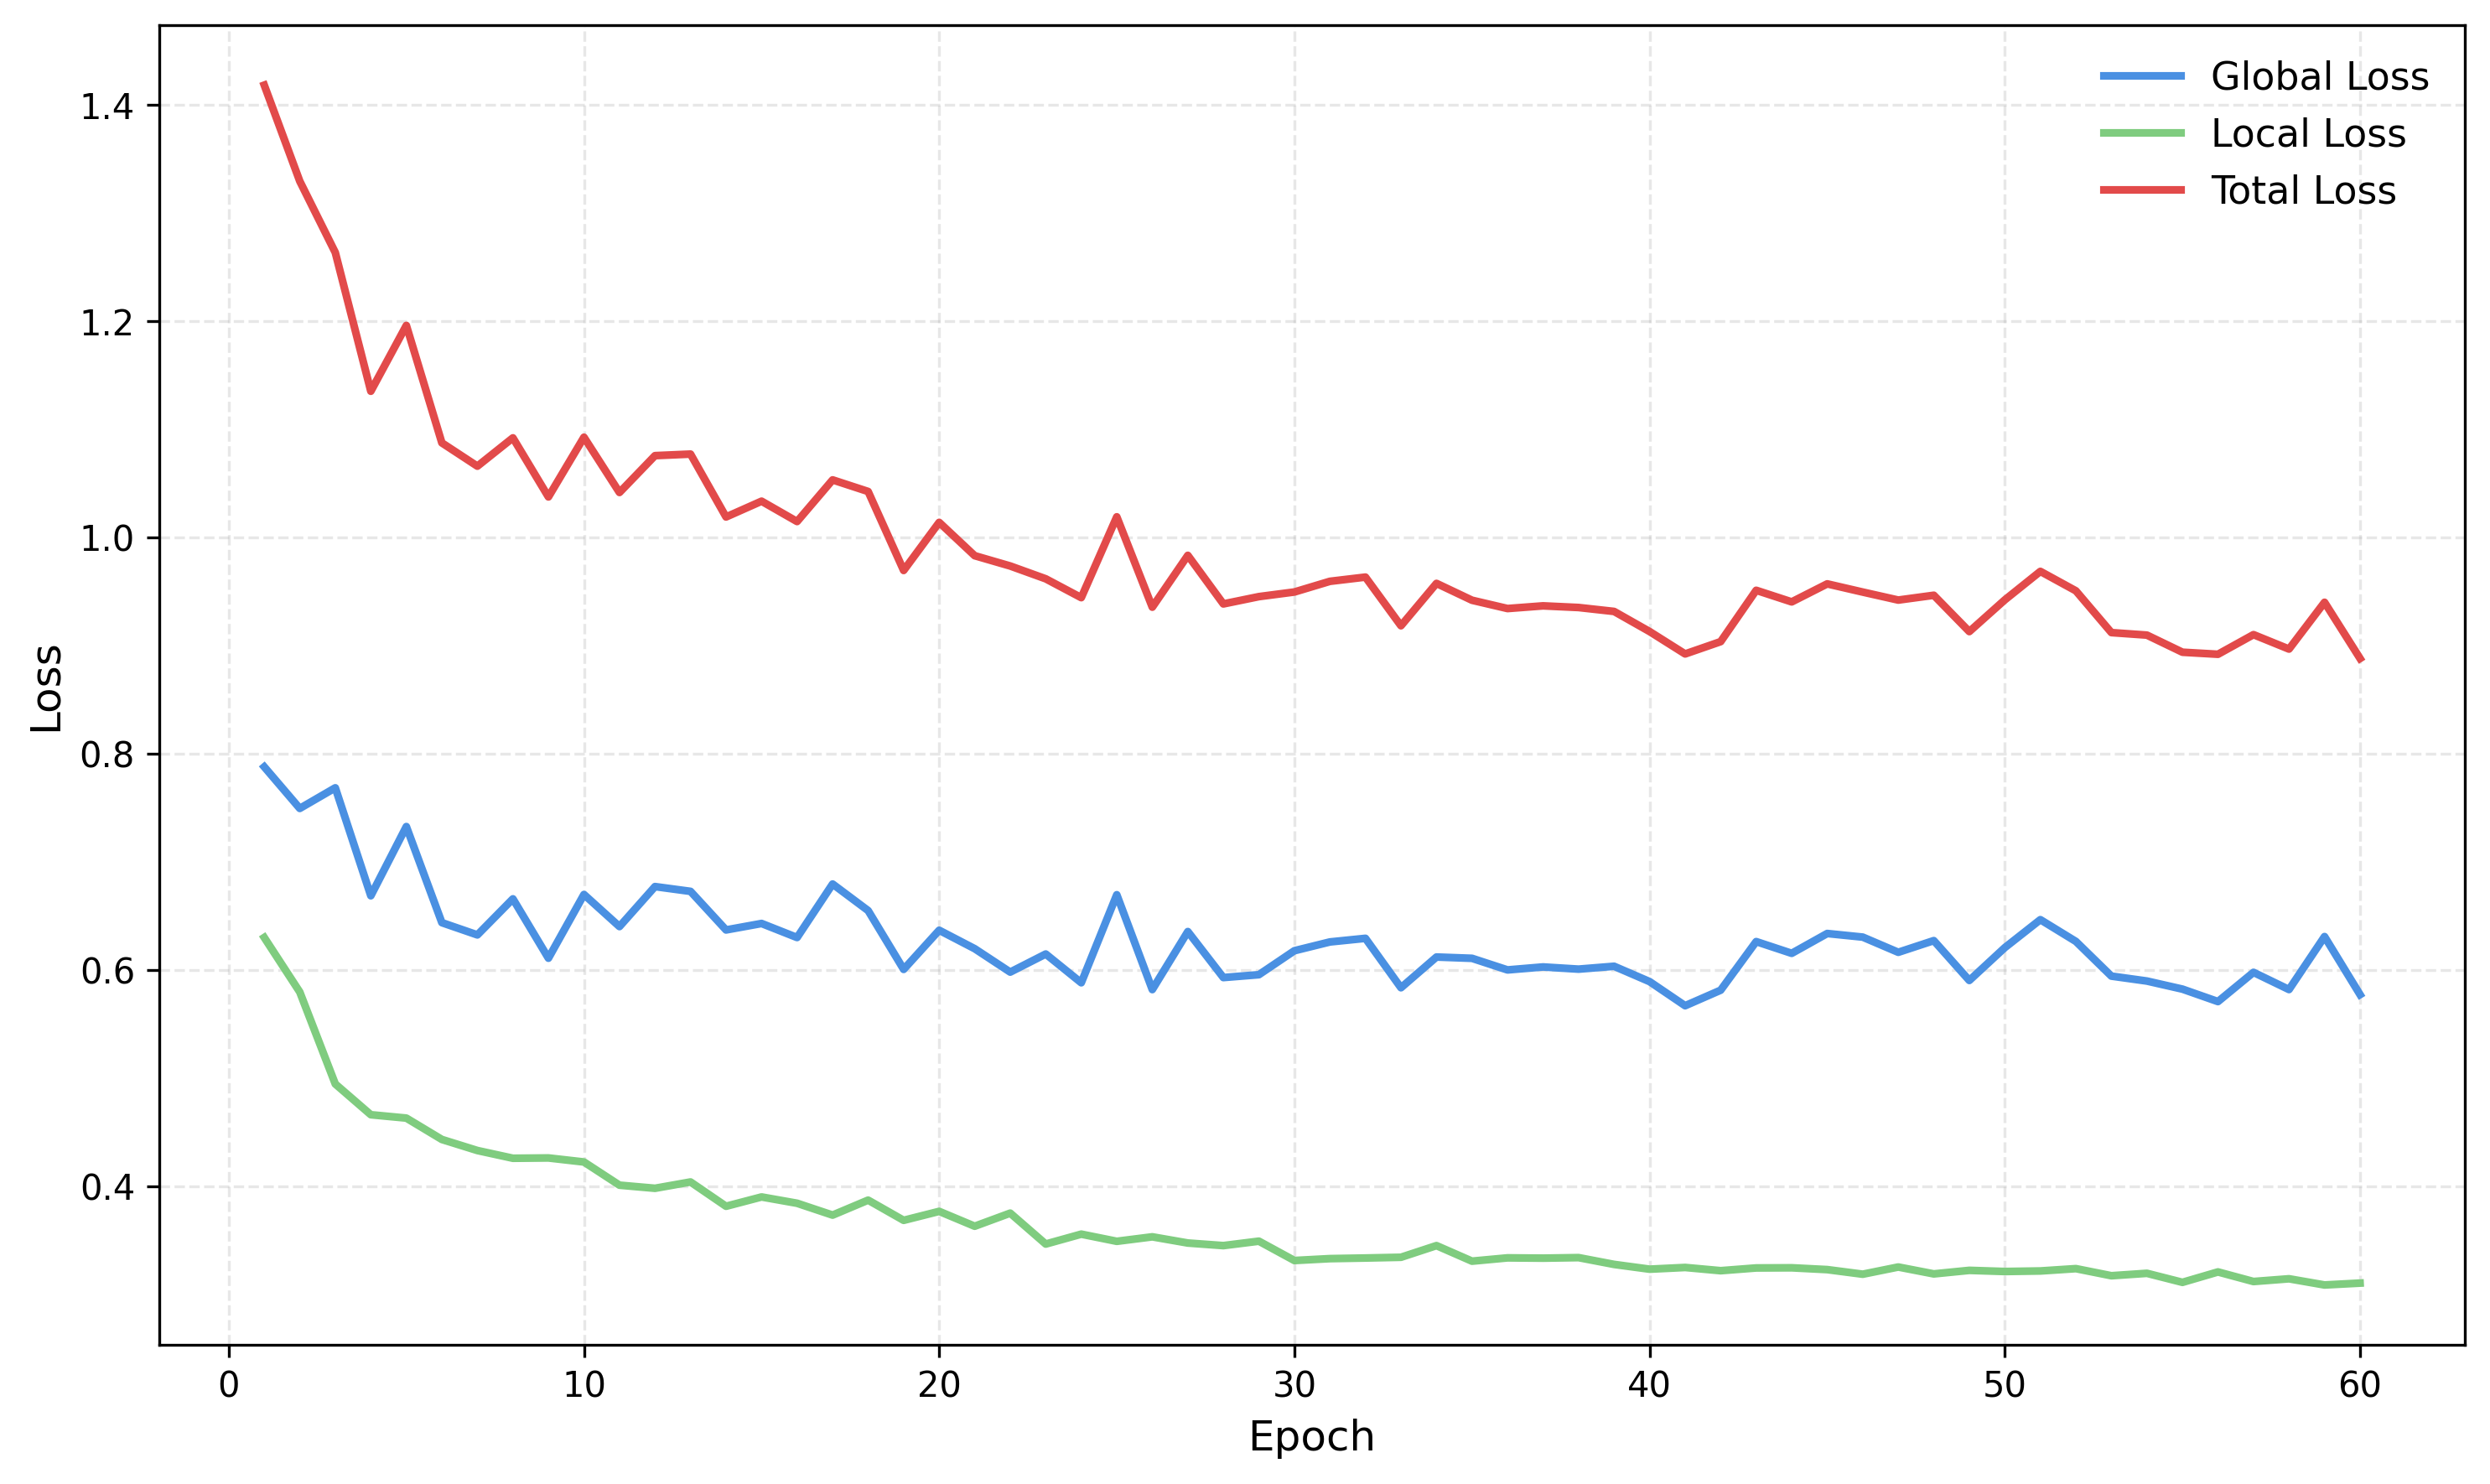

In [ ]:
import matplotlib.pyplot as plt

def plot_distill_losses(global_losses, local_losses, save_path=None):
    # convert to cpu numpy if tensors
    global_losses = [x.detach().cpu().item() if hasattr(x, "detach") else x for x in global_losses]
    local_losses  = [x.detach().cpu().item() if hasattr(x, "detach") else x for x in local_losses]

    # total = global + local
    total_losses = [g + l for g, l in zip(global_losses, local_losses)]

    epochs = list(range(1, len(global_losses) + 1))

    plt.figure(figsize=(10, 6), dpi=300)

    plt.plot(epochs, global_losses, linewidth=2.2,
             label="Global Loss", color="#4A90E2")
    plt.plot(epochs, local_losses, linewidth=2.2,
             label="Local Loss", color="#7FCC7F")
    plt.plot(epochs, total_losses, linewidth=2.2,
             label="Total Loss", color="#E24A4A")  # New red line

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(frameon=False, fontsize=11)
    #plt.title("Distillation Loss Trend", fontsize=15, fontweight="bold")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"📁 Saved loss plot to {save_path}")

    plt.show()


plot_distill_losses(global_losses, local_losses, "distill_loss_curve.png")


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import TSNE
import cv2
import matplotlib as mpl

# -----------------------------
# Global plotting style
# -----------------------------
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = '#D9D9D9'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Roboto']
mpl.rcParams['axes.titleweight'] = 'medium'
mpl.rcParams['axes.titlepad'] = 12

# ==========================================================
# 1. Visualize Validation Predictions (Minimalist)
# ==========================================================
def visualize_validation_predictions(model, dataloader, device, n=5):
    """
    Visualize model predictions on validation set with connected-component refinement.
    """
    model.eval()
    shown = 0

    with torch.no_grad():
        for batch in dataloader:
            if shown >= n:
                break

            support_img = batch["support_image"].to(device)
            support_mask = batch["support_mask"].float().to(device)
            query_img = batch["query_image"].to(device)
            query_mask = batch["query_mask"].float().to(device)

            outputs = model(support_img, support_mask, query_img)
            sim_map = outputs["sim_map"]  # [B, 2, H, W], Assuming this is ALREADY Softmax/Probabilities

            batch_size = sim_map.shape[0]

            # -----------------------------
            # Connected Component Refinement
            # -----------------------------
            refined_maps = []
            for b in range(batch_size):
                # 1. Get raw probabilities and hard predictions
                foreground_prob = sim_map[b, 1]
                pred_labels = torch.argmax(sim_map[b], dim=0)

                # 2. Convert to numpy for CCA
                pred_np = pred_labels.cpu().numpy().astype(np.uint8)
                # Ensure binary (just in case)
                foreground_mask = (pred_np == 1).astype(np.uint8)

                num_labels, labels_map = cv2.connectedComponents(foreground_mask, connectivity=8)

                # If nothing detected or only 1 component, skip refinement
                if num_labels <= 2: # 0 is bg, 1 is the first component. If num_labels=2, there is only 1 object.
                    refined_maps.append(sim_map[b:b+1])
                    continue

                best_component = 0
                max_score = -1.0

                # Pre-calculate total area if you want to match the exact reference formula
                # But for ranking, we only need the numerator (Mass).
                # total_area = foreground_mask.sum()

                for component_id in range(1, num_labels):
                    # Create a boolean mask for this specific component
                    component_mask = (labels_map == component_id)

                    # Get probabilities falling ONLY inside this component
                    # We don't need to convert the mask to tensor yet if we index numpy-to-tensor
                    # But for consistency with your device:
                    component_mask_tensor = torch.from_numpy(component_mask).to(sim_map.device)

                    # ---------------------------------------------------------
                    # THE FIX: Calculate Probability Mass (Sum), not Average
                    # ---------------------------------------------------------
                    # Sum of probabilities of all pixels in this component
                    score = foreground_prob[component_mask_tensor].sum()

                    # NOTE: If you strictly want the formula: Sum / (Total_Area + epsilon)
                    # score = score / (total_area + 1e-6)
                    # Mathematically, since Total_Area is constant for all components in this loop,
                    # comparing the Sum is identical to comparing the Fractions.

                    if score > max_score:
                        max_score = score
                        best_component = component_id

                # 3. Create the Refined Masks
                refined_mask = torch.from_numpy(labels_map == best_component).float().to(sim_map.device)
                inverse_mask = 1.0 - refined_mask

                # 4. Update the Sim Map
                # We want to force non-best pixels to be Background (Channel 0 = 1.0, Channel 1 = 0.0)
                refined_sim_map = sim_map[b].clone()

                # Foreground channel: Keep only the best component
                refined_sim_map[1] = refined_sim_map[1] * refined_mask

                # Background channel:
                # Logic: If pixel is in refined_mask, keep original bg prob (usually low).
                # If pixel is NOT in refined_mask (it was noise), set bg prob to 1.0.
                refined_sim_map[0] = refined_sim_map[0] * refined_mask + inverse_mask

                refined_maps.append(refined_sim_map.unsqueeze(0))

            # Re-stack
            sim_map = torch.cat(refined_maps, dim=0)

            # ---------------------------------------------------------
            # THE FIX: Do not Softmax again if input was already Softmax
            # ---------------------------------------------------------
            pred_softmax = sim_map # It remains probabilities
            pred_mask = torch.argmax(pred_softmax, dim=1)

            # -----------------------------
            # Minimalist Visualization
            # -----------------------------
            B = support_img.shape[0]
            for b in range(B):
                if shown >= n:
                    break

                fig, axes = plt.subplots(1, 5, figsize=(22, 5))
                plt.subplots_adjust(wspace=0.3)

                titles = [
                    "Support + Mask",
                    "Query Image",
                    "Ground Truth",
                    "Predicted Prob (FG)",
                    "Refined Pred Mask",
                ]

                # Panel function
                def draw_panel(ax, base, overlay=None, overlay_color="#4A90E2"):
                    ax.imshow(base, cmap="gray")
                    if overlay is not None:
                        overlay_rgba = np.zeros((*overlay.shape, 4))
                        overlay_rgba[..., 0] = int(overlay_color[1:3], 16)/255
                        overlay_rgba[..., 1] = int(overlay_color[3:5], 16)/255
                        overlay_rgba[..., 2] = int(overlay_color[5:7], 16)/255
                        overlay_rgba[..., 3] = overlay * 0.45
                        ax.imshow(overlay_rgba)
                    ax.set_xticks([]); ax.set_yticks([])
                    for spine in ax.spines.values():
                        spine.set_edgecolor("#D9D9D9")
                        spine.set_linewidth(1.0)

                draw_panel(axes[0], support_img[b,0].cpu(), support_mask[b,0].cpu(), "#7FCC7F")  # soft green for support mask
                draw_panel(axes[1], query_img[b,0].cpu())
                draw_panel(axes[2], query_img[b,0].cpu(), query_mask[b,0].cpu(), "#4A90E2")      # GT in soft blue
                draw_panel(axes[3], query_img[b,0].cpu(), pred_softmax[b,1].cpu(), "#FF9E9E")    # Pred prob FG
                draw_panel(axes[4], query_img[b,0].cpu(), pred_mask[b].cpu().float(), "#FF9E9E") # Refined pred mask

                for ax, title in zip(axes, titles):
                    ax.set_title(title, fontsize=14, fontweight="medium", color="#333333")

                plt.tight_layout()
                plt.show()
                shown += 1

# ==========================================================
# 2. TSNE Visualization (Minimalist)
# ==========================================================
def visualize_feature_space_with_prototypes(model, dataloader, device, epoch, n_samples=3):
    """
    Minimalist TSNE plot of feature embeddings with prototype refinement arrows.
    Clean technical-documentation visual style.
    """
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    import numpy as np
    import torch.nn.functional as F
    import torch

    # -----------------------------
    # Minimalist Global Style
    # -----------------------------
    import matplotlib as mpl
    mpl.rcParams['figure.facecolor'] = 'white'
    mpl.rcParams['axes.facecolor'] = 'white'
    mpl.rcParams['axes.edgecolor'] = '#D9D9D9'
    mpl.rcParams['axes.linewidth'] = 0.8
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Roboto', 'Arial']
    mpl.rcParams['axes.titleweight'] = 'medium'
    mpl.rcParams['lines.linewidth'] = 1.0

    # Soft, professional palette
    COLOR_FG = "#4A90E2"       # light blue
    COLOR_BG = "#999999"       # soft gray
    COLOR_FG_PROTO = "#003E7E" # dark blue
    COLOR_BG_PROTO = "#555555" # dark gray

    model.eval()
    sample_idx = 0

    with torch.no_grad():
        for batch in dataloader:
            if sample_idx >= n_samples:
                break

            b = 0
            support_img = batch["support_image"][b:b+1].to(device)
            support_mask = batch["support_mask"][b:b+1].float().to(device)
            query_img = batch["query_image"][b:b+1].to(device)

            outputs = model(support_img, support_mask, query_img)
            support_feats = outputs["support_feat"]

            proto_list = outputs["proto_list"]
            refined_proto_list = outputs["refined_proto_list"]

            B, C, H, W = support_feats.shape

            def flatten_feat(x):
                return x.permute(0,2,3,1).reshape(-1,C).cpu().numpy()

            support_feats_flat = flatten_feat(support_feats)

            mask = F.interpolate(support_mask, size=(H,W), mode="nearest")
            mask_flat = mask.permute(0,2,3,1).reshape(-1).cpu().numpy()

            fg_features = support_feats_flat[mask_flat > 0.95]
            bg_features = support_feats_flat[mask_flat <= 0.05]

            fg_proto, bg_proto = proto_list[0]
            fg_proto_refined, bg_proto_refined = refined_proto_list[0]

            fg_proto_all = fg_proto.detach().cpu().numpy() if fg_proto.numel() > 0 else np.zeros((0,C))
            bg_proto_all = bg_proto.detach().cpu().numpy() if bg_proto.numel() > 0 else np.zeros((0,C))
            fg_proto_refined_all = fg_proto_refined.detach().cpu().numpy() if fg_proto_refined.numel() > 0 else np.zeros((0,C))
            bg_proto_refined_all = bg_proto_refined.detach().cpu().numpy() if bg_proto_refined.numel() > 0 else np.zeros((0,C))

            # Subsample for clarity
            max_per_class = 1200
            if len(fg_features) > max_per_class:
                fg_features = fg_features[np.random.choice(len(fg_features), max_per_class, replace=False)]
            if len(bg_features) > max_per_class:
                bg_features = bg_features[np.random.choice(len(bg_features), max_per_class, replace=False)]

            if fg_proto_all.shape[0] == 0 or bg_proto_all.shape[0] == 0:
                sample_idx += 1
                continue

            combined = np.concatenate(
                [fg_features, bg_features,
                 fg_proto_all, bg_proto_all,
                 fg_proto_refined_all, bg_proto_refined_all],
                axis=0
            )

            tsne = TSNE(
                n_components=2,
                metric="cosine",
                random_state=42,
                perplexity=min(30, combined.shape[0]-1),
                n_iter=1000,
                learning_rate="auto",
                init="random"
            )
            proj = tsne.fit_transform(combined)

            n_fg, n_bg = len(fg_features), len(bg_features)
            n_fg_p, n_bg_p = len(fg_proto_all), len(bg_proto_all)
            n_fg_pr, n_bg_pr = len(fg_proto_refined_all), len(bg_proto_refined_all)

            fg_proj = proj[:n_fg]
            bg_proj = proj[n_fg:n_fg+n_bg]

            offset = n_fg + n_bg
            fg_p_proj = proj[offset:offset+n_fg_p]
            bg_p_proj = proj[offset+n_fg_p:offset+n_fg_p+n_bg_p]
            fg_pr_proj = proj[offset+n_fg_p+n_bg_p:offset+n_fg_p+n_bg_p+n_fg_pr]
            bg_pr_proj = proj[offset+n_fg_p+n_bg_p+n_fg_pr:]

            # -----------------------------
            # Clean Minimalist Scatter Plot
            # -----------------------------
            plt.figure(figsize=(9,7), dpi=300)

            # Main features (very soft colors)
            plt.scatter(bg_proj[:,0], bg_proj[:,1], s=6, c=COLOR_BG, alpha=0.25, label="BG Features")
            plt.scatter(fg_proj[:,0], fg_proj[:,1], s=6, c=COLOR_FG, alpha=0.25, label="FG Features")

            # Arrows for refinement (thin, geometric)
            for i in range(min(len(fg_p_proj), len(fg_pr_proj))):
                plt.arrow(
                    fg_p_proj[i,0], fg_p_proj[i,1],
                    fg_pr_proj[i,0] - fg_p_proj[i,0],
                    fg_pr_proj[i,1] - fg_p_proj[i,1],
                    width=0.08,
                    head_width=0.9,
                    head_length=0.9,
                    color=COLOR_FG_PROTO,
                    alpha=0.55,
                    length_includes_head=True
                )

            for i in range(min(len(bg_p_proj), len(bg_pr_proj))):
                plt.arrow(
                    bg_p_proj[i,0], bg_p_proj[i,1],
                    bg_pr_proj[i,0] - bg_p_proj[i,0],
                    bg_pr_proj[i,1] - bg_p_proj[i,1],
                    width=0.08,
                    head_width=0.9,
                    head_length=0.9,
                    color=COLOR_BG_PROTO,
                    alpha=0.55,
                    length_includes_head=True
                )

            # Prototype markers (clean, bold)
            plt.scatter(fg_p_proj[:,0], fg_p_proj[:,1], s=110,
                        c=COLOR_FG, marker="o", edgecolors="#333333",
                        linewidths=1.0, label="FG Proto (Init)", zorder=4)

            plt.scatter(bg_p_proj[:,0], bg_p_proj[:,1], s=110,
                        c=COLOR_BG, marker="o", edgecolors="#333333",
                        linewidths=1.0, label="BG Proto (Init)", zorder=4)

            plt.scatter(fg_pr_proj[:,0], fg_pr_proj[:,1], s=130,
                        c=COLOR_FG_PROTO, marker="X", edgecolors="#000000",
                        linewidths=1.0, label="FG Proto (Refined)", zorder=5)

            plt.scatter(bg_pr_proj[:,0], bg_pr_proj[:,1], s=130,
                        c=COLOR_BG_PROTO, marker="X", edgecolors="#000000",
                        linewidths=1.0, label="BG Proto (Refined)", zorder=5)

            # Titles & labels
            plt.title(
                f"T-SNE Feature Space — Epoch {epoch}, Sample {sample_idx+1}",
                fontsize=15, fontweight="medium", pad=10, color="#222222"
            )
            plt.xlabel("TSNE Dim 1", fontsize=12, color="#333333")
            plt.ylabel("TSNE Dim 2", fontsize=12, color="#333333")

            # Legend (clean box)
            plt.legend(
                frameon=True,
                fontsize=10,
                facecolor="white",
                edgecolor="#D9D9D9"
            )

            plt.grid(True, linestyle="--", alpha=0.25)
            plt.tight_layout()
            plt.show()

            sample_idx += 1



# ==========================================================
# Helper: Print Prototype Statistics
# ==========================================================
def print_prototype_stats(proto_list, refined_proto_list, epoch):
    """Print statistics about prototypes for debugging."""
    print(f"\n[Epoch {epoch}] Prototype Statistics:")
    print("=" * 60)

    for i, ((fg, bg), (fg_r, bg_r)) in enumerate(zip(proto_list, refined_proto_list)):
        print(f"  Sample {i}:")
        print(f"    Initial  - FG: {fg.shape if fg is not None else 'None'}, "
              f"BG: {bg.shape if bg is not None else 'None'}")
        print(f"    Refined  - FG: {fg_r.shape if fg_r is not None else 'None'}, "
              f"BG: {bg_r.shape if bg_r is not None else 'None'}")
    print("=" * 60)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import TSNE
import cv2


# ==========================================================
# Liver Sample Tracker Class
# ==========================================================
class LiverSampleTracker:
    """
    Tracks specific liver samples across epochs and stores feature data
    for visualization at specified checkpoints.
    """
    def __init__(self, target_epochs=[5, 10, 15, 20], num_samples=1):
        self.target_epochs = target_epochs
        self.num_samples = num_samples
        self.tracked_samples = []  # List of samples
        self.tracked_features = {}  # {sample_idx: {epoch: feature_data}}
        self.samples_selected = False

    def select_liver_sample(self, dataloader, device):
        """
        Find and store liver samples from the validation set.
        """
        print("\n" + "="*60)
        print(f"🔍 Searching for {self.num_samples} liver sample(s) to track...")
        print("="*60)

        with torch.no_grad():
            for batch in dataloader:
                if len(self.tracked_samples) >= self.num_samples:
                    break

                organ_labels = batch.get("organ_label", None)
                dataset_names = batch.get("dataset", None)

                # Look for liver samples
                # CHAOS: organ_label=1 is Liver
                # SABS: organ_label=6 is Liver
                if organ_labels is not None:
                    for i in range(len(organ_labels)):
                        if len(self.tracked_samples) >= self.num_samples:
                            break

                        organ = organ_labels[i].item()
                        dataset = dataset_names[i] if isinstance(dataset_names, list) else dataset_names

                        is_liver = (dataset == "CHAOS" and organ == 1) or \
                                   (dataset == "SABS" and organ == 6)

                        if is_liver:
                            sample = {
                                "support_image": batch["support_image"][i:i+1].cpu(),
                                "support_mask": batch["support_mask"][i:i+1].cpu(),
                                "query_image": batch["query_image"][i:i+1].cpu(),
                                "query_mask": batch["query_mask"][i:i+1].cpu(),
                                "organ_label": organ,
                                "dataset": dataset,
                                "support_case_idx": batch["support_case_idx"][i].item(),
                                "query_case_idx": batch["query_case_idx"][i].item(),
                            }
                            self.tracked_samples.append(sample)
                            sample_idx = len(self.tracked_samples)
                            print(f"✅ Liver sample #{sample_idx} selected!")
                            print(f"   Dataset: {dataset}")
                            print(f"   Organ Label: {organ}")
                            print(f"   Support Case: {sample['support_case_idx']}")
                            print(f"   Query Case: {sample['query_case_idx']}")

        if self.tracked_samples:
            self.samples_selected = True
            print(f"\n✅ Total: {len(self.tracked_samples)} liver sample(s) selected")
            print("="*60 + "\n")
            return True
        else:
            print("❌ No liver samples found in validation set!")
            print("="*60 + "\n")
            return False

    def should_track(self, epoch):
        """Check if current epoch should be tracked."""
        return epoch in self.target_epochs

    def extract_features(self, model, device, epoch):
        """
        Extract and store feature representations for all tracked samples.
        """
        if not self.samples_selected:
            print(f"⚠️ Epoch {epoch}: No liver samples selected, skipping feature extraction")
            return

        if not self.should_track(epoch):
            return

        print(f"\n📊 Epoch {epoch}: Extracting features for {len(self.tracked_samples)} tracked liver sample(s)...")

        model.eval()
        with torch.no_grad():
            for sample_idx, sample in enumerate(self.tracked_samples):
                support_img = sample["support_image"].to(device)
                support_mask = sample["support_mask"].float().to(device)
                query_img = sample["query_image"].to(device)

                outputs = model(support_img, support_mask, query_img)

                support_feats = outputs["support_feat"]
                proto_list = outputs["proto_list"]
                refined_proto_list = outputs["refined_proto_list"]

                # Initialize sample dict if needed
                if sample_idx not in self.tracked_features:
                    self.tracked_features[sample_idx] = {}

                # Store feature data
                self.tracked_features[sample_idx][epoch] = {
                    "support_feats": support_feats.cpu(),
                    "proto_list": [(fg.cpu(), bg.cpu()) for fg, bg in proto_list],
                    "refined_proto_list": [(fg.cpu(), bg.cpu()) for fg, bg in refined_proto_list],
                    "support_mask": support_mask.cpu(),
                }

                print(f"   ✅ Sample #{sample_idx + 1}: Features extracted and stored")

        print(f"✅ All features extracted for epoch {epoch}")
    def visualize_all_epochs(self, save_path=None):
        """
        Minimalist visualization showing feature space evolution
        across all tracked epochs for all samples.
        """
        if not self.tracked_features:
            print("❌ No features tracked yet!")
            return

        epochs = sorted(self.target_epochs)
        n_epochs = len(epochs)

        print("\n" + "=" * 60)
        print(f"🎨 Creating feature space visualizations for {len(self.tracked_samples)} sample(s)...")
        print("=" * 60)

        # Global plotting style
        import matplotlib as mpl
        mpl.rcParams['figure.facecolor'] = 'white'
        mpl.rcParams['axes.facecolor'] = 'white'
        mpl.rcParams['axes.edgecolor'] = '#D9D9D9'
        mpl.rcParams['axes.linewidth'] = 1.0
        mpl.rcParams['font.family'] = 'sans-serif'
        mpl.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Roboto']
        mpl.rcParams['axes.titleweight'] = 'medium'
        mpl.rcParams['axes.titlepad'] = 10

        for sample_idx in range(len(self.tracked_samples)):
            if sample_idx not in self.tracked_features:
                print(f"⚠️ No features found for sample #{sample_idx + 1}, skipping...")
                continue

            sample_data = self.tracked_samples[sample_idx]
            print(f"\n📊 Processing Sample #{sample_idx + 1} ({sample_data['dataset']})...")

            fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi=300)
            axes = axes.flatten()

            for idx, epoch in enumerate(epochs):
                if idx >= 4:
                    break
                if epoch not in self.tracked_features[sample_idx]:
                    print(f"   ⚠️ Epoch {epoch} not found, skipping...")
                    continue

                ax = axes[idx]
                data = self.tracked_features[sample_idx][epoch]

                support_feats = data["support_feats"]
                proto_list = data["proto_list"]
                refined_proto_list = data["refined_proto_list"]
                support_mask = data["support_mask"]

                B, C, H, W = support_feats.shape
                support_feats_flat = support_feats.permute(0, 2, 3, 1).reshape(-1, C).numpy()
                mask = F.interpolate(support_mask, size=(H, W), mode="nearest")
                mask_flat = mask.permute(0, 2, 3, 1).reshape(-1).numpy()

                fg_features = support_feats_flat[mask_flat > 0.95]
                bg_features = support_feats_flat[mask_flat <= 0.05]

                fg_proto, bg_proto = proto_list[0]
                fg_proto_refined, bg_proto_refined = refined_proto_list[0]

                fg_proto_all = fg_proto.numpy() if fg_proto.numel() > 0 else np.zeros((0, C))
                bg_proto_all = bg_proto.numpy() if bg_proto.numel() > 0 else np.zeros((0, C))
                fg_proto_refined_all = fg_proto_refined.numpy() if fg_proto_refined.numel() > 0 else np.zeros((0, C))
                bg_proto_refined_all = bg_proto_refined.numpy() if bg_proto_refined.numel() > 0 else np.zeros((0, C))

                # Sample features for clarity
                max_per_class = 800
                if len(fg_features) > max_per_class:
                    fg_features = fg_features[np.random.choice(len(fg_features), max_per_class, replace=False)]
                if len(bg_features) > max_per_class:
                    bg_features = bg_features[np.random.choice(len(bg_features), max_per_class, replace=False)]

                combined = np.concatenate([
                    fg_features, bg_features,
                    fg_proto_all, bg_proto_all,
                    fg_proto_refined_all, bg_proto_refined_all
                ], axis=0)

                print(f"   Epoch {epoch}: Running TSNE on {combined.shape[0]} points...")
                tsne = TSNE(
                    n_components=2,
                    metric="cosine",
                    random_state=42,
                    perplexity=min(30, combined.shape[0] - 1),
                    n_iter=1000,
                    learning_rate="auto",
                    init="random"
                )
                proj = tsne.fit_transform(combined)

                # Split projections
                n_fg, n_bg = len(fg_features), len(bg_features)
                n_fg_p, n_bg_p = len(fg_proto_all), len(bg_proto_all)
                n_fg_pr, n_bg_pr = len(fg_proto_refined_all), len(bg_proto_refined_all)

                fg_proj = proj[:n_fg]
                bg_proj = proj[n_fg:n_fg + n_bg]
                offset = n_fg + n_bg
                fg_p_proj = proj[offset:offset + n_fg_p]
                bg_p_proj = proj[offset + n_fg_p:offset + n_fg_p + n_bg_p]
                fg_pr_proj = proj[offset + n_fg_p + n_bg_p:offset + n_fg_p + n_bg_p + n_fg_pr]
                bg_pr_proj = proj[offset + n_fg_p + n_bg_p + n_fg_pr:]

                # ==========================================================
                # Minimalist plotting (DeepMind / Google Docs Style)
                # ==========================================================
                ax.set_facecolor("white")
                ax.grid(True, linestyle=":", linewidth=0.6, color="#D9D9D9", alpha=0.6)

                # Feature clouds
                if len(bg_proj) > 0:
                    ax.scatter(bg_proj[:, 0], bg_proj[:, 1],
                        s=6, c="#A6A6A6", alpha=0.30, label="BG Features")
                if len(fg_proj) > 0:
                    ax.scatter(fg_proj[:, 0], fg_proj[:, 1],
                        s=6, c="#4A90E2", alpha=0.30, label="FG Features")

                # Arrows (refinement)
                for i in range(min(len(fg_p_proj), len(fg_pr_proj))):
                    ax.arrow(
                        fg_p_proj[i, 0], fg_p_proj[i, 1],
                        fg_pr_proj[i, 0] - fg_p_proj[i, 0],
                        fg_pr_proj[i, 1] - fg_p_proj[i, 1],
                        head_width=0.22, head_length=0.32,
                        linewidth=0.55,
                        fc="#4A90E2", ec="#4A90E2",
                        alpha=0.75, length_includes_head=True
                    )

                for i in range(min(len(bg_p_proj), len(bg_pr_proj))):
                    ax.arrow(
                        bg_p_proj[i, 0], bg_p_proj[i, 1],
                        bg_pr_proj[i, 0] - bg_p_proj[i, 0],
                        bg_pr_proj[i, 1] - bg_p_proj[i, 1],
                        head_width=0.22, head_length=0.32,
                        linewidth=0.55,
                        fc="#7F7F7F", ec="#7F7F7F",
                        alpha=0.70, length_includes_head=True
                    )

                # Prototypes (triangle = init, square = refined)
                if len(fg_p_proj) > 0:
                    ax.scatter(
                        fg_p_proj[:, 0], fg_p_proj[:, 1],
                        s=65, c="white",
                        marker="o", edgecolors="#4A90E2",
                        linewidths=1.0, label="FG Proto (Init)", zorder=5
                    )
                if len(bg_p_proj) > 0:
                    ax.scatter(
                        bg_p_proj[:, 0], bg_p_proj[:, 1],
                        s=65, c="white",
                        marker="o", edgecolors="#A6A6A6",
                        linewidths=1.0, label="BG Proto (Init)", zorder=5
                    )
                if len(fg_pr_proj) > 0:
                    ax.scatter(
                        fg_pr_proj[:, 0], fg_pr_proj[:, 1],
                        s=50, c="#4A90E2",
                        marker="X", edgecolors="black",
                        linewidths=0.8, label="FG Proto (Refined)", zorder=6
                    )
                if len(bg_pr_proj) > 0:
                    ax.scatter(
                        bg_pr_proj[:, 0], bg_pr_proj[:, 1],
                        s=50, c="#7F7F7F",
                        marker="X", edgecolors="black",
                        linewidths=0.8, label="BG Proto (Refined)", zorder=6
                    )

                # Labels
                ax.set_title(f"Epoch {epoch}", fontsize=12.5, fontweight="medium", pad=8)
                ax.set_xlabel("TSNE Dim 1", fontsize=10)
                ax.set_ylabel("TSNE Dim 2", fontsize=10)

                # Legend
                legend = ax.legend(
                    frameon=True, fontsize=7,
                    edgecolor="#D9D9D9", facecolor="white"
                )
                legend.get_frame().set_linewidth(0.6)

                # Soft axis borders
                for spine in ax.spines.values():
                    spine.set_edgecolor("#D9D9D9")
                    spine.set_linewidth(0.8)

            dataset_name = sample_data["dataset"]
            case_id = sample_data["support_case_idx"]
            plt.suptitle(
                f"Sample #{sample_idx + 1} Feature Space Evolution "
                f"({dataset_name}, Case {case_id})",
                fontsize=16, fontweight="medium", y=0.995
            )
            plt.tight_layout()
            plt.show()
            print(f"   ✅ Visualization displayed for Sample #{sample_idx + 1}")

        print("=" * 60 + "\n")


# ==========================================================
# Modified Training Loop with Tracking
# ==========================================================
def train_with_liver_tracking(model, train_loader, val_loader, optimizer, scheduler,
                              device, num_epochs=32, num_samples=1):
    """
    Training loop with liver sample tracking at specific epochs.

    Args:
        num_samples: Number of liver samples to track (default: 1)
    """
    # Initialize tracker with specified number of samples
    tracker = LiverSampleTracker(target_epochs=[5, 10, 20, 40], num_samples=num_samples)

    # Select liver sample before training
    if not tracker.select_liver_sample(val_loader, device):
        print("⚠️ Warning: Could not find liver samples. Proceeding without tracking.")

    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        train_loss = train_one_epoch(model, train_loader, optimizer, device)

        # Validation phase
        model.eval()
        val_loss = evaluate(model, val_loader, device)

        print(f"Epoch {epoch}: train={train_loss:.4f}, val={val_loss:.4f}")
        scheduler.step()

        # Extract features for tracked liver sample at specific epochs
        tracker.extract_features(model, device, epoch)


        visualize_validation_predictions(model, val_loader, device, n=3)
        visualize_feature_space_with_prototypes(model, val_loader, device, epoch, n_samples=3)
    # After training, create comprehensive visualization
    print("\n" + "="*60)
    print("🎬 Training Complete! Creating final visualization...")
    print("="*60)
    tracker.visualize_all_epochs()  # Only display, no save
    Encoder.save_weights("final.pt")
    return tracker


# ==========================================================
# Example Usage
# ==========================================================

# In your main training script:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_epochs = 125
lr = 1e-3

# SOTA weight decay used in transformer + segmentation literature
weight_decay = 0.01


model = ProtoSegNet(Encoder, use_refiner=True).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
    betas=(0.9, 0.999),              # SOTA default
    eps=1e-8                        # stable for mixed FP16/FP32
)

# LR step-down at 1/4, 1/2, and 3/4 of training
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[10, 20, 30],
    gamma=0.5
)

# Train with liver sample tracking - track multiple samples
tracker = train_with_liver_tracking(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs= 125,
    num_samples=5  # Track 3 different liver samples
)

# The visualizations will be automatically displayed (not saved)
# One figure per sample, each showing 4 epochs (5, 10, 15, 20)


In [ ]:
import os

# Check if dataset folder or zip file already exists
if not os.path.exists("inference-data.zip"):
    print("Downloading dataset from Kaggle...")
    !kaggle datasets download khiem20092004/inference-data
    !unzip -q inference-data.zip
else:
    print("✅ Dataset already exists — skipping download and unzip.")

!mv /content/class_map.json /content/inference-data
!mv /content/images /content/inference-data


Dataset URL: https://www.kaggle.com/datasets/khiem20092004/inference-data
License(s): apache-2.0
  0% 0.00/31.2M [00:00<?, ?B/s]
100% 31.2M/31.2M [00:00<00:00, 1.58GB/s]


In [ ]:
import os
import json
import cv2
import torch
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import torch.nn.functional as F
from PIL import Image

# Constants
IMAGE_SIZE = 256
DATA_ROOT = Path("/content/inference-data")
IMAGES_DIR = DATA_ROOT / "images/images"
CLASS_MAP_PATH = DATA_ROOT / "class_map.json"
ORGAN_DIRS = ["liver", "lk", "rk", "spleen"]
Encoder.load_state_dict(torch.load("/content/final.pt", map_location=device))
# Organ to Label Mapping (CHAOS + SABS)
# Liver: 1 (CHAOS), 6 (SABS)
# Left Kidney: 3 (CHAOS, SABS)
# Right Kidney: 2 (CHAOS, SABS)
# Spleen: 4 (CHAOS), 1 (SABS)
ORGAN_LABEL_MAP = {
    "liver": [1, 6],
    "lk": [3],
    "rk": [2],
    "spleen": [4, 1]
}

def normalize_image(array):
    """Standard score normalization matching the training loader."""
    mean = array.mean()
    std = array.std()
    if std < 1e-8:
        return np.zeros_like(array, dtype=np.float32)
    return ((array - mean) / std).astype(np.float32)

def preprocess_slice(img_slice, is_mask=False):
    """Resize and convert to tensor."""
    # Resize to 256x256
    if is_mask:
        # Nearest neighbor for masks
        img_resized = cv2.resize(img_slice, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        tensor = torch.from_numpy(img_resized).long().unsqueeze(0) # [1, H, W]
    else:
        # Bilinear for images
        img_resized = cv2.resize(img_slice, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        tensor = torch.from_numpy(img_resized).float().unsqueeze(0) # [1, H, W]
    return tensor

def load_nifti_slice(patient_id, slice_idx, organ_name, images_dir):
    """Load specific slice from NIfTI volumes using SimpleITK."""
    img_path = images_dir / f"image_{patient_id}.nii"
    lbl_path = images_dir / f"label_{patient_id}.nii"

    if not img_path.exists() or not lbl_path.exists():
        print(f"  ⚠️ Missing NIfTI files for patient {patient_id}")
        return None, None

    # Load volumes using SimpleITK
    # ReadImage returns the image object
    img_itk = sitk.ReadImage(str(img_path))
    lbl_itk = sitk.ReadImage(str(lbl_path))

    # GetArrayFromImage returns numpy array in [z, y, x] order
    # Transpose to [y, x, z] as requested
    img_vol = sitk.GetArrayFromImage(img_itk).transpose(1, 2, 0)
    lbl_vol = sitk.GetArrayFromImage(lbl_itk).transpose(1, 2, 0)

    # Extract Slice
    try:
        # slice_idx refers to the z-axis (now the last dimension)
        img_slice = img_vol[:, :, slice_idx].astype(np.float32)
        lbl_slice = lbl_vol[:, :, slice_idx].astype(np.uint8)
    except IndexError:
        print(f"  ⚠️ Slice {slice_idx} out of bounds for patient {patient_id}")
        return None, None

    # Filter Label for specific organ
    target_labels = ORGAN_LABEL_MAP.get(organ_name, [])
    mask = np.isin(lbl_slice, target_labels).astype(np.uint8)

    return img_slice, mask

def run_inference():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Load Class Map
    if not CLASS_MAP_PATH.exists():
        print("❌ class_map.json not found!")
        return

    with open(CLASS_MAP_PATH, 'r') as f:
        class_map = json.load(f)

    print(f"🚀 Starting Inference on {device}...")

    for organ in ORGAN_DIRS:
        organ_path = DATA_ROOT / organ
        if not organ_path.exists():
            continue

        print(f"\n📂 Processing Organ: {organ}")
        sample_folders = sorted([d for d in organ_path.iterdir() if d.is_dir()])

        for sample_dir in sample_folders:
            print(f"  🔹 Sample: {sample_dir.name}")
            parts = sample_dir.name.split('_')
            if len(parts) < 4:
                print(f"     Skipping invalid folder name format.")
                continue

            # Parse Query Info
            q_patient_id = parts[0]
            q_slice_idx = int(parts[1])

            # Parse Support Info
            if organ not in class_map or sample_dir.name not in class_map[organ]:
                print(f"     ⚠️ Missing info in class_map.json")
                continue

            sample_data = class_map[organ][sample_dir.name]
            support_info = sample_data.get('supprort', sample_data.get('support', None))
            if support_info is None:
                print(f"     ⚠️ Support info missing for {sample_dir.name}")
                continue

            s_patient_id = str(support_info['patientId'])
            s_slice_idx = int(support_info['zId'])

            # Load Data
            q_img_raw, q_mask_raw = load_nifti_slice(q_patient_id, q_slice_idx, organ, IMAGES_DIR)
            s_img_raw, s_mask_raw = load_nifti_slice(s_patient_id, s_slice_idx, organ, IMAGES_DIR)
            if q_img_raw is None or s_img_raw is None:
                continue

            # Preprocess
            q_img_tensor = preprocess_slice(normalize_image(q_img_raw), is_mask=False).unsqueeze(0).to(device)
            s_img_tensor = preprocess_slice(normalize_image(s_img_raw), is_mask=False).unsqueeze(0).to(device)
            q_mask_tensor = preprocess_slice(q_mask_raw, is_mask=True).unsqueeze(0).to(device)
            s_mask_tensor = preprocess_slice(s_mask_raw, is_mask=True).unsqueeze(0).to(device)

            # Inference
            with torch.no_grad():
                outputs = model(s_img_tensor, s_mask_tensor, q_img_tensor)
                sim_map = outputs['sim_map']  # [B, 2, H, W]

                # -----------------------------
                # Connected Component Refinement
                # -----------------------------
                refined_maps = []
                batch_size = sim_map.shape[0]
                pred_softmax = torch.softmax(sim_map, dim=1)

                for b in range(batch_size):
                    foreground_prob = pred_softmax[b, 1]
                    pred_labels = torch.argmax(sim_map[b], dim=0)

                    pred_np = pred_labels.cpu().numpy().astype(np.uint8)
                    foreground_mask = (pred_np == 1).astype(np.uint8)
                    num_labels, labels_map = cv2.connectedComponents(foreground_mask)

                    if num_labels <= 1:
                        refined_maps.append(sim_map[b:b+1])
                        continue

                    best_component = 0
                    max_confidence = -1.0

                    for component_id in range(1, num_labels):
                        component_mask = (labels_map == component_id)
                        component_mask_tensor = torch.from_numpy(component_mask).to(sim_map.device)

                        p_i = foreground_prob[component_mask_tensor]
                        y_hat_i = pred_labels[component_mask_tensor].float()
                        numerator = (p_i * y_hat_i).sum()
                        denominator = y_hat_i.sum().clamp_min(1e-6)
                        confidence = numerator / denominator

                        if confidence > max_confidence:
                            max_confidence = confidence
                            best_component = component_id

                    refined_mask = torch.from_numpy(labels_map == best_component).float().to(sim_map.device)
                    inverse_mask = 1.0 - refined_mask

                    refined_sim_map = sim_map[b].clone()
                    refined_sim_map[1] = refined_sim_map[1] * refined_mask
                    refined_sim_map[0] = refined_sim_map[0] * refined_mask + inverse_mask

                    refined_maps.append(refined_sim_map.unsqueeze(0))

                sim_map = torch.cat(refined_maps, dim=0)
                pred_softmax = F.softmax(sim_map, dim=1)
                pred_mask = torch.argmax(pred_softmax, dim=1)  # [B, H, W]

            # Save Prediction
            pred_np = pred_mask[0].cpu().numpy().astype(np.uint8) * 255
            logo_dir = sample_dir / "LoGo"
            logo_dir.mkdir(exist_ok=True)
            save_path = logo_dir / "prediction_mask.png"
            cv2.imwrite(str(save_path), pred_np)
            print(f"     ✅ Saved: {save_path}")


# Run the pipeline
run_inference()

🚀 Starting Inference on cuda...

📂 Processing Organ: liver
  🔹 Sample: 10_14_47_1
     ✅ Saved: /content/inference-data/liver/10_14_47_1/LoGo/prediction_mask.png
  🔹 Sample: 10_16_49_1
     ✅ Saved: /content/inference-data/liver/10_16_49_1/LoGo/prediction_mask.png
  🔹 Sample: 10_22_57_1
     ✅ Saved: /content/inference-data/liver/10_22_57_1/LoGo/prediction_mask.png
  🔹 Sample: 10_27_60_1
     ✅ Saved: /content/inference-data/liver/10_27_60_1/LoGo/prediction_mask.png
  🔹 Sample: 10_28_61_1
     ✅ Saved: /content/inference-data/liver/10_28_61_1/LoGo/prediction_mask.png
  🔹 Sample: 10_29_62_1
     ✅ Saved: /content/inference-data/liver/10_29_62_1/LoGo/prediction_mask.png
  🔹 Sample: 13_16_86_1
     ✅ Saved: /content/inference-data/liver/13_16_86_1/LoGo/prediction_mask.png
  🔹 Sample: 13_17_87_1
     ✅ Saved: /content/inference-data/liver/13_17_87_1/LoGo/prediction_mask.png

📂 Processing Organ: lk
  🔹 Sample: 10_15_49_1
     ✅ Saved: /content/inference-data/lk/10_15_49_1/LoGo/prediction_ma

In [ ]:

import shutil
from google.colab import files

# Create zip file of inference results
print("📦 Zipping inference results...")
shutil.make_archive('inference_results', 'zip', '/content/inference-data')
print("✅ Created inference_results.zip")

# Download the zip file
print("⬇️ Downloading inference_results.zip...")
files.download('inference_results.zip')
print("✅ Download complete!")

📦 Zipping inference results...
✅ Created inference_results.zip
⬇️ Downloading inference_results.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download complete!


Starting visualization of comparison figures...

--- Loading samples for organ: liver ---
 Loading sample: 10_14_47_1
 Loading sample: 10_16_49_1
 Loading sample: 10_22_57_1
 Loading sample: 10_27_60_1
 Loading sample: 10_28_61_1
 Loading sample: 10_29_62_1
 Loading sample: 13_16_86_1
 Loading sample: 13_17_87_1

--- Loading samples for organ: lk ---
 Loading sample: 10_15_49_1
 Loading sample: 10_18_51_1
 Loading sample: 13_10_80_1
 Loading sample: 13_14_84_1
 Loading sample: 13_8_78_1

--- Loading samples for organ: rk ---
 Loading sample: 10_15_48_1
 Loading sample: 10_16_49_1
 Loading sample: 10_19_52_1
 Loading sample: 13_9_79_1
 Loading sample: 15_12_113_1

--- Loading samples for organ: spleen ---
 Loading sample: 10_26_59_1
 Loading sample: 13_14_84_1
 Loading sample: 13_15_85_1
 Loading sample: 13_18_88_1
 Loading sample: 15_18_119_1

=== Creating figure for ORGAN: liver (8 samples) ===
✓ Saved figure: /content/inference-data/liver_comparison.png


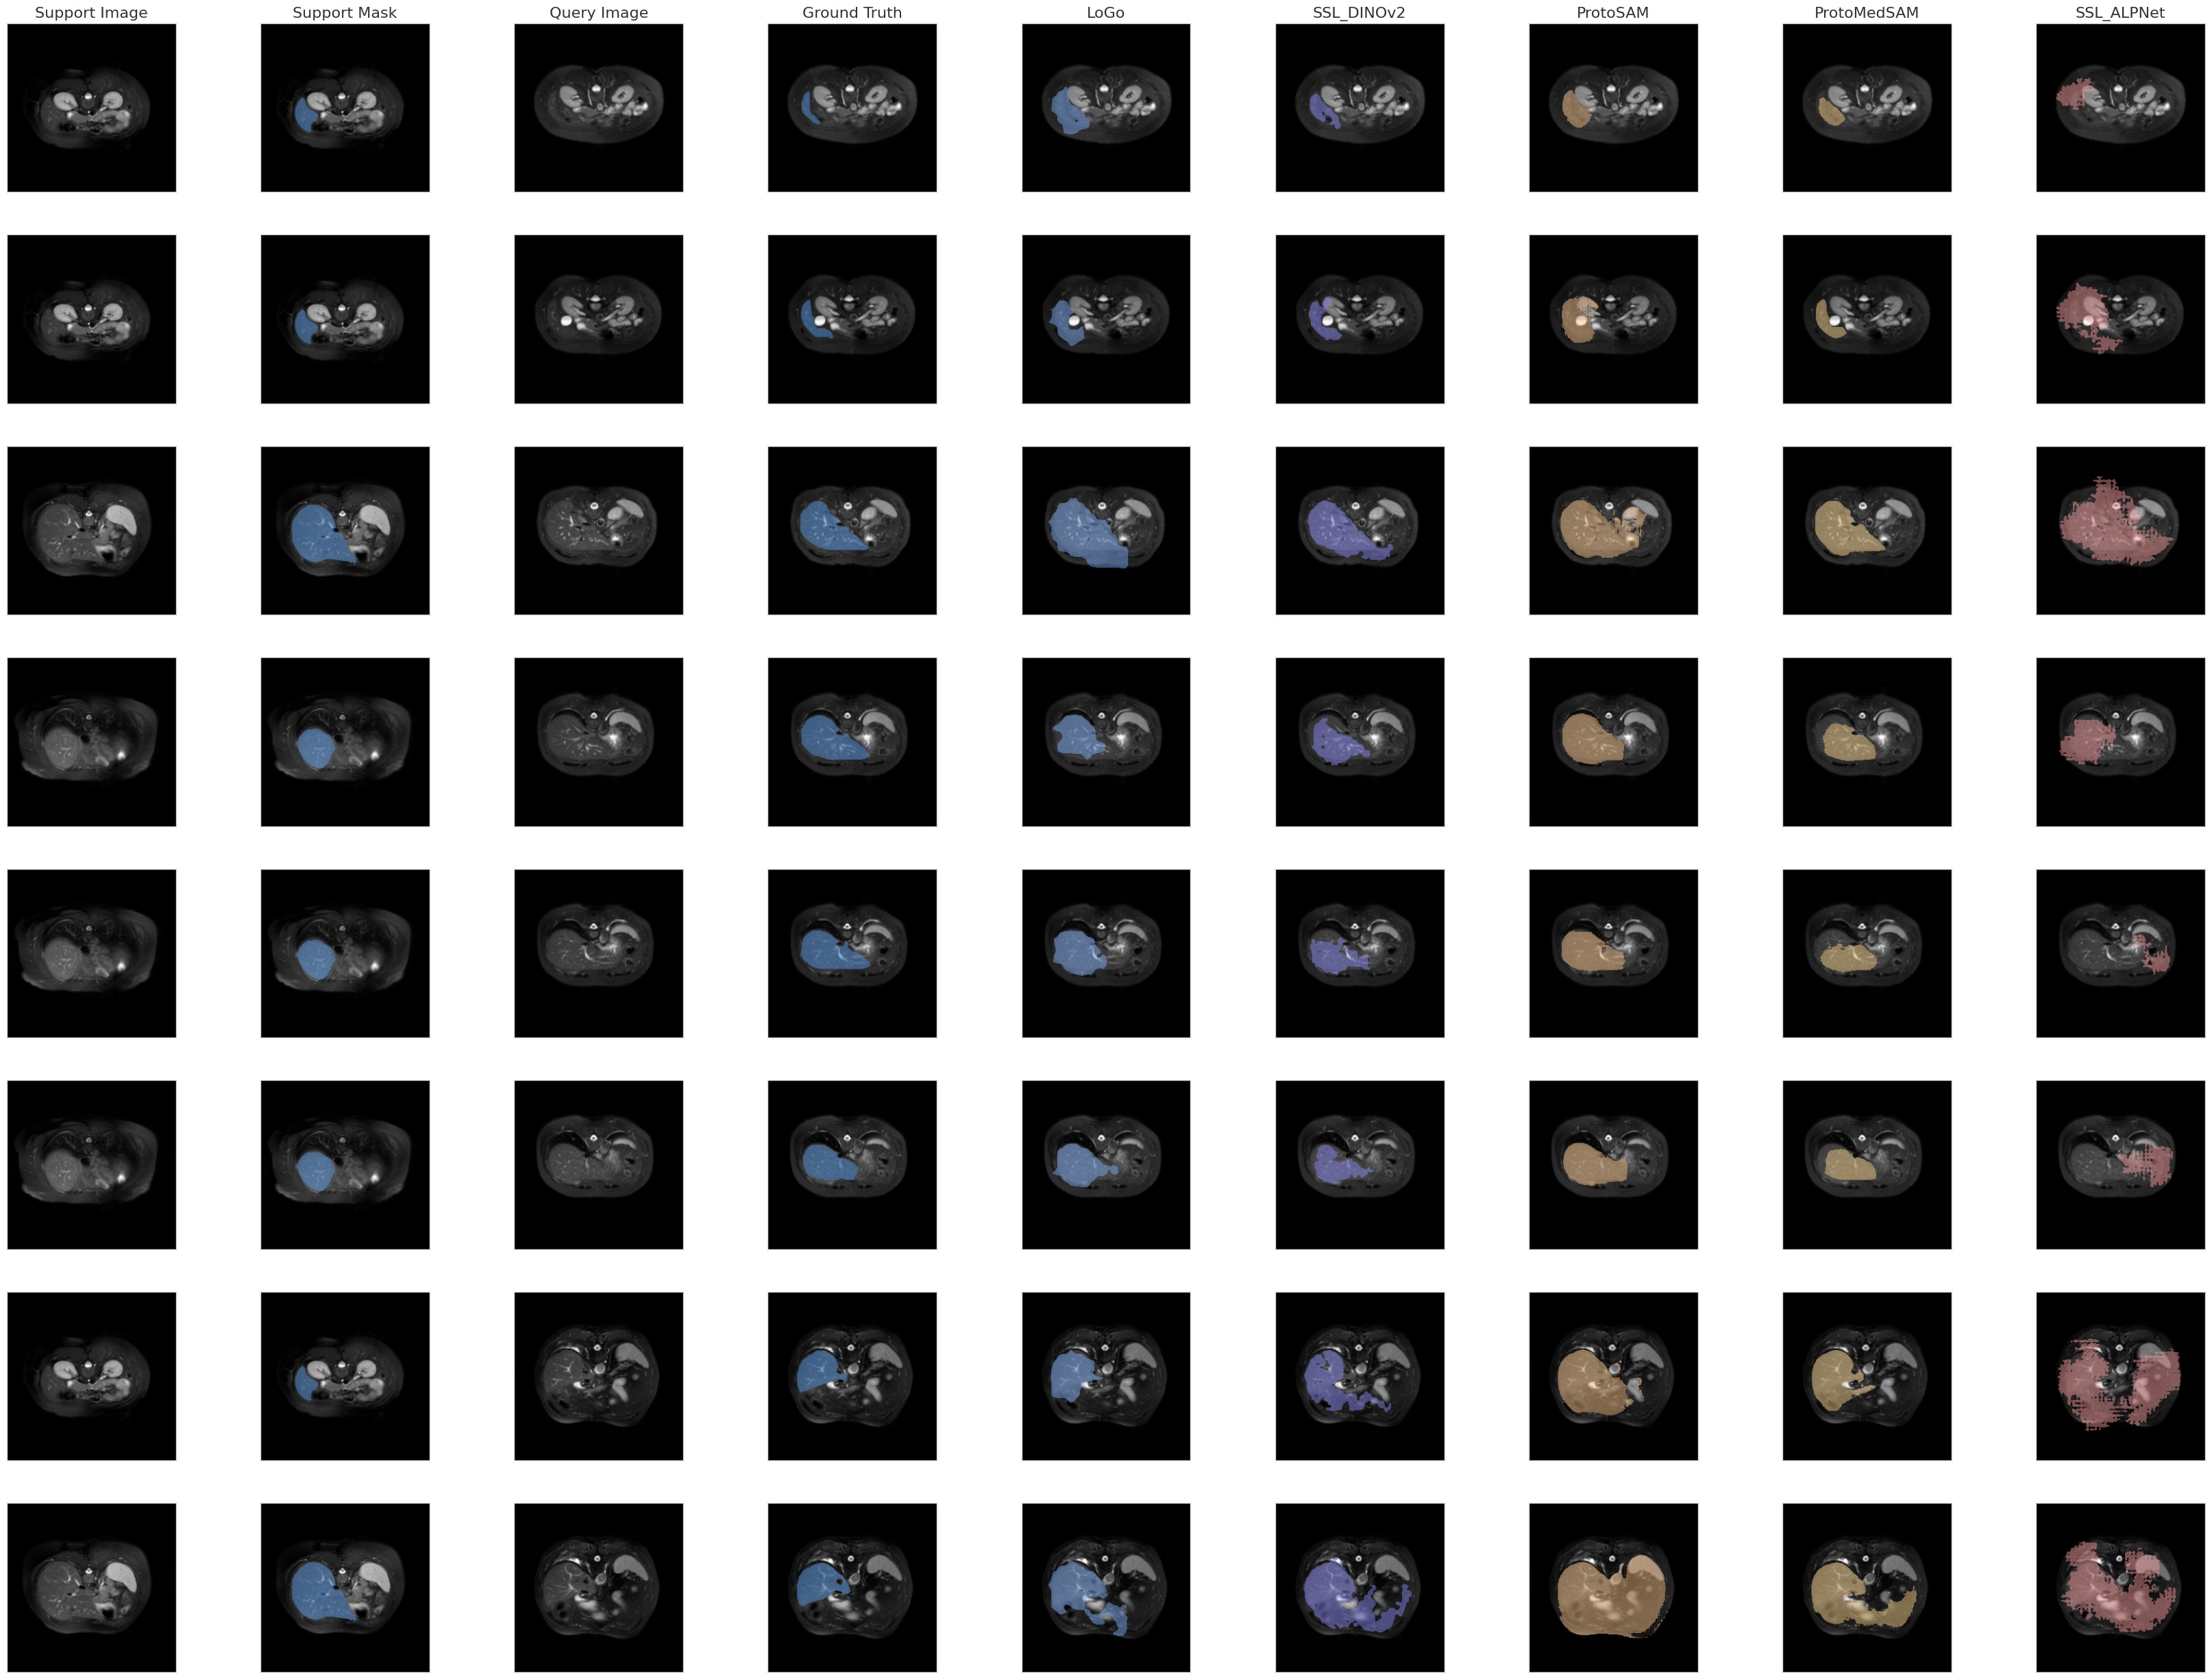


=== Creating figure for ORGAN: lk (5 samples) ===
✓ Saved figure: /content/inference-data/lk_comparison.png


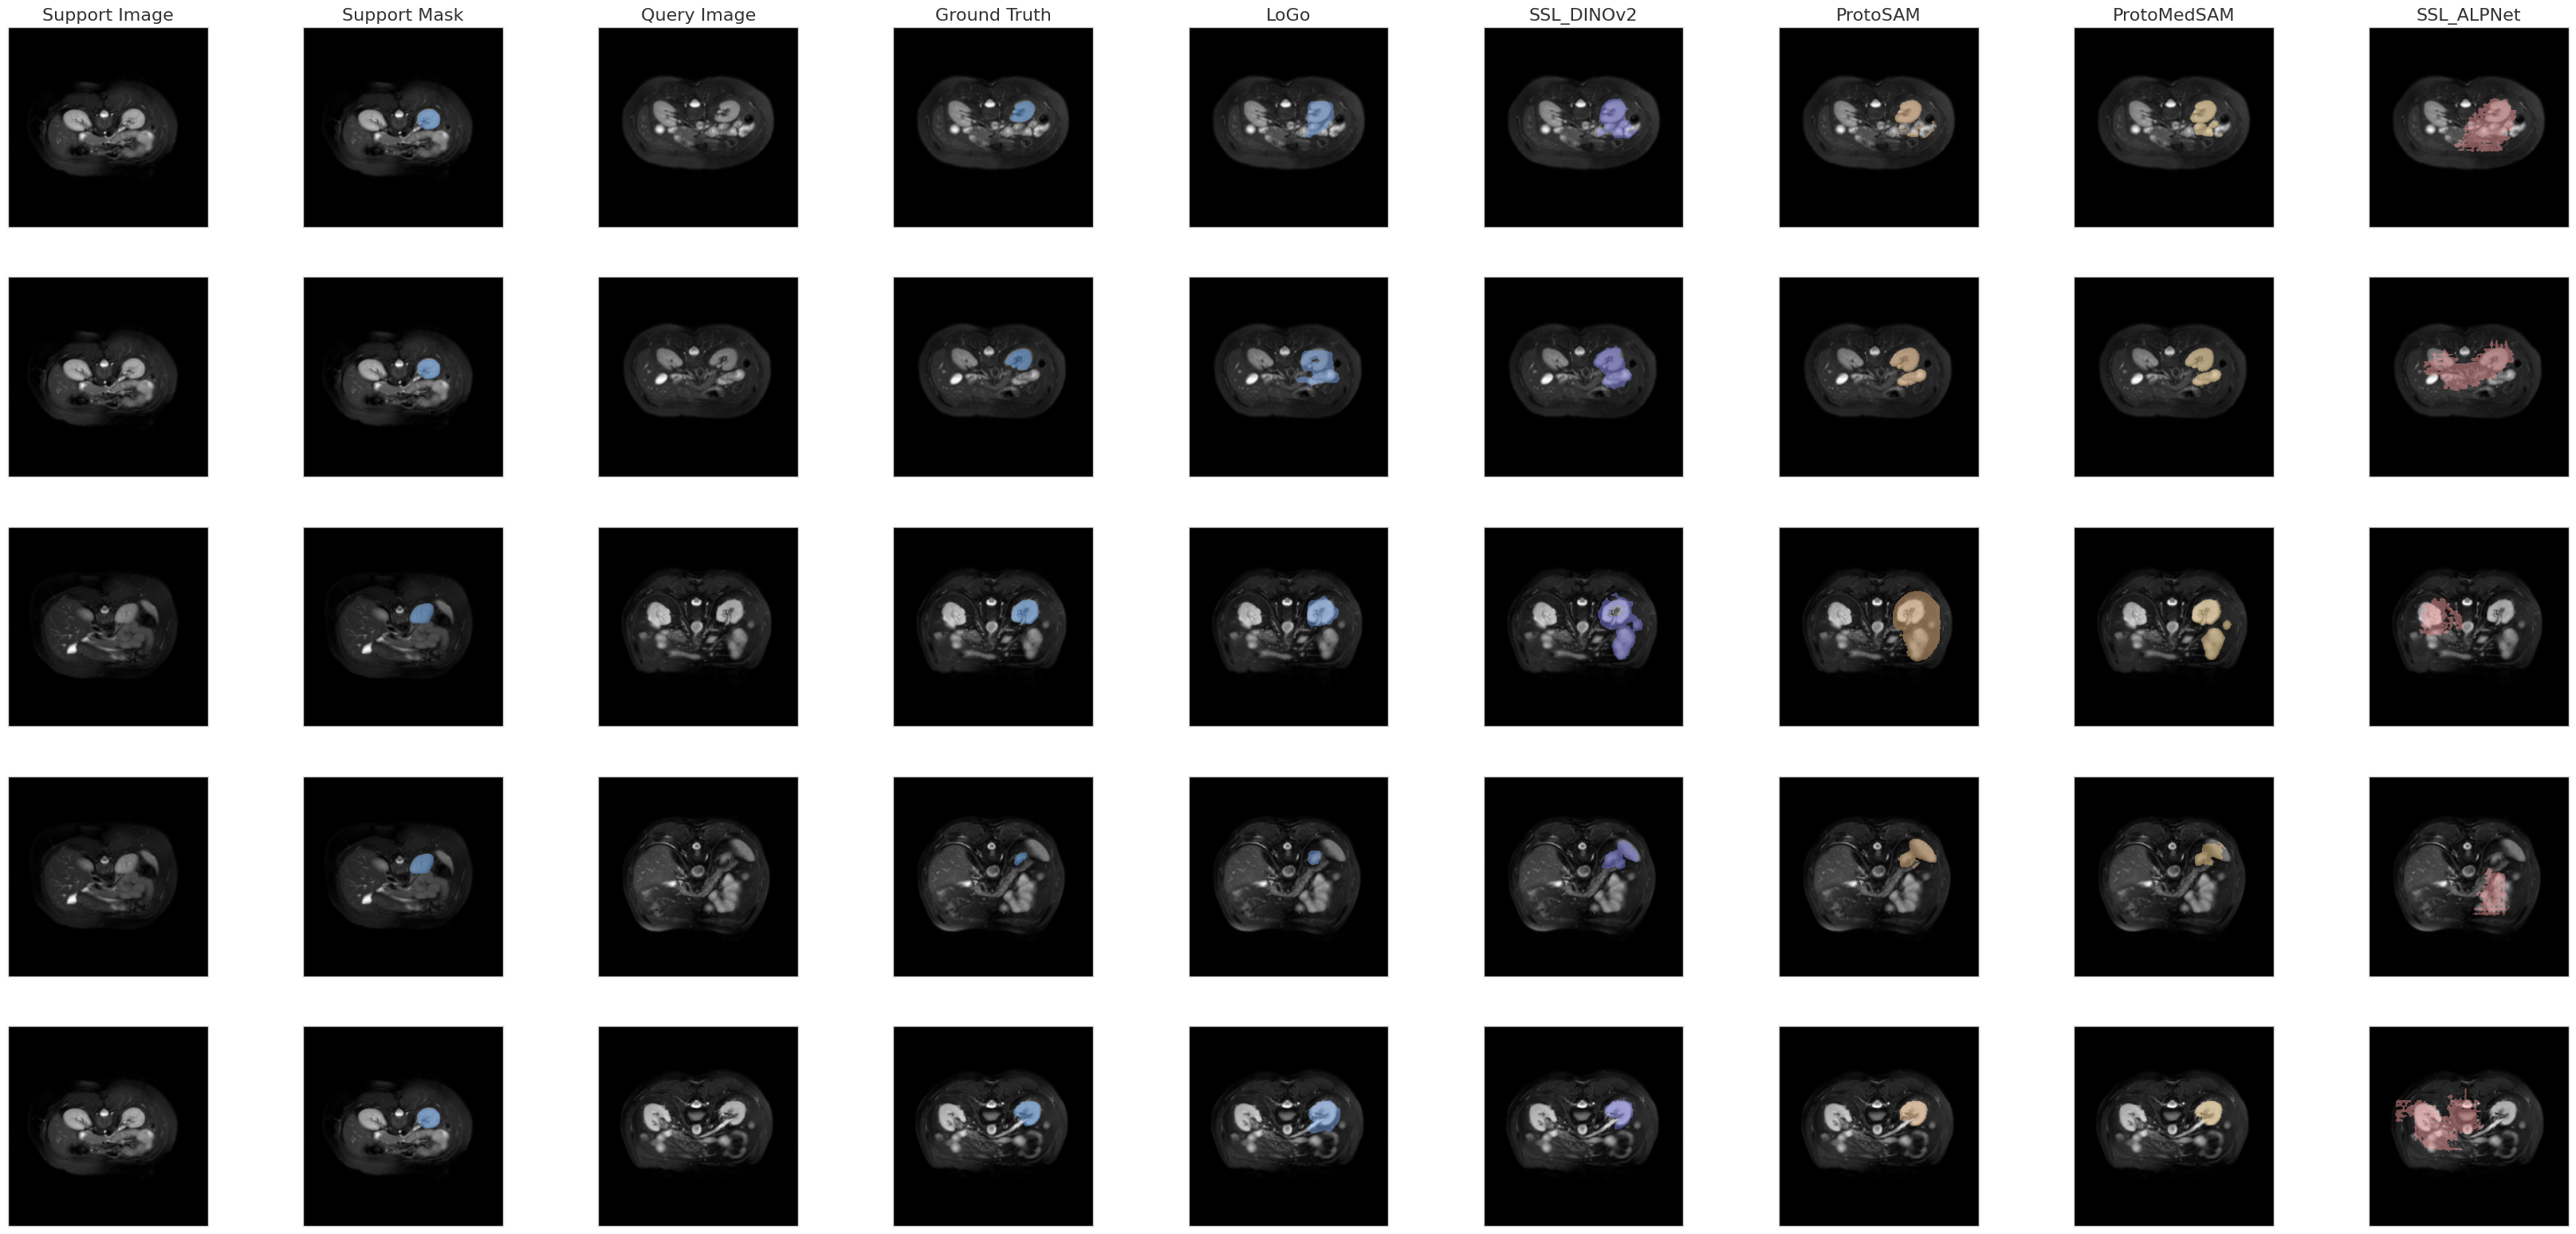


=== Creating figure for ORGAN: rk (5 samples) ===
✓ Saved figure: /content/inference-data/rk_comparison.png


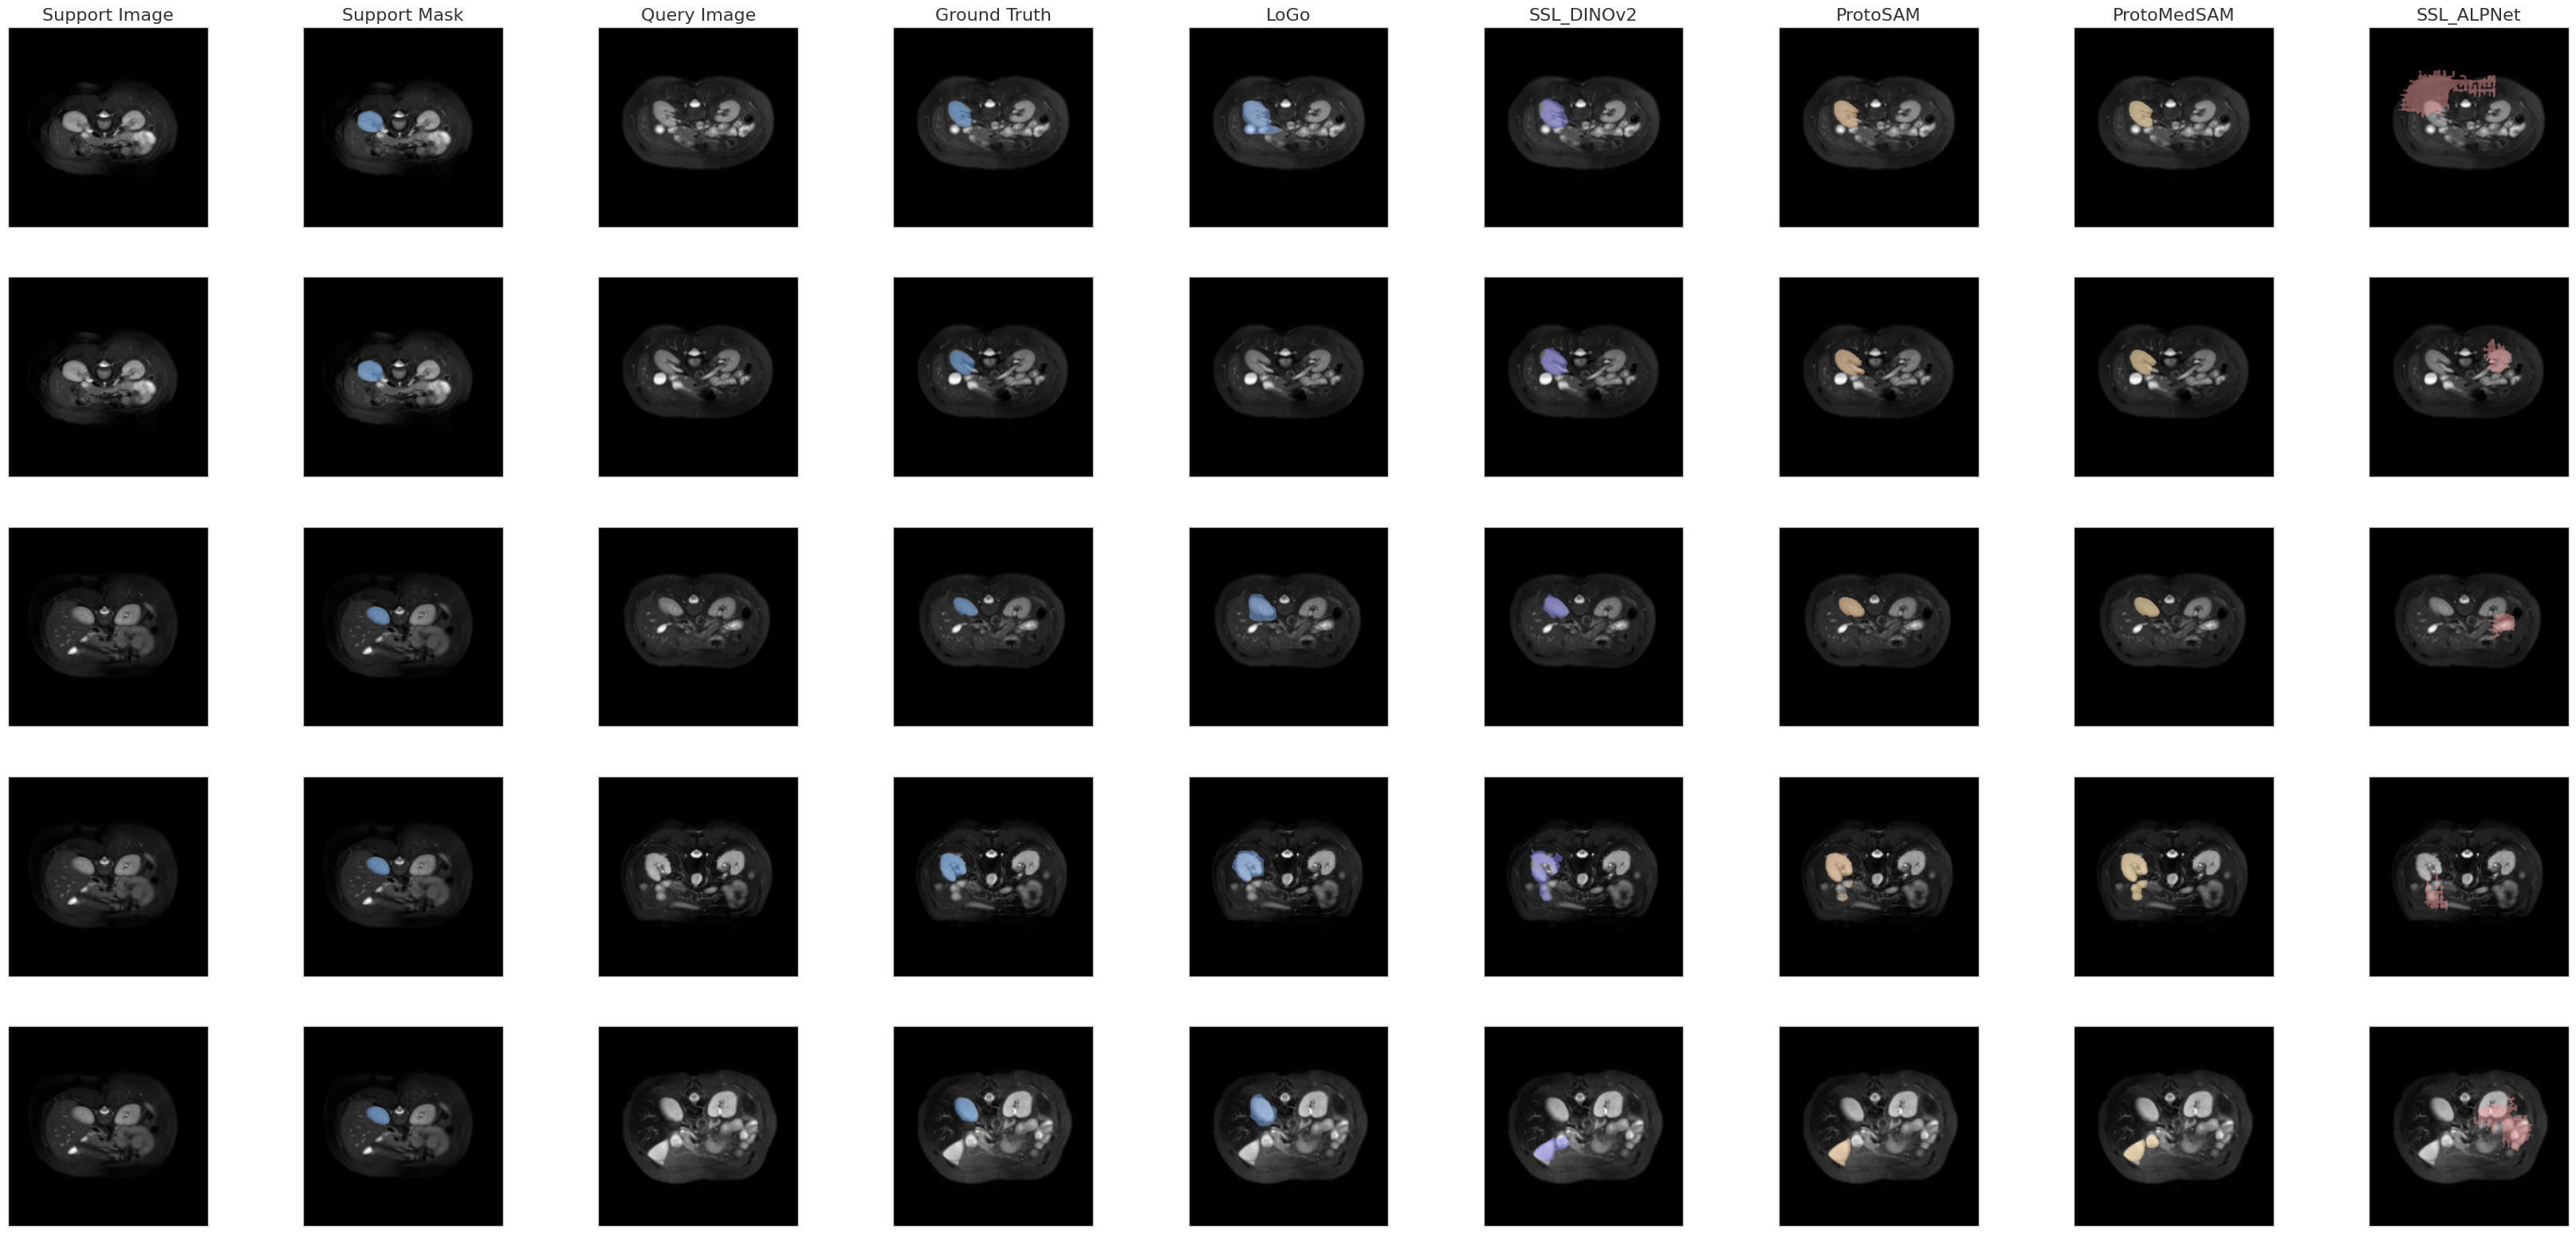


=== Creating figure for ORGAN: spleen (5 samples) ===
✓ Saved figure: /content/inference-data/spleen_comparison.png


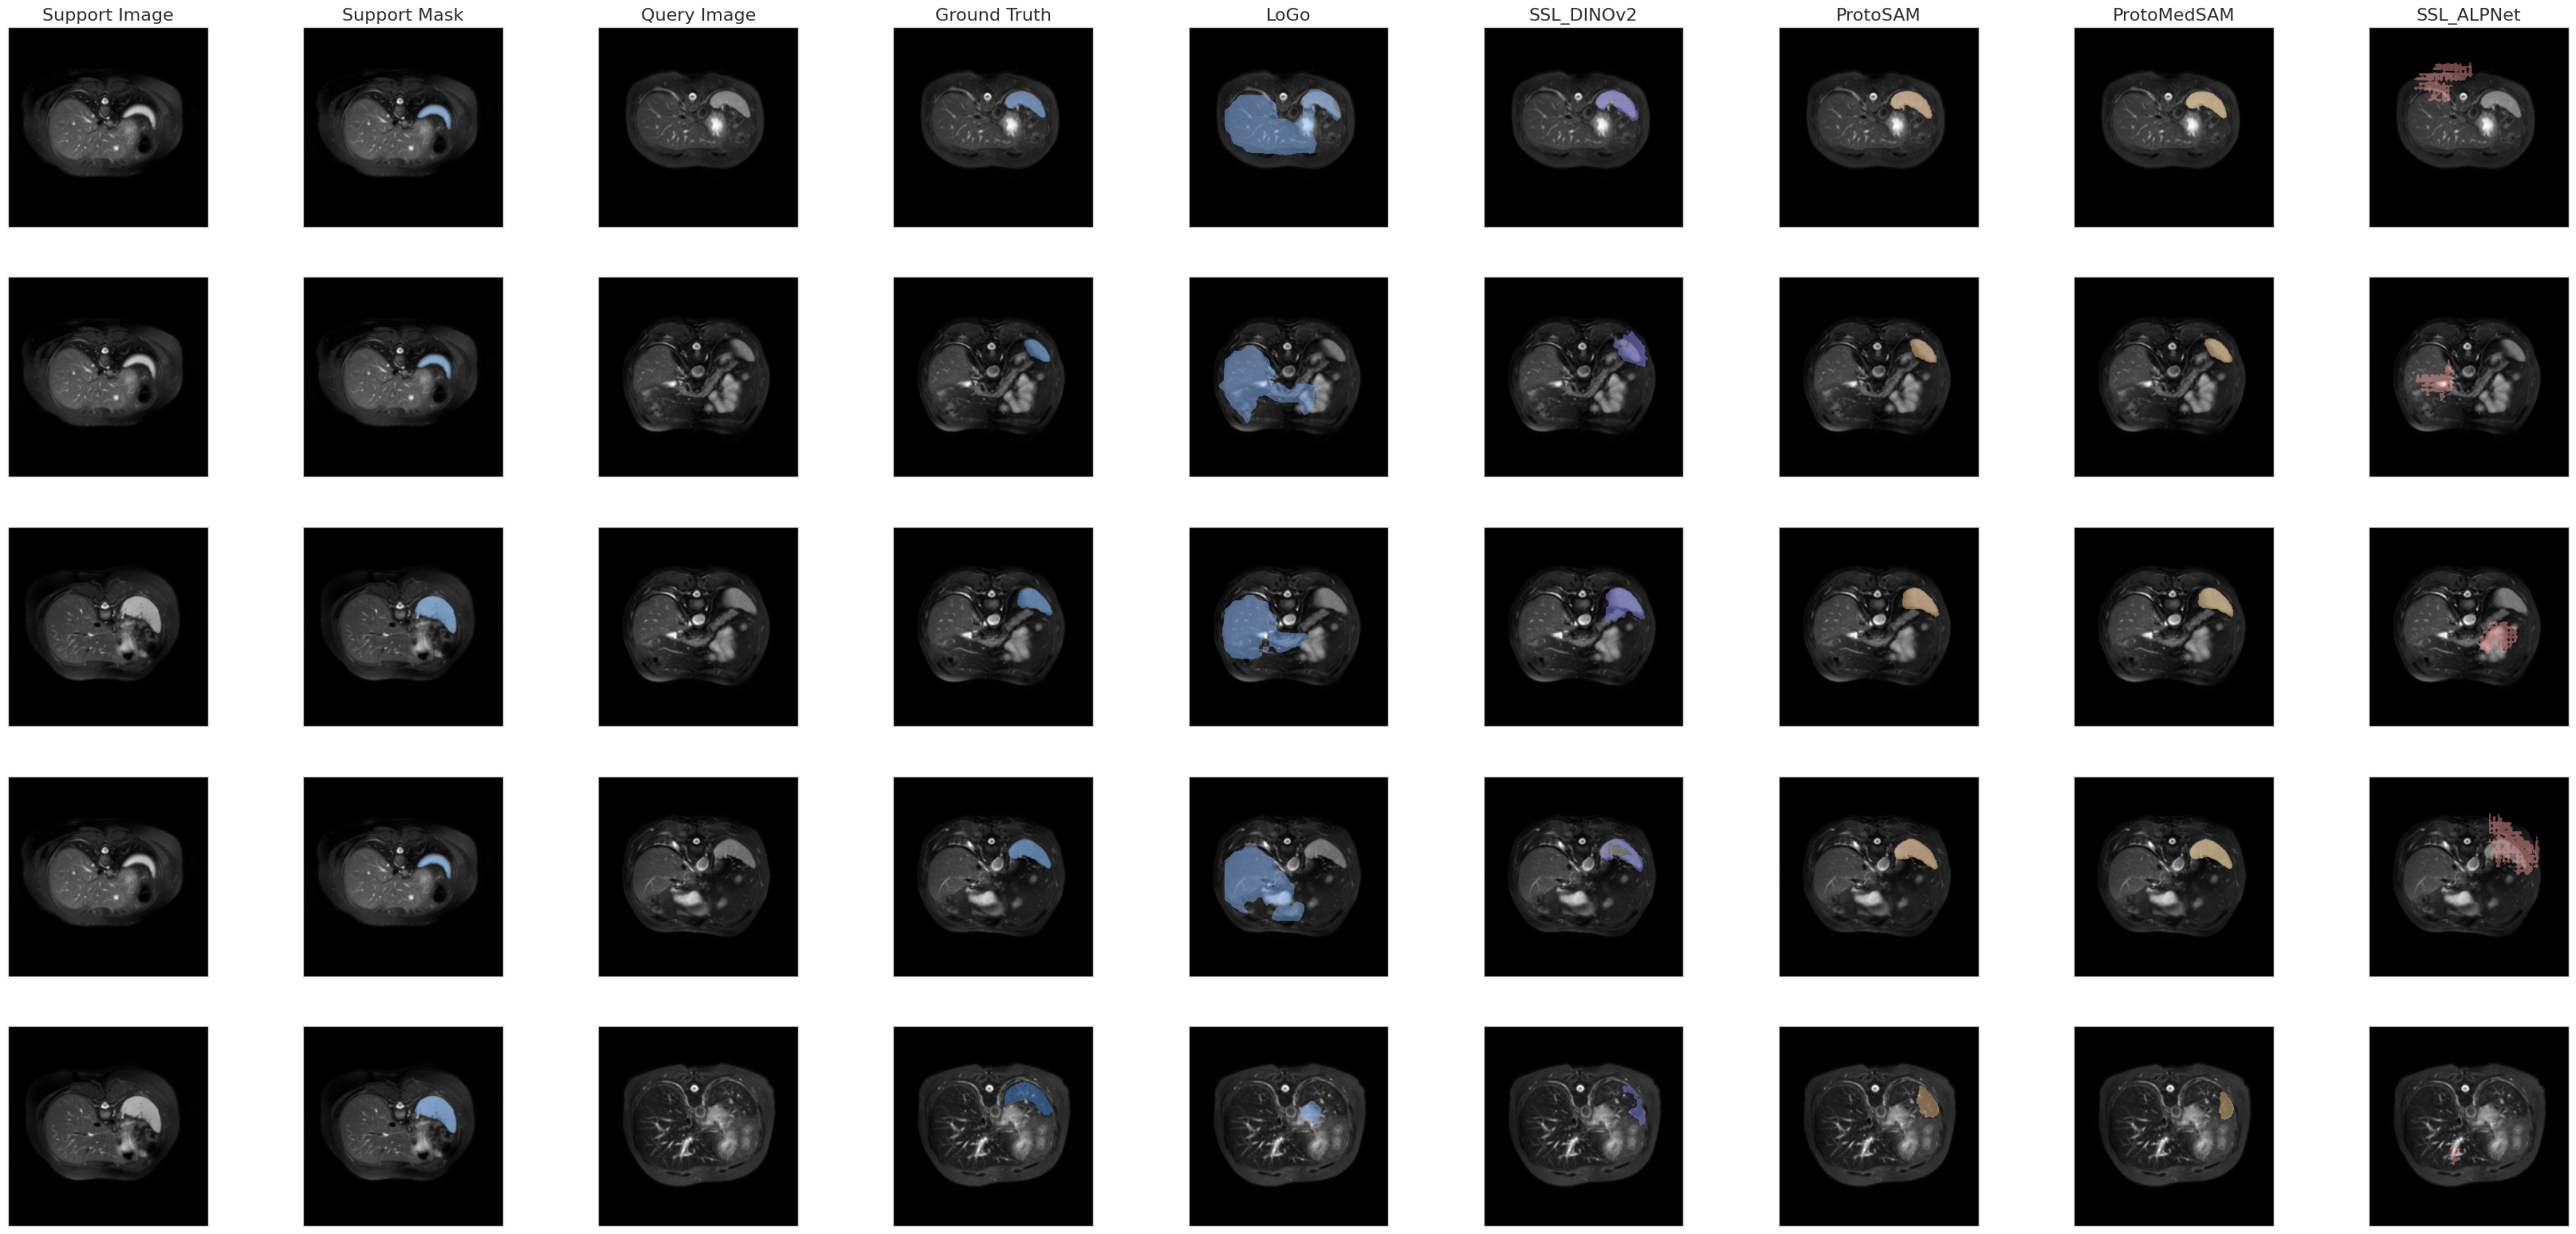


All organ-specific visualizations complete.


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch.nn.functional as F


Encoder.load_state_dict(torch.load("/content/final.pt", map_location=device))
# ============================================================
# Helper: Load images
# ============================================================
def load_image_for_display(path, is_mask=False, target_size=(256, 256)):
    if not path or not path.exists():
        return None
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Could not read image at {path}")
        return None

    img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR)

    if is_mask:
        return (img > 0).astype(np.float32)

    img = img.astype(np.float32)
    min_val, max_val = np.min(img), np.max(img)
    if max_val - min_val > 1e-6:
        img = (img - min_val) / (max_val - min_val)
    else:
        img = np.zeros_like(img)
    return img


# ============================================================
# Target roots
# ============================================================
target_roots = [
    "/content/inference-data/liver",
    "/content/inference-data/lk",
    "/content/inference-data/rk",
    "/content/inference-data/spleen"
]
DISPLAY_SIZE = (256, 256)

print("Starting visualization of comparison figures...")

# ============================================================
# Collect ALL SAMPLES grouped BY ORGAN
# ============================================================
organ_samples = {}

for organ_root in target_roots:
    root_path = Path(organ_root)
    if not root_path.exists():
        print(f"Skipping organ_root '{organ_root}', does not exist.")
        continue

    organ_name = root_path.name
    organ_samples[organ_name] = []

    print(f"\n--- Loading samples for organ: {organ_name} ---")

    for sample_dir in sorted(root_path.iterdir()):
        if not sample_dir.is_dir():
            continue

        print(f" Loading sample: {sample_dir.name}")

        # Paths
        support_img_path = sample_dir / "support.png"
        support_mask_path = sample_dir / "support_mask.png"
        query_img_path = sample_dir / "query.png"
        ground_truth_path = sample_dir / "ground_truth.png"
        prediction_logo_path = sample_dir / "LoGo" / "prediction_mask.png"
        prediction_dinov2_no_sam_path = sample_dir / "DINOv2-no-SAM" / "prediction_mask.png"
        prediction_dinov2_with_sam_path = sample_dir / "DINOv2-SAM" / "prediction_mask.png"
        prediction_dinov2_with_medsam_path = sample_dir / "DINOv2-MedSAM" / "prediction_mask.png"
        prediction_resnet_no_sam_path = sample_dir / "ResNet-no-SAM" / "prediction_mask.png"

        # Load images
        s_img = load_image_for_display(support_img_path, target_size=DISPLAY_SIZE)
        s_mask = load_image_for_display(support_mask_path, is_mask=True, target_size=DISPLAY_SIZE)
        q_img = load_image_for_display(query_img_path, target_size=DISPLAY_SIZE)
        gt_mask = load_image_for_display(ground_truth_path, is_mask=True, target_size=DISPLAY_SIZE)
        pred_logo = load_image_for_display(prediction_logo_path, is_mask=True, target_size=DISPLAY_SIZE)
        pred_dinov2_no_sam = load_image_for_display(prediction_dinov2_no_sam_path, is_mask=True, target_size=DISPLAY_SIZE)
        pred_dinov2_with_sam = load_image_for_display(prediction_dinov2_with_sam_path, is_mask=True, target_size=DISPLAY_SIZE)
        pred_dinov2_with_medsam = load_image_for_display(prediction_dinov2_with_medsam_path, is_mask=True, target_size=DISPLAY_SIZE)
        pred_resnet_no_sam = load_image_for_display(prediction_resnet_no_sam_path, is_mask=True, target_size=DISPLAY_SIZE)

        if s_img is None or s_mask is None or q_img is None or gt_mask is None:
            print(f"  Skipping {sample_dir.name}: Missing input or GT.")
            continue

        organ_samples[organ_name].append({
            'name': sample_dir.name,
            's_img': s_img,
            's_mask': s_mask,
            'q_img': q_img,
            'gt_mask': gt_mask,
            'predictions': [
                (pred_logo, "LoGo"),
                (pred_dinov2_no_sam, "SSL_DINOv2"),
                (pred_dinov2_with_sam, "ProtoSAM"),
                (pred_dinov2_with_medsam, "ProtoMedSAM"),
                (pred_resnet_no_sam, "SSL_ALPNet"),
            ]
        })


# ============================================================
# Matplotlib style
# ============================================================
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = '#D9D9D9'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Roboto']
mpl.rcParams['axes.titleweight'] = 'medium'
mpl.rcParams['axes.titlepad'] = 8

# Draw panel function (unchanged)
def draw_panel(ax, base_img, overlay=None, title="", color="#4A90E2"):
    ax.imshow(base_img, cmap="gray")

    if overlay is not None:
        overlay_rgba = np.zeros((*overlay.shape, 4))
        overlay_rgba[..., 0] = int(color[1:3], 16) / 255
        overlay_rgba[..., 1] = int(color[3:5], 16) / 255
        overlay_rgba[..., 2] = int(color[5:7], 16) / 255
        overlay_rgba[..., 3] = overlay * 0.45
        ax.imshow(overlay_rgba)

    if title:
        ax.set_title(title, fontsize=16, color="#333333", fontweight="medium", pad=6)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("#D9D9D9")
        spine.set_linewidth(1.0)

# Colors
pred_colors = {
    "LoGo": "#7FB3FF",
    "SSL_DINOv2": "#8C8CFF",
    "ProtoSAM": "#FFC78A",
    "ProtoMedSAM": "#FFD68A",
    "SSL_ALPNet": "#FF9E9E",
}

column_titles = [
    "Support Image",
    "Support Mask",
    "Query Image",
    "Ground Truth",
    "LoGo",
    "SSL_DINOv2",
    "ProtoSAM",
    "ProtoMedSAM",
    "SSL_ALPNet"
]

# ============================================================
# CREATE ONE FIGURE PER ORGAN
# ============================================================
for organ_name, samples in organ_samples.items():

    if len(samples) == 0:
        print(f"No valid samples for {organ_name}, skipping figure.")
        continue

    print(f"\n=== Creating figure for ORGAN: {organ_name} ({len(samples)} samples) ===")

    # Per-organ figure dimensions
    n_samples = len(samples)
    col_width = 3.8
    row_height = 3.2

    fig_width = col_width * 9
    fig_height = row_height * n_samples

    fig, axes = plt.subplots(n_samples, 9, figsize=(fig_width, fig_height))

    if n_samples == 1:
        axes = axes.reshape(1, -1)

    plt.subplots_adjust(
        left=0.02, right=0.98,
        top=0.96, bottom=0.02,
        wspace=0.15, hspace=0.25
    )

    # Draw rows
    for row_idx, sample_data in enumerate(samples):

        # Base panels
        draw_panel(axes[row_idx, 0], sample_data['s_img'],
                   None, column_titles[0] if row_idx == 0 else "")
        draw_panel(axes[row_idx, 1], sample_data['s_img'],
                   sample_data['s_mask'], column_titles[1] if row_idx == 0 else "")
        draw_panel(axes[row_idx, 2], sample_data['q_img'],
                   None, column_titles[2] if row_idx == 0 else "")
        draw_panel(axes[row_idx, 3], sample_data['q_img'],
                   sample_data['gt_mask'], column_titles[3] if row_idx == 0 else "")

        # Predictions
        for i, (mask, pred_name) in enumerate(sample_data['predictions']):
            color = pred_colors[pred_name]
            draw_panel(
                axes[row_idx, 4 + i],
                sample_data['q_img'],
                mask,
                column_titles[4 + i] if row_idx == 0 else "",
                color=color
            )

    # Save
    save_path = Path("/content/inference-data") / f"{organ_name}_comparison.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved figure: {save_path}")

    plt.show()
    plt.close()

print("\nAll organ-specific visualizations complete.")
